In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


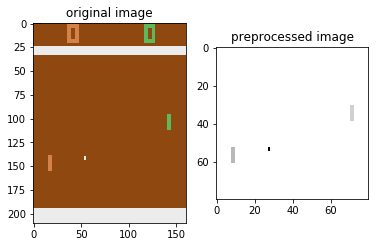

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 8, kernel_size=9, stride=2)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=6, stride=2)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=6, stride=2)
        self.conv4 = nn.Conv2d(8, 1, kernel_size=3, stride=2)
        
        
        self.size=4
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        return self.sig(self.fc2(self.fc1(x)))

# use your own policy!
policy=Policy().to(device)


#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)


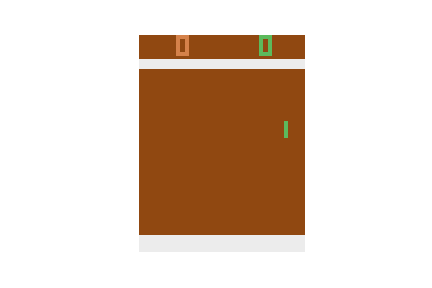
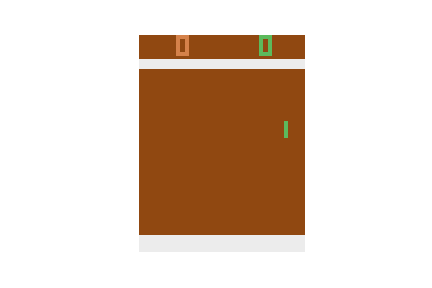
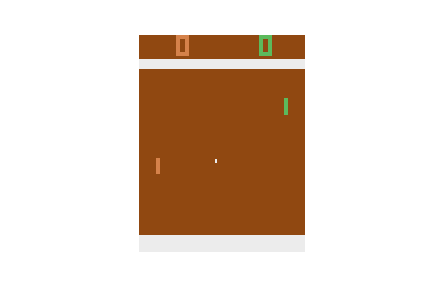
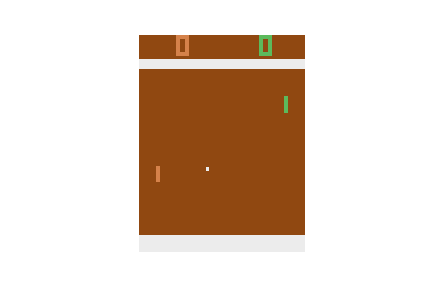
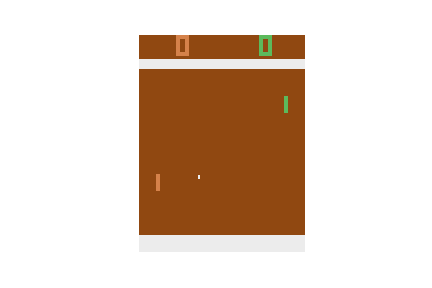
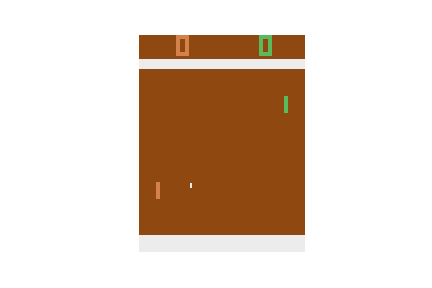
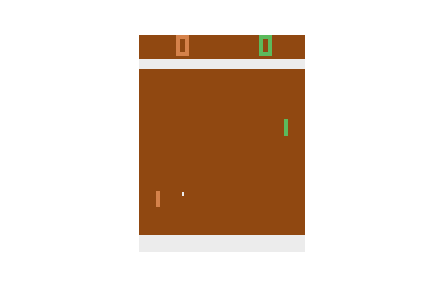
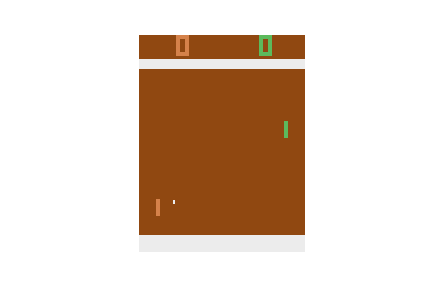
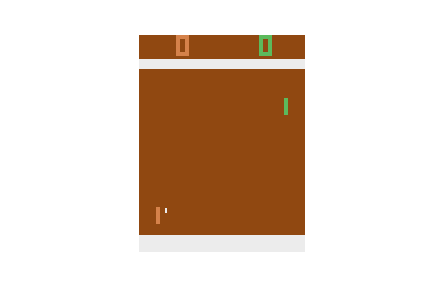
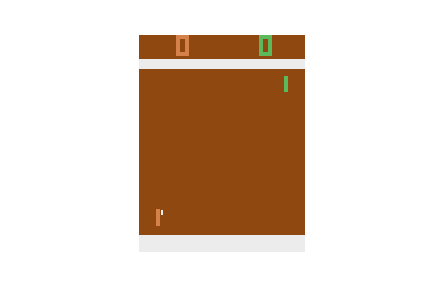
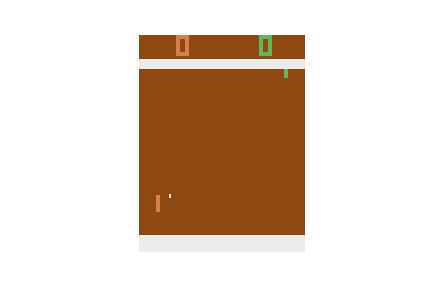
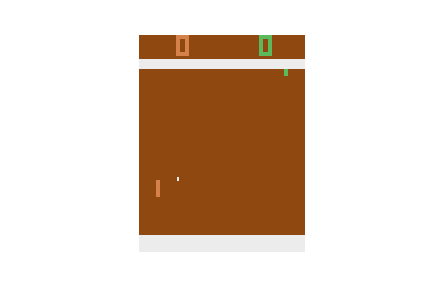
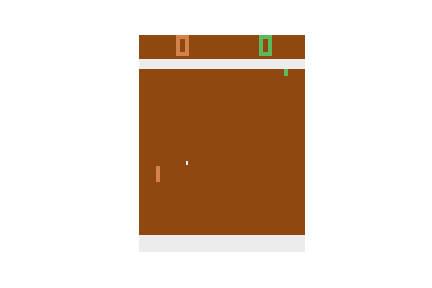
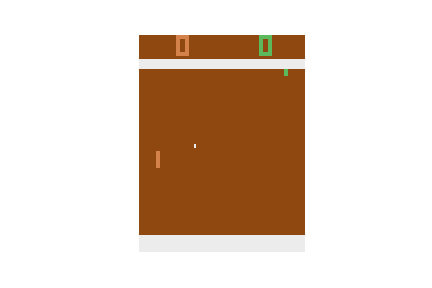
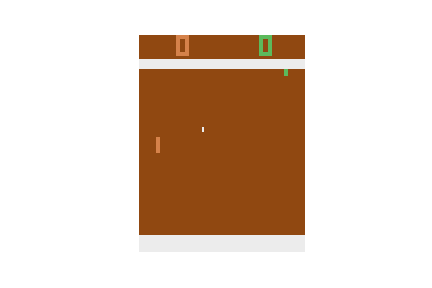
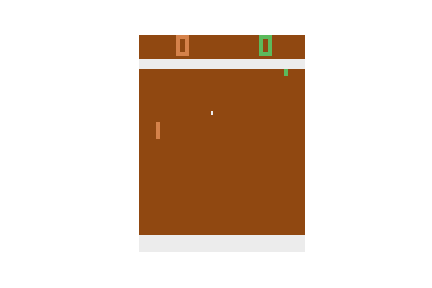
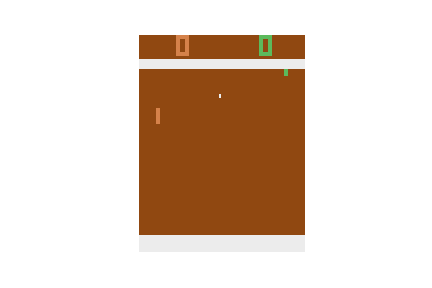
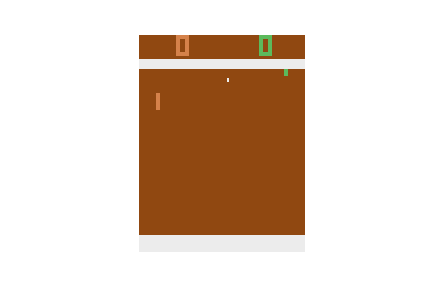
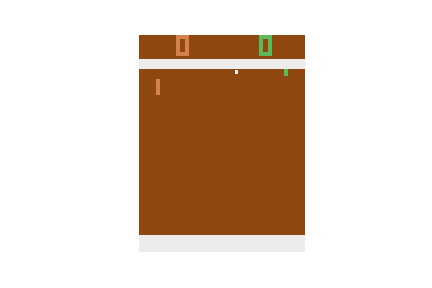
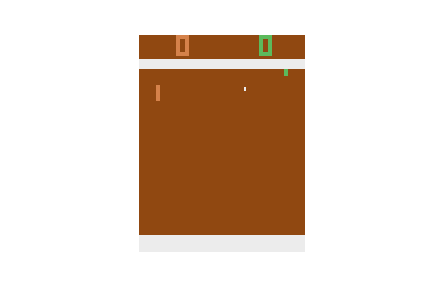
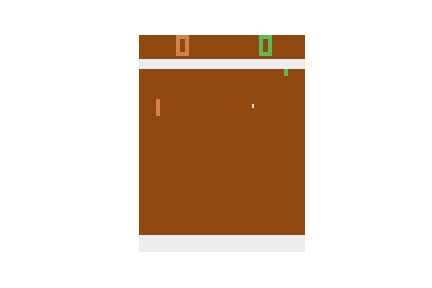
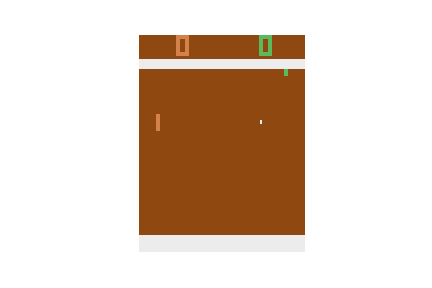
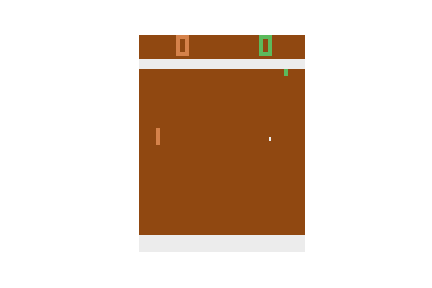
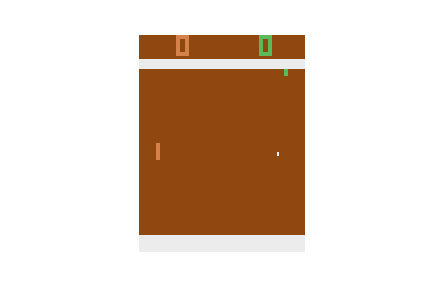
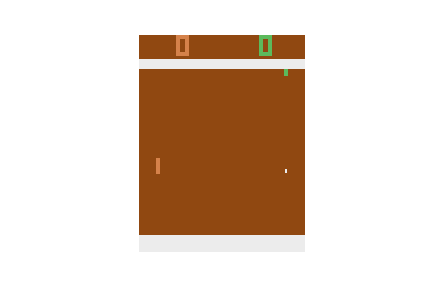
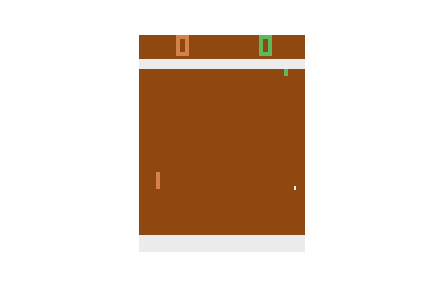
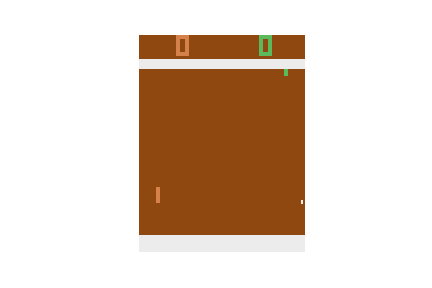
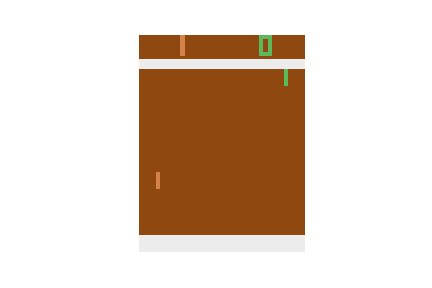
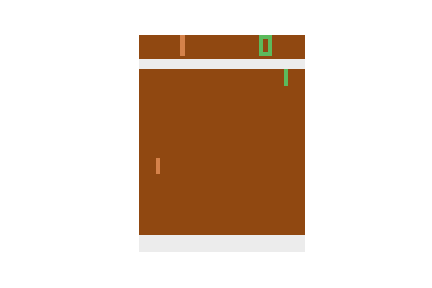
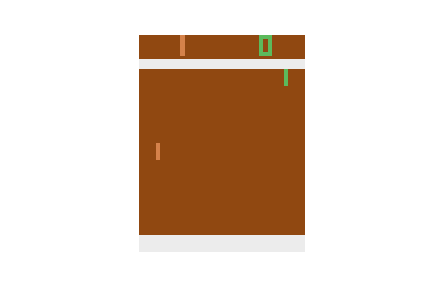
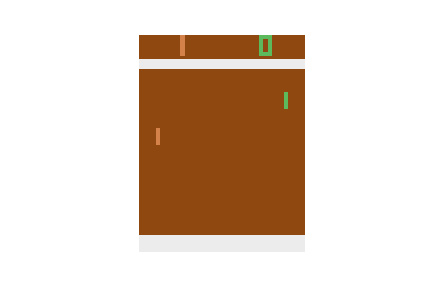
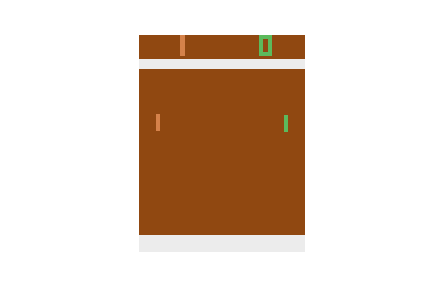
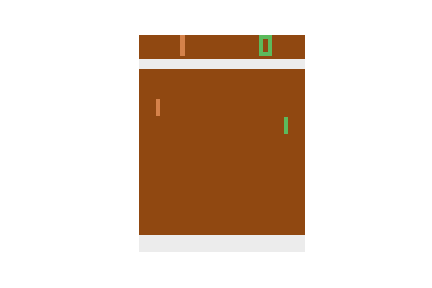
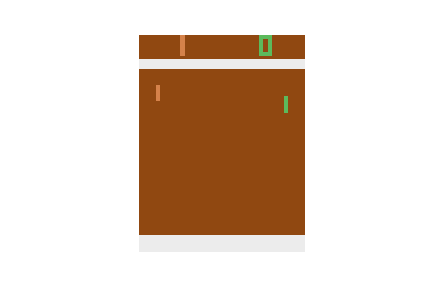
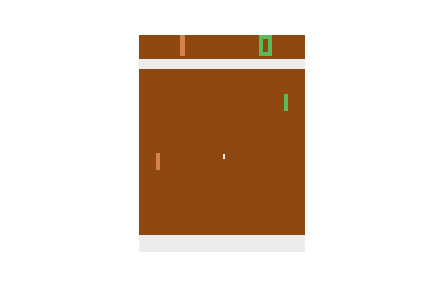
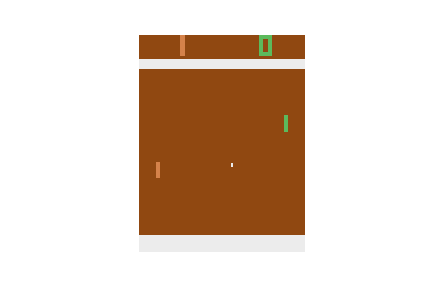
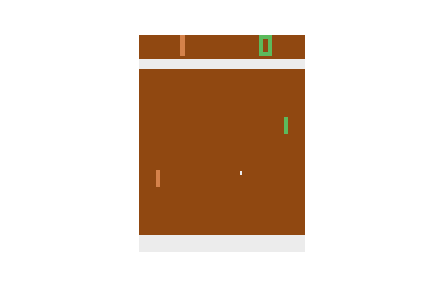
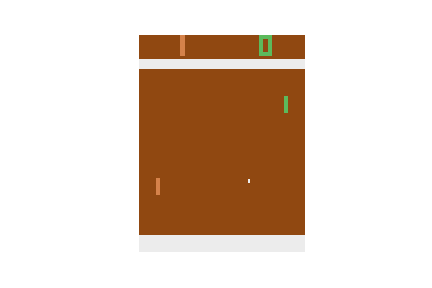
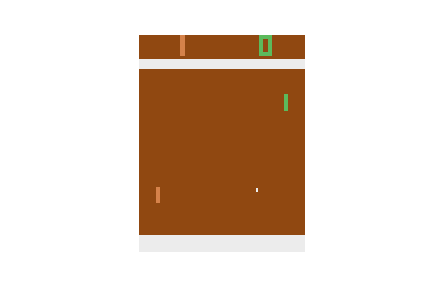
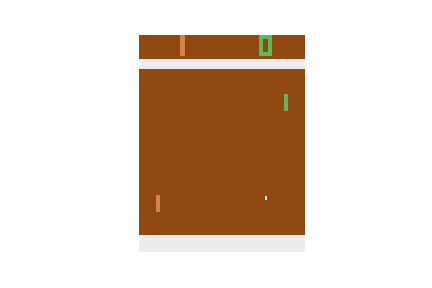
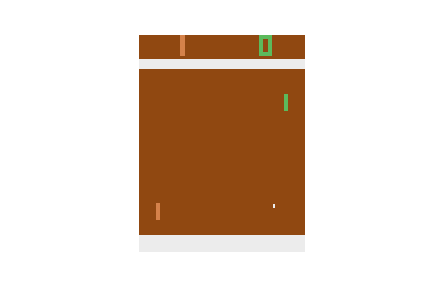
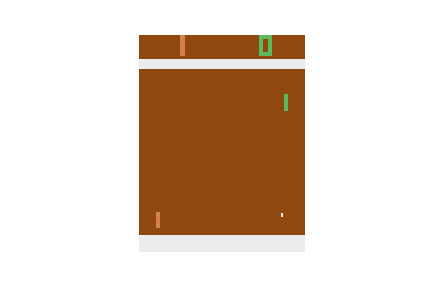
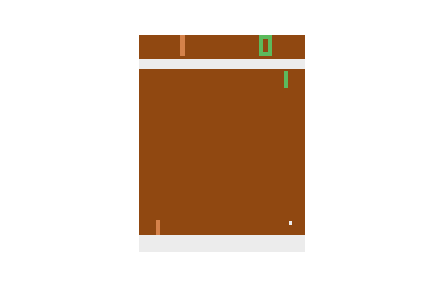
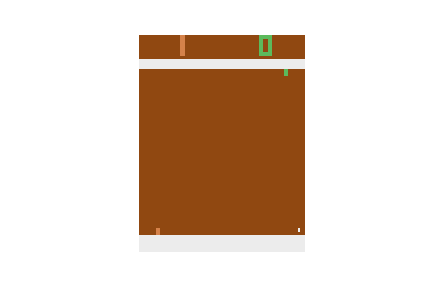
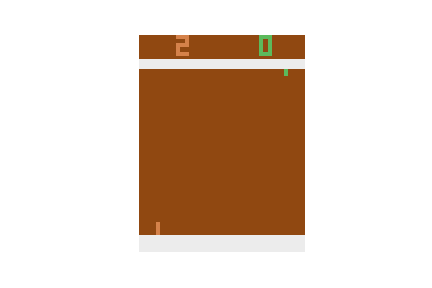
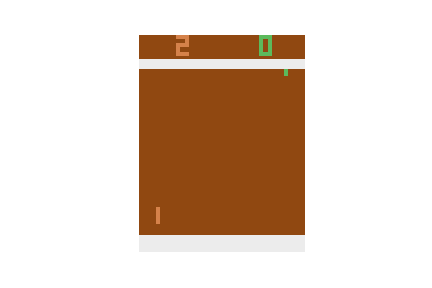
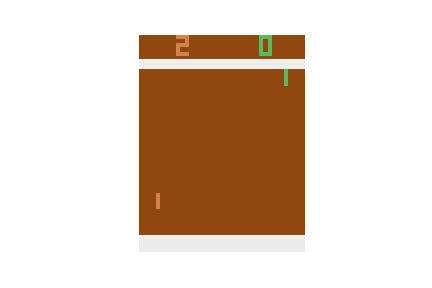
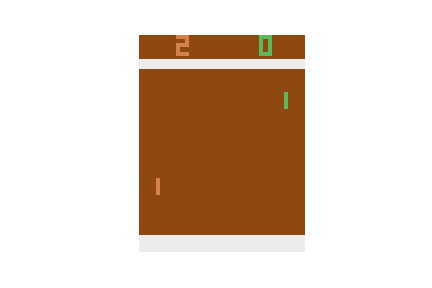
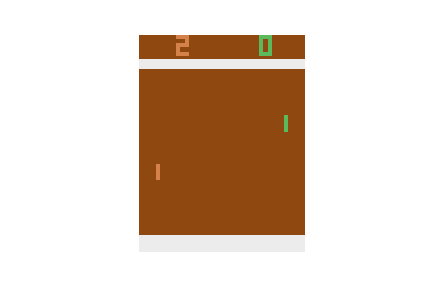
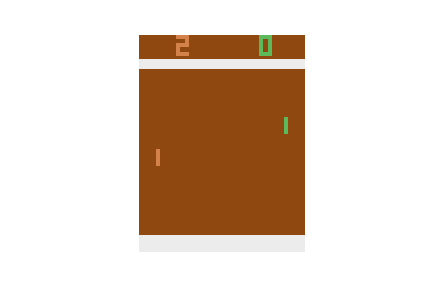
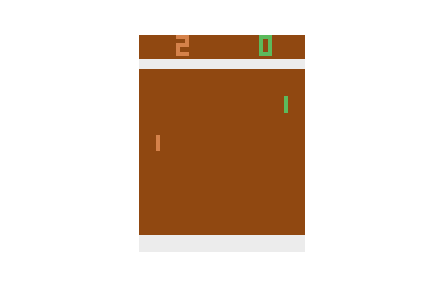
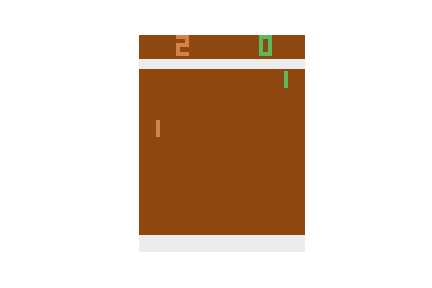
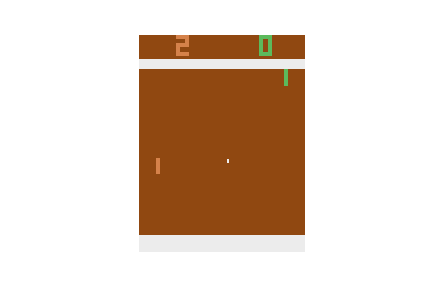
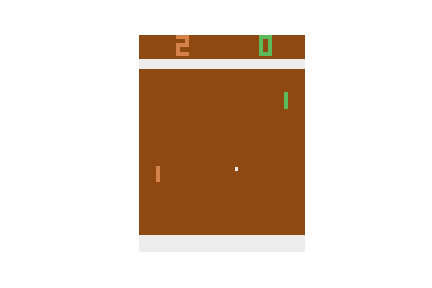
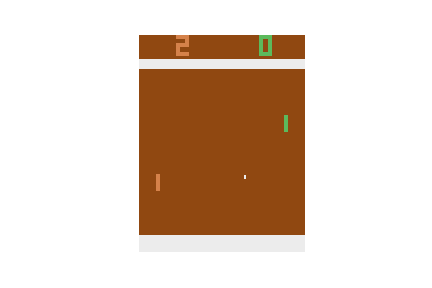
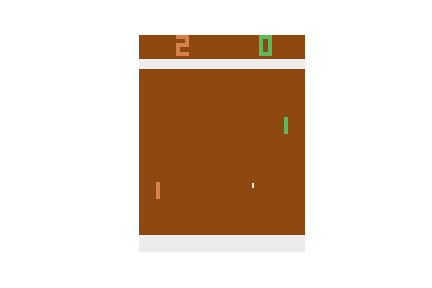
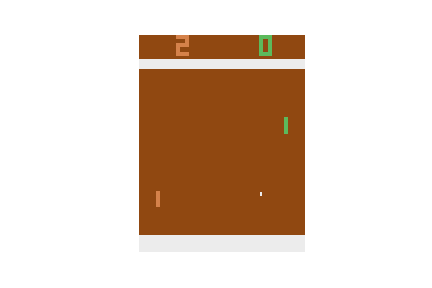
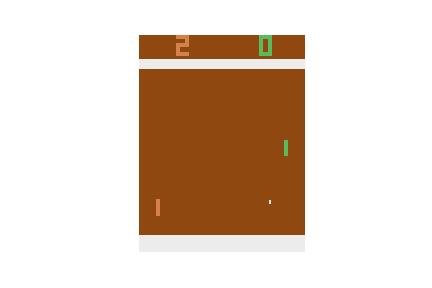
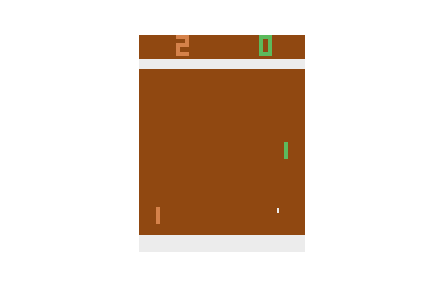
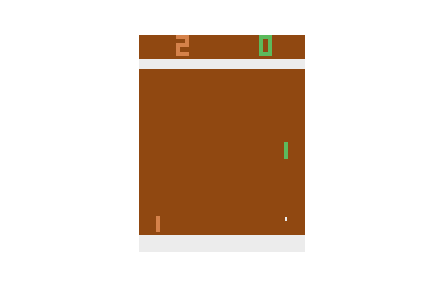
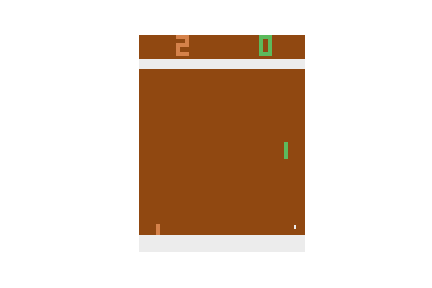
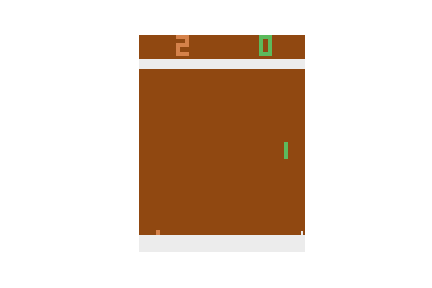
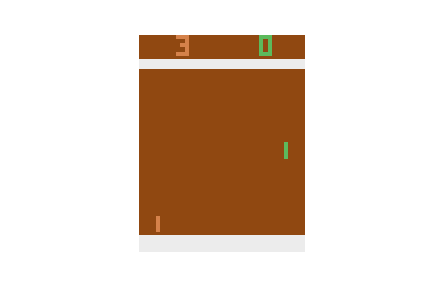
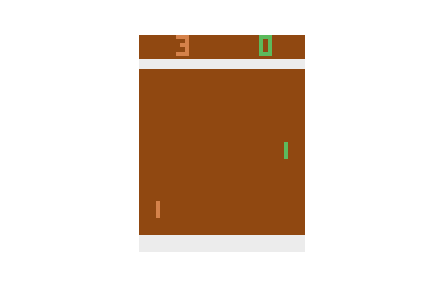
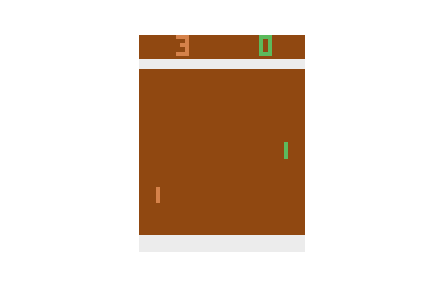
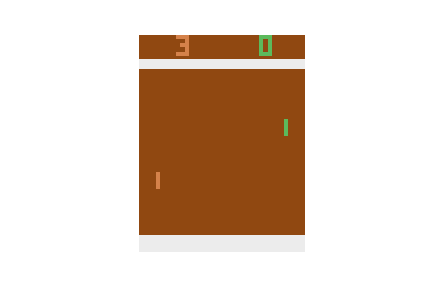
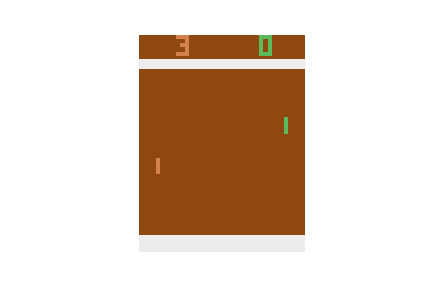
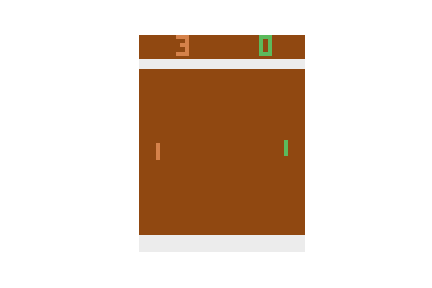
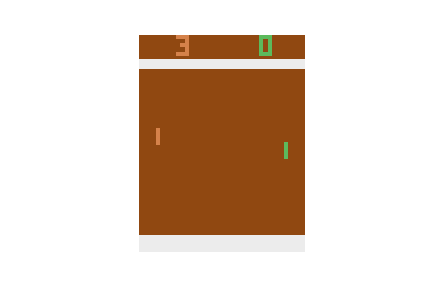
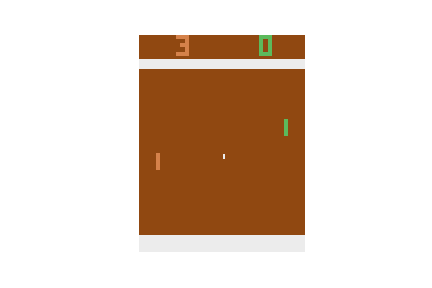
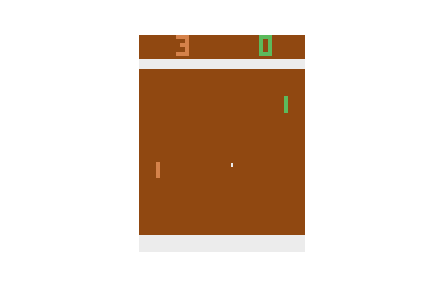
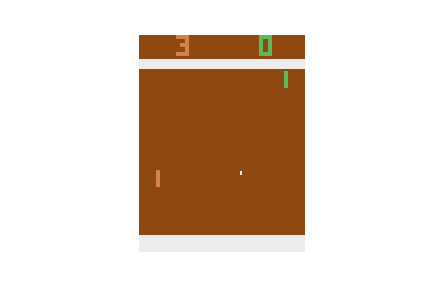
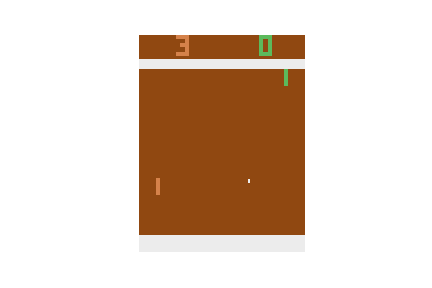
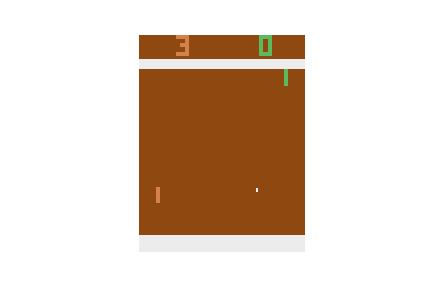
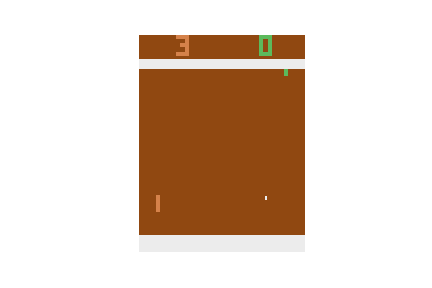
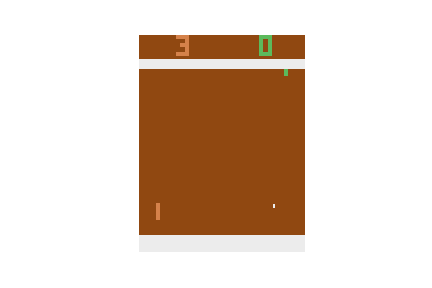
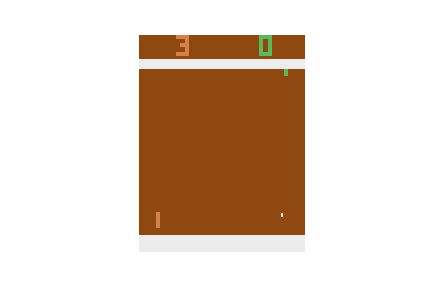
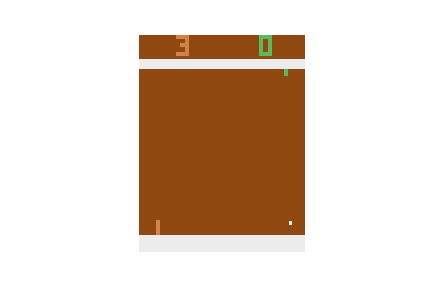
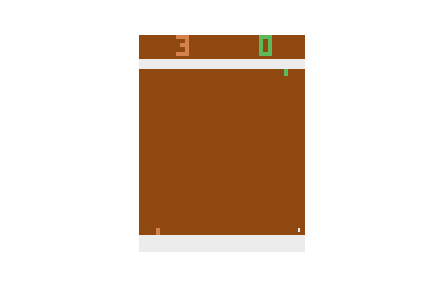
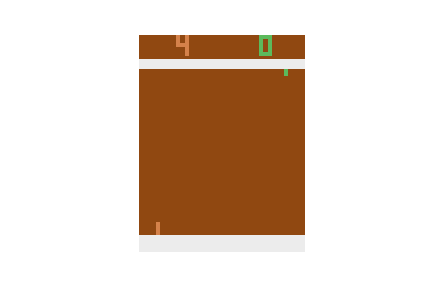
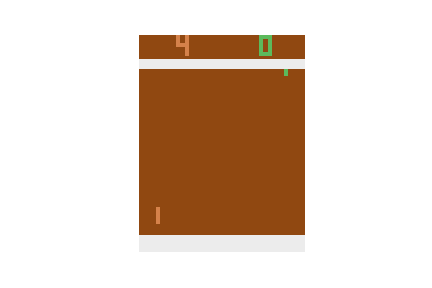
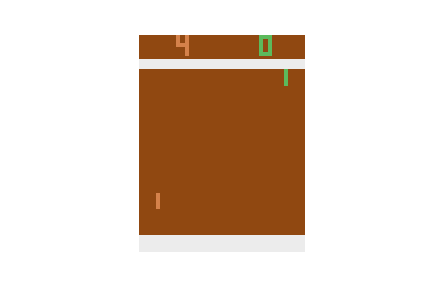
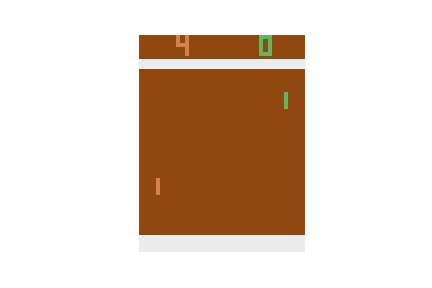
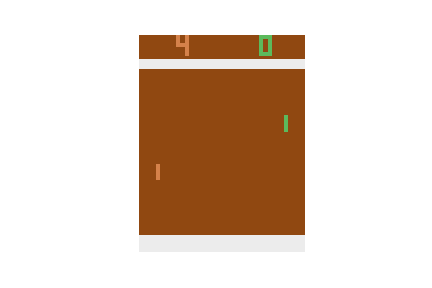
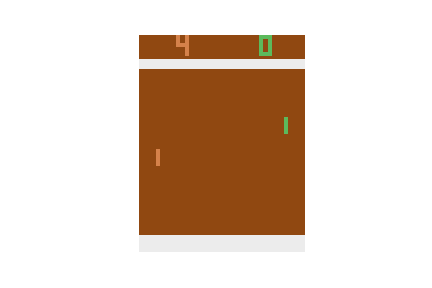
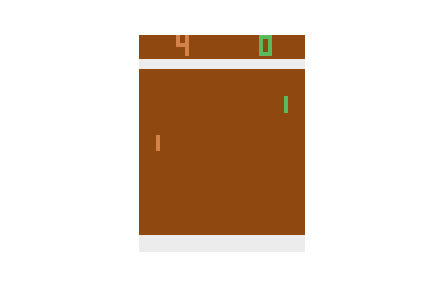
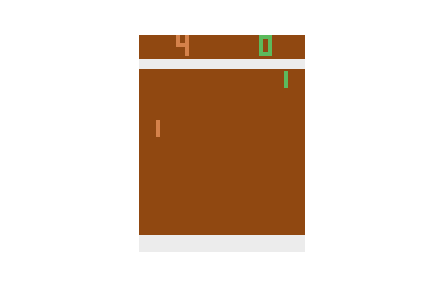
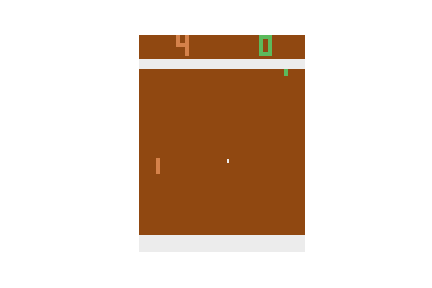
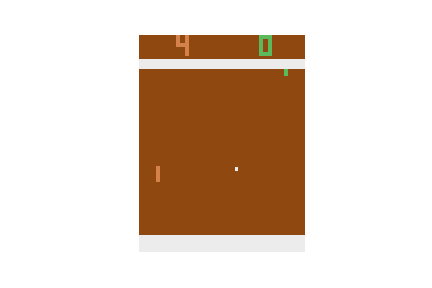
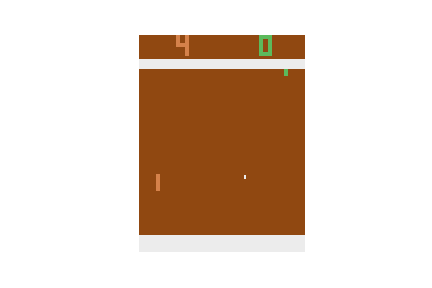
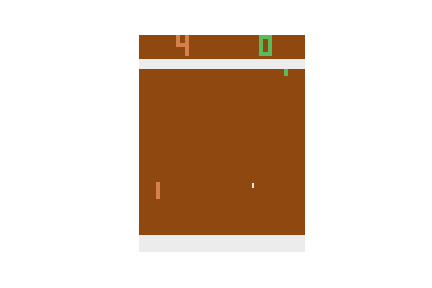
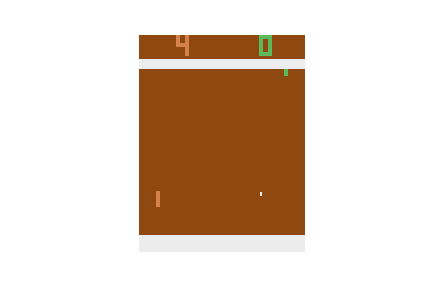
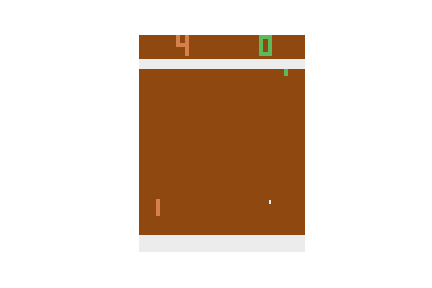
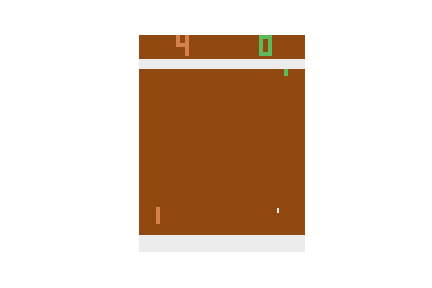
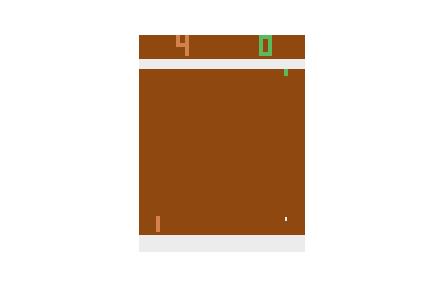
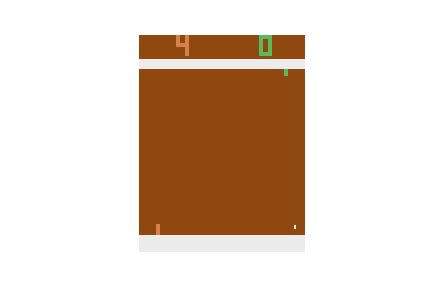
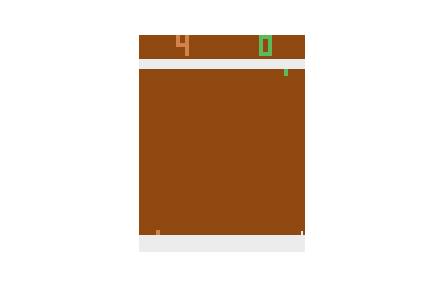
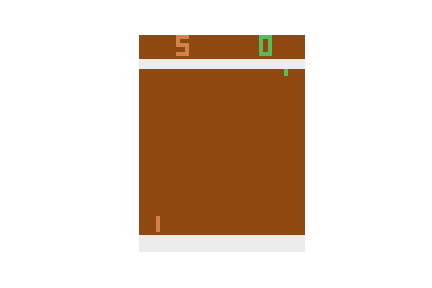
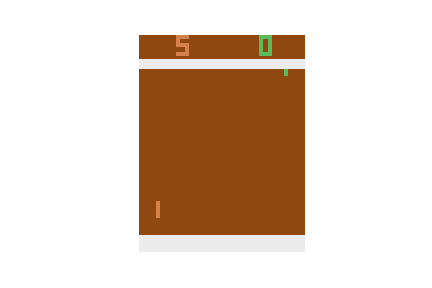
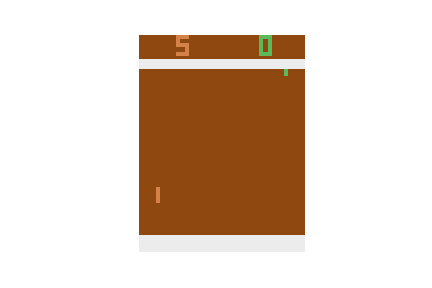

In [5]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=16, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

Process Process-5:
Process Process-13:
Process Process-1:
Process Process-10:
Process Process-7:
Process Process-6:
Process Process-12:
Process Process-14:
Process Process-9:
Process Process-4:
Process Process-8:
Process Process-15:
Process Process-3:
Process Process-11:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alex/miniconda3/envs/ping-pong/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/alex/miniconda3/envs/ping-pong/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/alex/miniconda3/envs/ping-pong/lib/python3.7/multiproces

In [8]:
import numpy as np
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
   
    
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(rewards*torch.log(new_probs) + beta*entropy)


Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(-7.0033e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [10]:
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 2000
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):
    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
#     L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

Episode: 20, score: -15.750000
[-17. -16. -16. -17. -17. -13. -14. -16.]


Episode: 40, score: -14.875000
[-15. -16. -17. -17. -12. -16. -13. -13.]


Episode: 60, score: -13.250000
[-12. -14. -16. -11. -16. -11. -10. -16.]


Episode: 80, score: -14.750000
[-16. -14. -16. -15. -12. -16. -16. -13.]


Episode: 100, score: -12.250000
[-12. -14.  -9. -11. -16. -12.  -9. -15.]


Episode: 120, score: -14.500000
[-13. -12. -13. -14. -16. -15. -17. -16.]


Episode: 140, score: -12.625000
[-11. -12.  -9. -16. -15. -14. -16.  -8.]


Episode: 160, score: -14.000000
[-11. -16.  -8. -16. -16. -16. -14. -15.]


Episode: 180, score: -14.625000
[-16. -14. -17. -14. -15. -15. -16. -10.]


Episode: 200, score: -14.750000
[-13. -16. -10. -16. -17. -14. -16. -16.]


Episode: 220, score: -12.750000
[-12. -16. -14. -11. -10. -16. -11. -12.]


Episode: 240, score: -14.375000
[-15. -16. -14. -14. -13. -14. -13. -16.]


Episode: 260, score: -14.000000
[-15. -16. -13. -14.  -8. -16. -14. -16.]


Episode: 280, score: -14.500000
[-14. -13. -16. -16. -15. -10. -17. -15.]


Episode: 300, score: -15.375000
[-16. -16. -17. -16. -15. -16. -16. -11.]


Episode: 320, score: -14.375000
[-14. -12. -16. -16. -16. -16. -14. -11.]


Episode: 340, score: -13.250000
[-13. -12. -13. -16. -11. -16.  -9. -16.]


Episode: 360, score: -14.375000
[-13. -15. -16. -16. -14. -15. -14. -12.]


Episode: 380, score: -12.625000
[-16. -11. -12.  -9. -12. -14. -13. -14.]


Episode: 400, score: -14.500000
[-15. -13. -14. -15. -12. -16. -16. -15.]


Episode: 420, score: -14.625000
[-11. -15. -15. -16. -16. -13. -17. -14.]


Episode: 440, score: -12.500000
[ -8. -14. -13. -13. -13. -13. -16. -10.]


Episode: 460, score: -13.750000
[-16. -11. -13. -16. -16. -12. -15. -11.]


Episode: 480, score: -14.750000
[-14. -13. -15. -16. -15. -14. -16. -15.]


Episode: 500, score: -14.125000
[ -9. -16. -16. -14. -13. -14. -15. -16.]


Episode: 520, score: -14.750000
[-16. -16. -13. -14. -16. -15. -14. -14.]


Episode: 540, score: -13.750000
[-12. -13. -14. -16. -10. -16. -13. -16.]


Episode: 560, score: -13.875000
[-13. -15. -16. -10. -10. -16. -17. -14.]


Episode: 580, score: -14.625000
[-11. -16. -14. -16. -14. -14. -16. -16.]


Episode: 600, score: -14.500000
[-16. -16. -15. -12. -14. -15. -13. -15.]


Episode: 620, score: -14.500000
[-16. -14. -13. -15. -16. -15. -13. -14.]


Episode: 640, score: -14.125000
[-13. -12. -13. -14. -16. -15. -15. -15.]


Episode: 660, score: -15.375000
[-16. -16. -15. -13. -16. -15. -16. -16.]


Episode: 680, score: -13.875000
[-11. -16. -15. -12. -16. -13. -13. -15.]


Episode: 700, score: -12.750000
[ -9. -15. -10. -15.  -7. -16. -16. -14.]


Episode: 720, score: -13.125000
[-15. -12. -16. -15. -12. -13. -14.  -8.]


Episode: 740, score: -12.875000
[-16. -13. -13. -10. -12. -13. -15. -11.]


Episode: 760, score: -12.125000
[-14.  -9. -13. -10. -12. -13. -16. -10.]


Episode: 780, score: -11.875000
[-11.  -9. -12. -12. -15. -13. -12. -11.]


Episode: 800, score: -11.500000
[-11.  -9.  -8. -16. -11. -11. -13. -13.]


Episode: 820, score: -12.375000
[-12. -10. -12. -16. -12. -12. -12. -13.]


Episode: 840, score: -13.500000
[-12. -14. -11. -13. -15. -14. -15. -14.]


Episode: 860, score: -12.125000
[-10. -13. -12. -13. -10. -15. -15.  -9.]


Episode: 880, score: -12.375000
[-13. -16. -12. -13. -13.  -8. -12. -12.]


Episode: 900, score: -8.750000
[-13.  -5. -13. -11.  -8.  -8.  -9.  -3.]


Episode: 920, score: -10.375000
[-14. -12. -10.  -8. -12. -10.  -8.  -9.]


Episode: 940, score: -11.500000
[-10.  -8. -13. -16. -12. -11. -11. -11.]


Episode: 960, score: -12.125000
[-12.  -9. -10. -13. -15. -12. -12. -14.]


Episode: 980, score: -11.875000
[-11.  -8. -11. -13. -14. -13. -12. -13.]


Episode: 1000, score: -12.000000
[-12. -13. -11.  -9. -13. -12. -14. -12.]


Episode: 1020, score: -10.375000
[-10. -13. -11. -11. -11.  -5. -12. -10.]


Episode: 1040, score: -10.875000
[-10. -13.  -4. -15. -11. -14. -13.  -7.]


Episode: 1060, score: -11.875000
[-15. -15. -10.  -6. -11. -13. -15. -10.]


Episode: 1080, score: -11.750000
[-11. -16. -12. -14. -15.  -8. -14.  -4.]


Episode: 1100, score: -12.750000
[-13.  -9. -13. -13. -16. -11. -14. -13.]


Episode: 1120, score: -11.375000
[-12. -13.  -3. -10. -13. -14. -12. -14.]


Episode: 1140, score: -12.375000
[ -8. -12. -13. -11. -14. -15. -10. -16.]


Episode: 1160, score: -12.625000
[-13. -12. -13. -15. -12. -12. -12. -12.]


Episode: 1180, score: -12.125000
[-12. -10. -15. -14. -13. -12.  -8. -13.]


Episode: 1200, score: -11.000000
[-13.  -8. -13. -13. -14.  -7.  -7. -13.]


Episode: 1220, score: -10.250000
[ -8. -13.  -9.  -9. -10. -13. -11.  -9.]


Episode: 1240, score: -11.000000
[-14. -10.  -9. -13. -11. -10.  -7. -14.]


Episode: 1260, score: -11.125000
[-13.  -9. -12. -15. -14.  -2. -11. -13.]


Episode: 1280, score: -12.750000
[-12. -13. -16. -13. -14. -12.  -8. -14.]


Episode: 1300, score: -11.000000
[ -6. -14. -11.  -9. -12.  -9. -14. -13.]


Episode: 1320, score: -11.625000
[-14. -14. -11. -11.  -7. -11. -11. -14.]


Episode: 1340, score: -12.000000
[ -7. -11. -12. -12. -13. -13. -14. -14.]


Episode: 1360, score: -10.625000
[-13.  -9.  -9. -13. -12.  -5. -14. -10.]


Episode: 1380, score: -10.625000
[-12. -11. -16.  -9.  -7.  -8. -13.  -9.]


Episode: 1400, score: -10.250000
[-13.  -9. -11.  -9. -14.  -6.  -8. -12.]


Episode: 1420, score: -9.375000
[ -6. -10. -11. -11.  -6.  -9.  -6. -16.]


Episode: 1440, score: -10.375000
[-12. -11. -11. -11.  -9. -14.  -6.  -9.]


Episode: 1460, score: -9.750000
[ -6. -12. -10.  -8. -12.  -9. -12.  -9.]


Episode: 1480, score: -7.875000
[ -9.  -7.  -6.  -6.  -6.  -7. -12. -10.]


Episode: 1500, score: -9.625000
[ -6. -12.  -9.  -9.  -7. -10. -12. -12.]


Episode: 1520, score: -9.000000
[-10. -10. -11.  -8.  -9.  -6. -10.  -8.]


Episode: 1540, score: -9.375000
[-12.  -8. -11. -10. -12.  -2. -10. -10.]


Episode: 1560, score: -9.125000
[ -4.  -9. -12.  -7. -11. -13. -10.  -7.]


Episode: 1580, score: -7.250000
[ -8. -12.  -4.  -5.  -6.  -6. -12.  -5.]


Episode: 1600, score: -6.875000
[ -4. -10. -12.  -3.  -7.  -3.  -6. -10.]


Episode: 1620, score: -5.625000
[ -2.  -8.  -6.  -9.  -3. -10.  -3.  -4.]


Episode: 1640, score: -7.500000
[ -5. -12.  -1. -12.  -1.  -9. -15.  -5.]


Episode: 1660, score: -4.375000
[-2. -4. -6. -6. -6. -5. -3. -3.]


Episode: 1680, score: -4.250000
[-6. -4. -2. -7. -1. -7. -6. -1.]


Episode: 1700, score: -3.375000
[-5. -4. -2. -1. -4. -3. -7. -1.]


Episode: 1720, score: -2.250000
[-1. -2. -3. -3. -1. -1. -4. -3.]


Episode: 1740, score: -4.250000
[ -1.  -3.  -2. -10.  -8.  -8.  -1.  -1.]


Episode: 1760, score: -1.250000
[-1. -1. -1. -1. -1. -1. -3. -1.]


Episode: 1780, score: -3.875000
[-6. -3. -1. -1. -6. -9. -1. -4.]


Episode: 1800, score: -4.625000
[ -1. -10. -10.  -5.  -1.  -8.  -1.  -1.]


Episode: 1820, score: -2.000000
[-4. -2. -2. -1. -1. -4. -1. -1.]


Episode: 1840, score: -1.375000
[ 1. -1. -5. -1. -1. -1. -1. -2.]


Episode: 1860, score: -4.125000
[-14.  -3.  -1.  -2.  -1.  -8.  -1.  -3.]


Episode: 1880, score: -1.625000
[-1. -1. -1. -1. -1. -6. -1. -1.]


Episode: 1900, score: -2.125000
[ -1. -11.  -1.  -1.  -1.   0.  -1.  -1.]


Episode: 1920, score: -2.500000
[ -1.  -1.  -1.  -1.  -1.  -3. -11.  -1.]


Episode: 1940, score: -1.500000
[-1. -1. -3. -1. -1. -1. -1. -3.]


Episode: 1960, score: -1.750000
[-1. -1. -1. -4. -1. -1. -4. -1.]


Episode: 1980, score: -2.500000
[ -1.  -1.  -1.  -1.  -3.  -1.  -1. -11.]


Episode: 2000, score: -0.750000
[ 1. -1. -1. -1. -1. -1. -1. -1.]



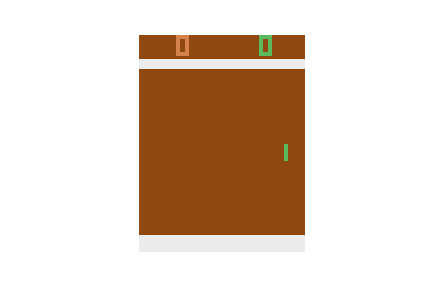
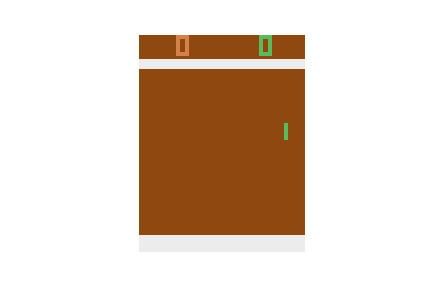
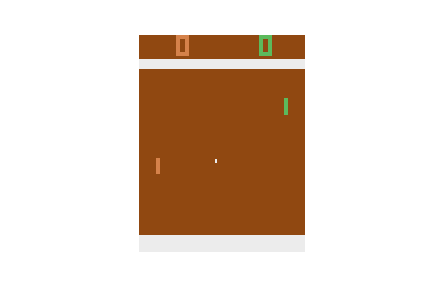
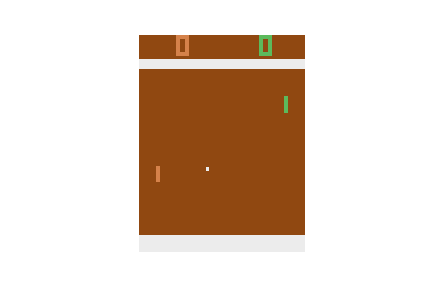
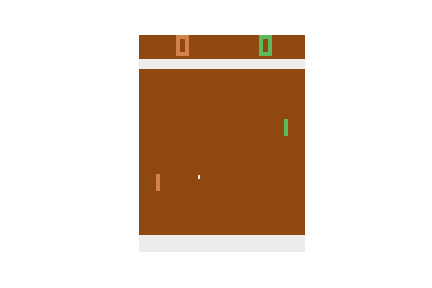
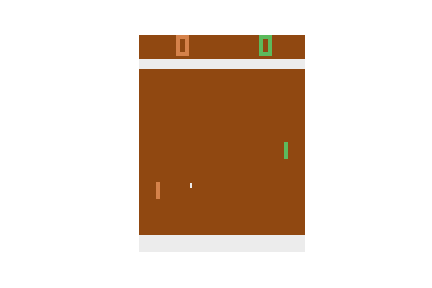
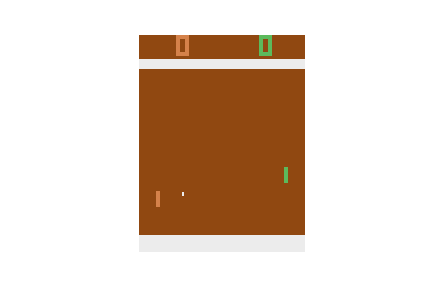
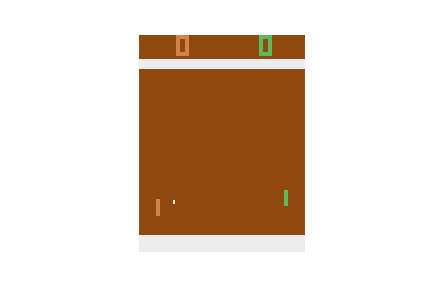
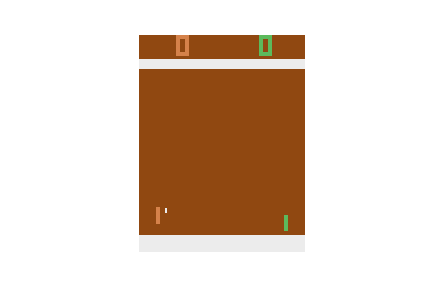
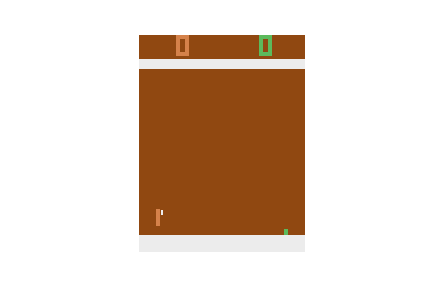
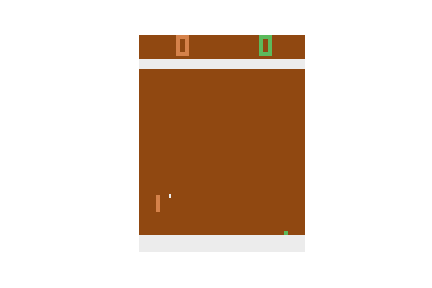
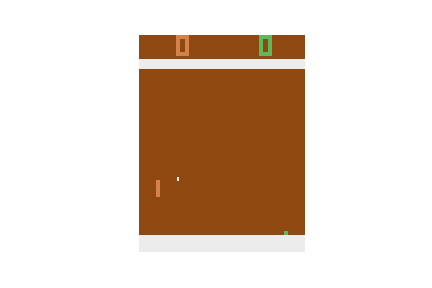
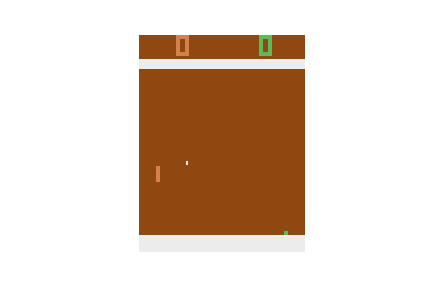
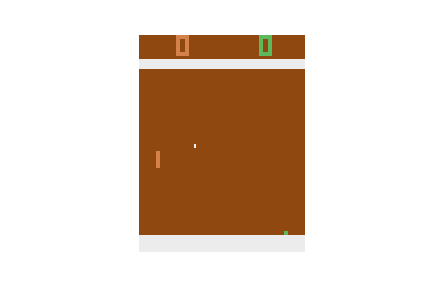
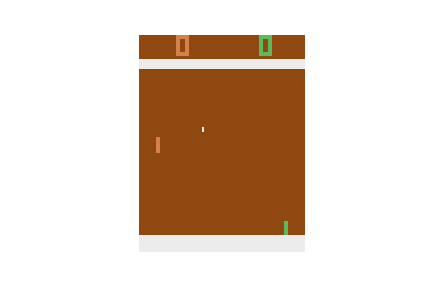
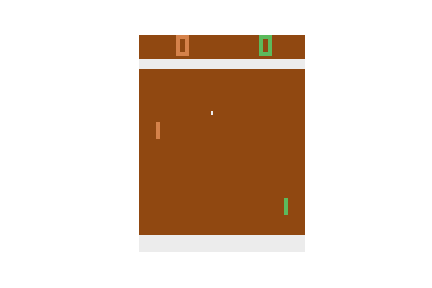
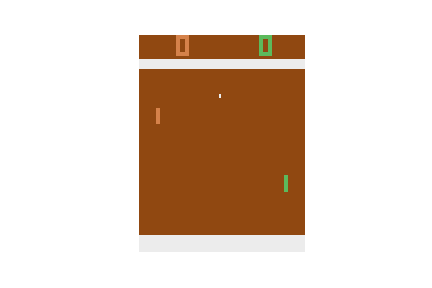
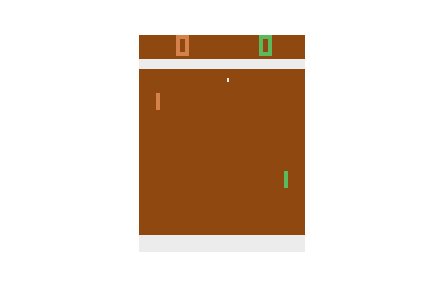
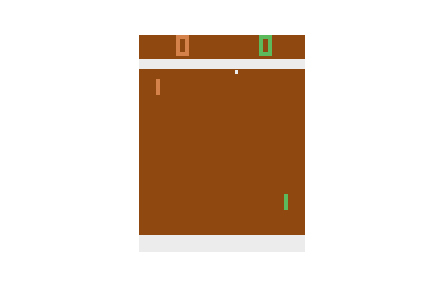
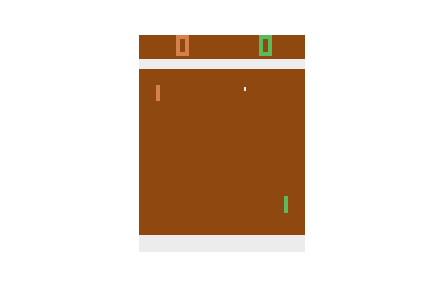
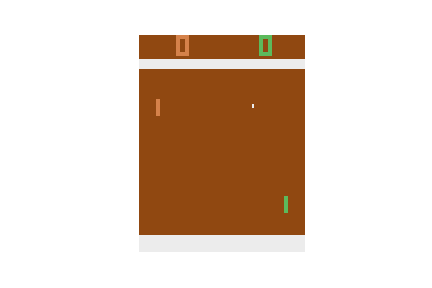
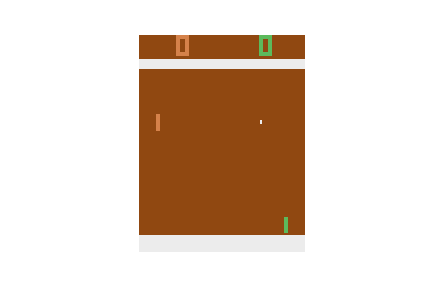
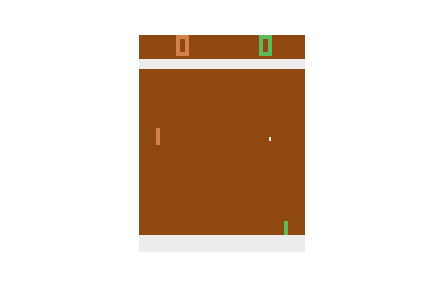
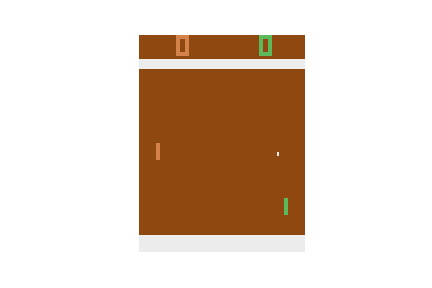
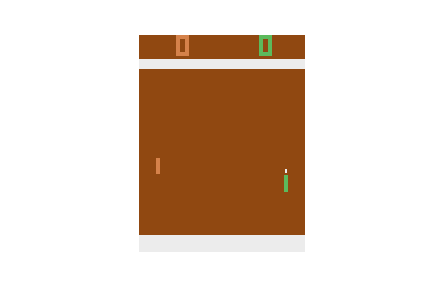
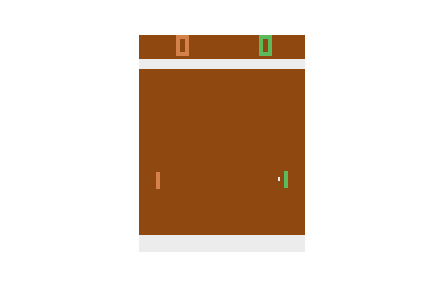
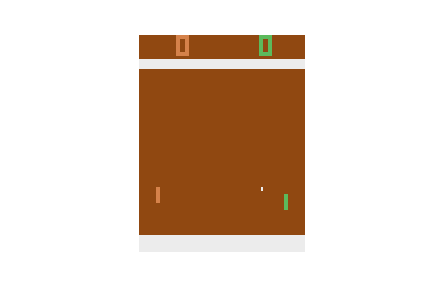
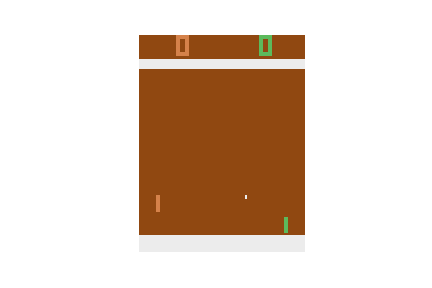
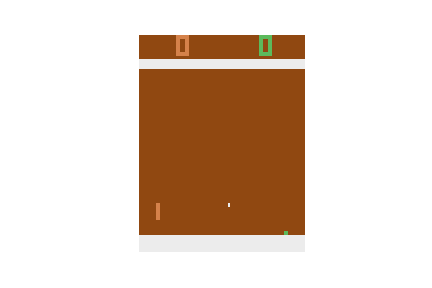
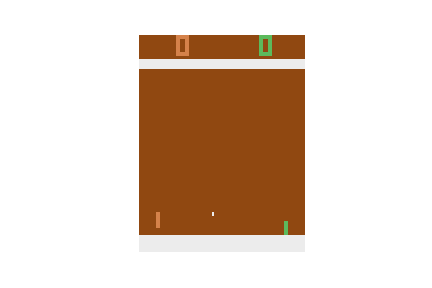
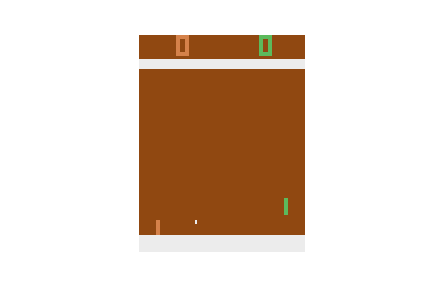
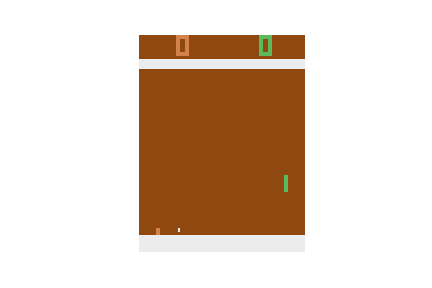
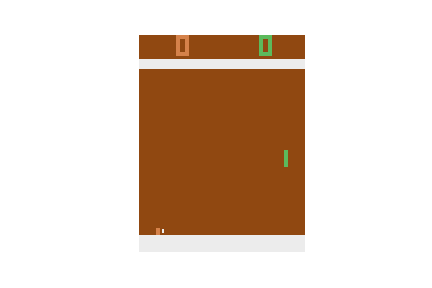
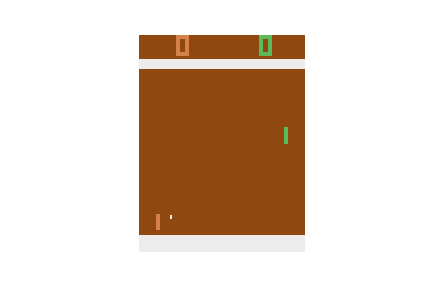
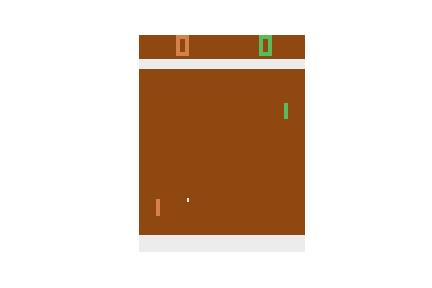
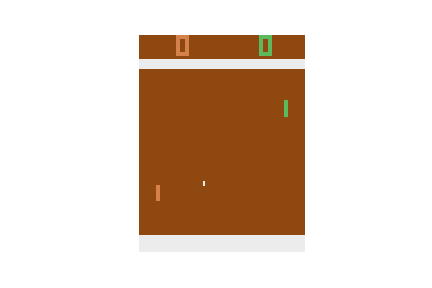
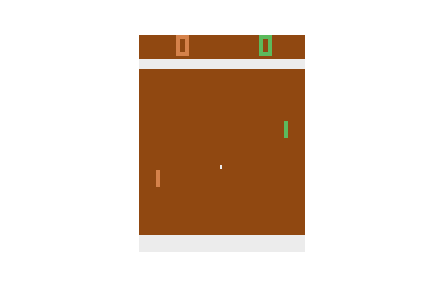
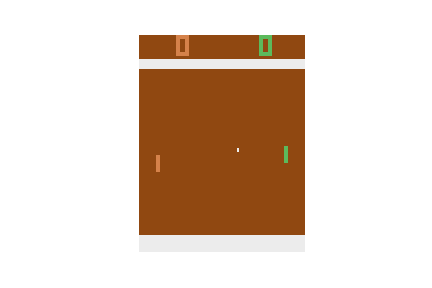
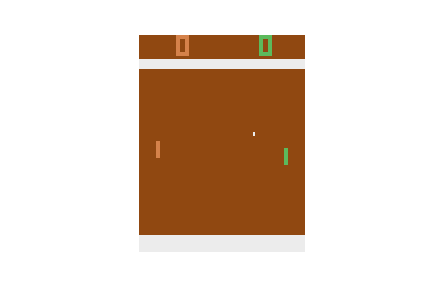
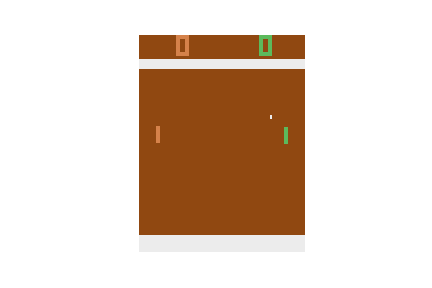
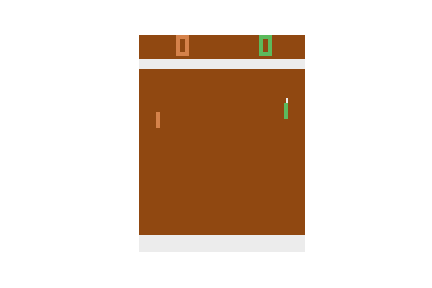
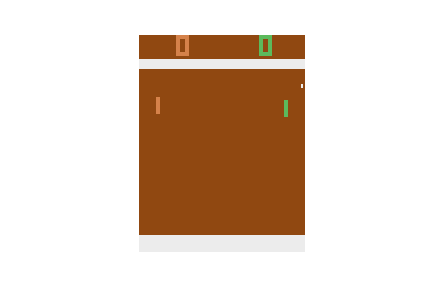
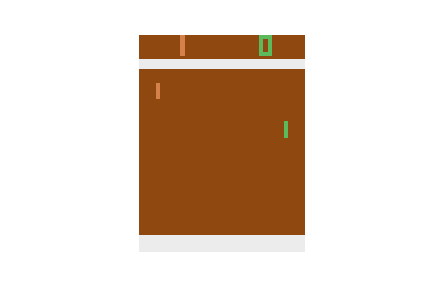
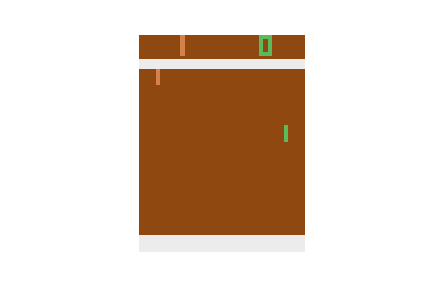
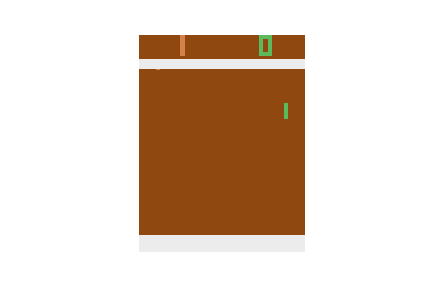
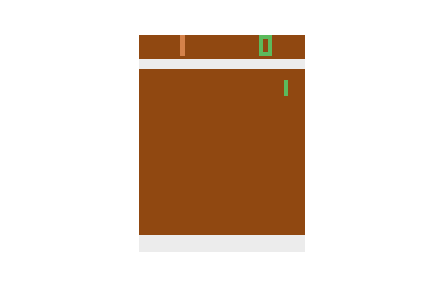
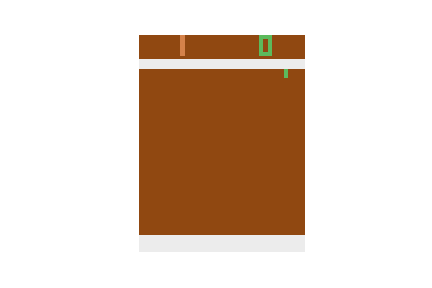
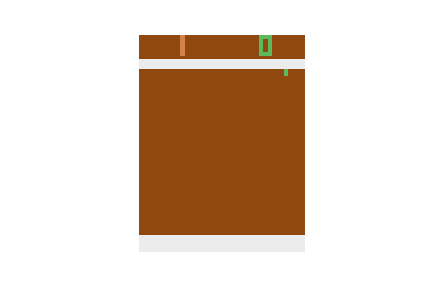
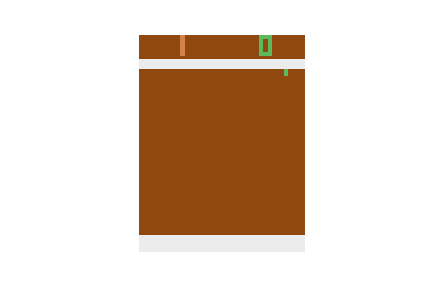
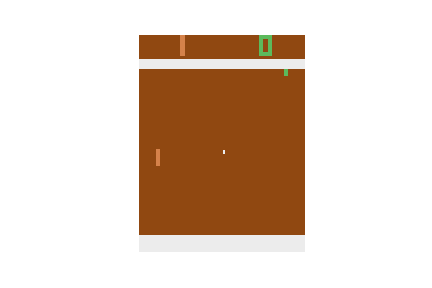
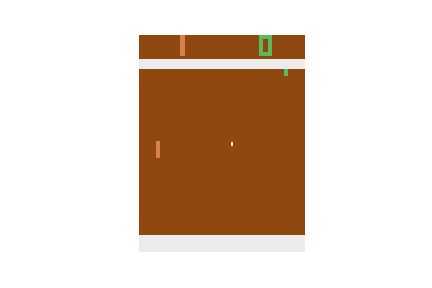
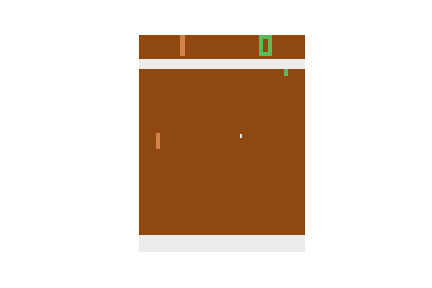
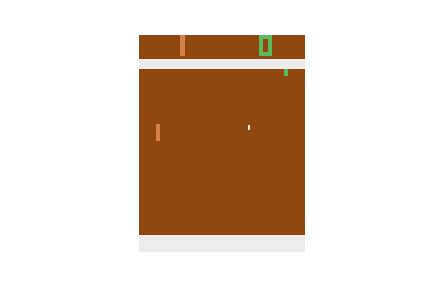
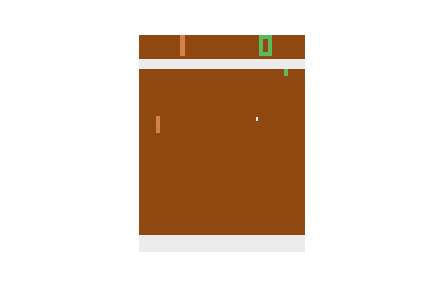
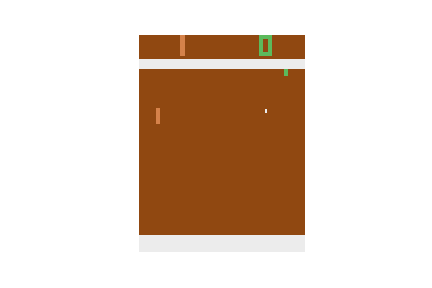
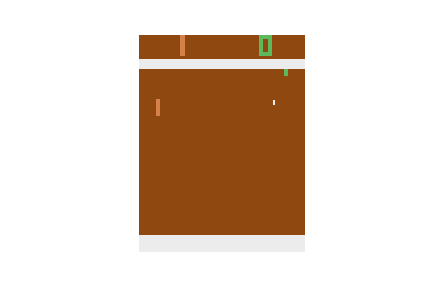
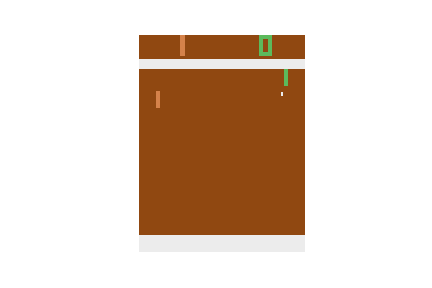
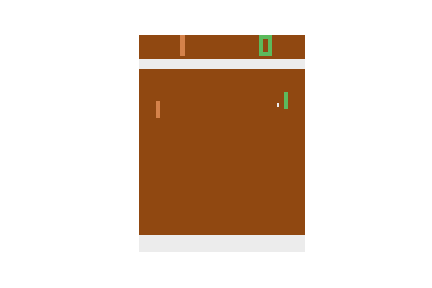
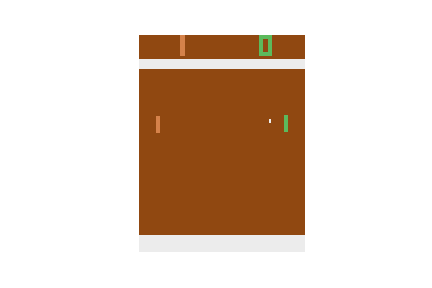
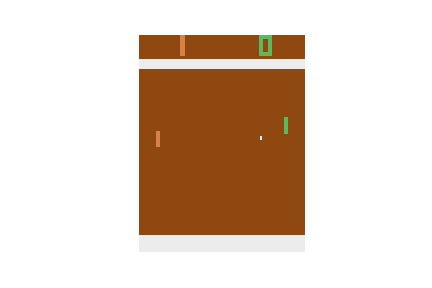
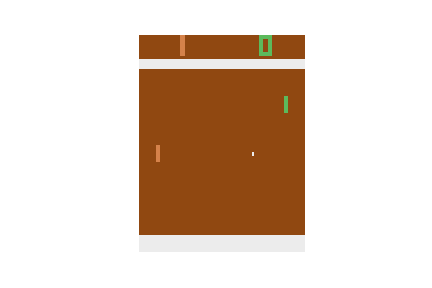
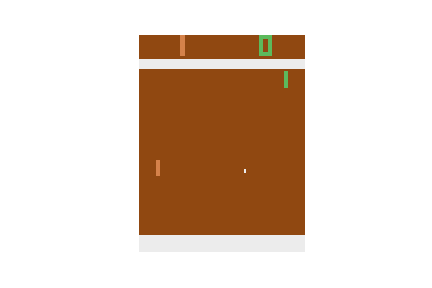
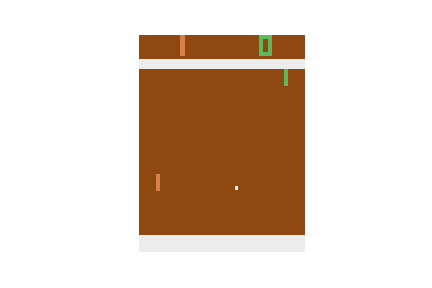
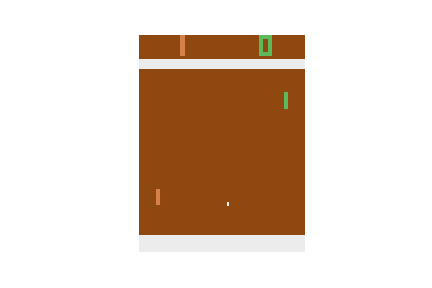
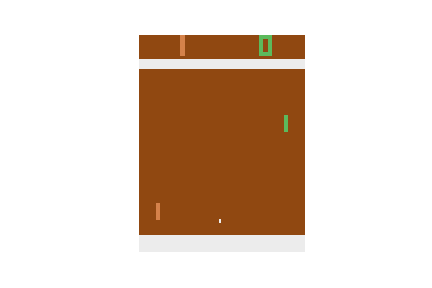
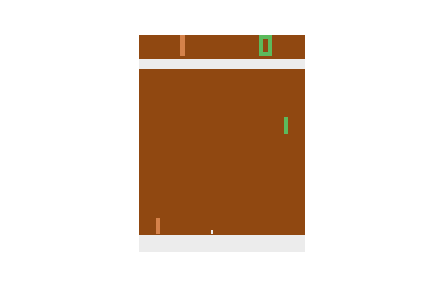
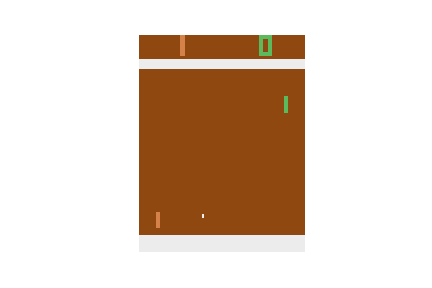
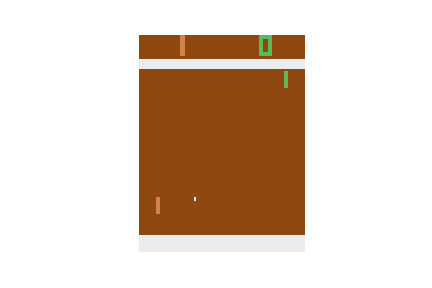
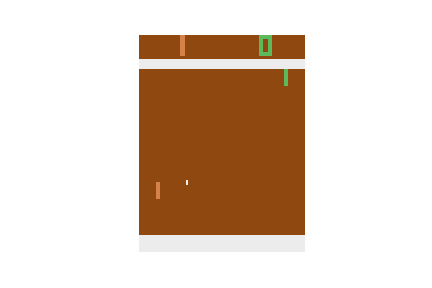
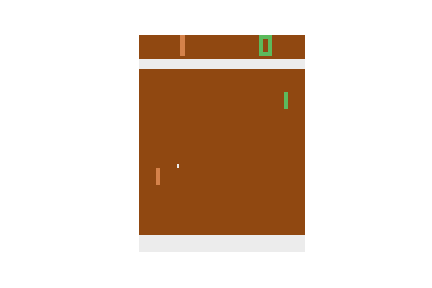
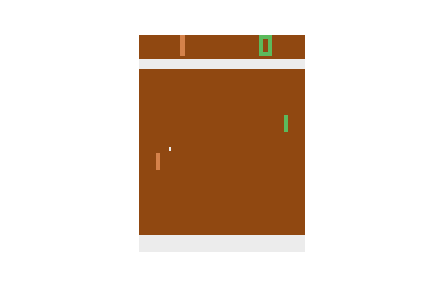
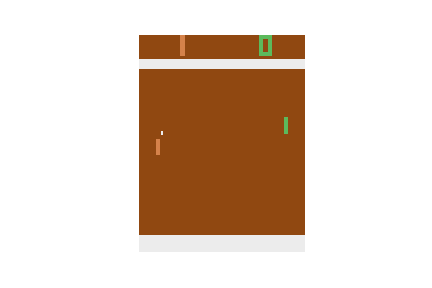
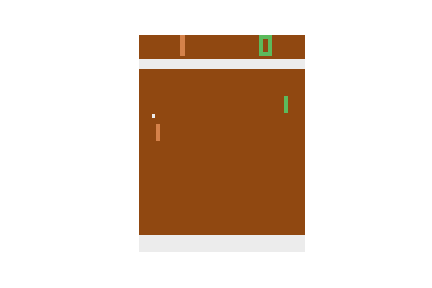
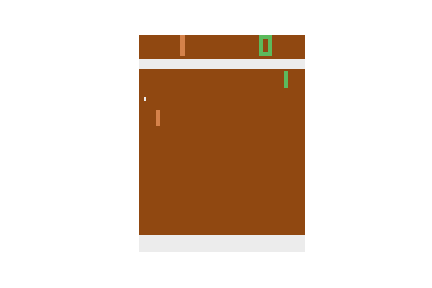
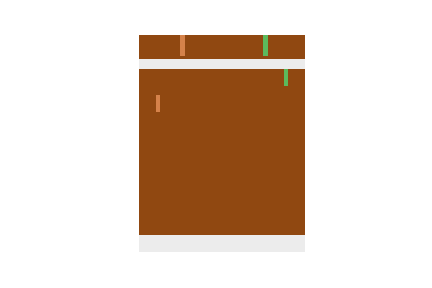
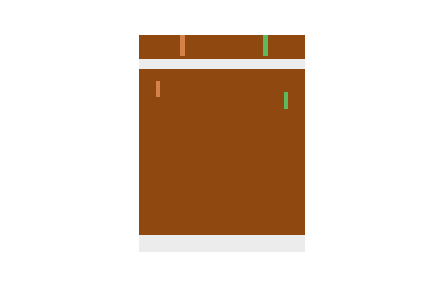
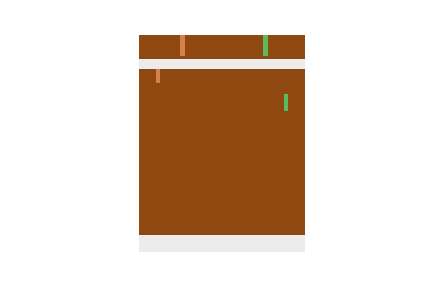
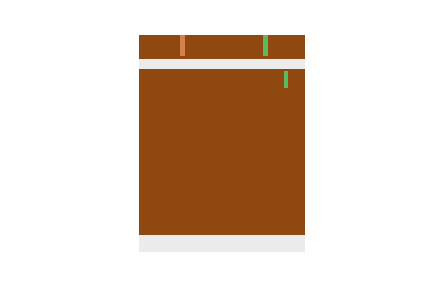
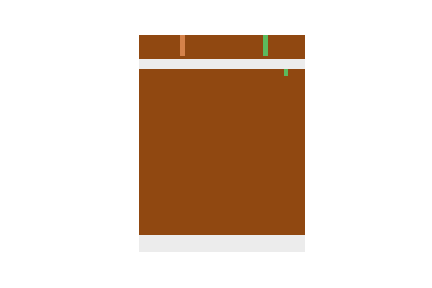
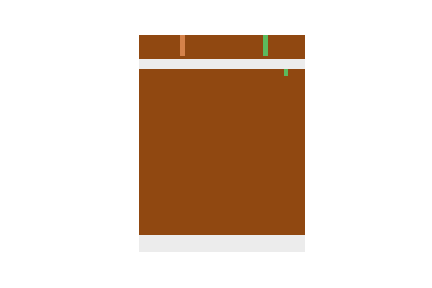
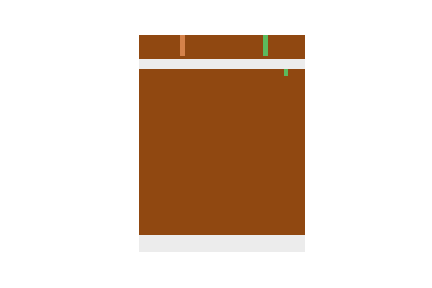
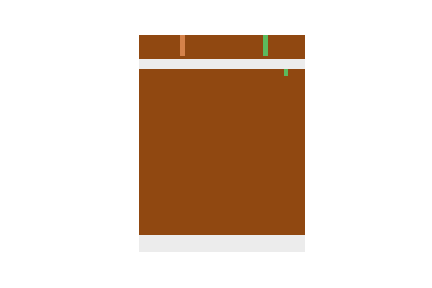
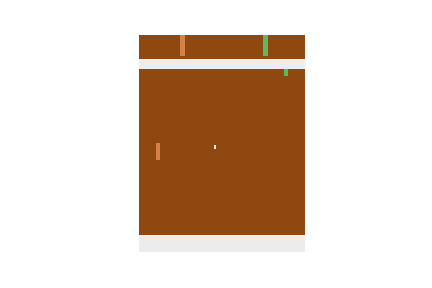
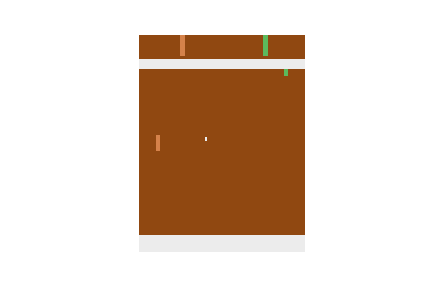
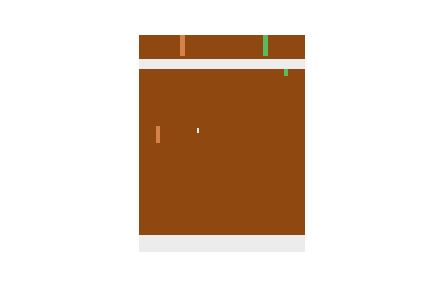
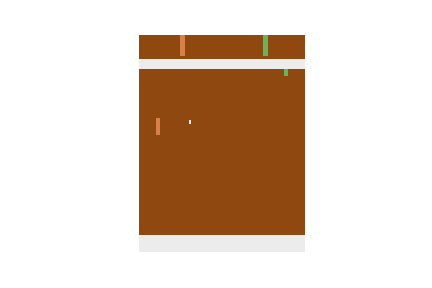
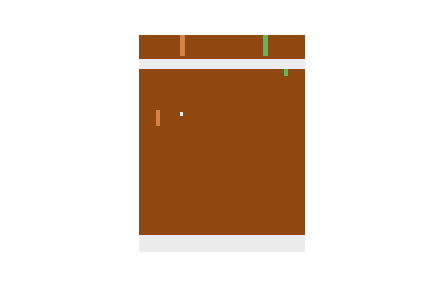
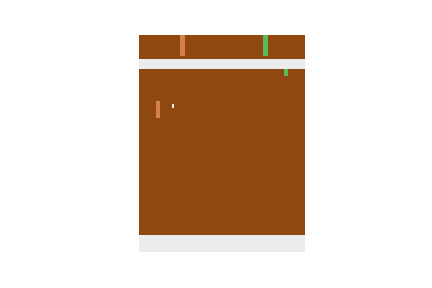
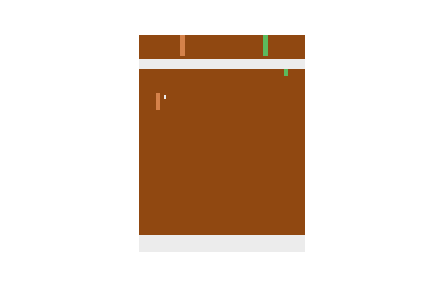
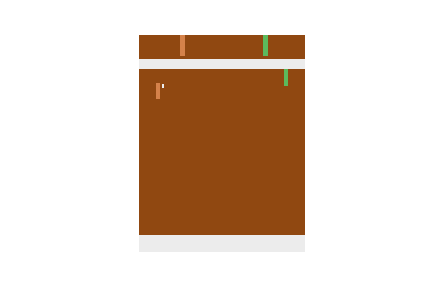
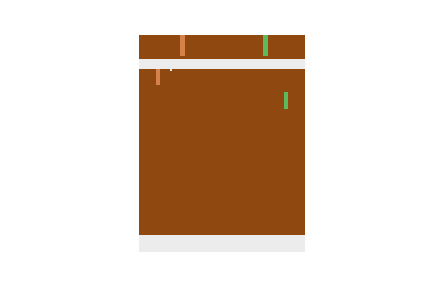
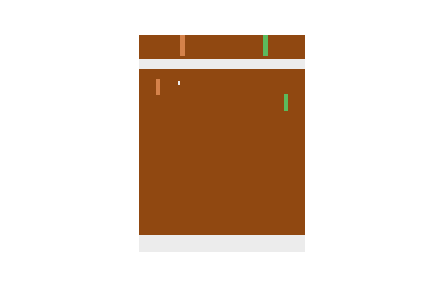
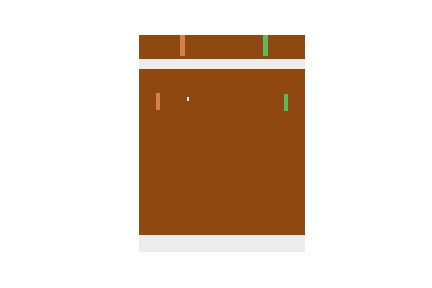
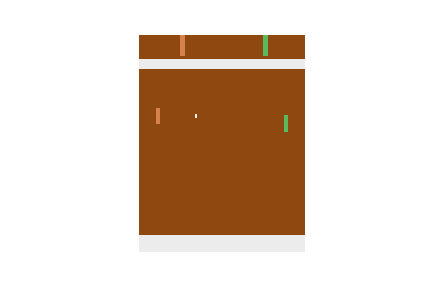
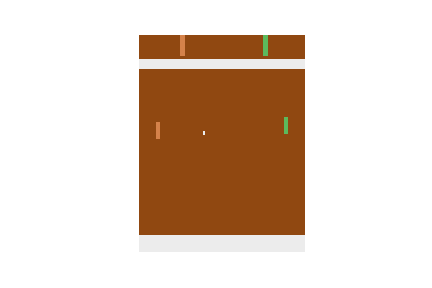
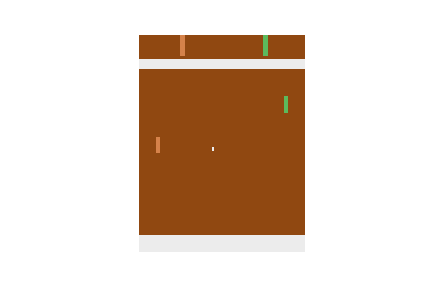
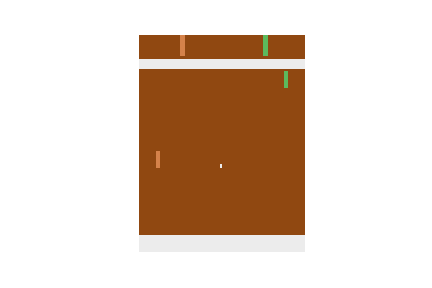
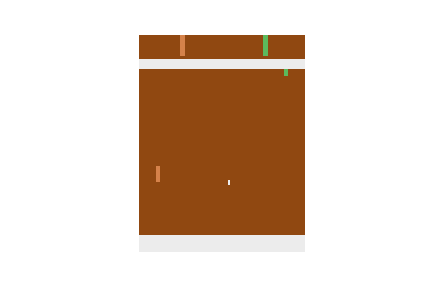
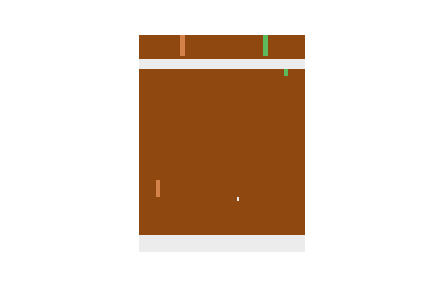
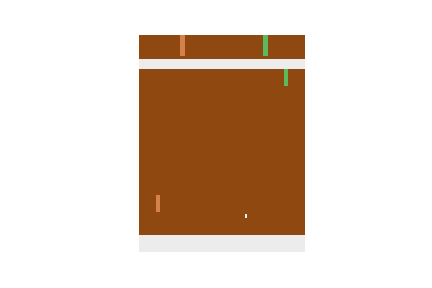
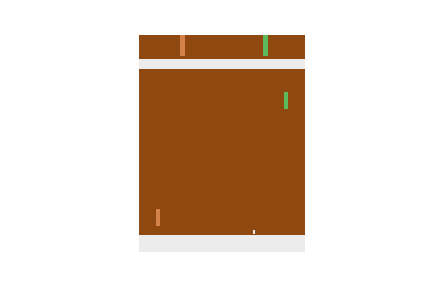
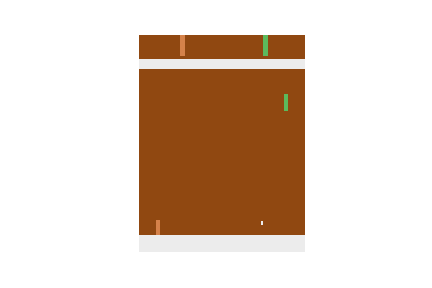
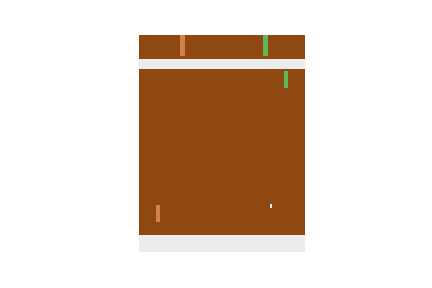
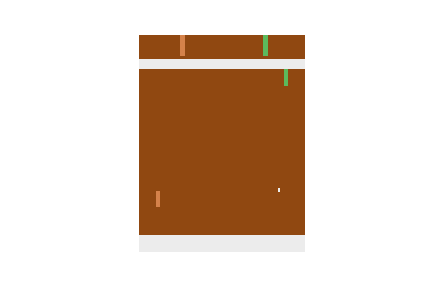
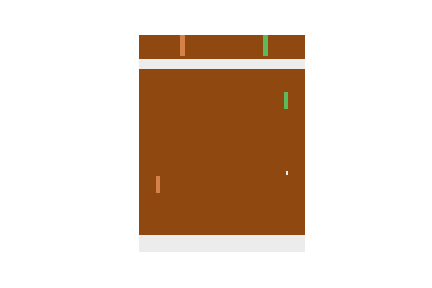
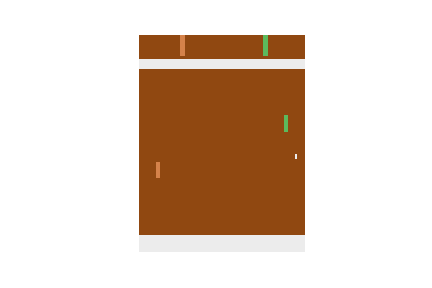
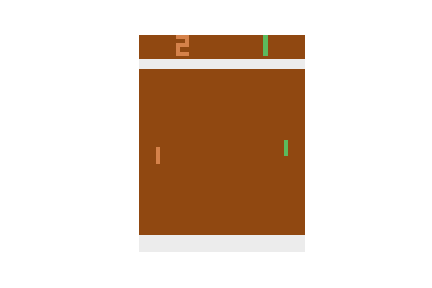
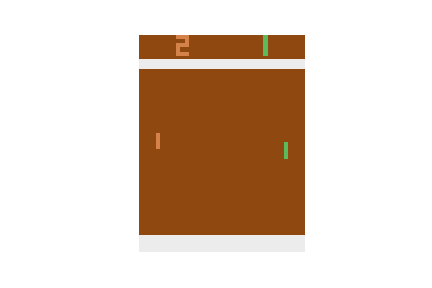
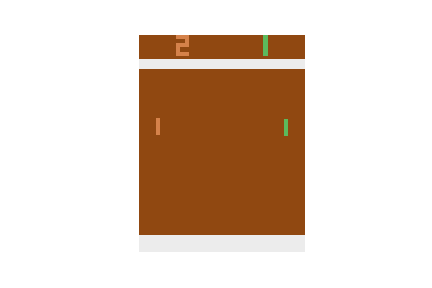
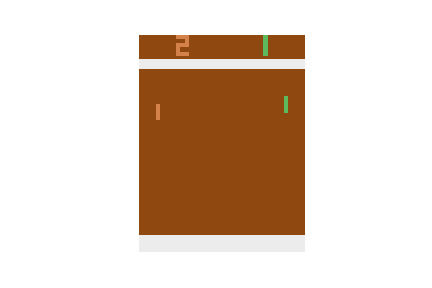
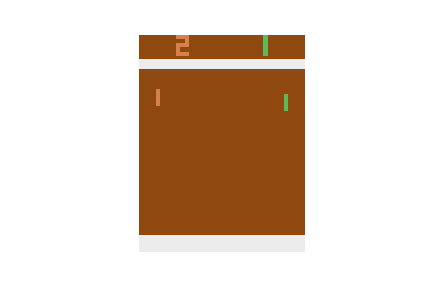
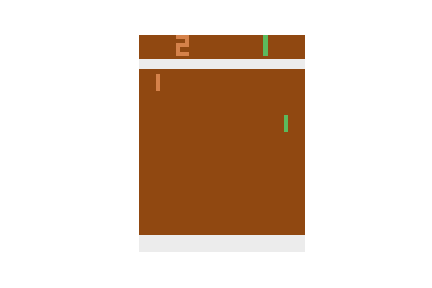
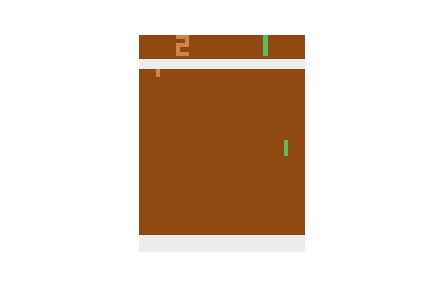
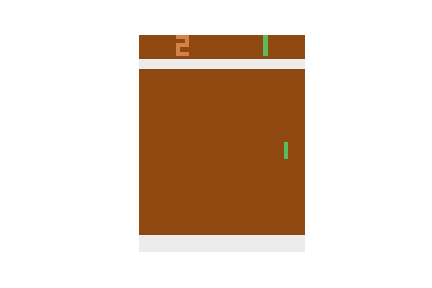
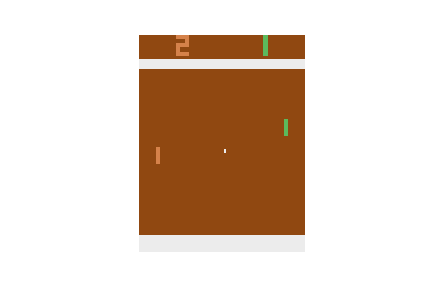
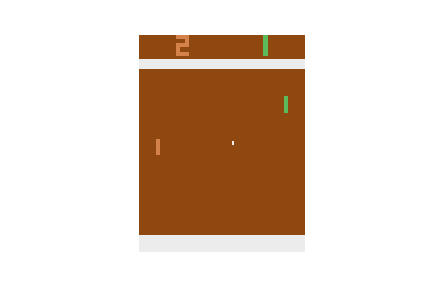
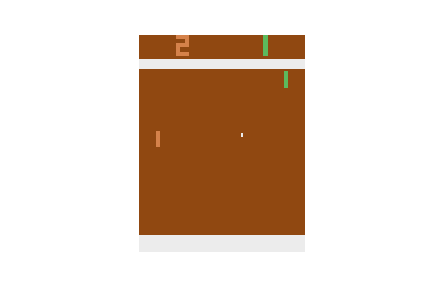
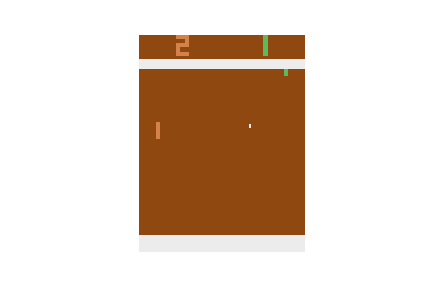
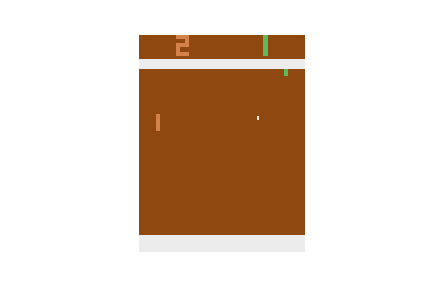
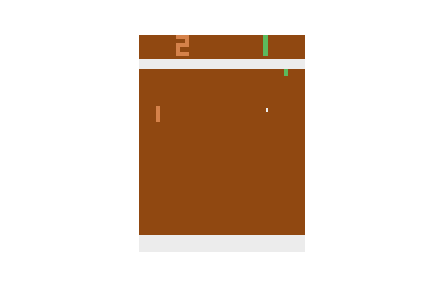
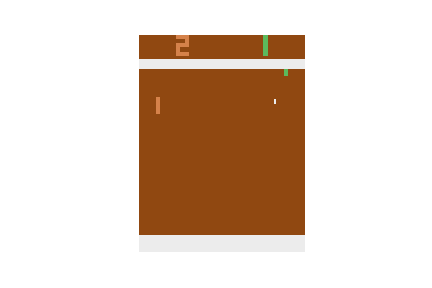
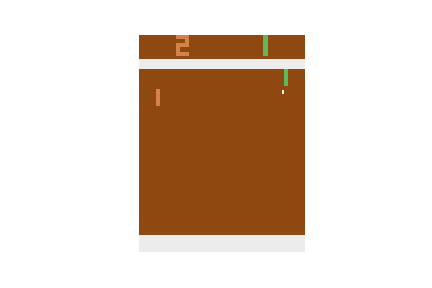
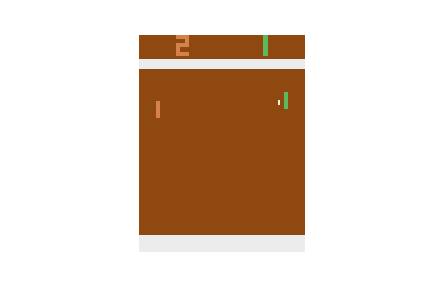
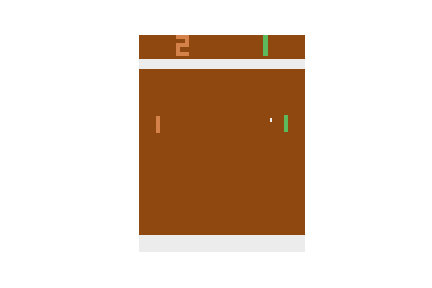
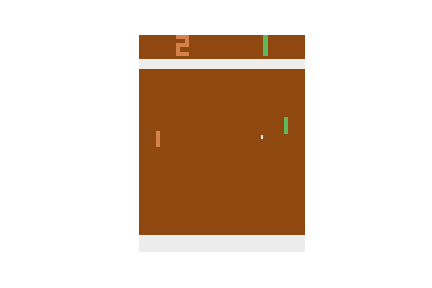
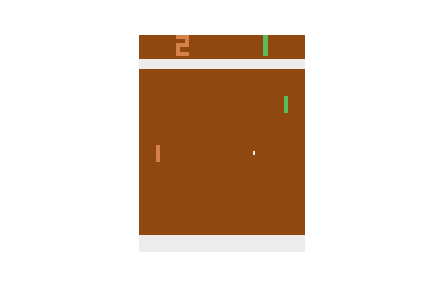
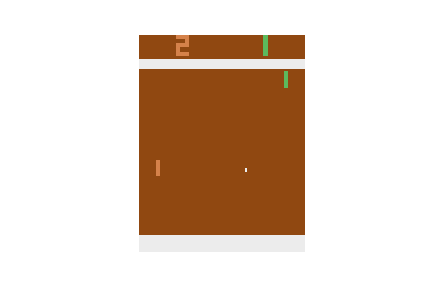
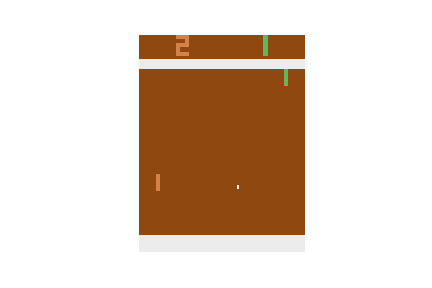
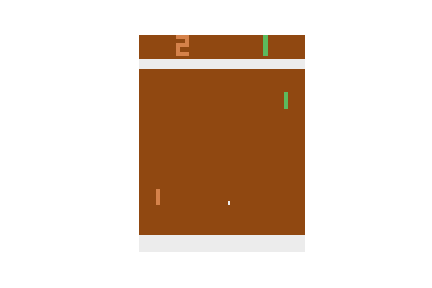
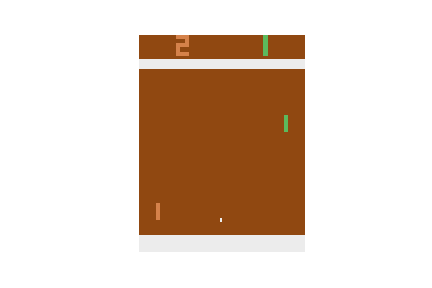
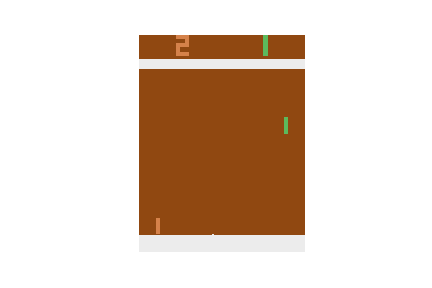
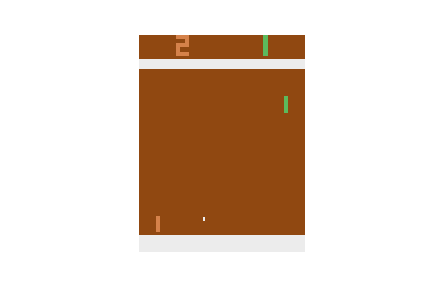
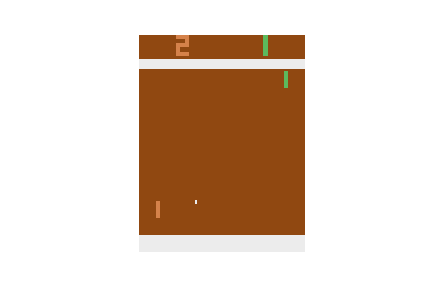
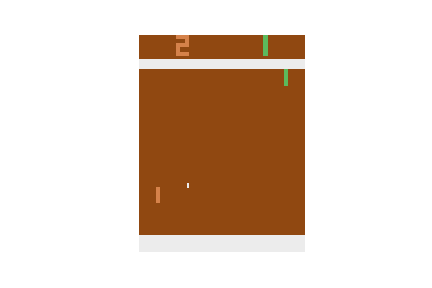
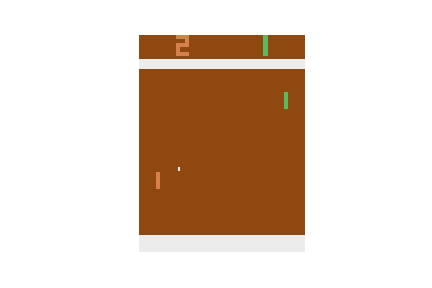
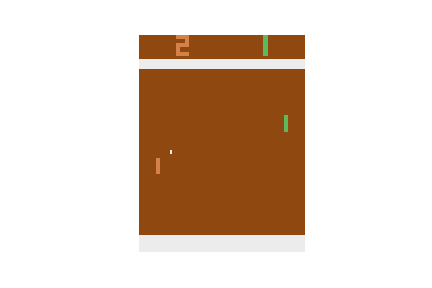
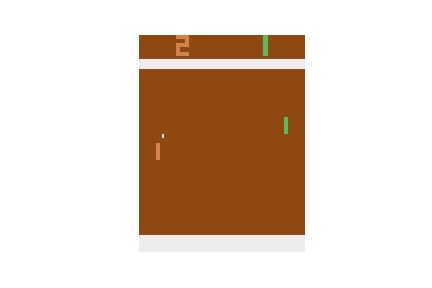
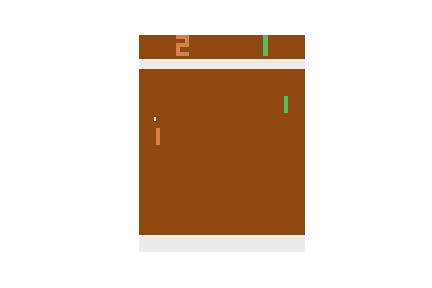
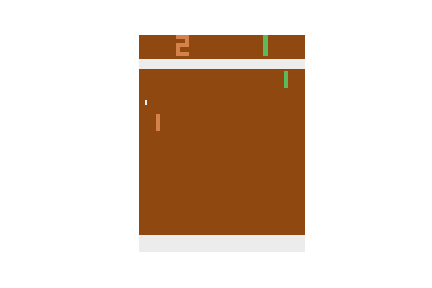
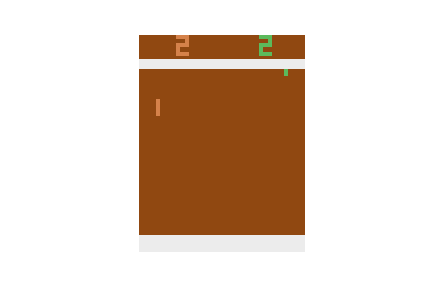
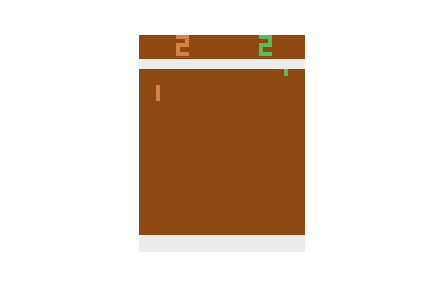
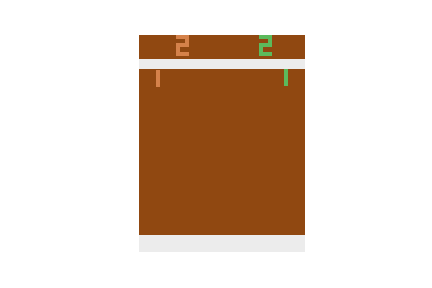
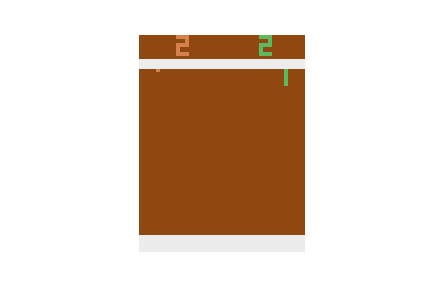
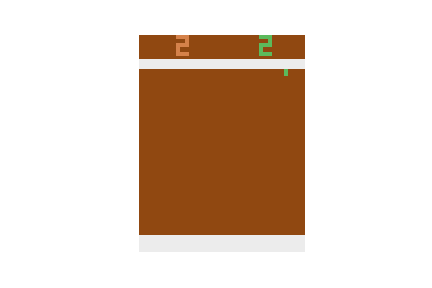
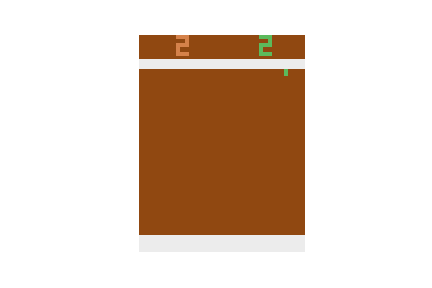
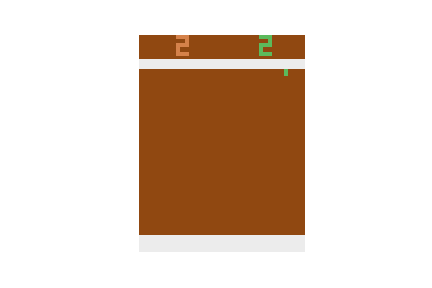
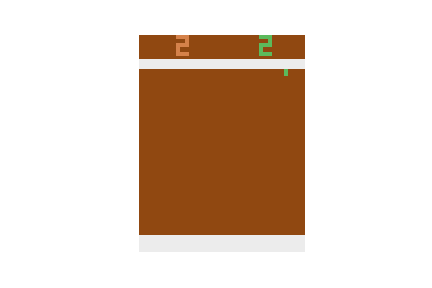
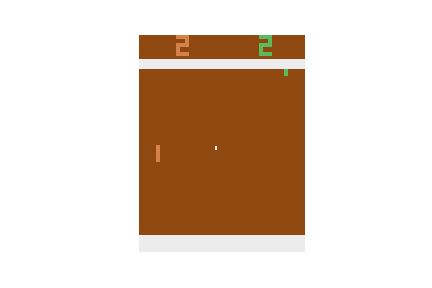
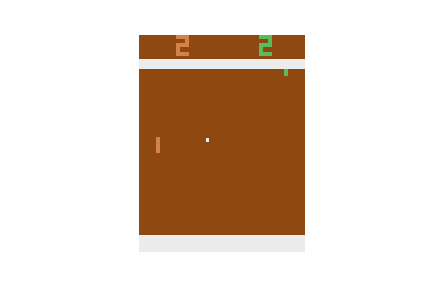
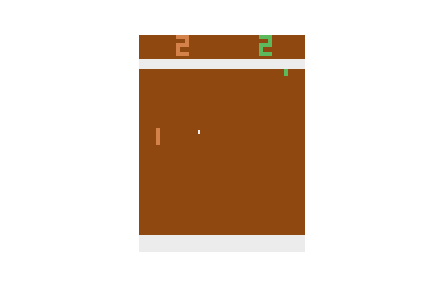
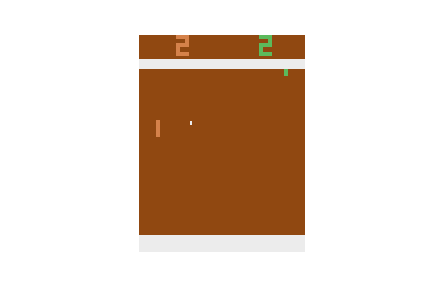
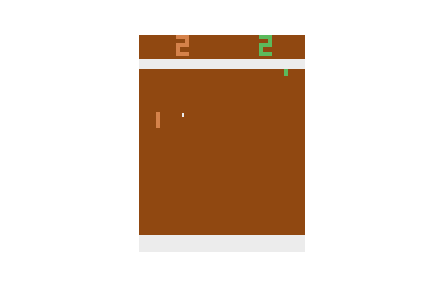
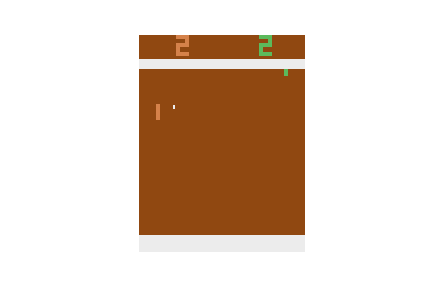
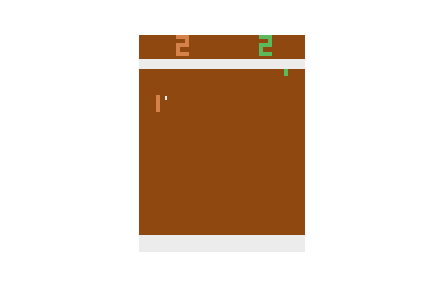
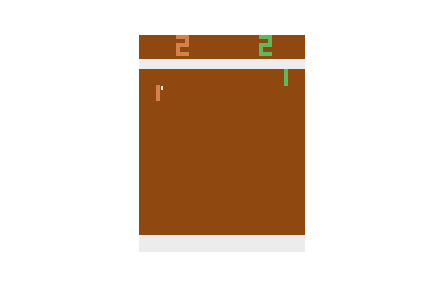
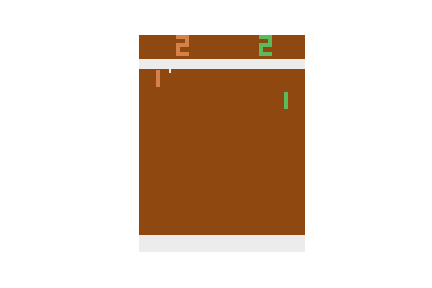
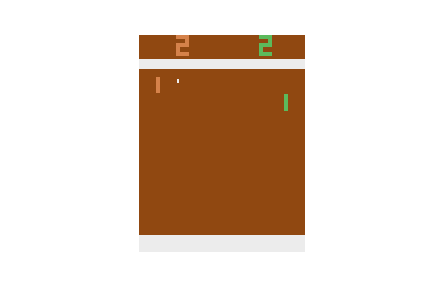
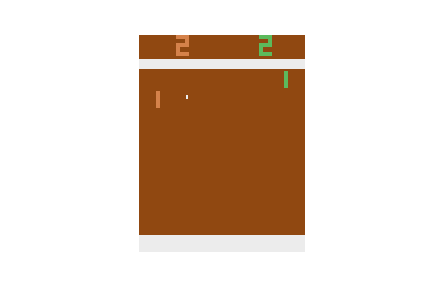
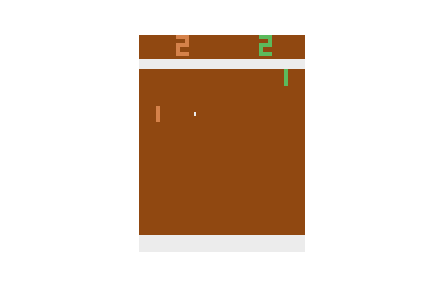
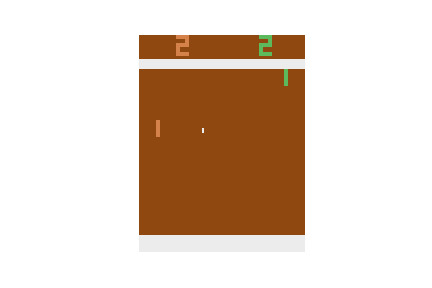
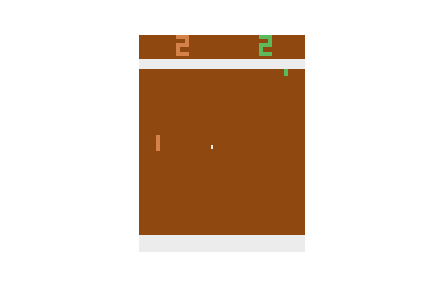
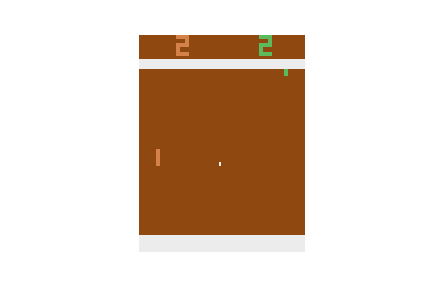
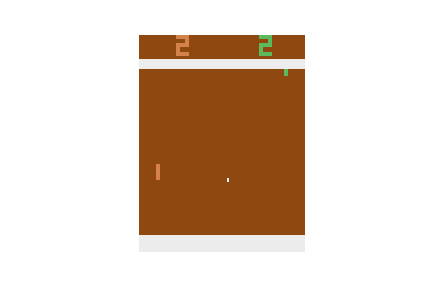
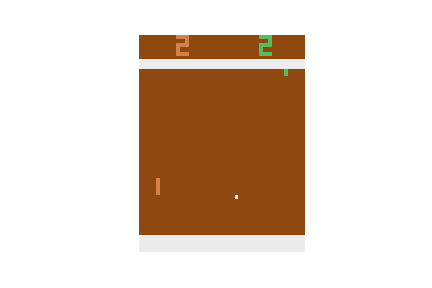
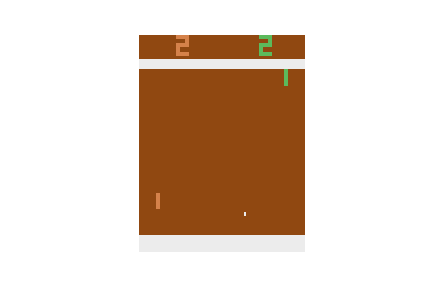
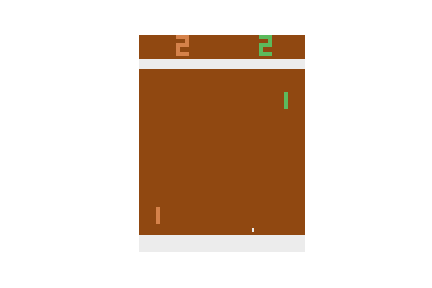
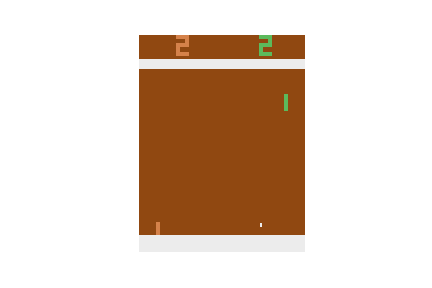
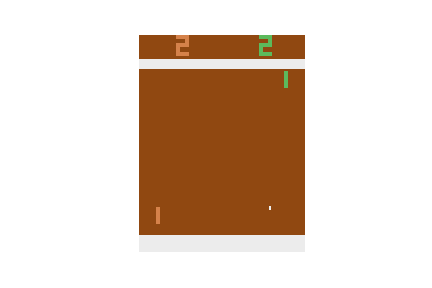
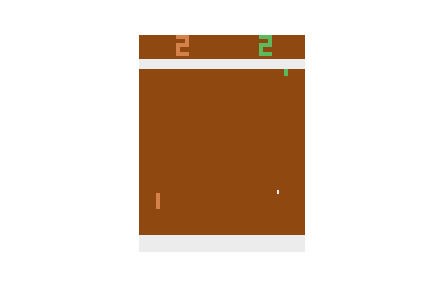
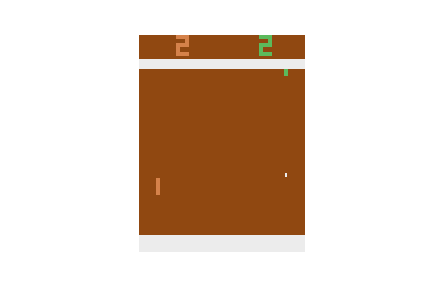
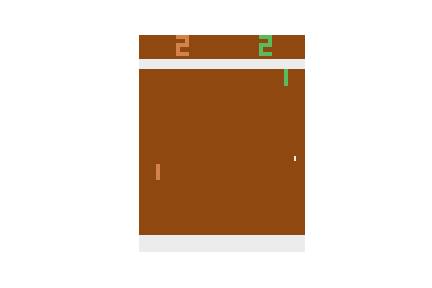
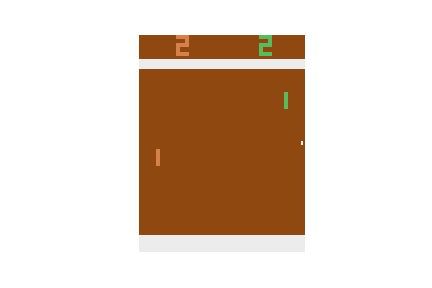
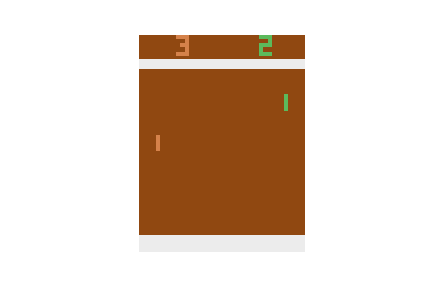
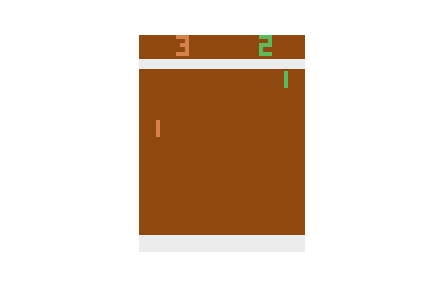
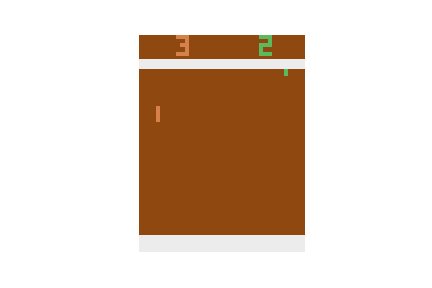
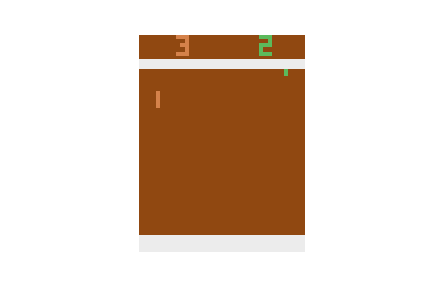
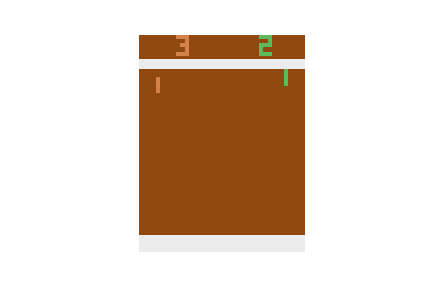
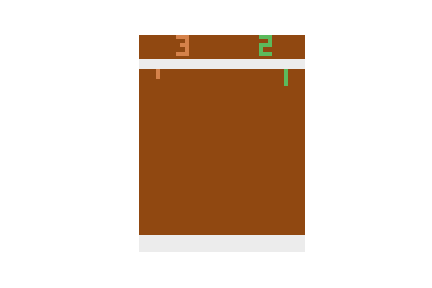
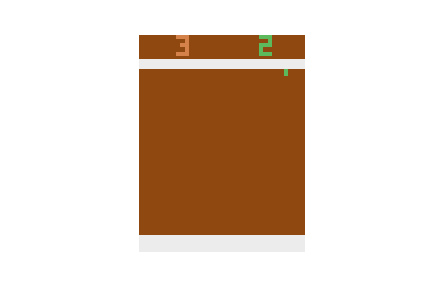
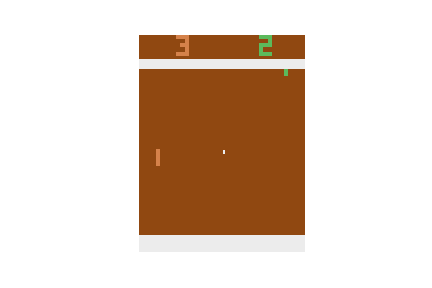
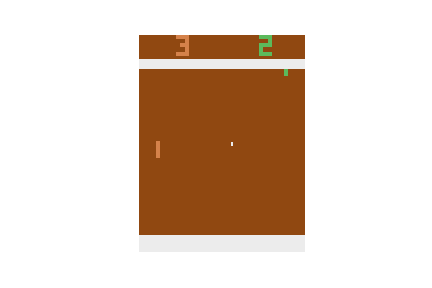
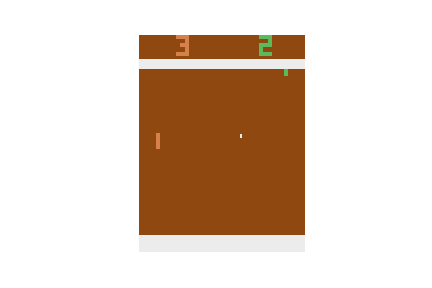
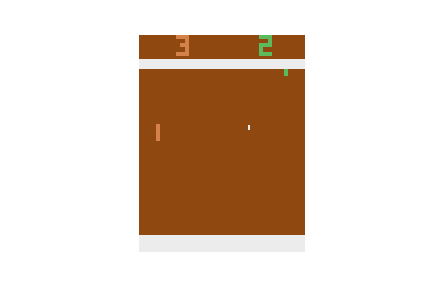
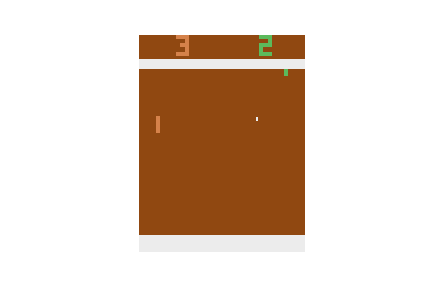
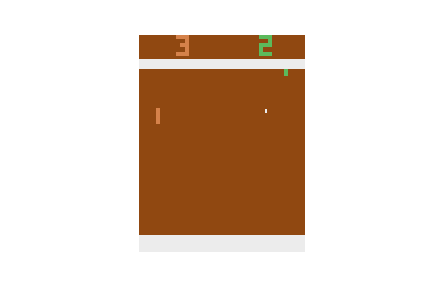
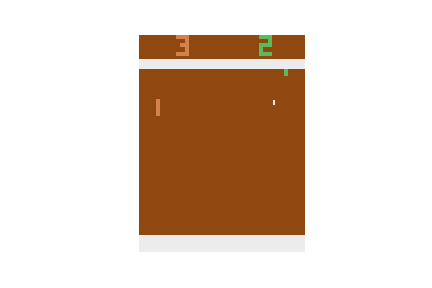
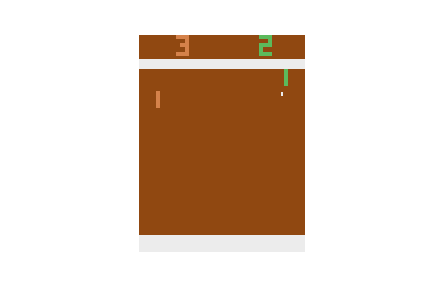
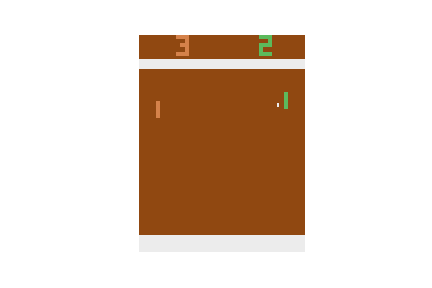
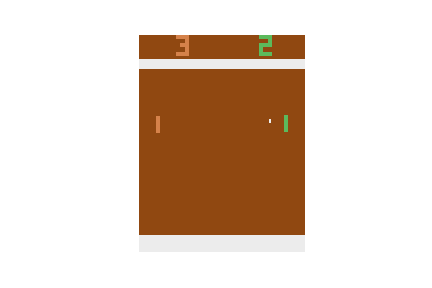
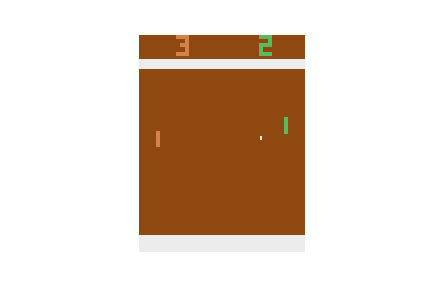
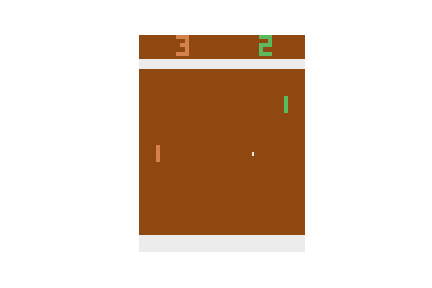
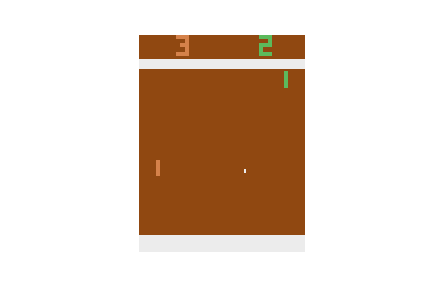
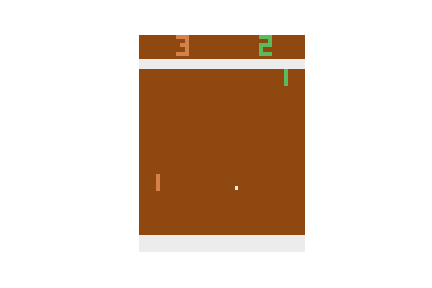
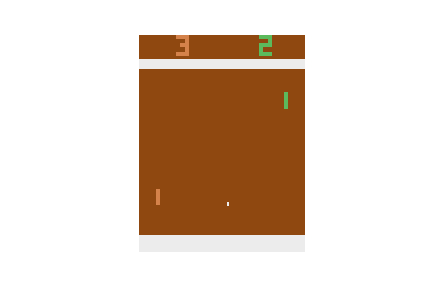
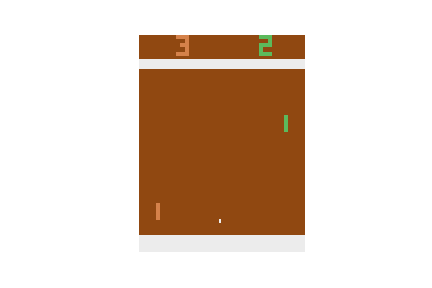
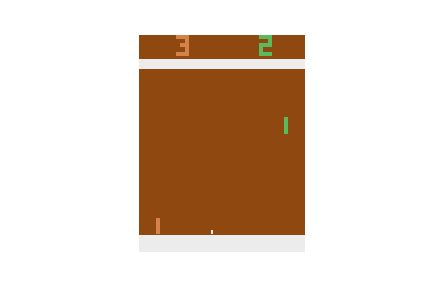
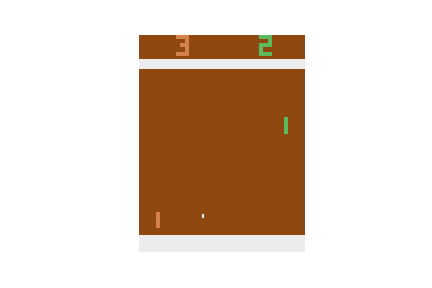
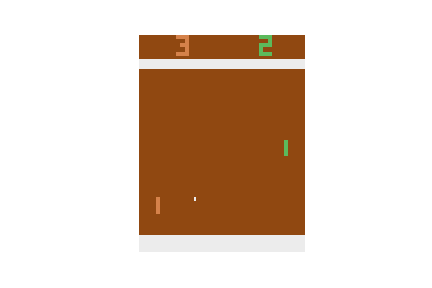
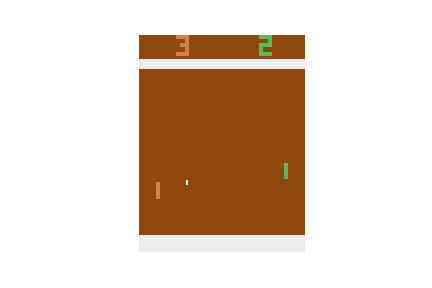
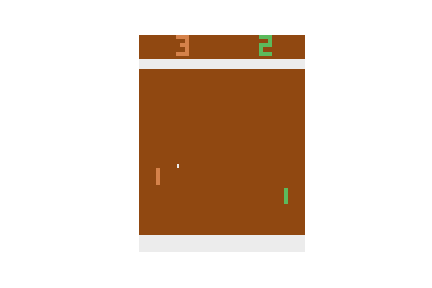
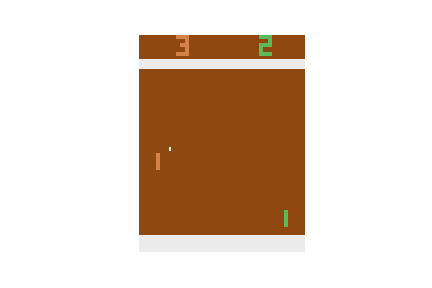
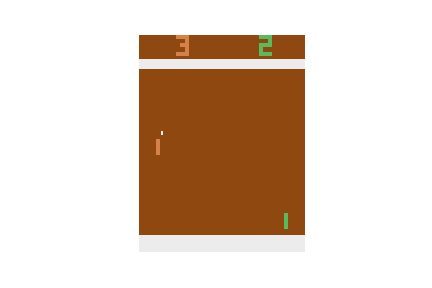
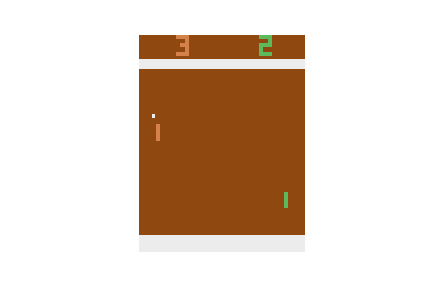
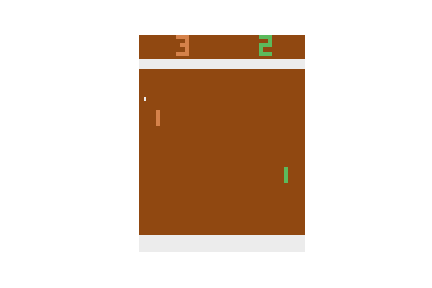
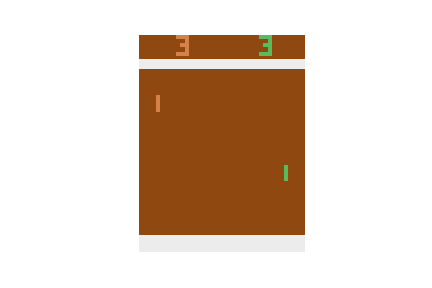
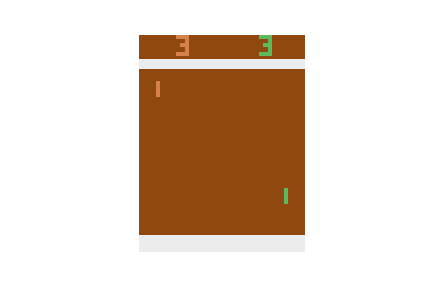
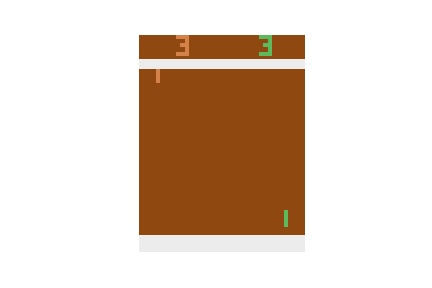
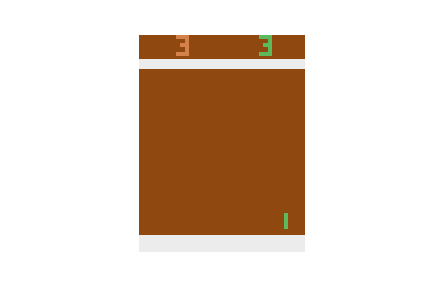
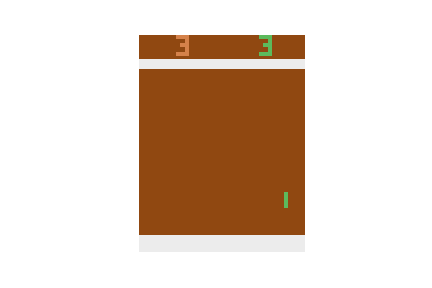
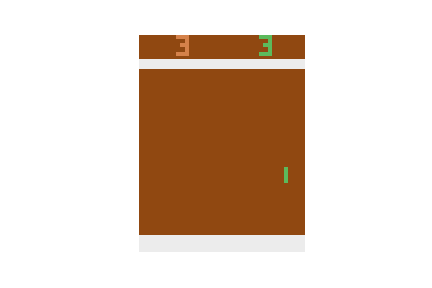
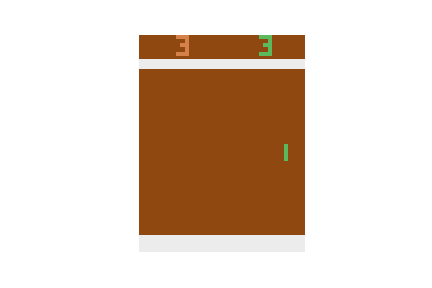
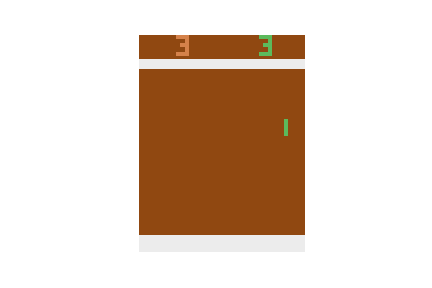
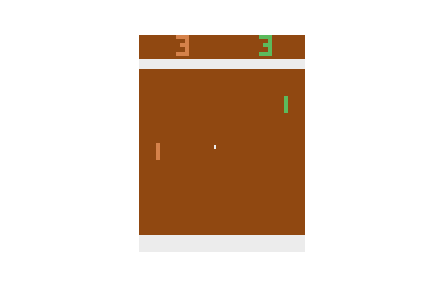
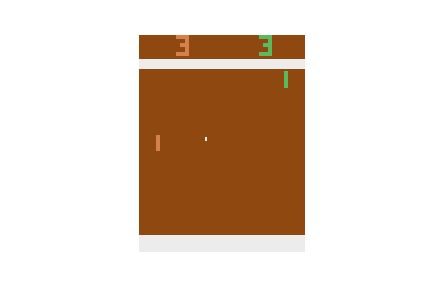
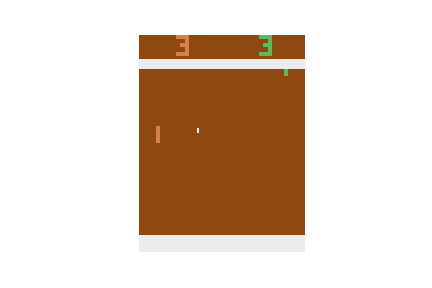
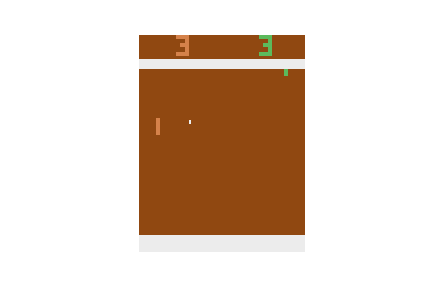
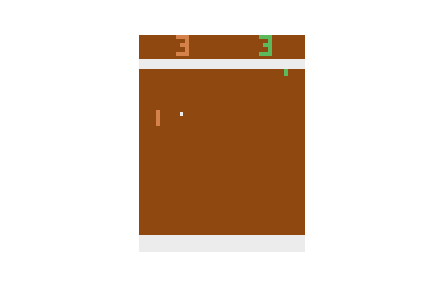
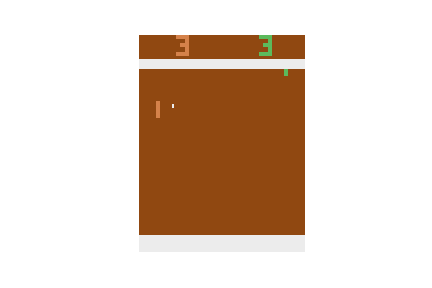
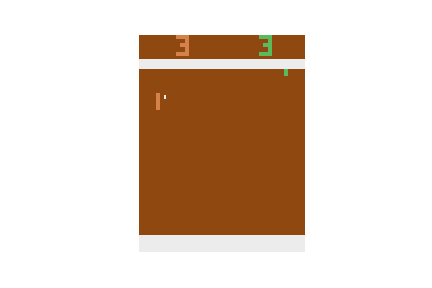
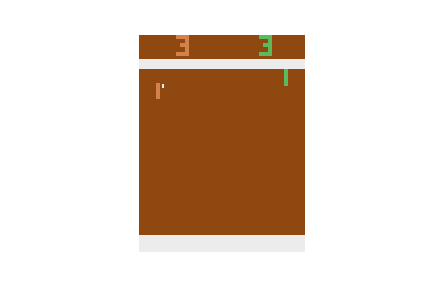
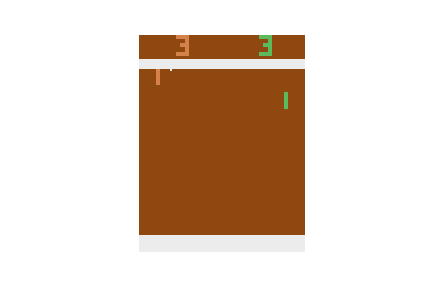
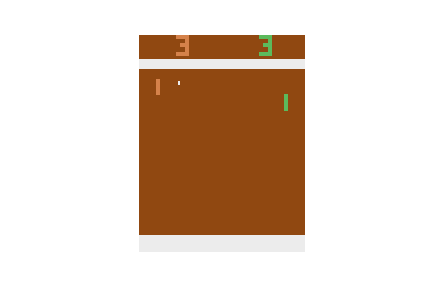
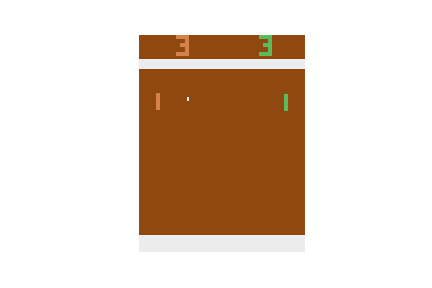
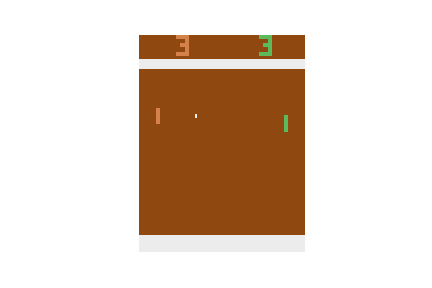
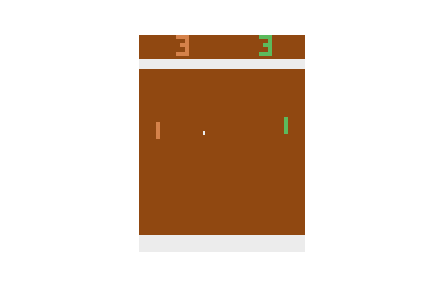
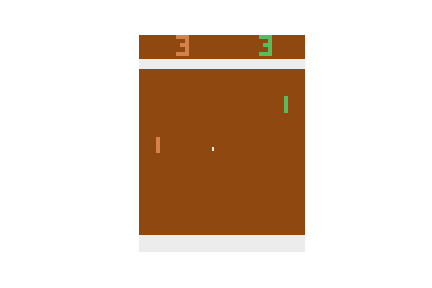
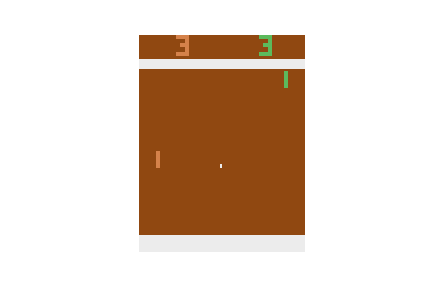
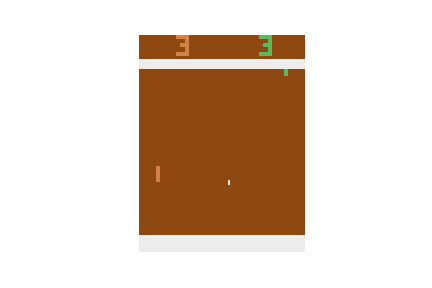
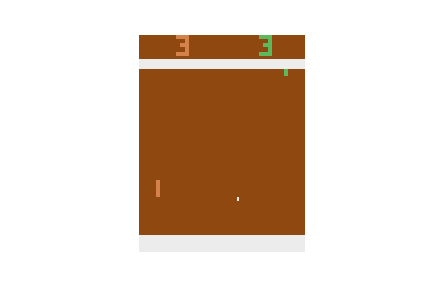
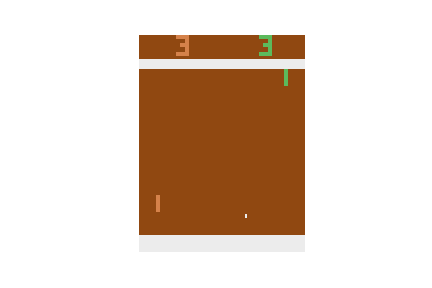
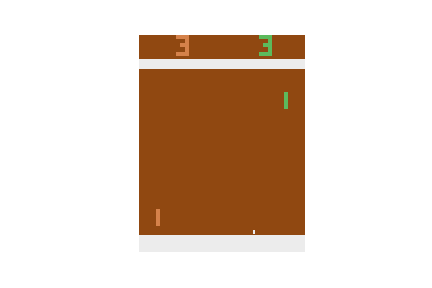
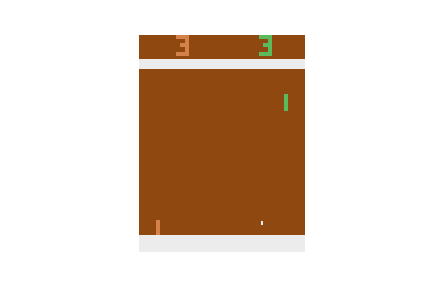
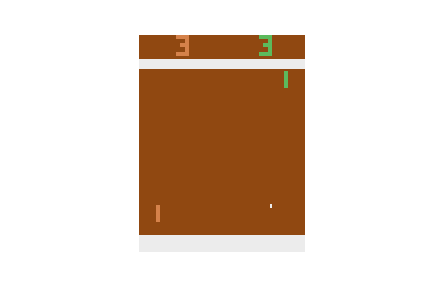
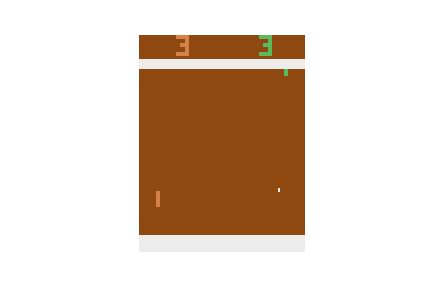
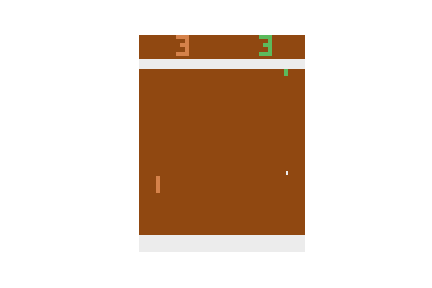
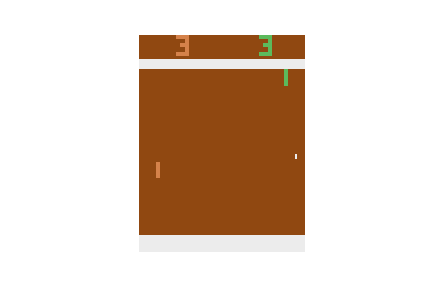
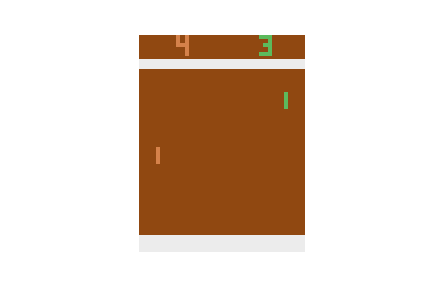
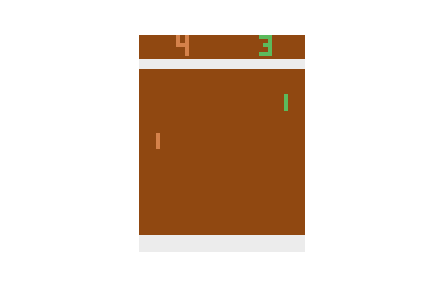
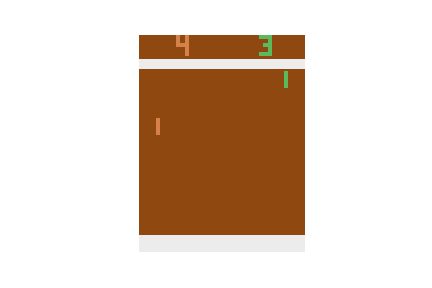
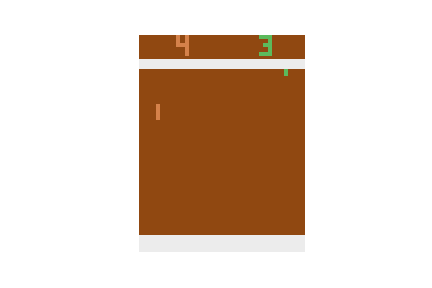
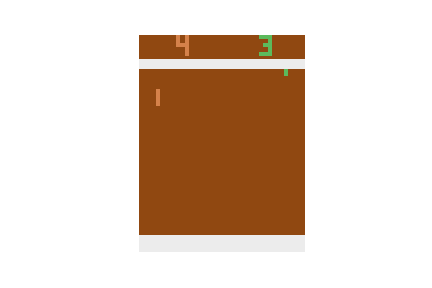
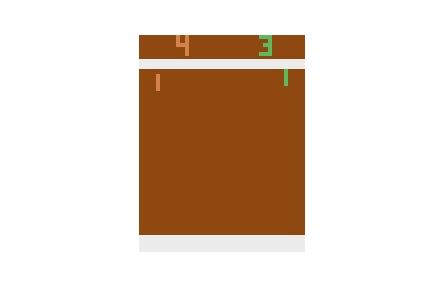
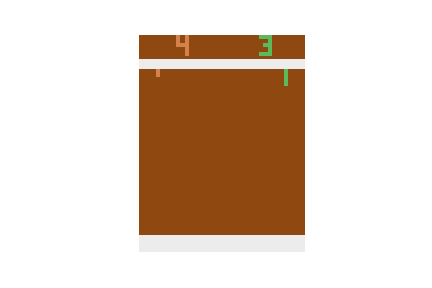
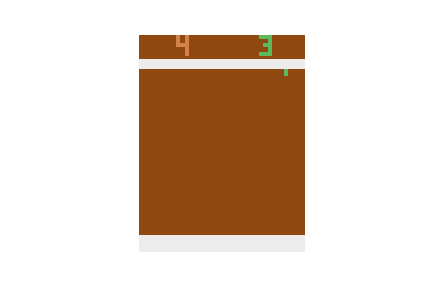
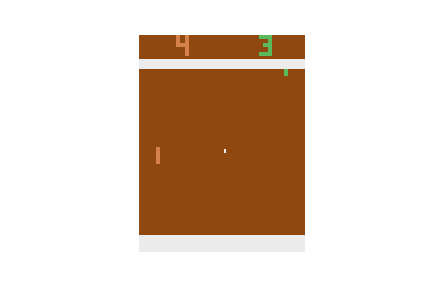
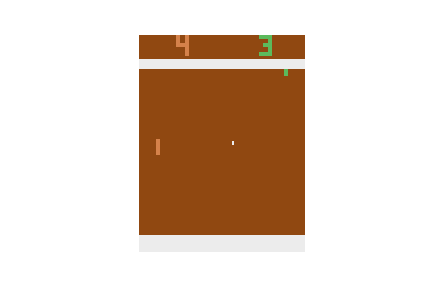
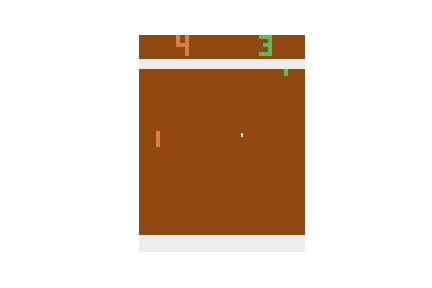
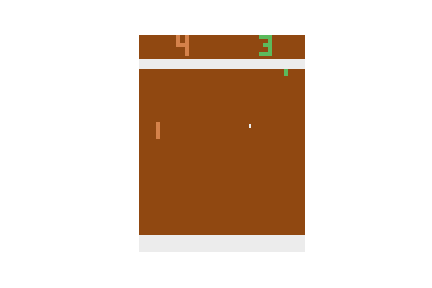
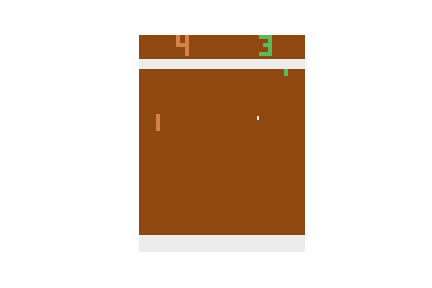
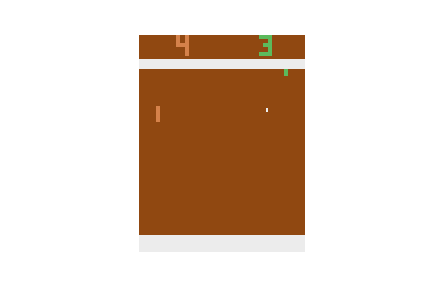
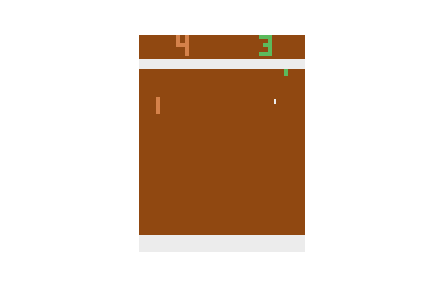
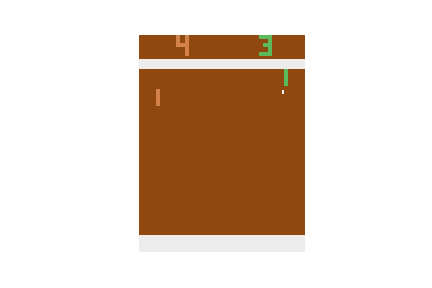
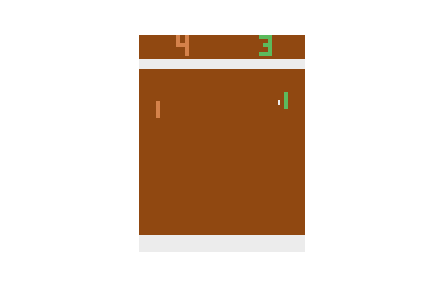
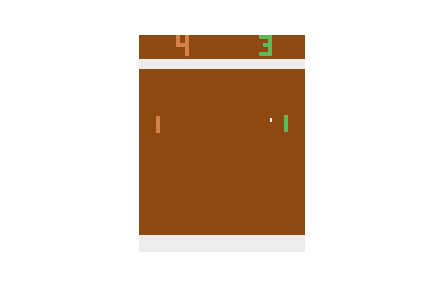
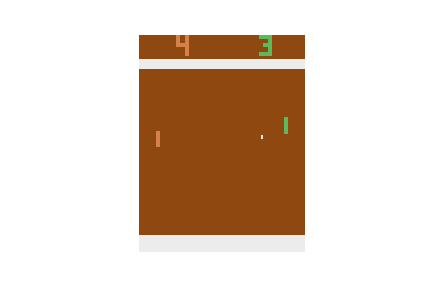
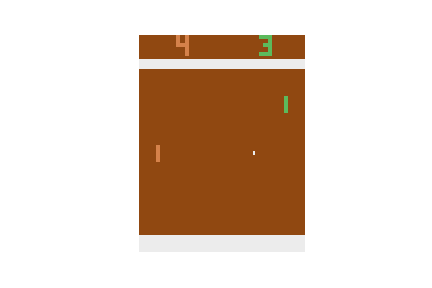
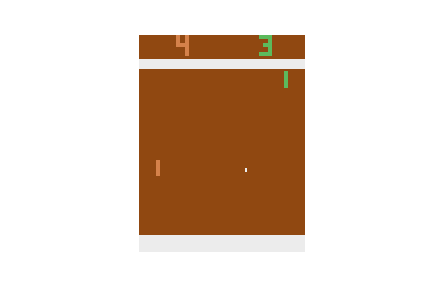
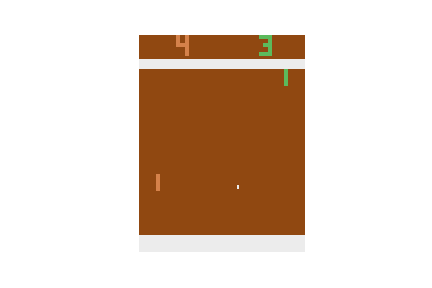
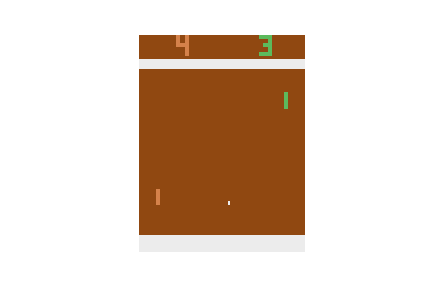
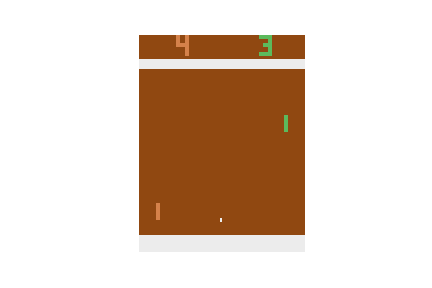
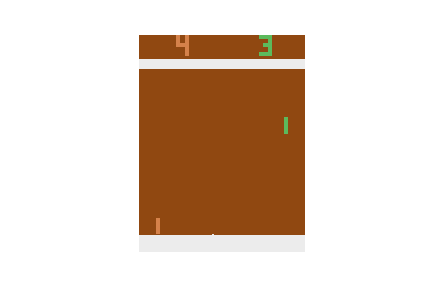
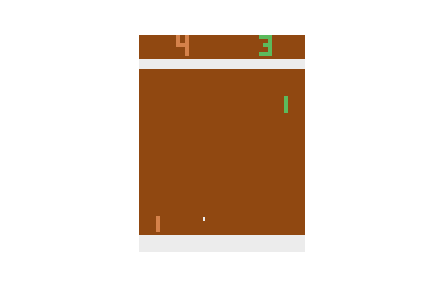
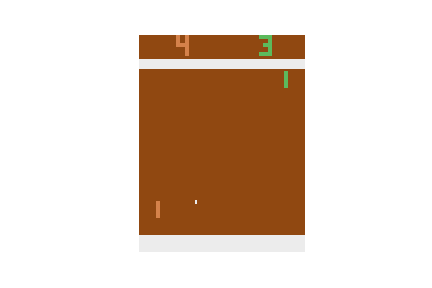
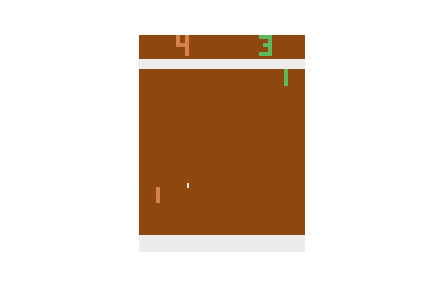
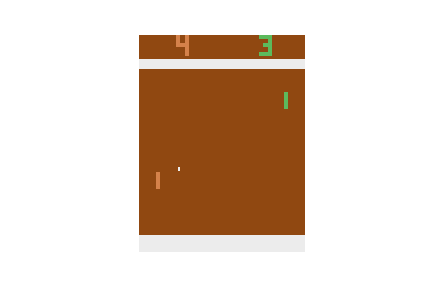
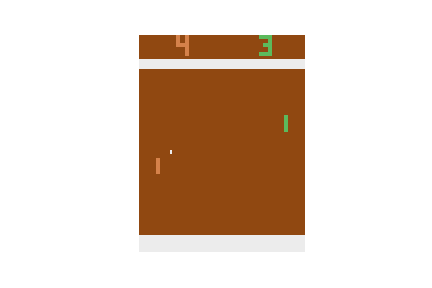
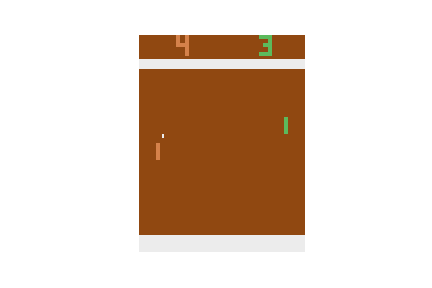
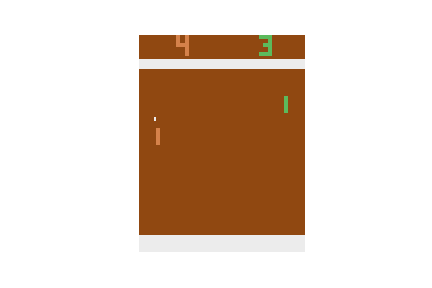
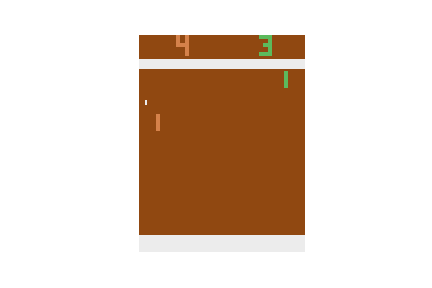
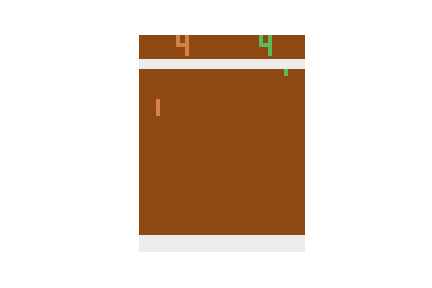
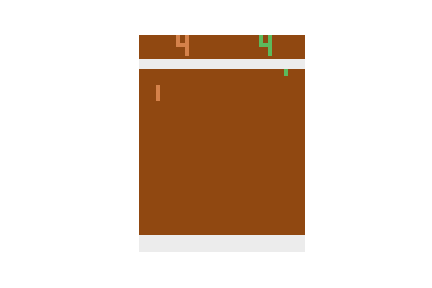
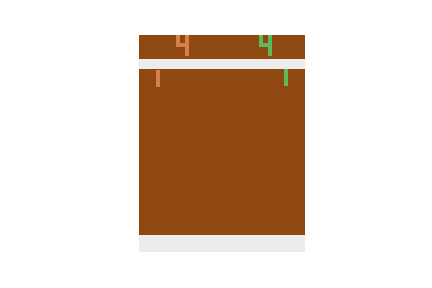
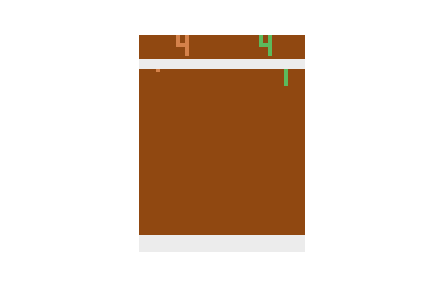
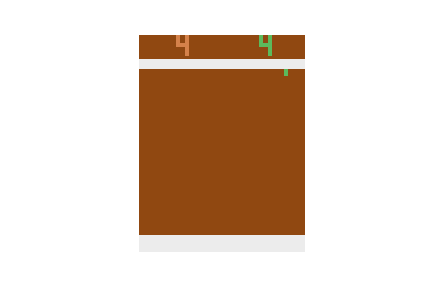
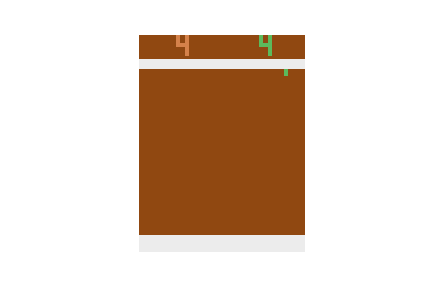
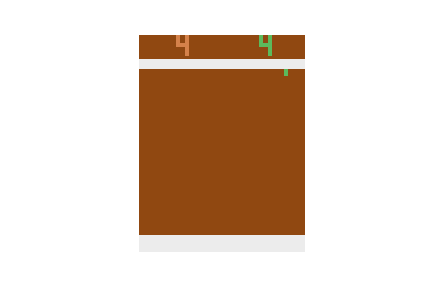
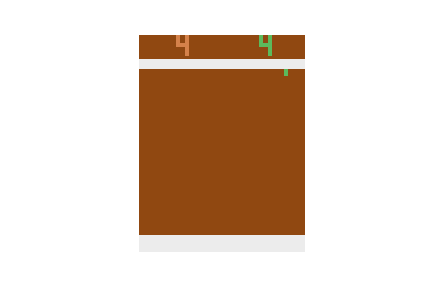
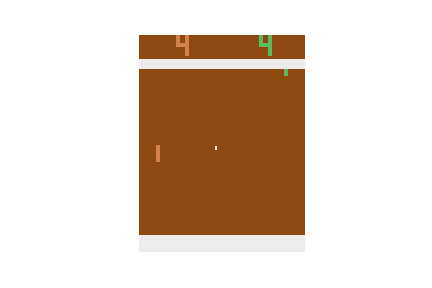
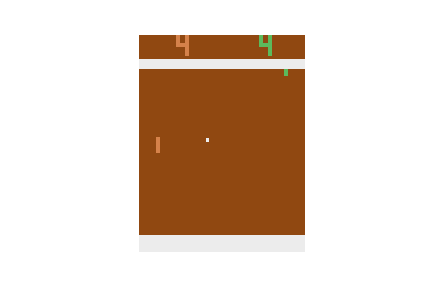
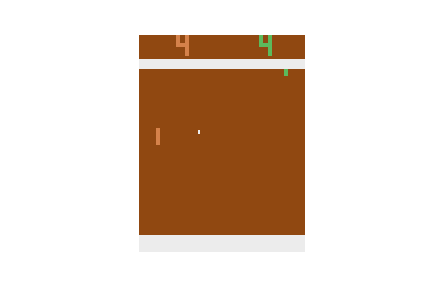
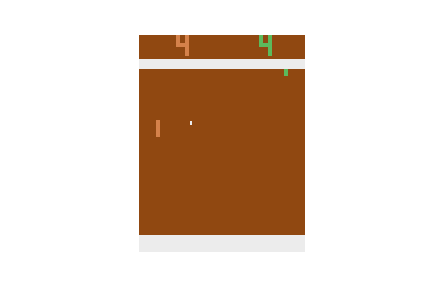
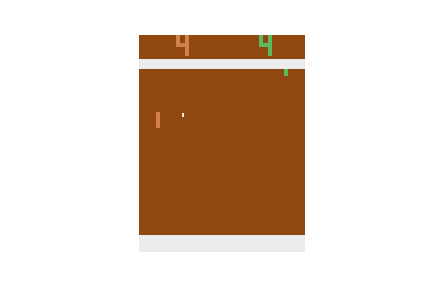
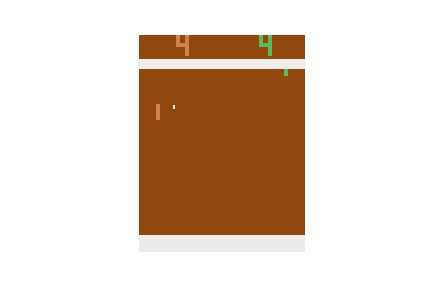
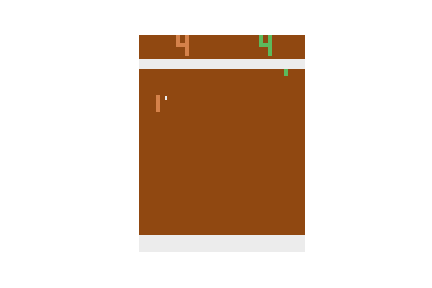
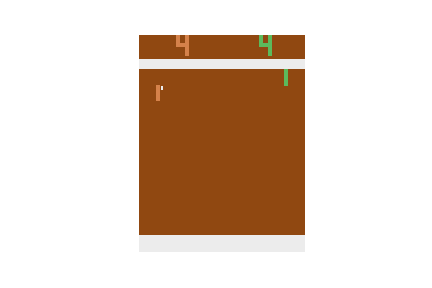
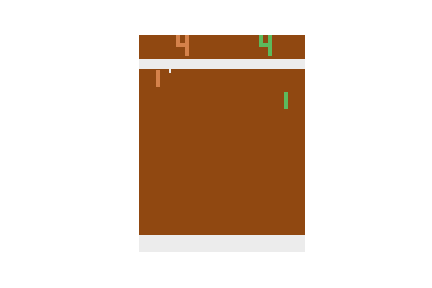
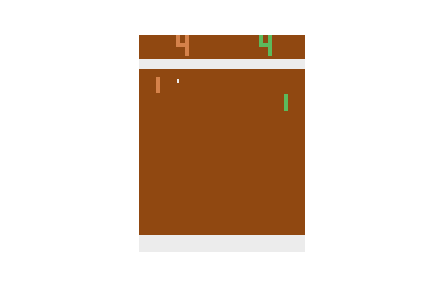
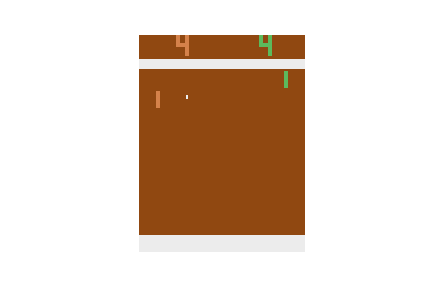
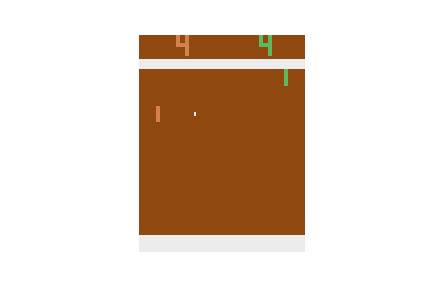
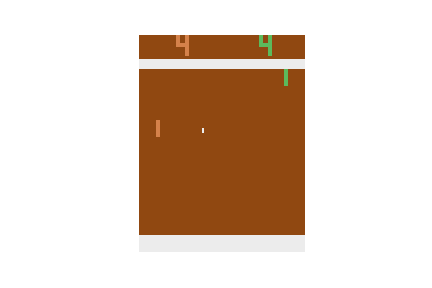
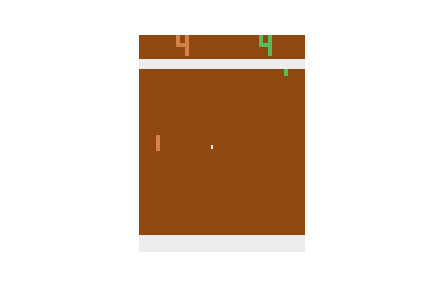
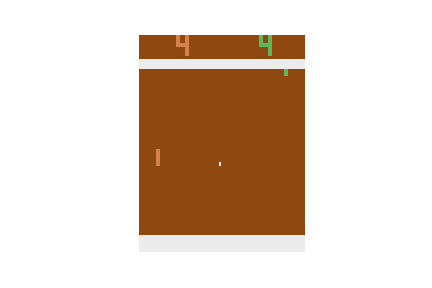
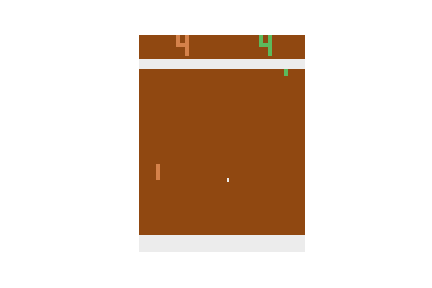
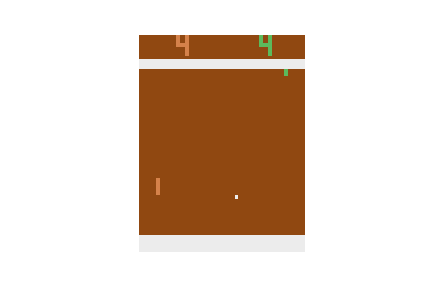
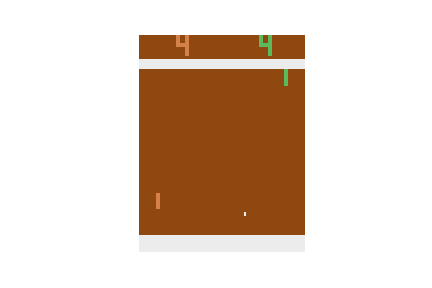
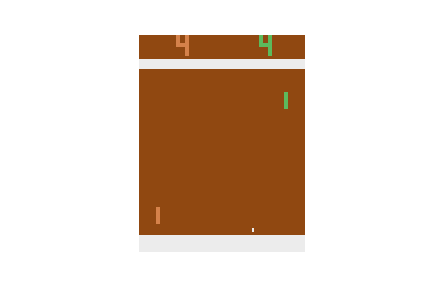
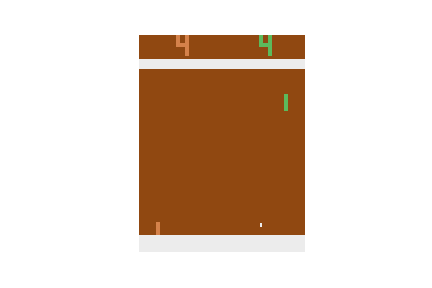
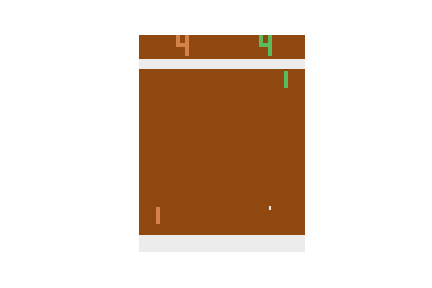
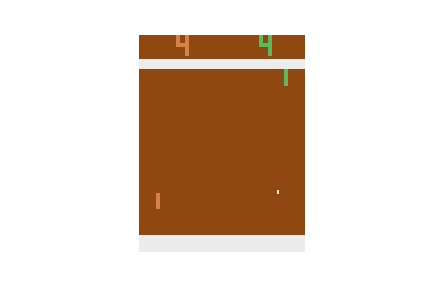
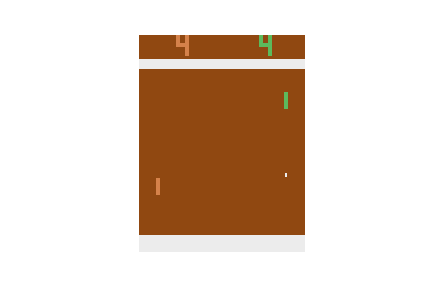
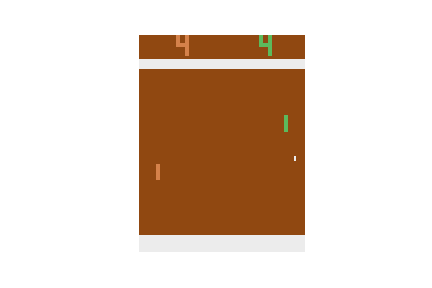
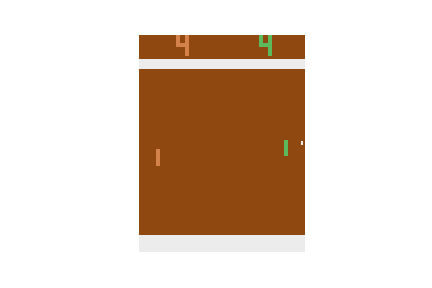
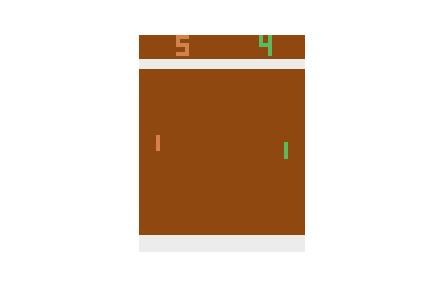
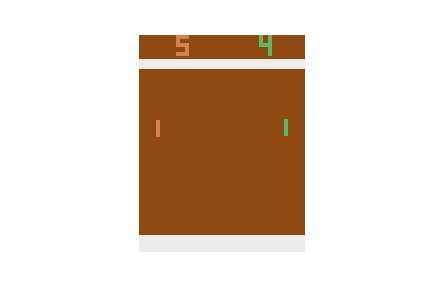
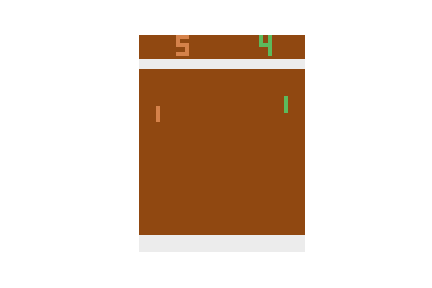
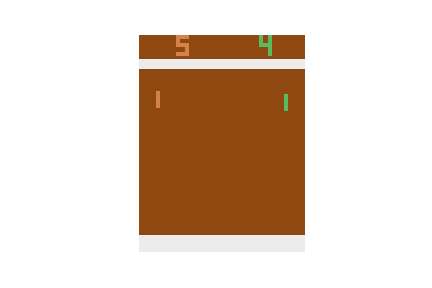
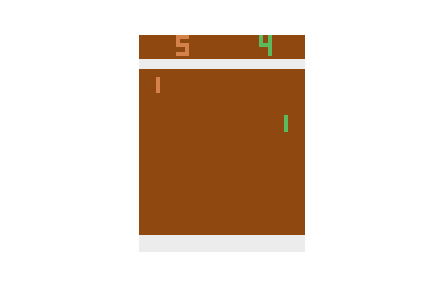
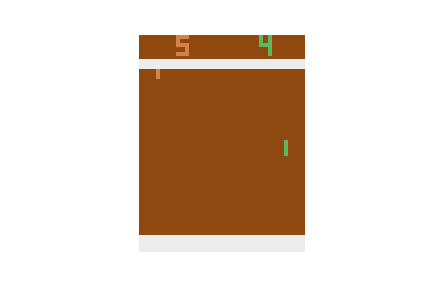
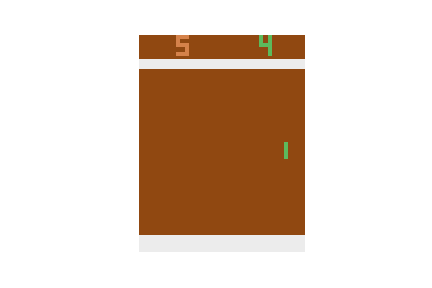
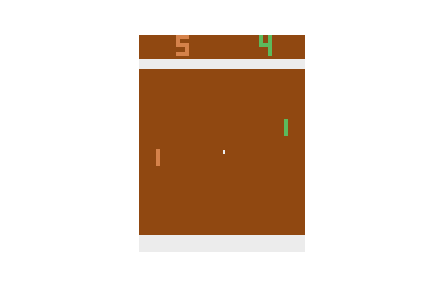
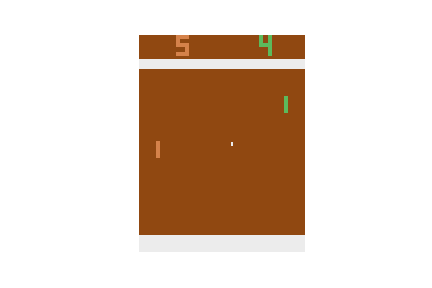
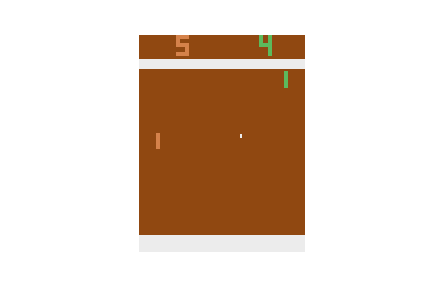
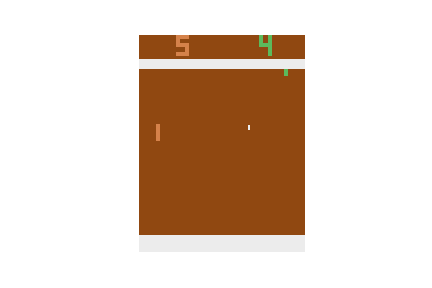
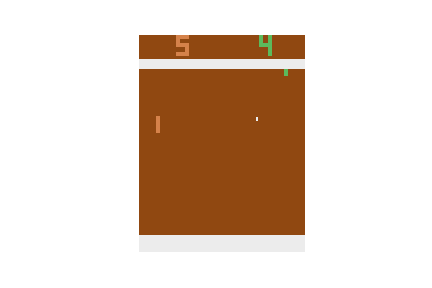
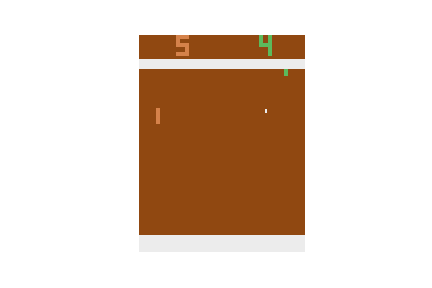
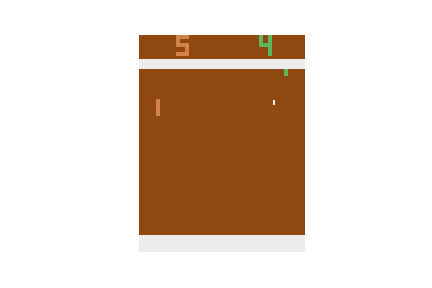
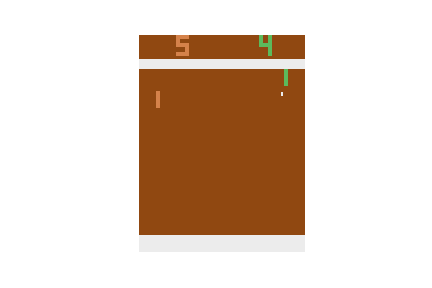
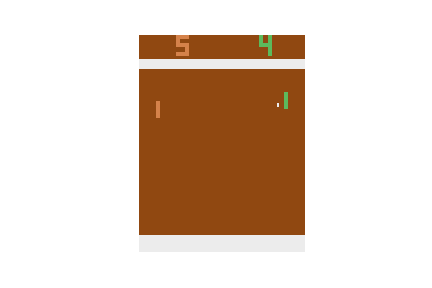
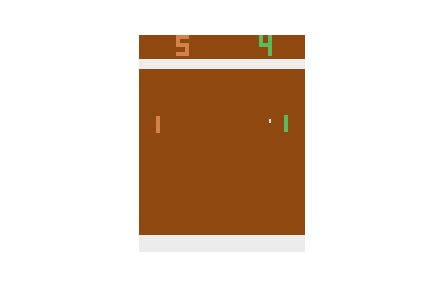
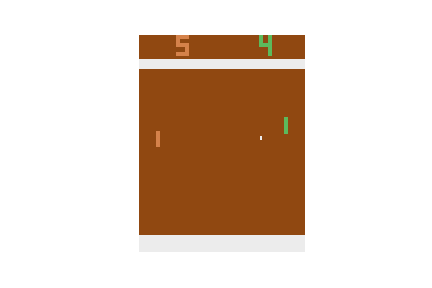
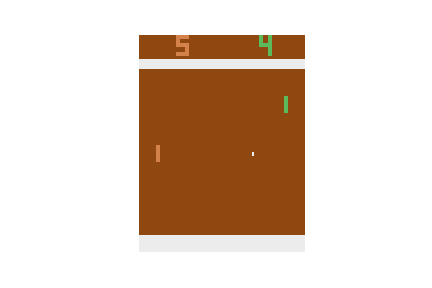
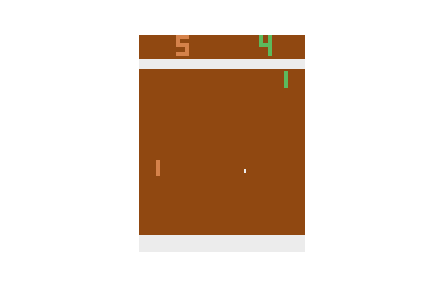
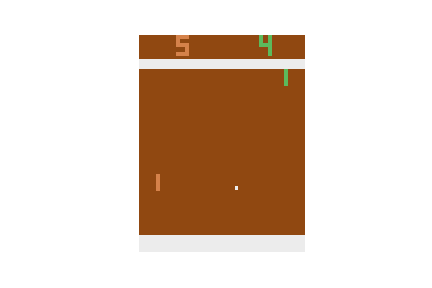
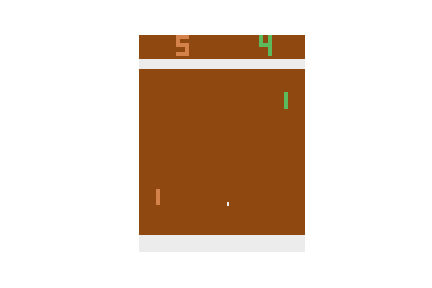
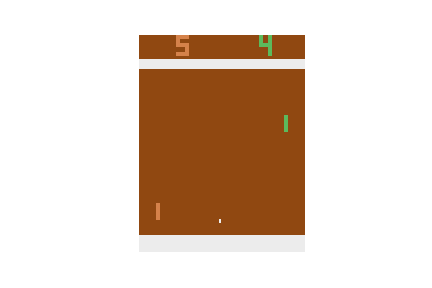
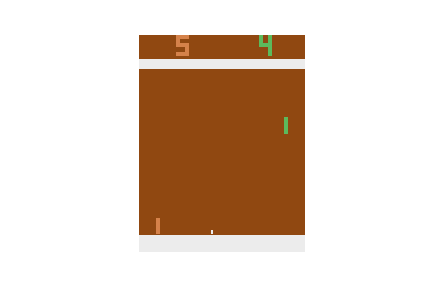
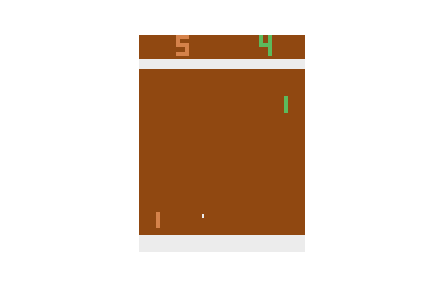
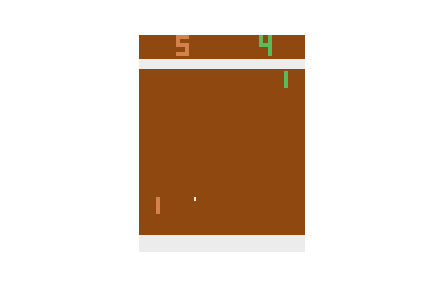
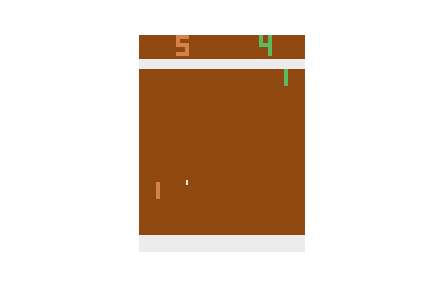
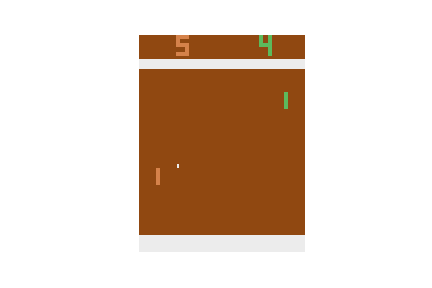
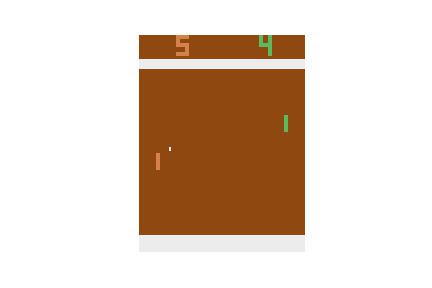
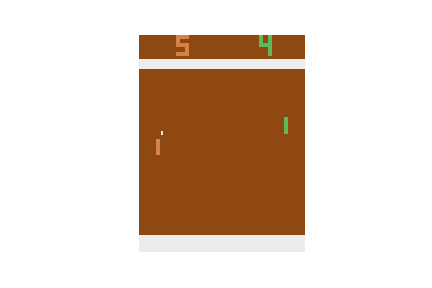
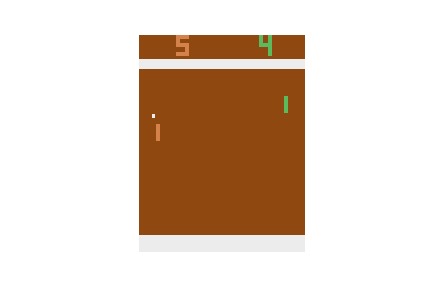
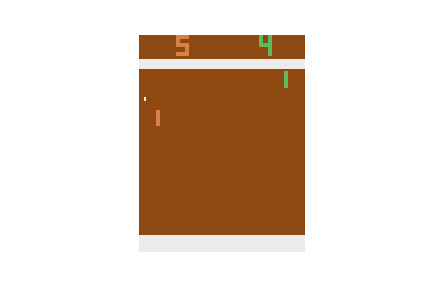
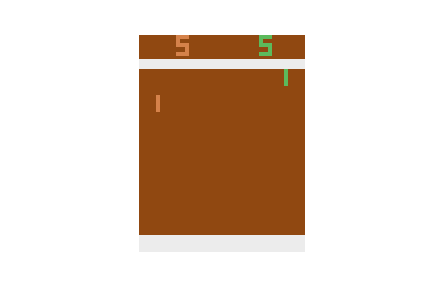
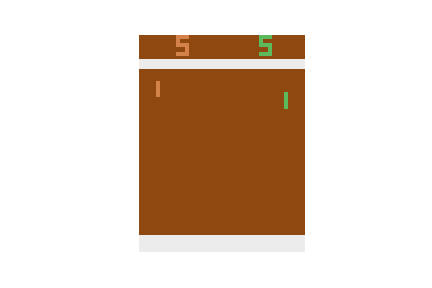
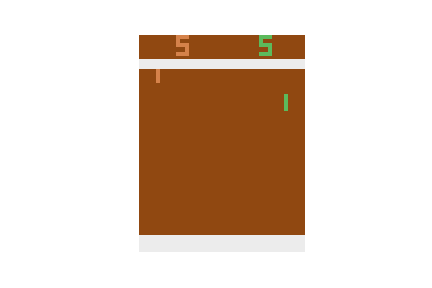
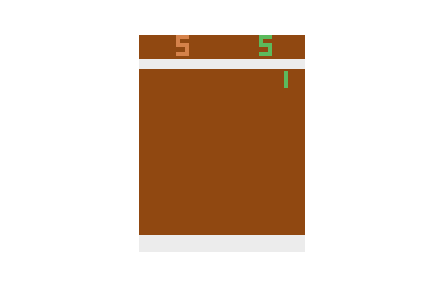
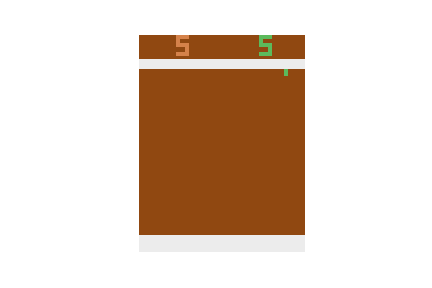
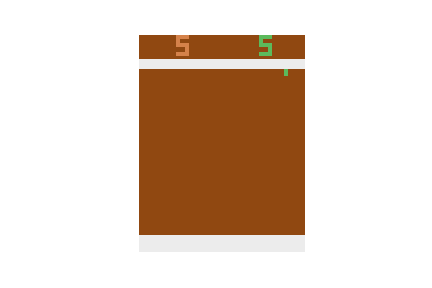
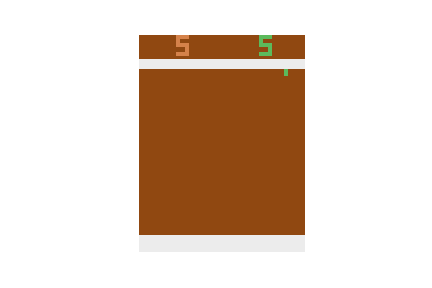
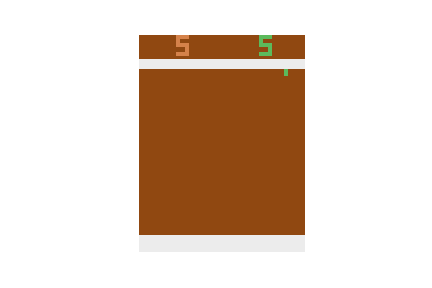
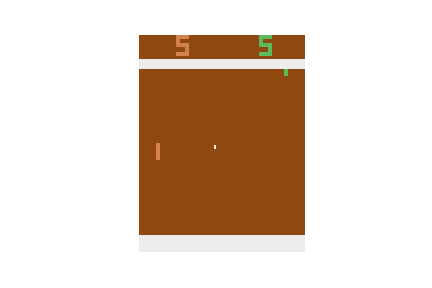
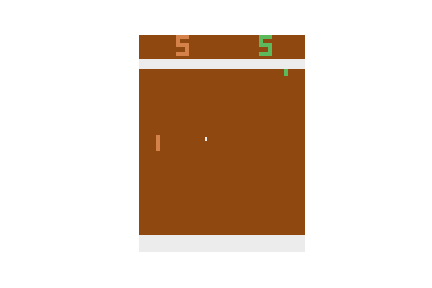
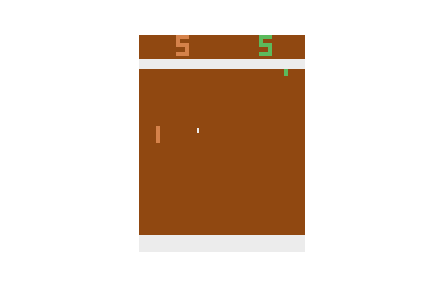
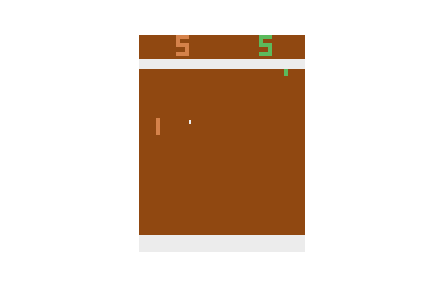
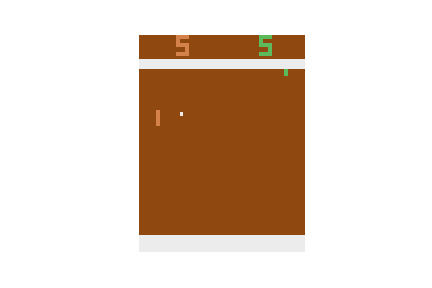
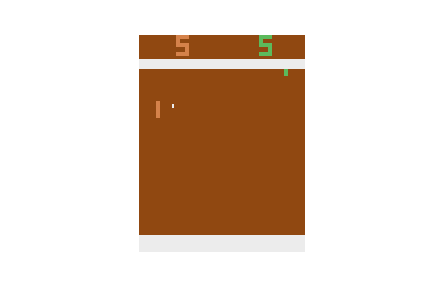
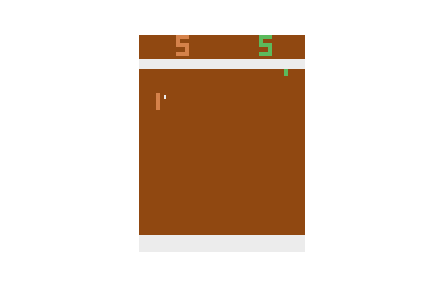
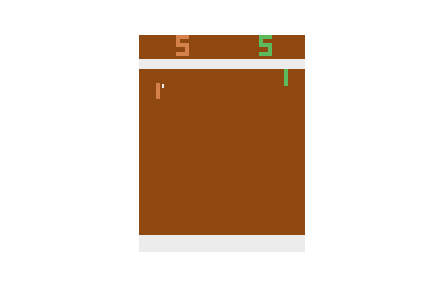
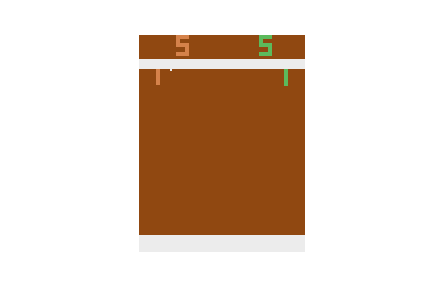
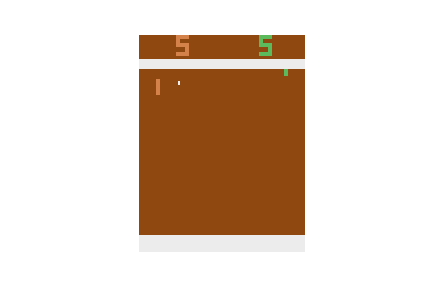
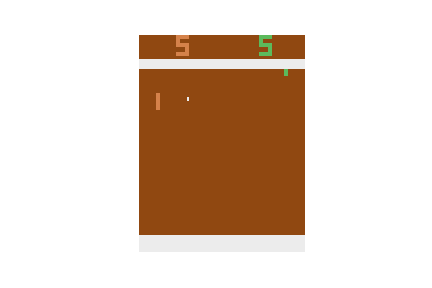
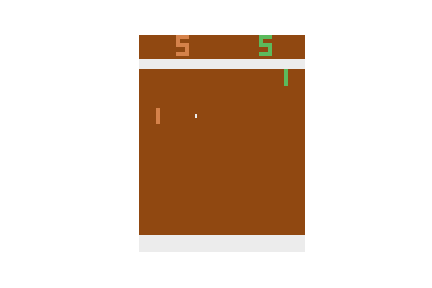
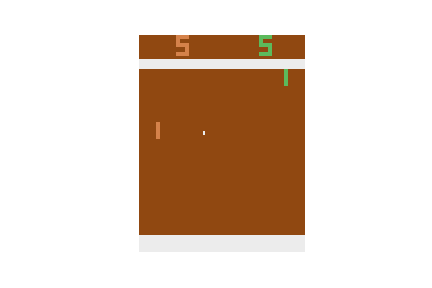
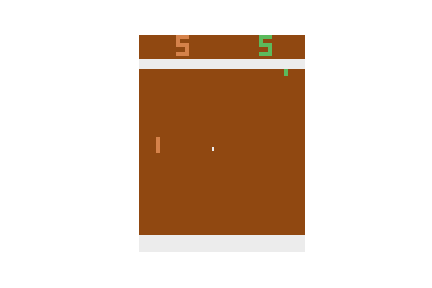
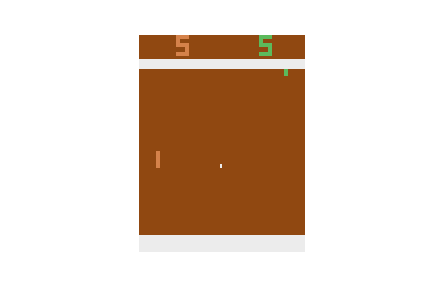
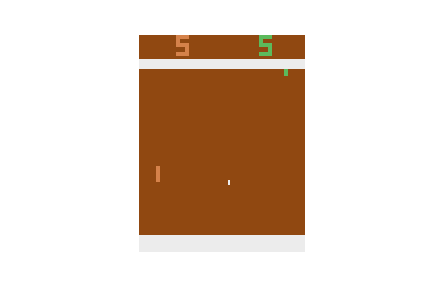
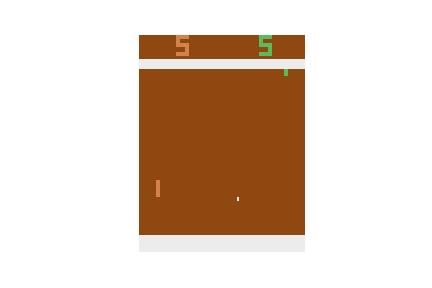
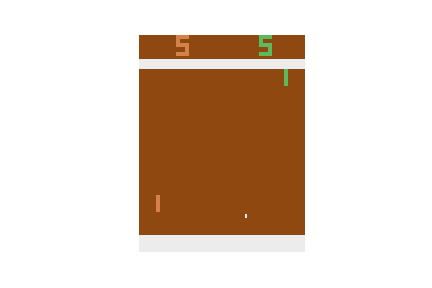
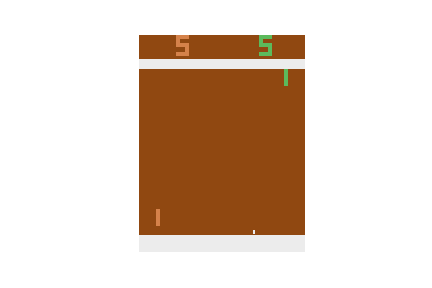
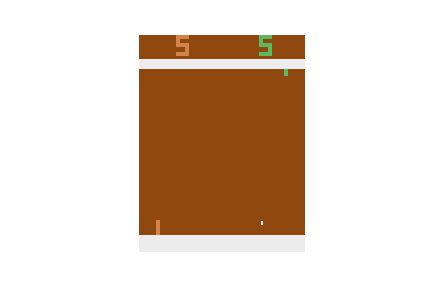
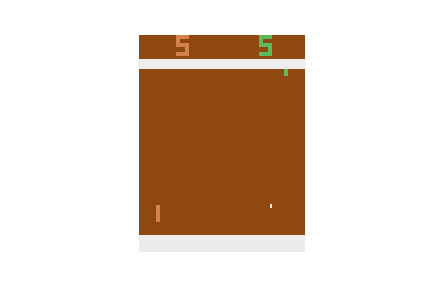
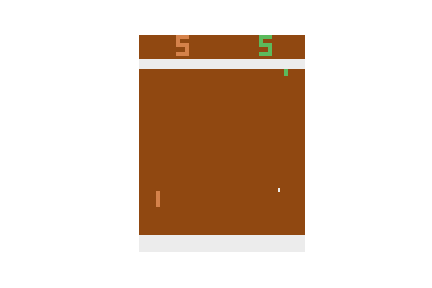
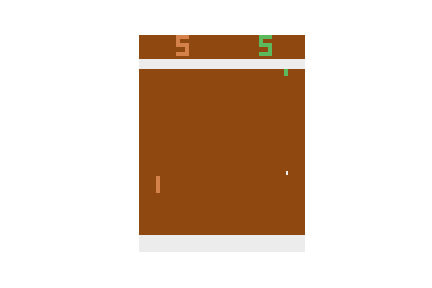
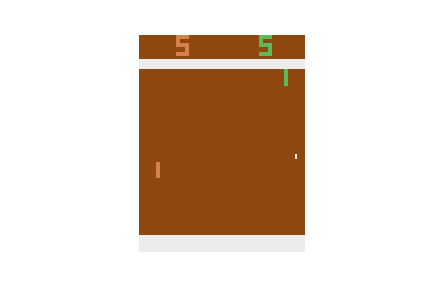
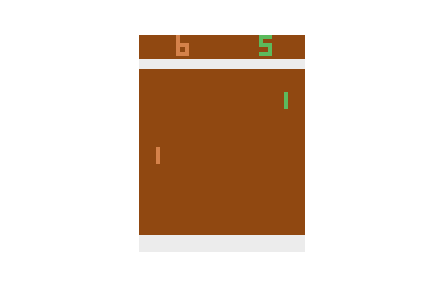
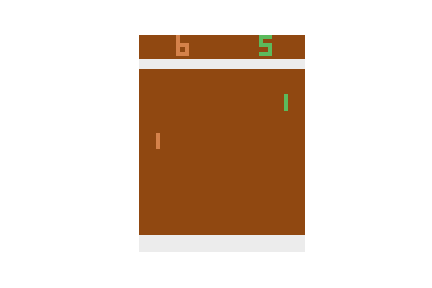
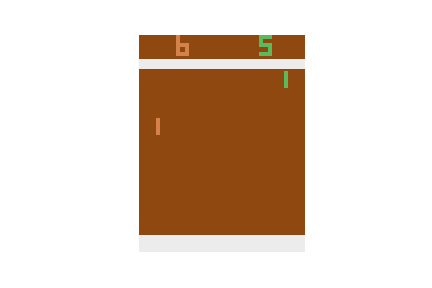
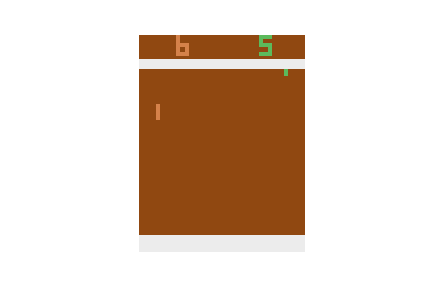
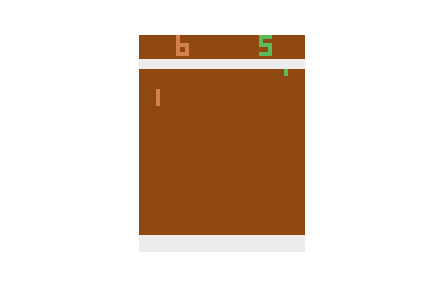
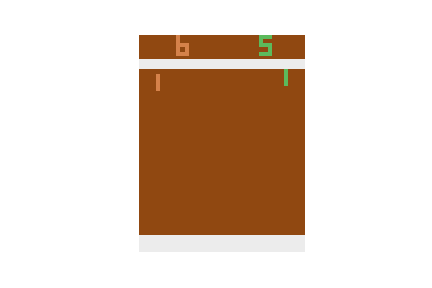
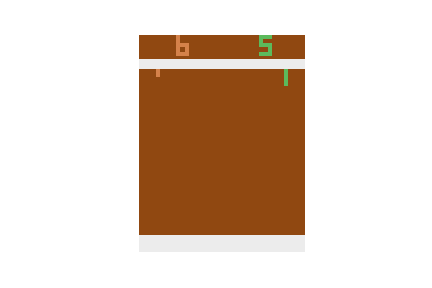
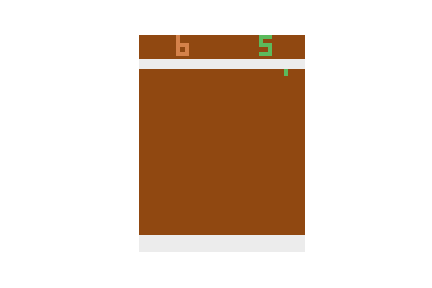
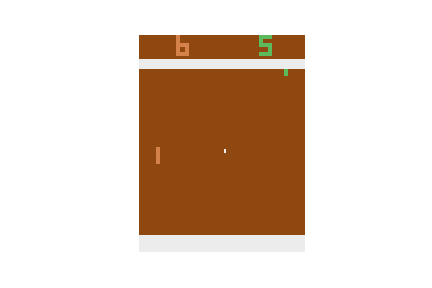
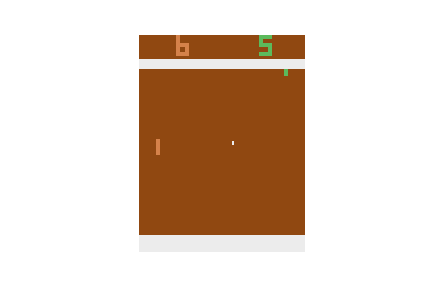
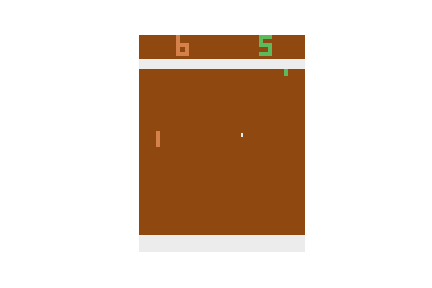
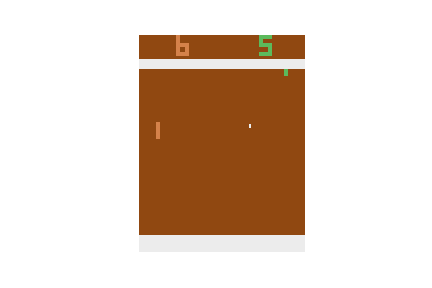
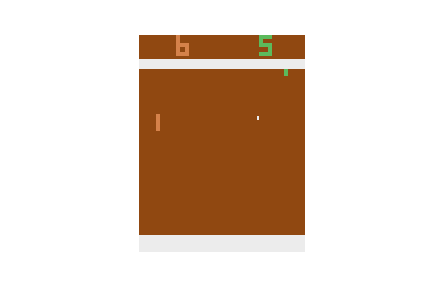
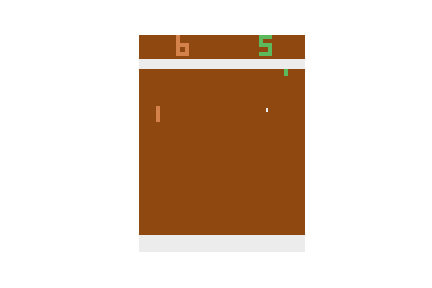
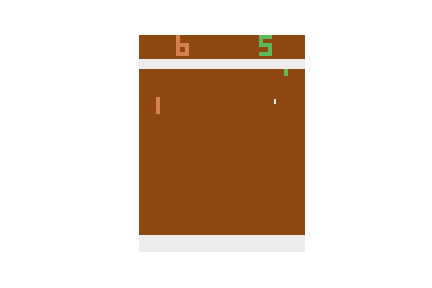
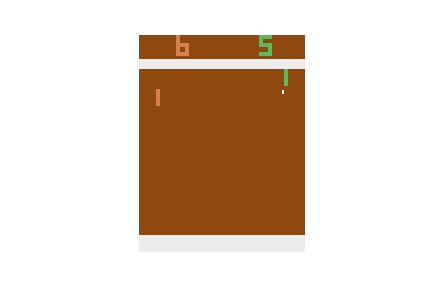
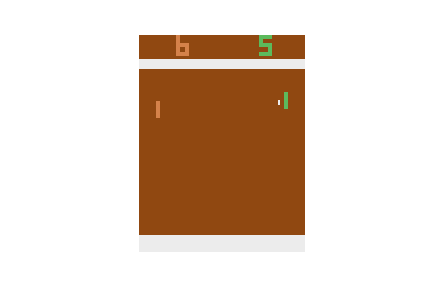
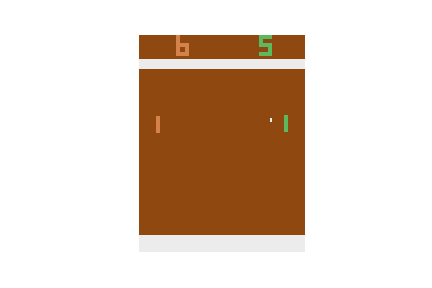
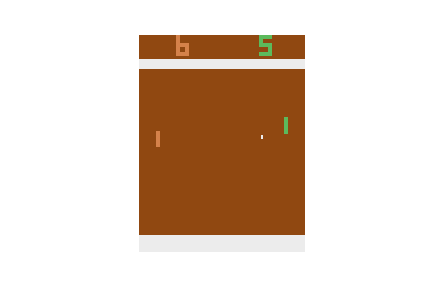
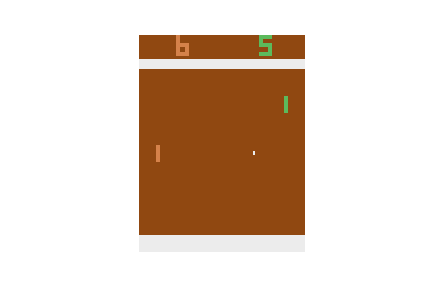
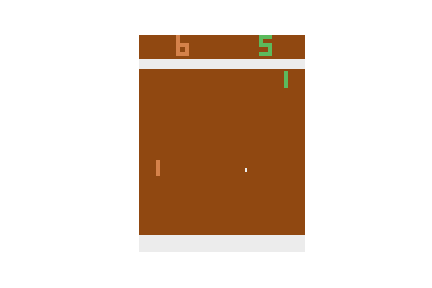
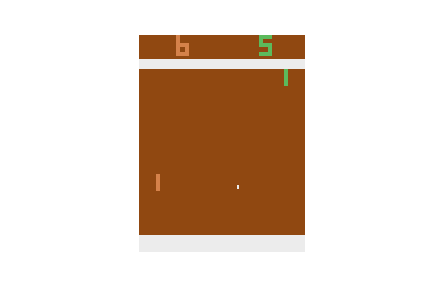
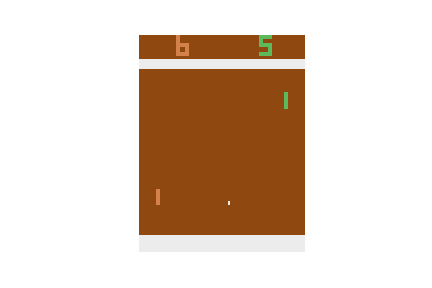
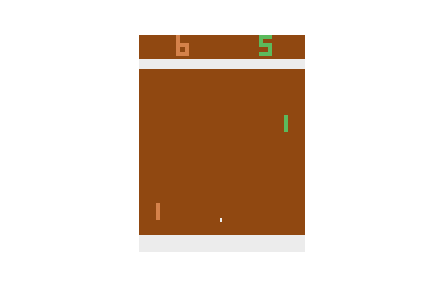
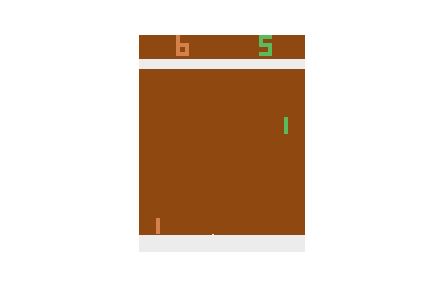
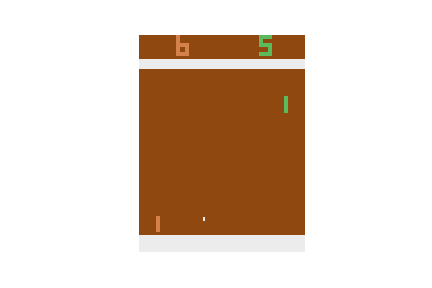
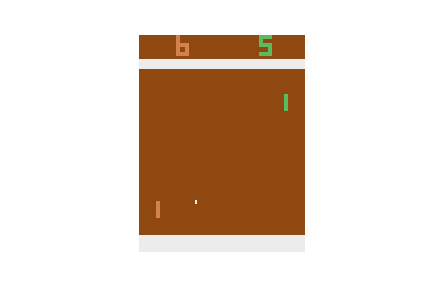
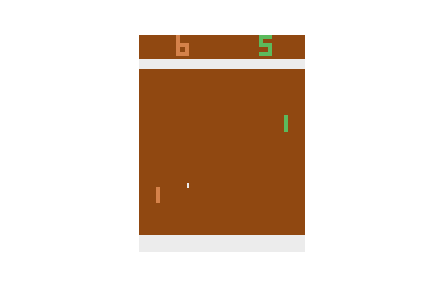
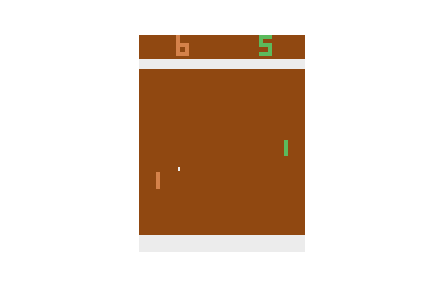
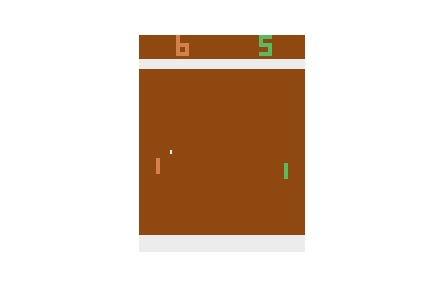
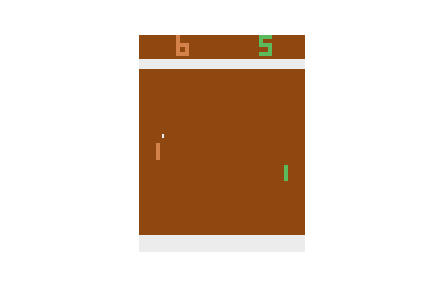
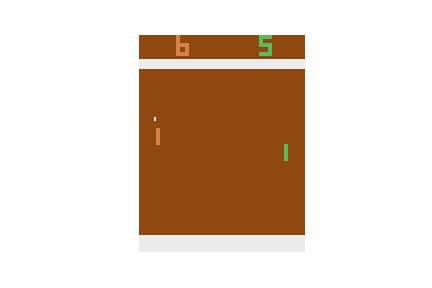
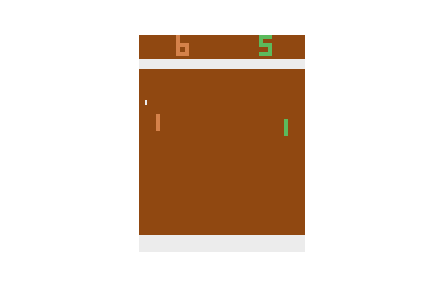
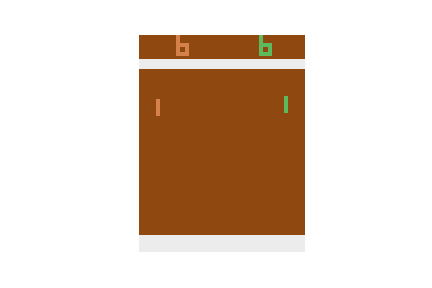
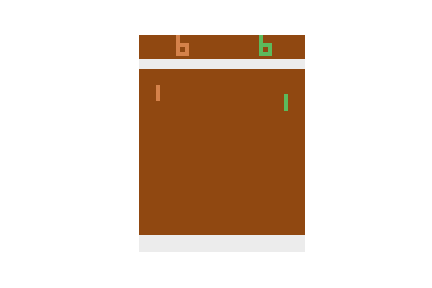
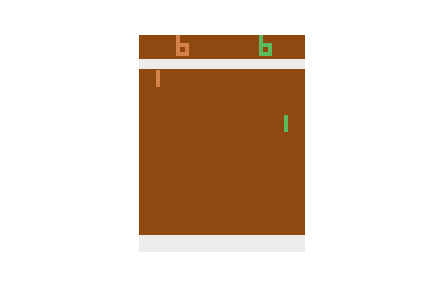
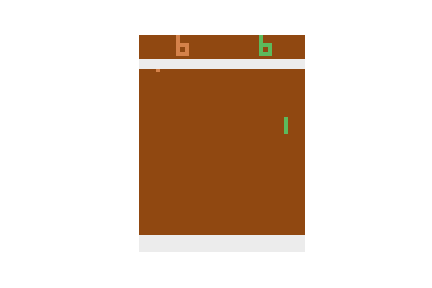
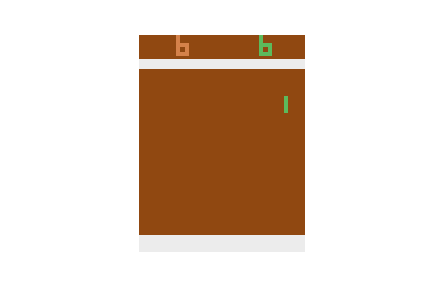
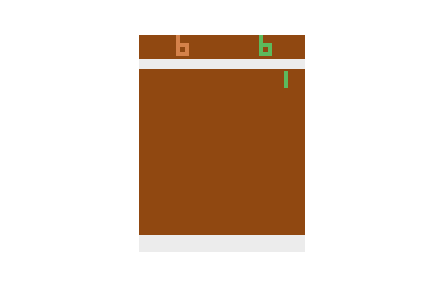
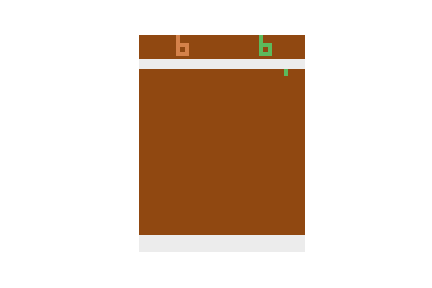
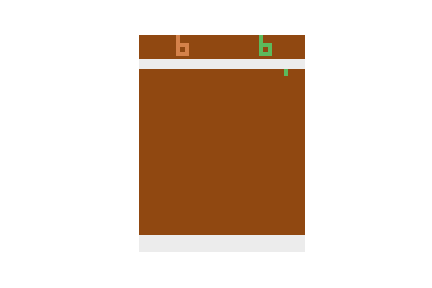
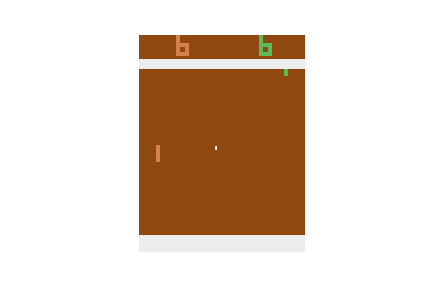
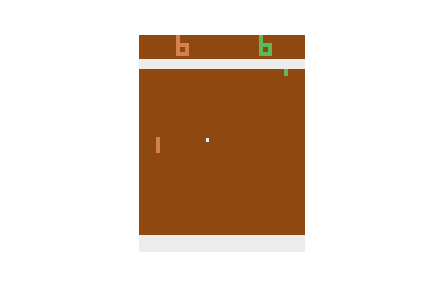
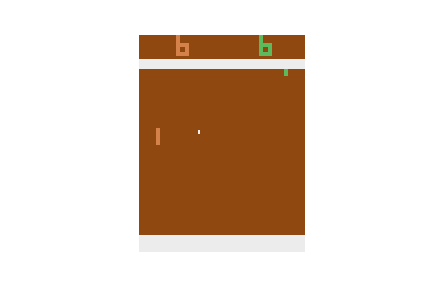
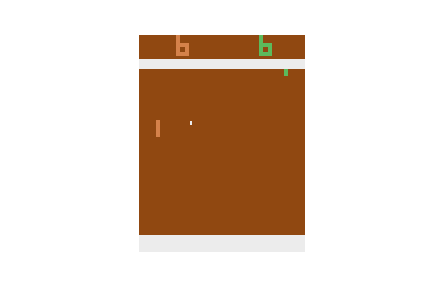
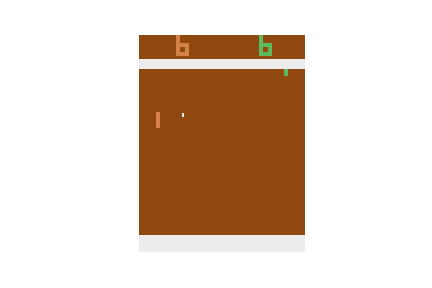
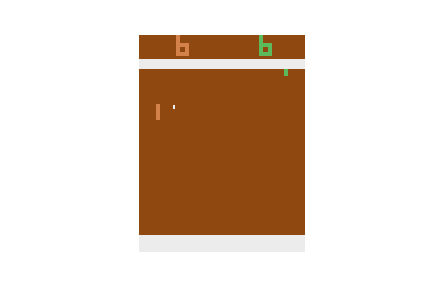
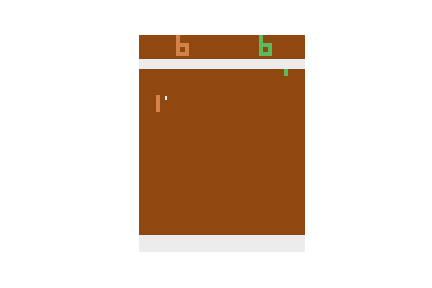
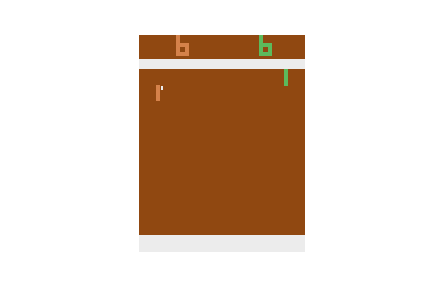
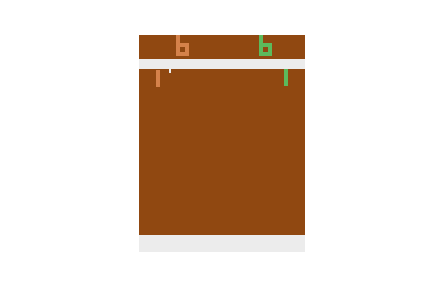
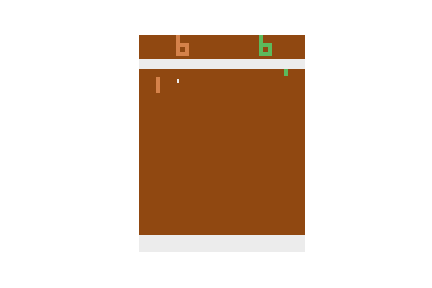
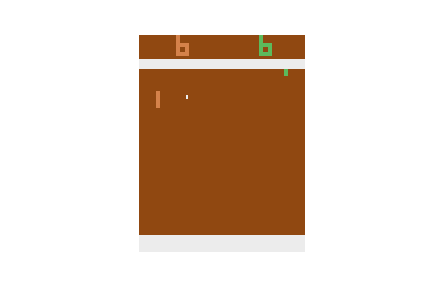
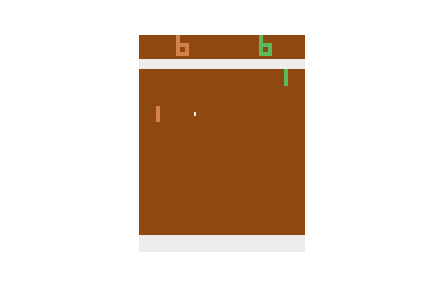
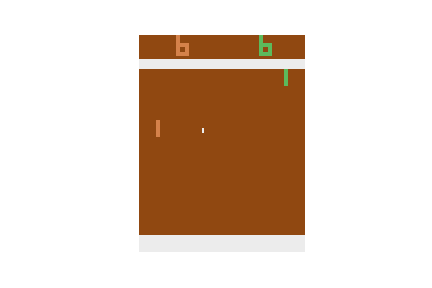
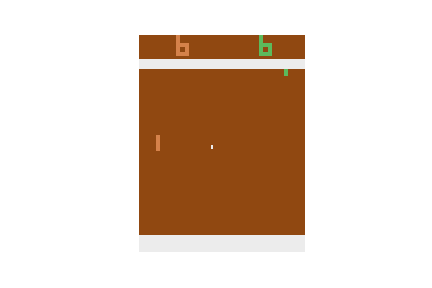
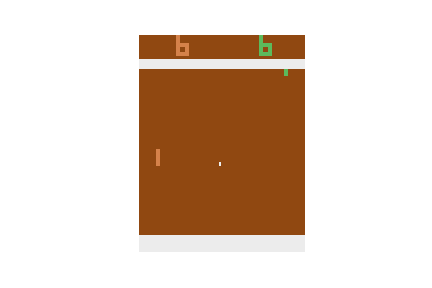
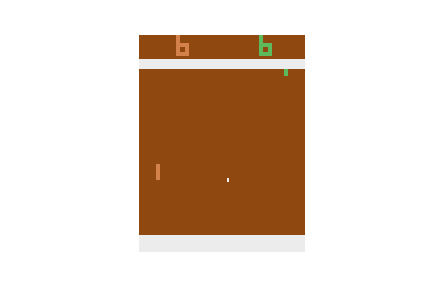
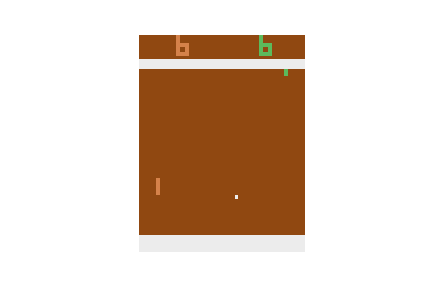
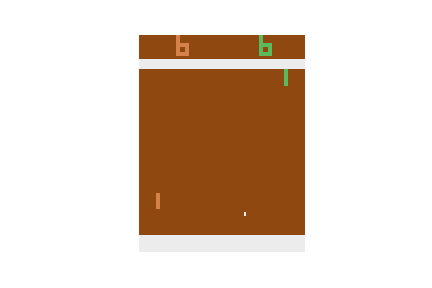
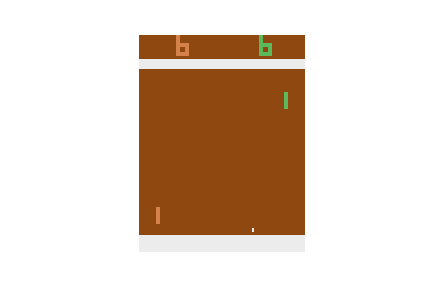
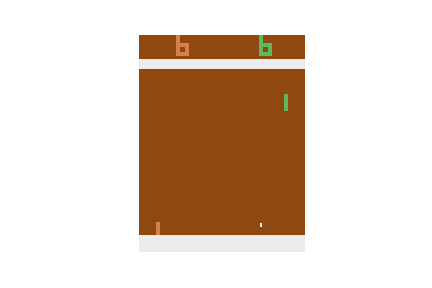
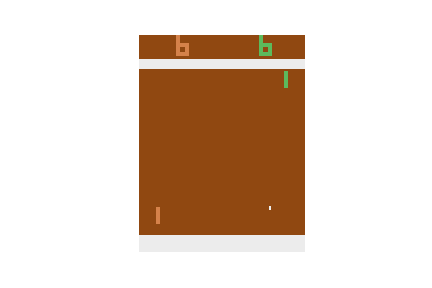
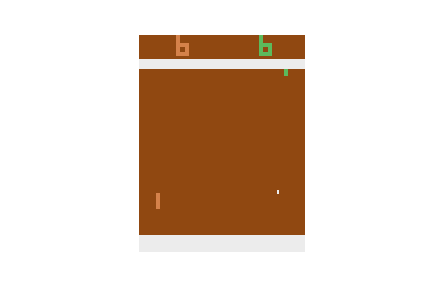
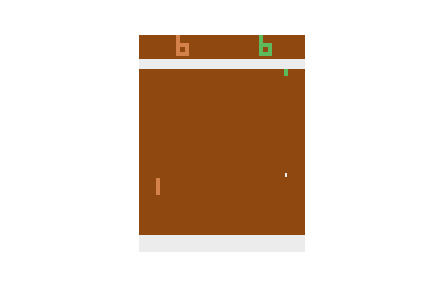
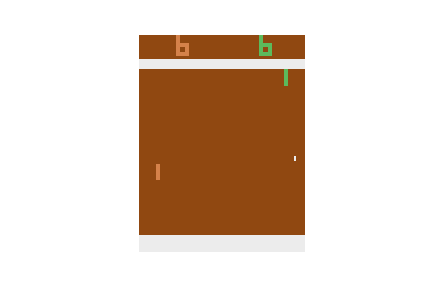
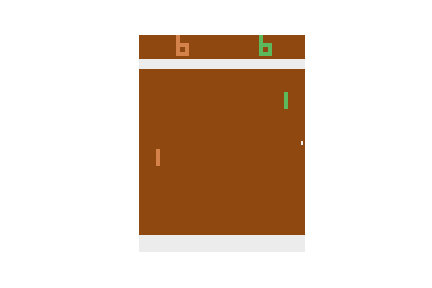
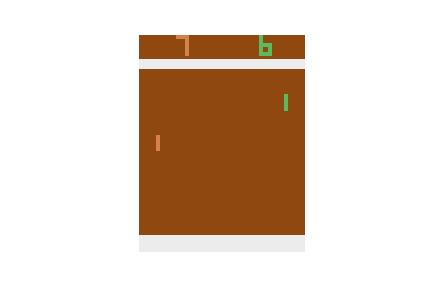
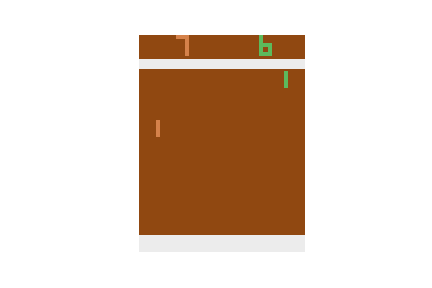
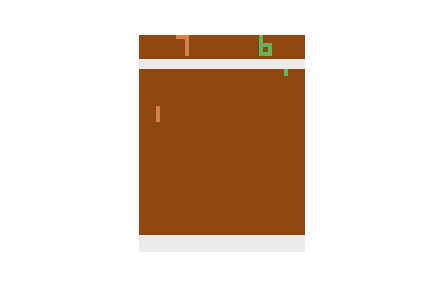
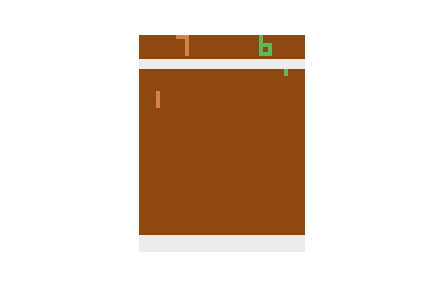
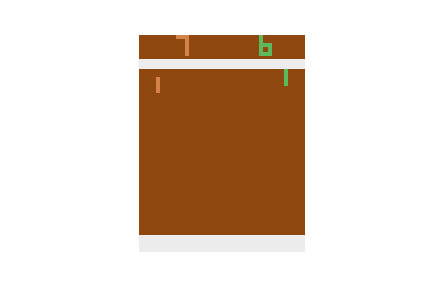
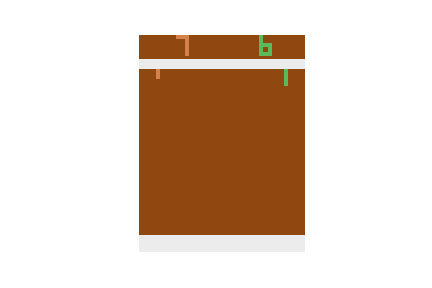
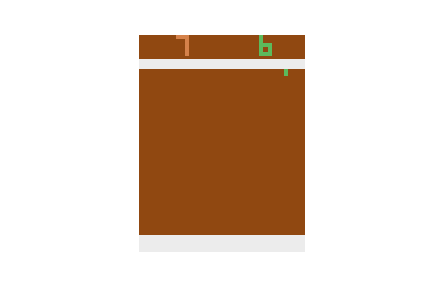
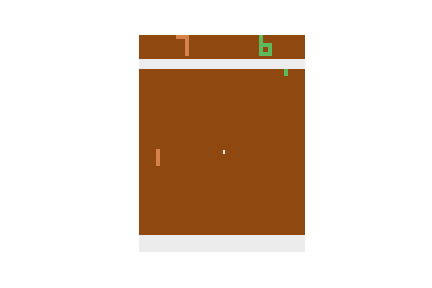
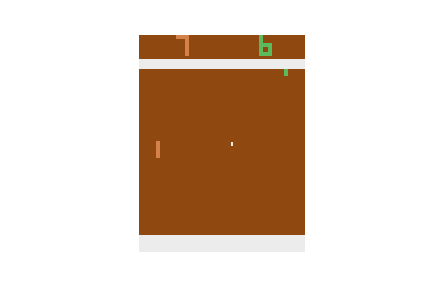
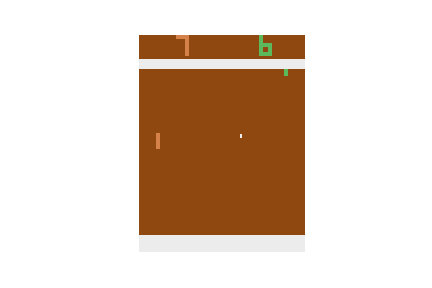
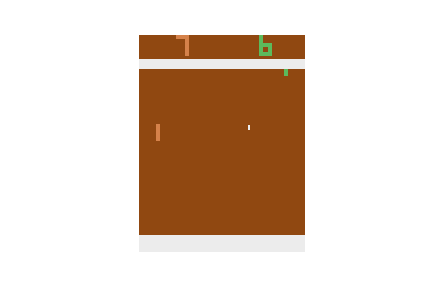
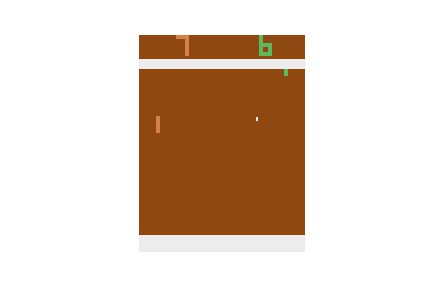
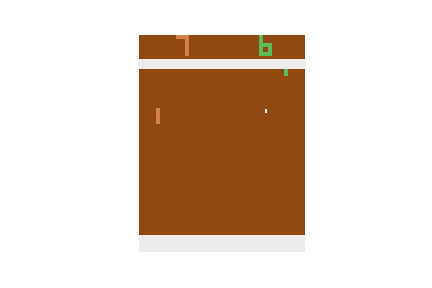
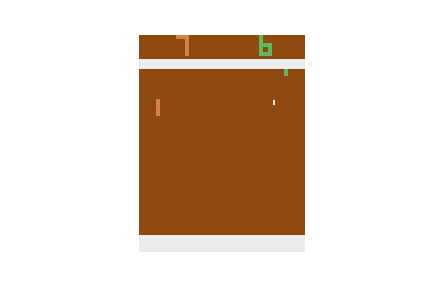
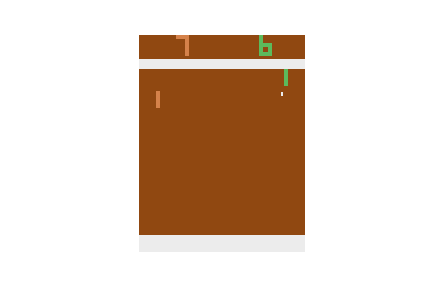
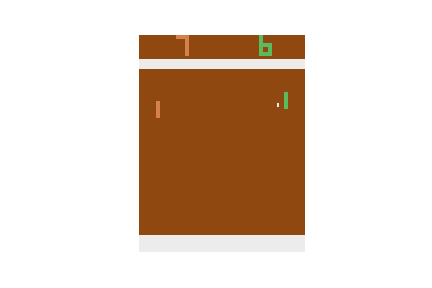
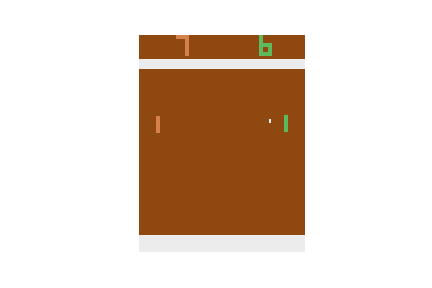
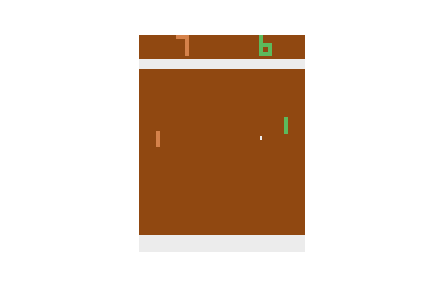
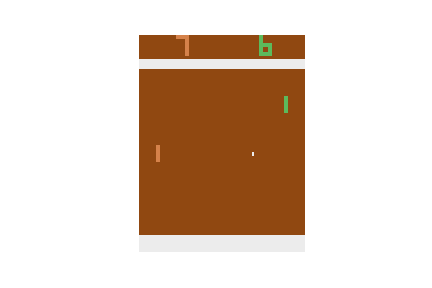
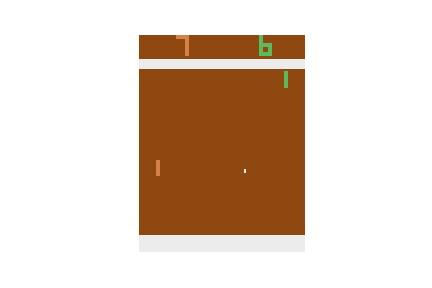
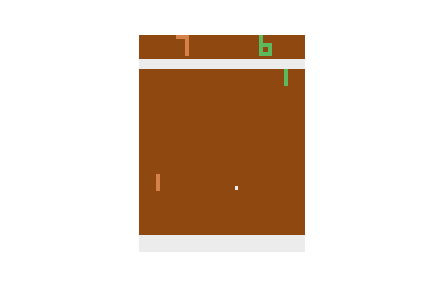
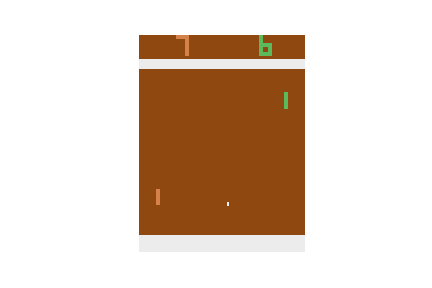
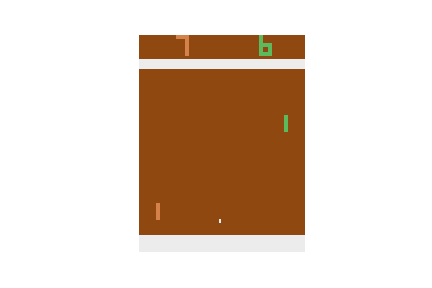
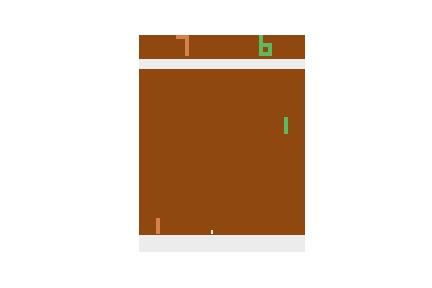
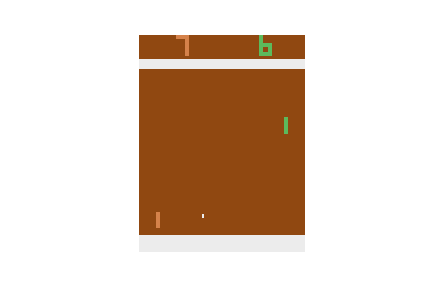
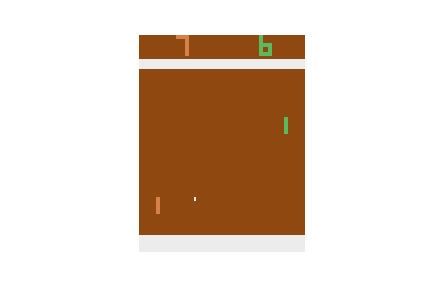
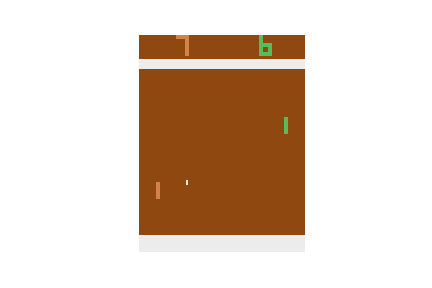
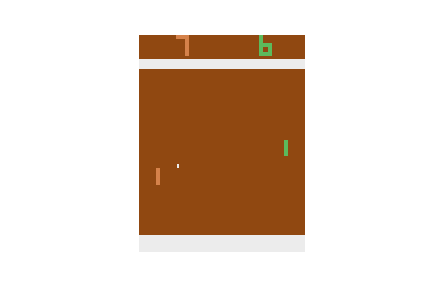
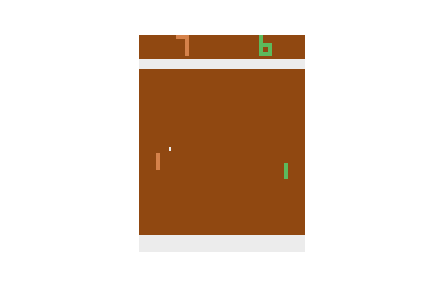
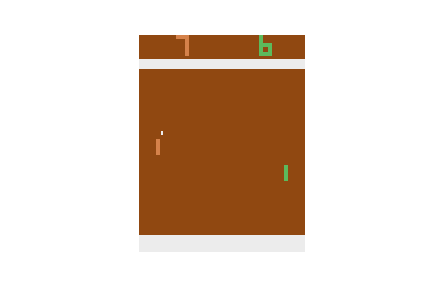
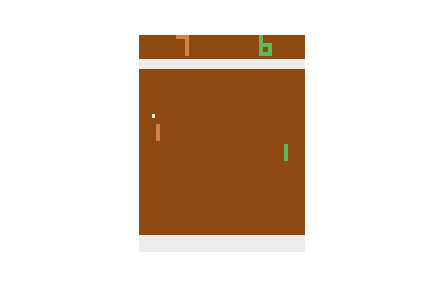
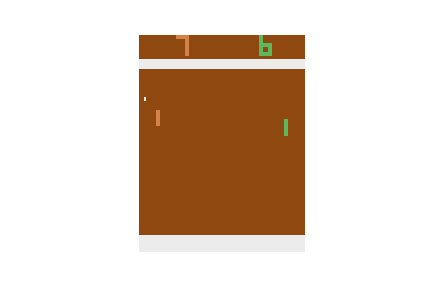
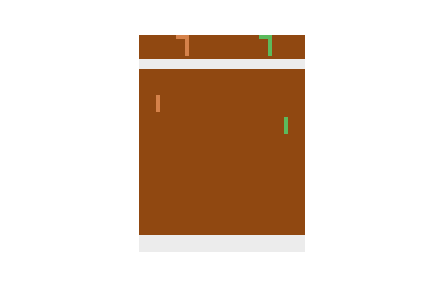
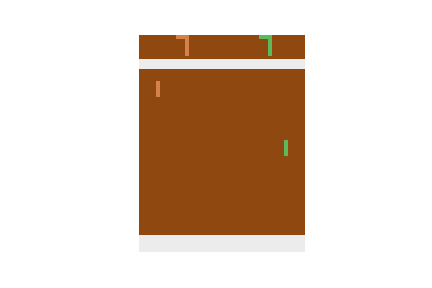
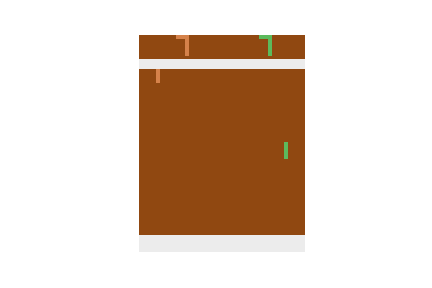
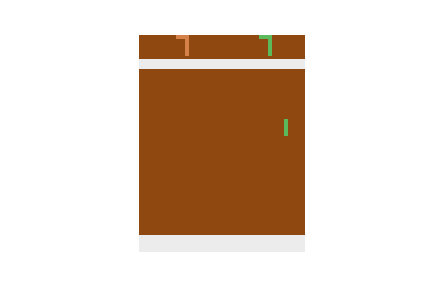
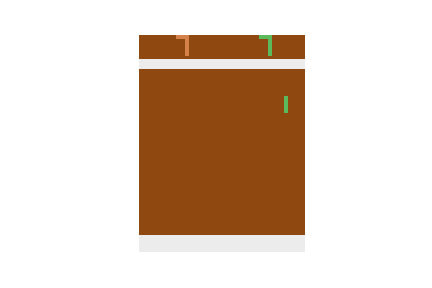
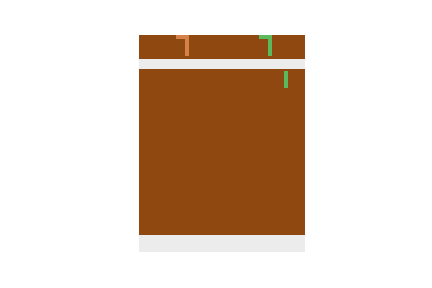
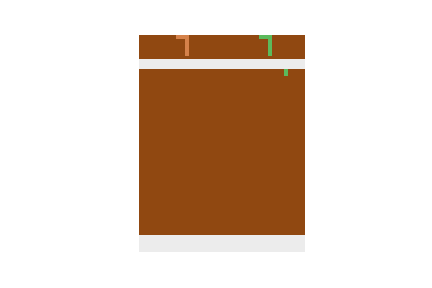
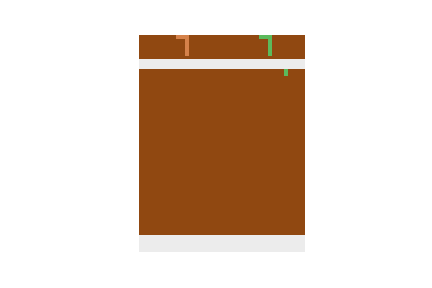
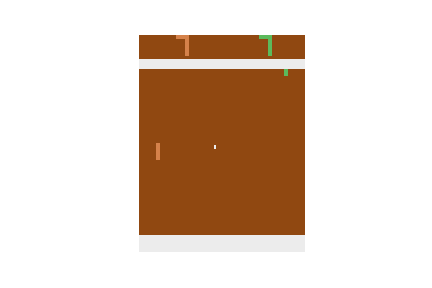
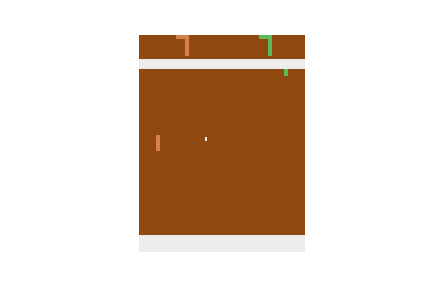
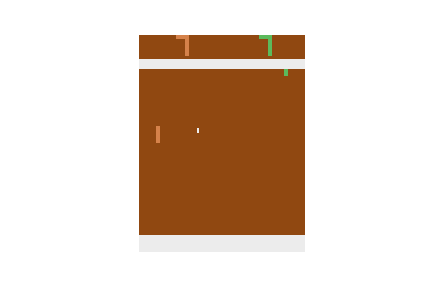
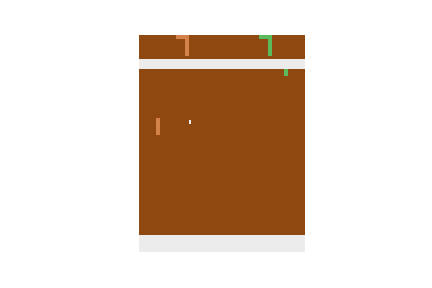
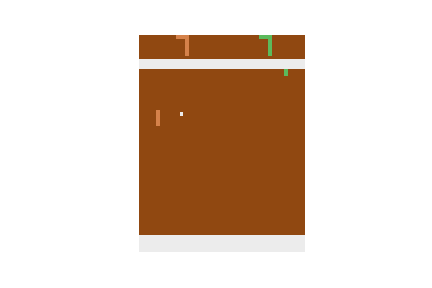
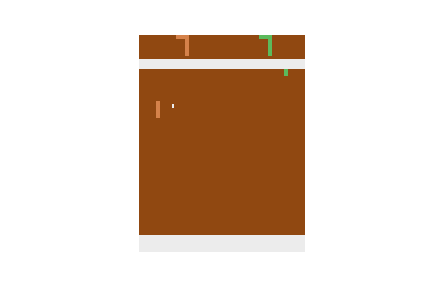
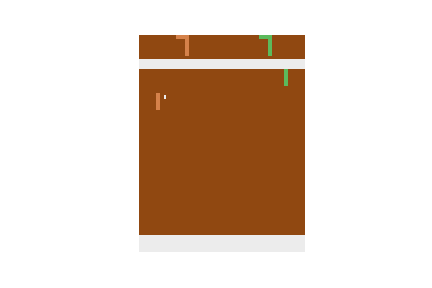
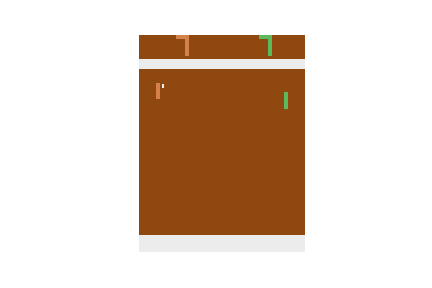
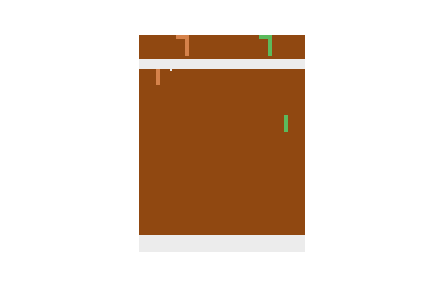
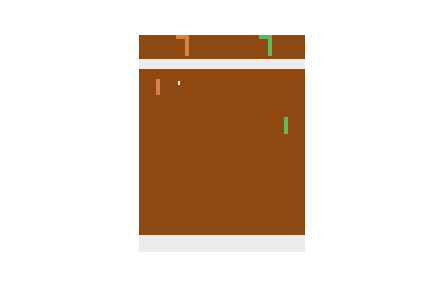
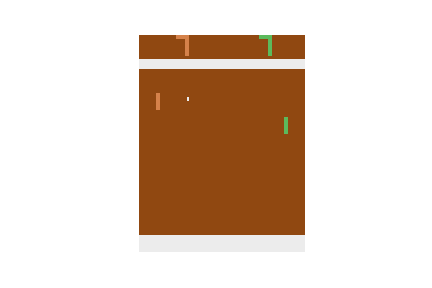
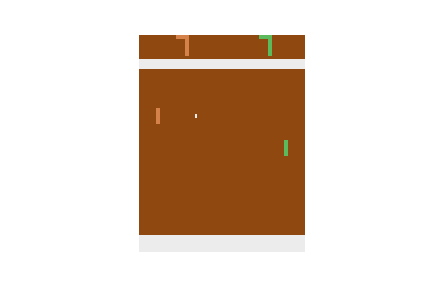
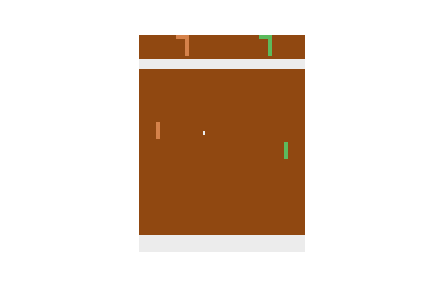
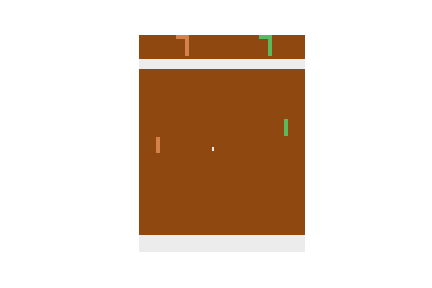
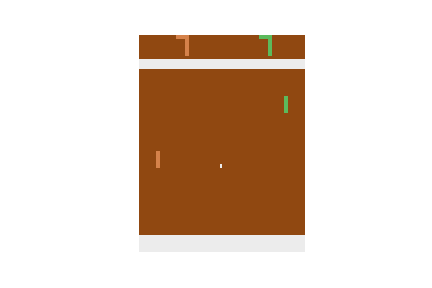
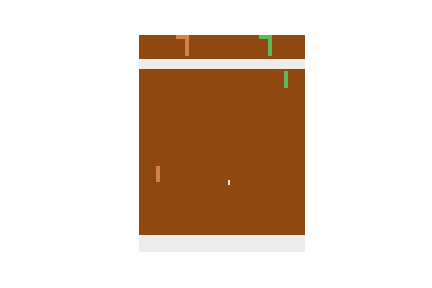
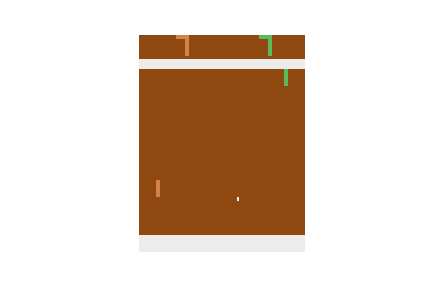
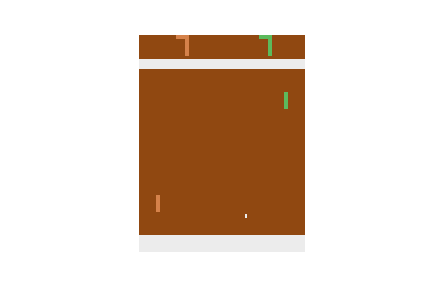
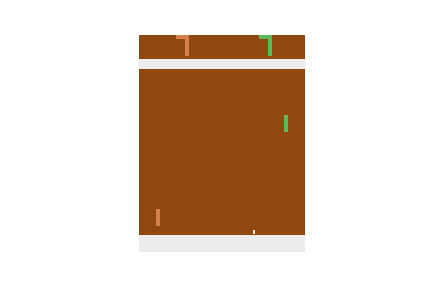
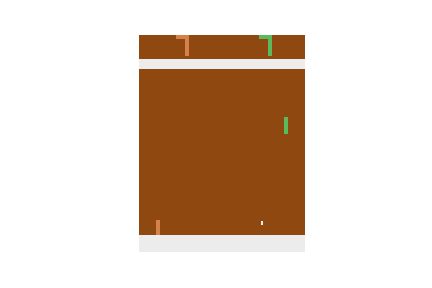
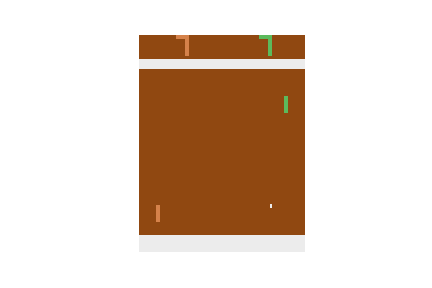
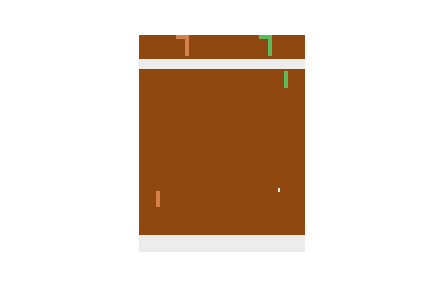
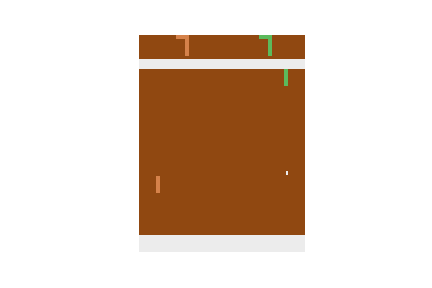
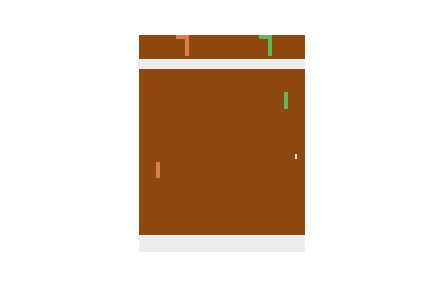
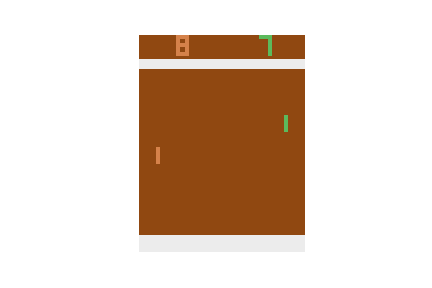
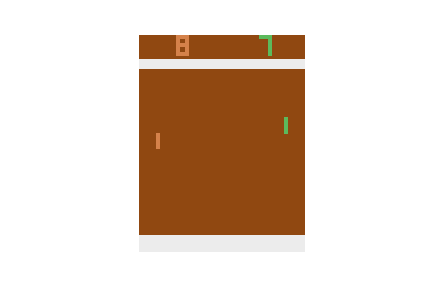
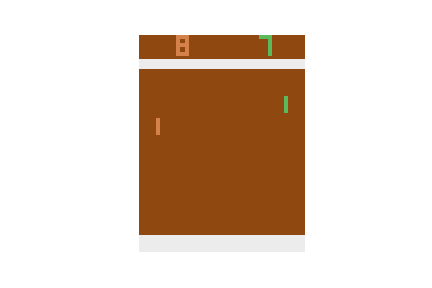
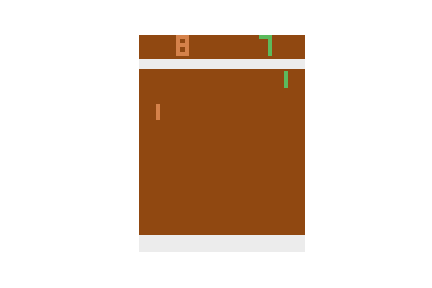
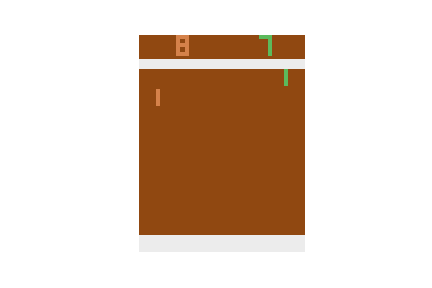
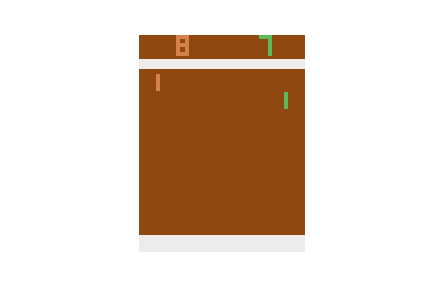
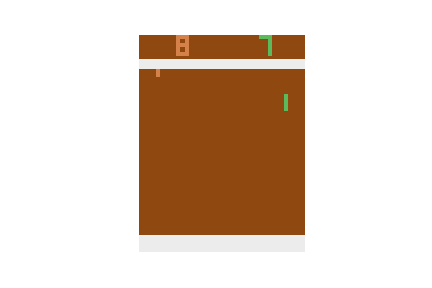
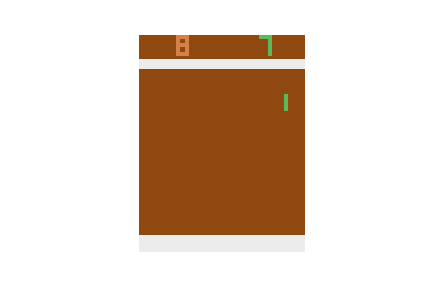
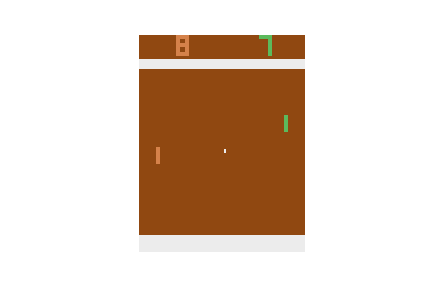
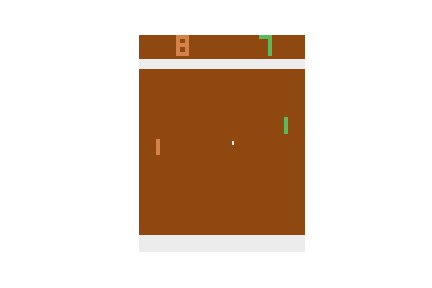
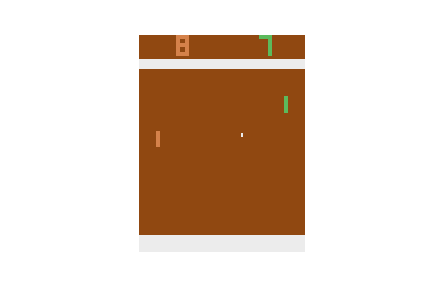
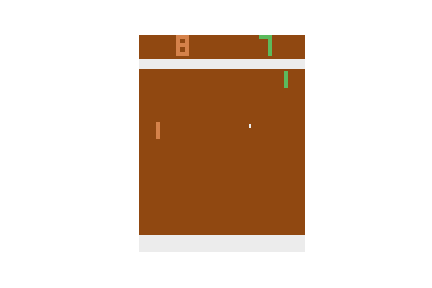
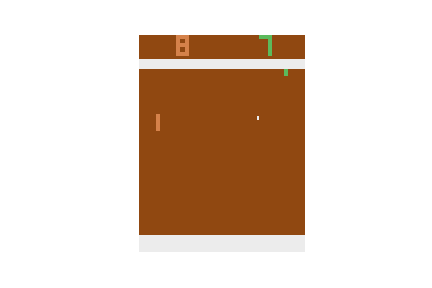
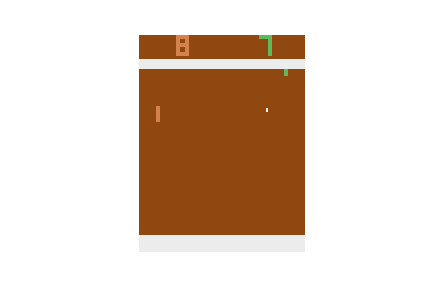
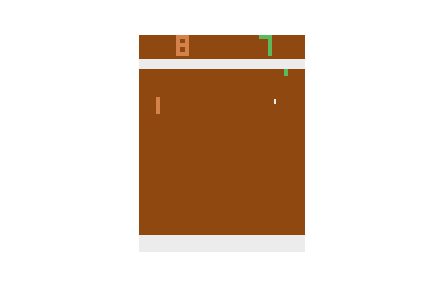
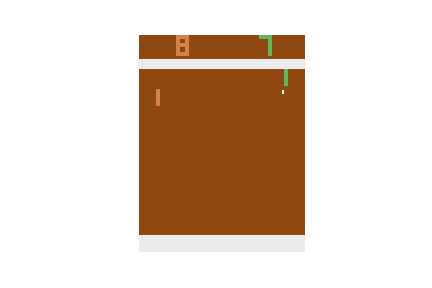
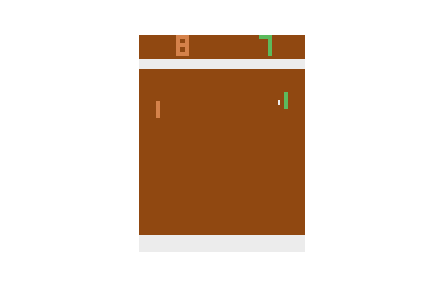
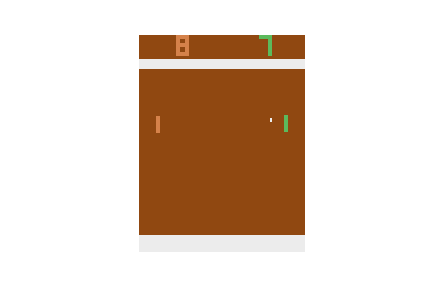
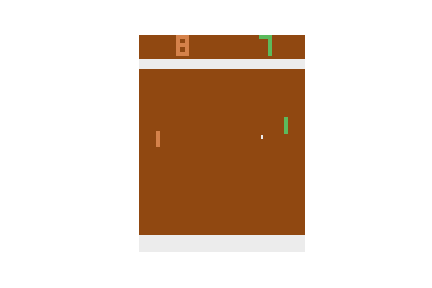
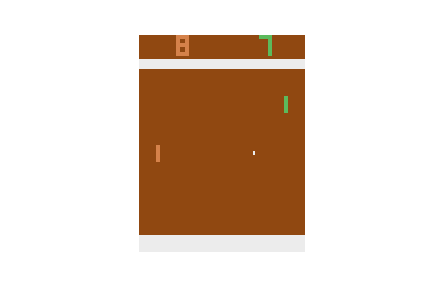
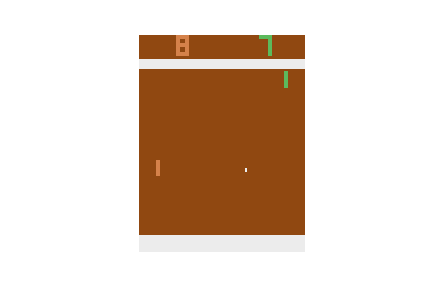
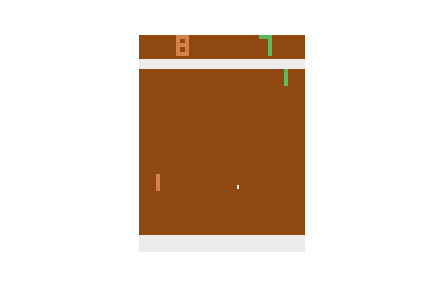
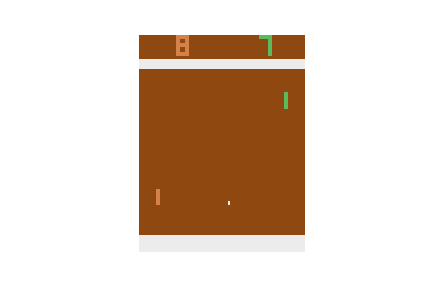
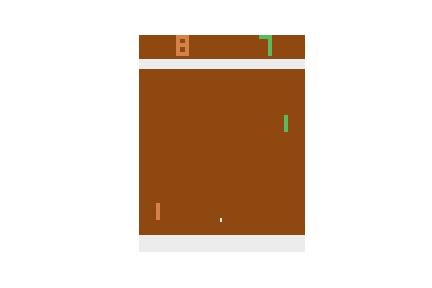
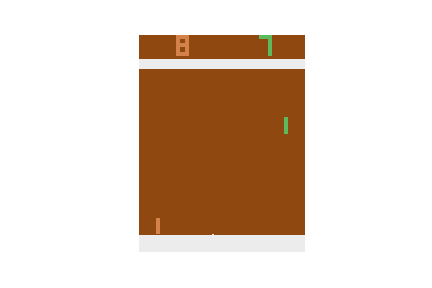
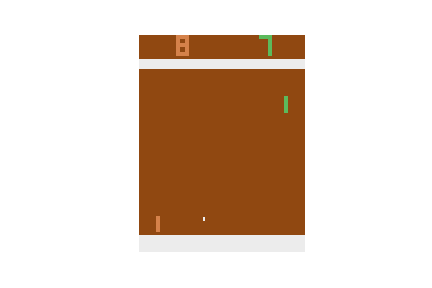
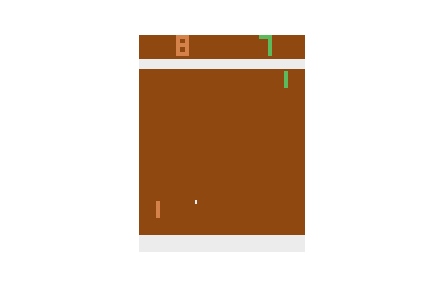
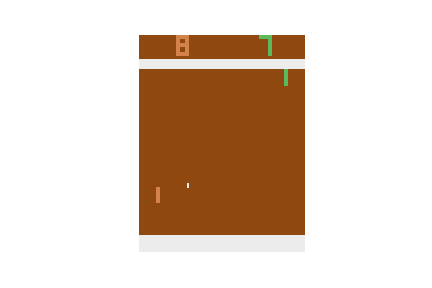
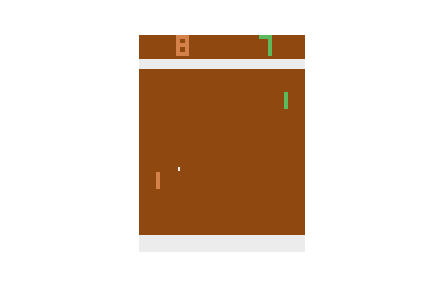
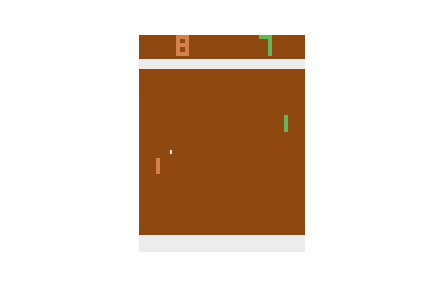
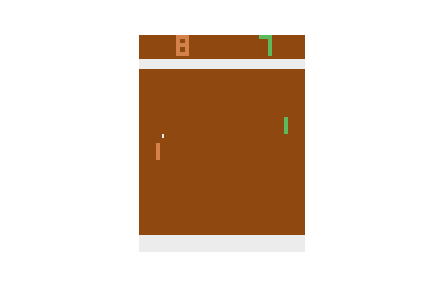
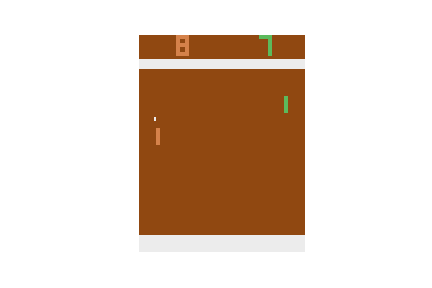
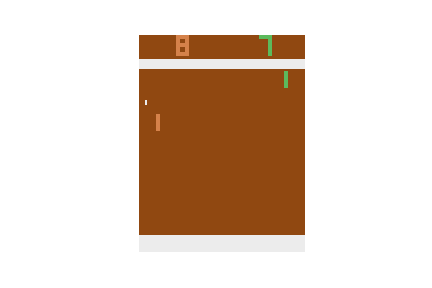
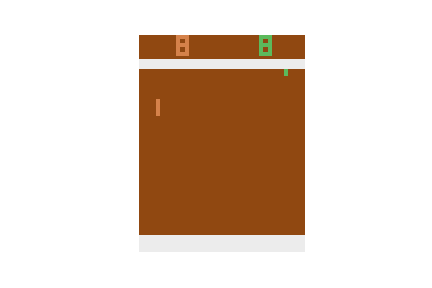
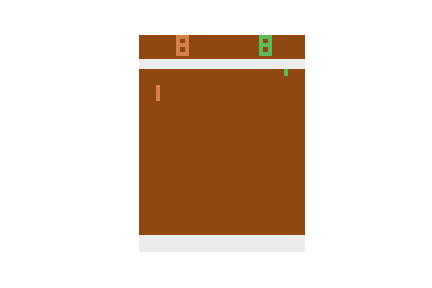
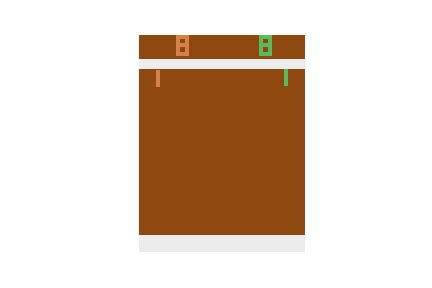
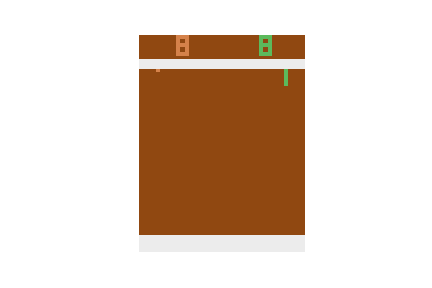
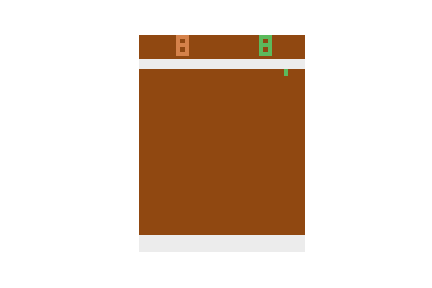
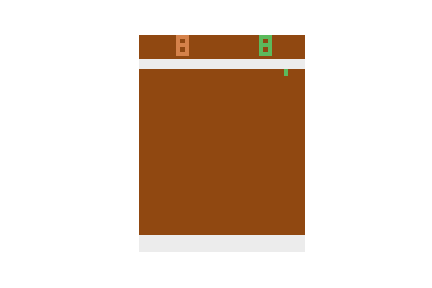
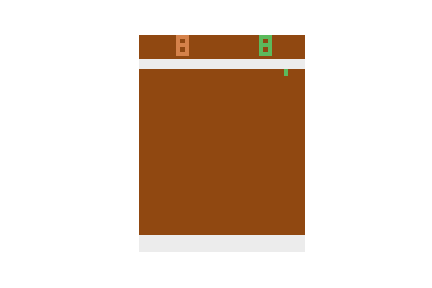
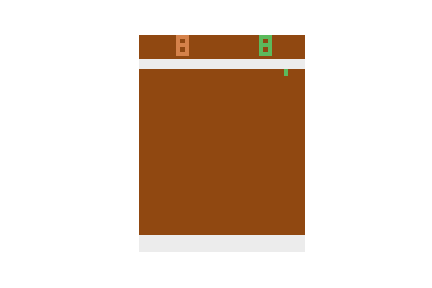
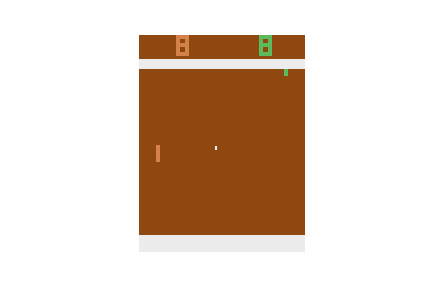
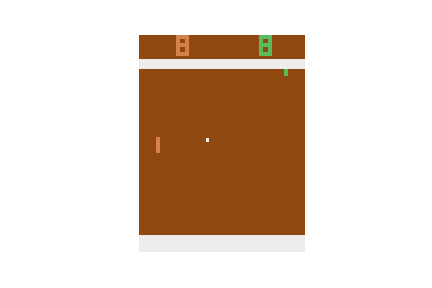
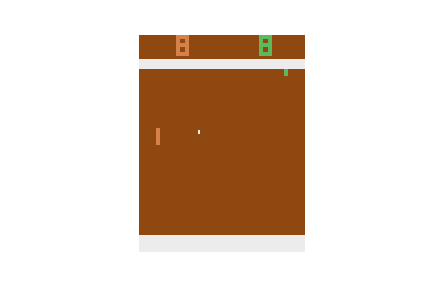
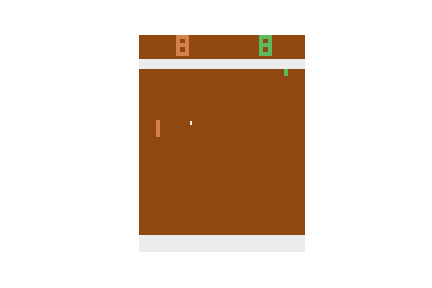
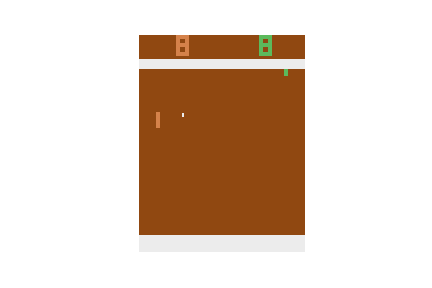
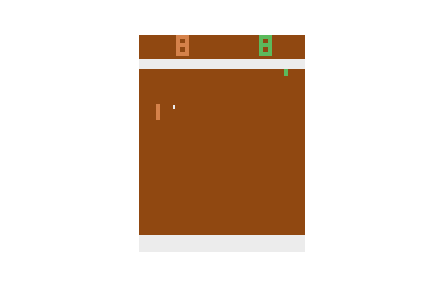
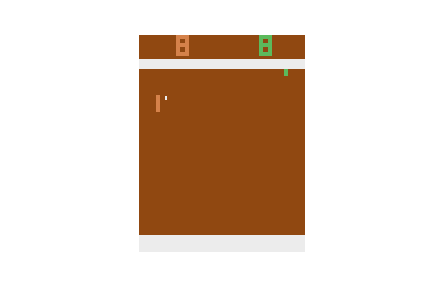
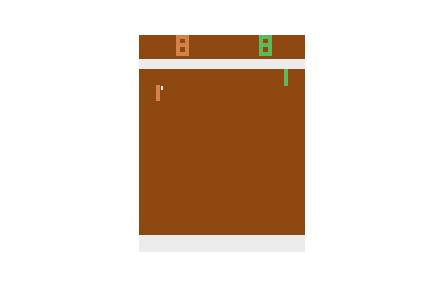
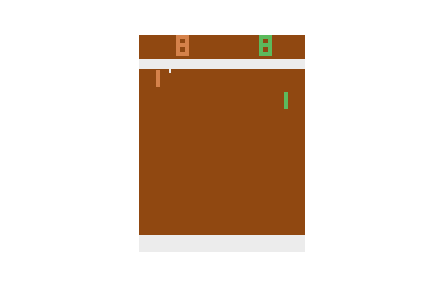
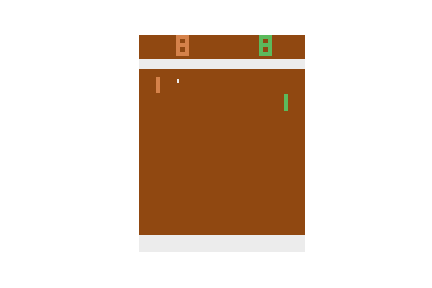
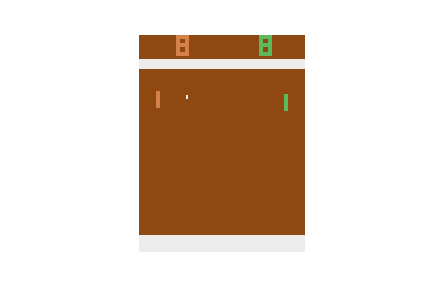
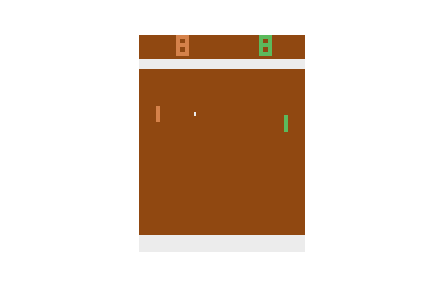
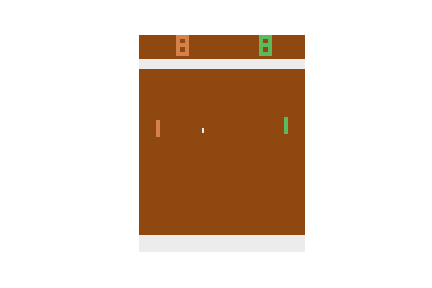
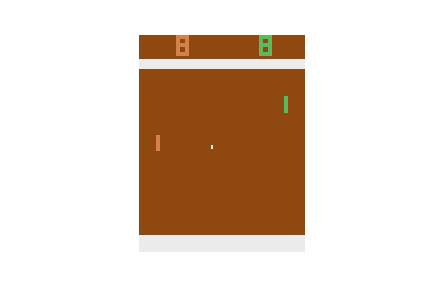
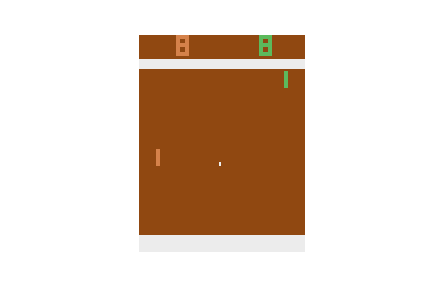
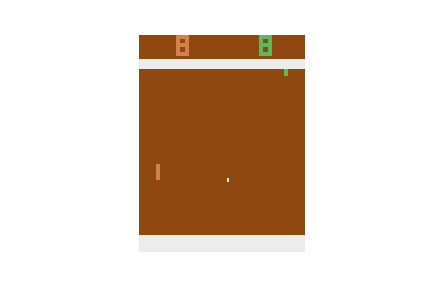
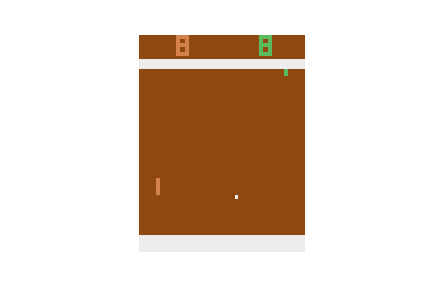
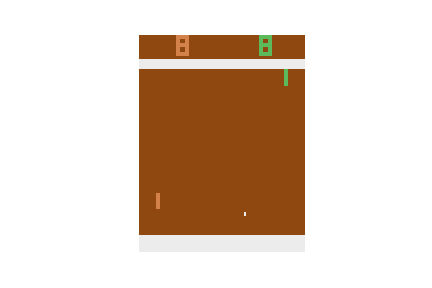
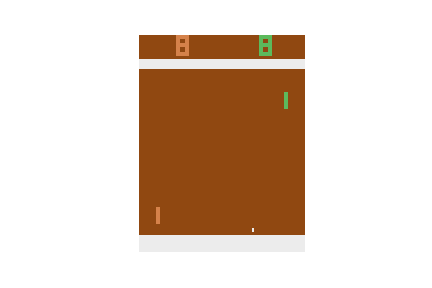
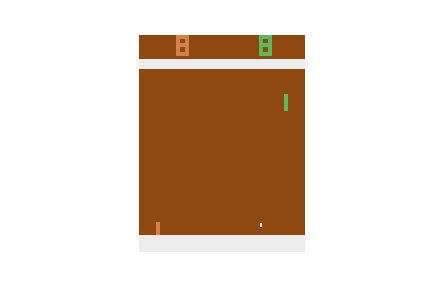
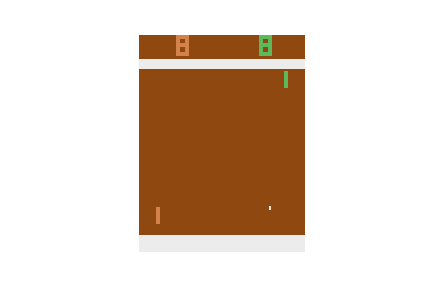
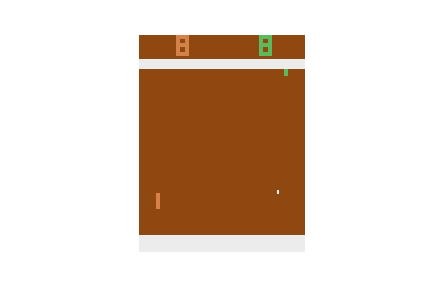
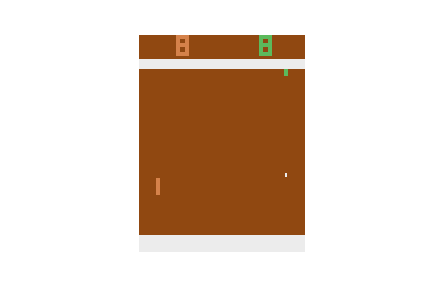
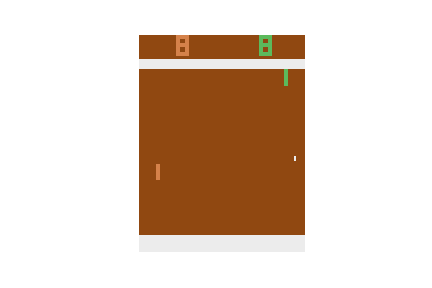
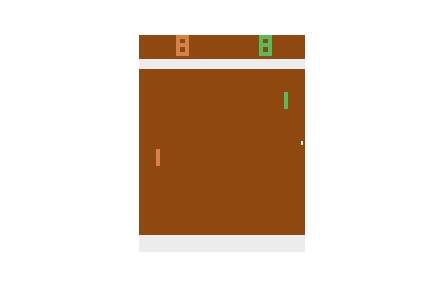
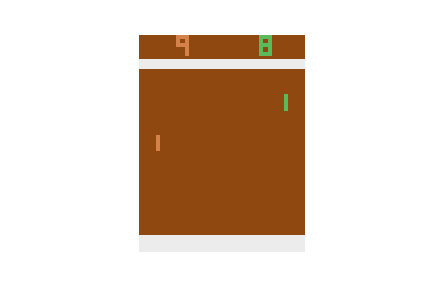
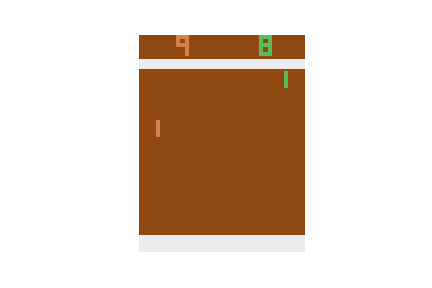
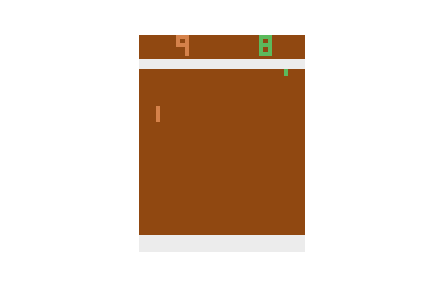
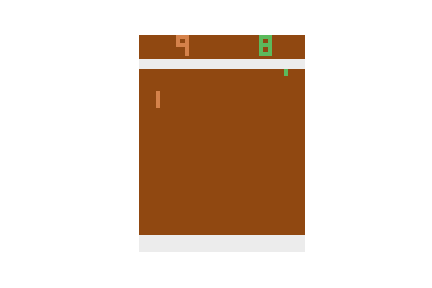
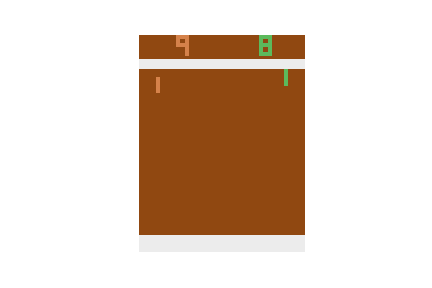
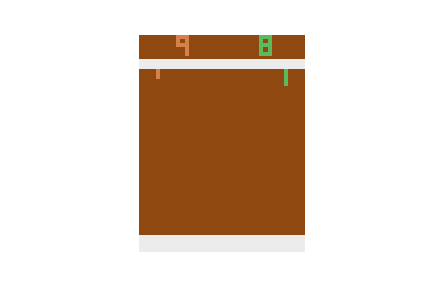
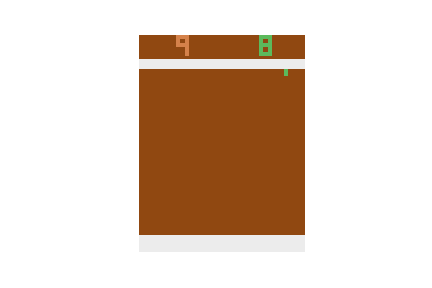
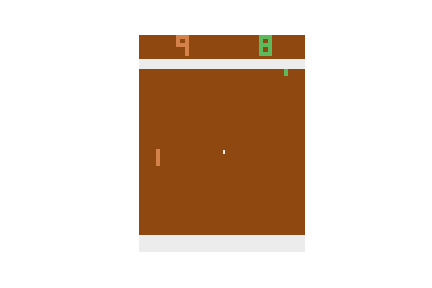
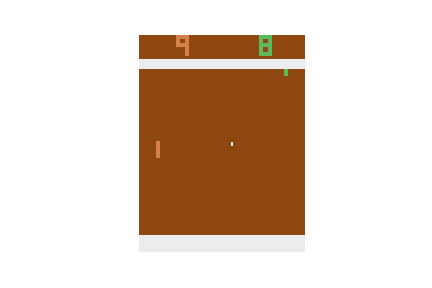
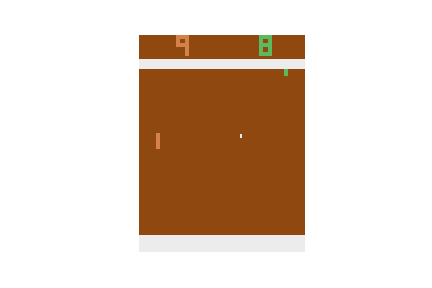
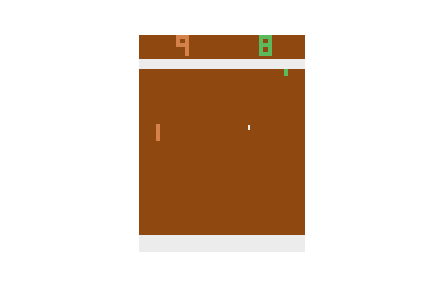
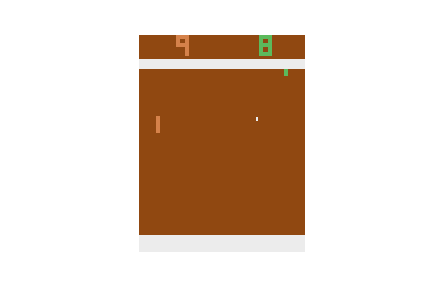
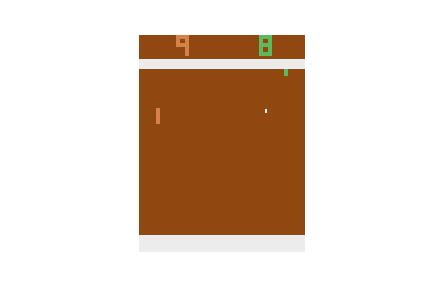
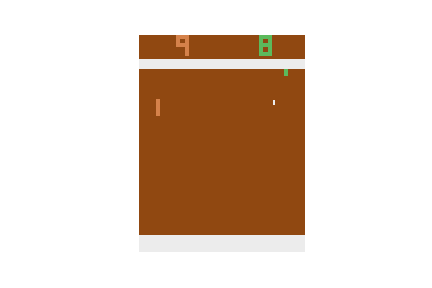
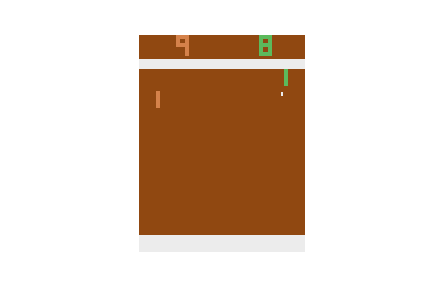
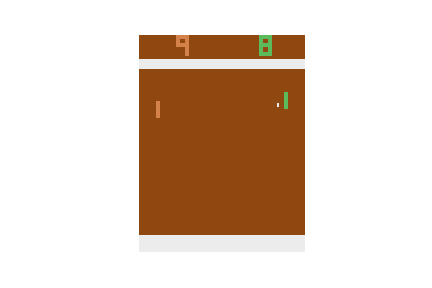
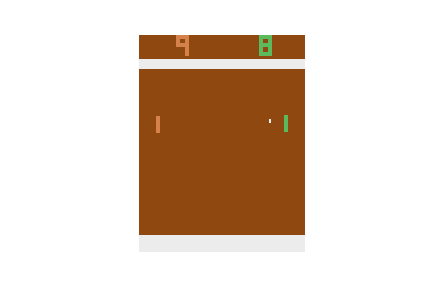
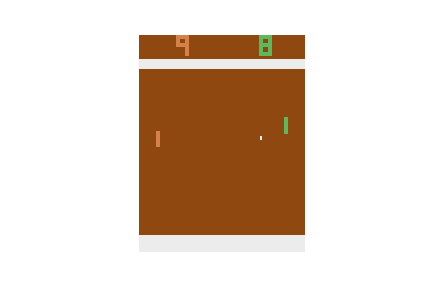
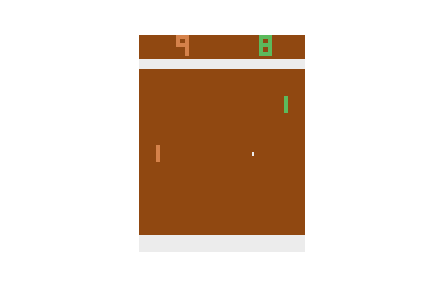
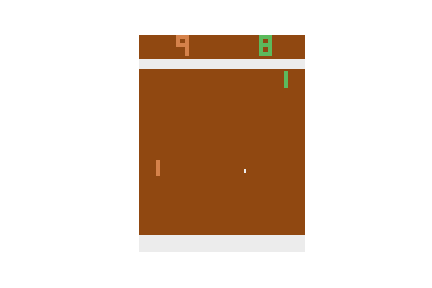
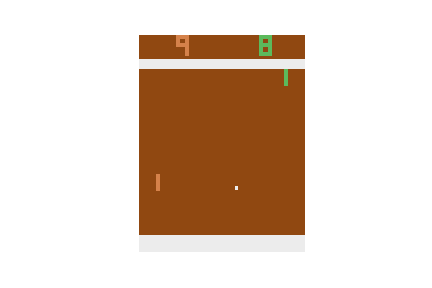
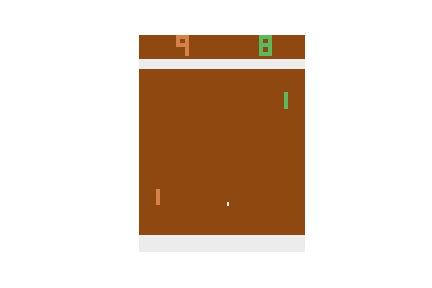
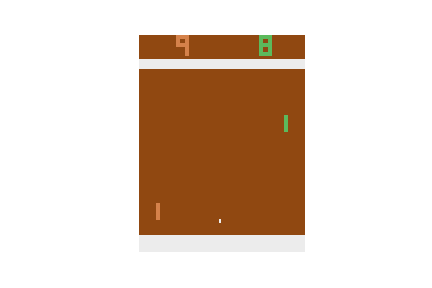
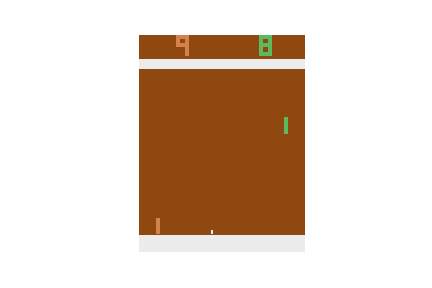
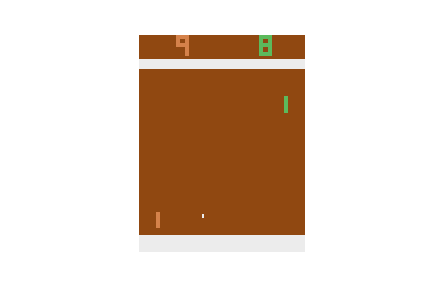
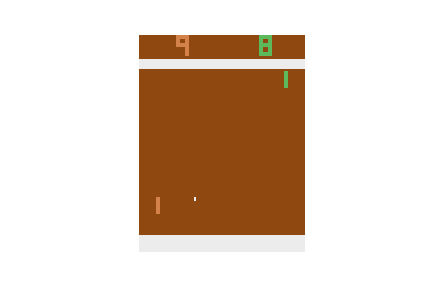
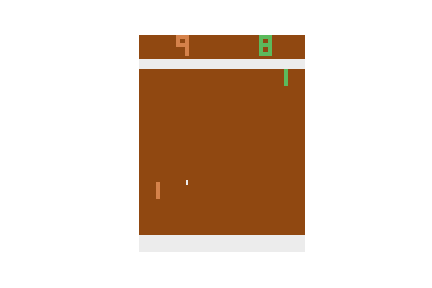
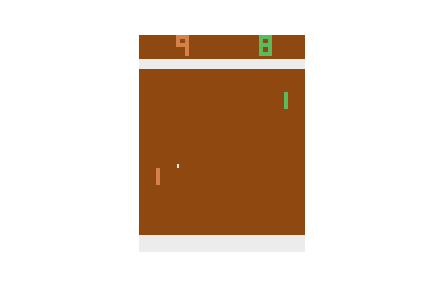
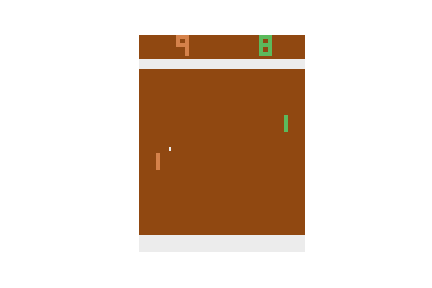
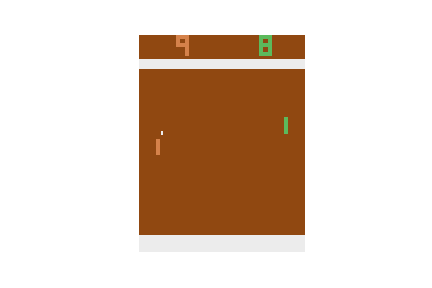
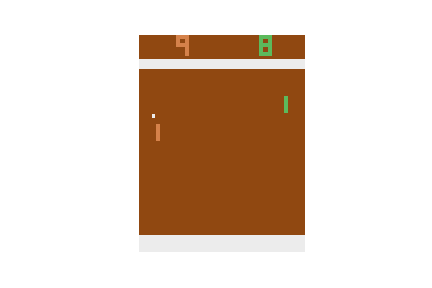
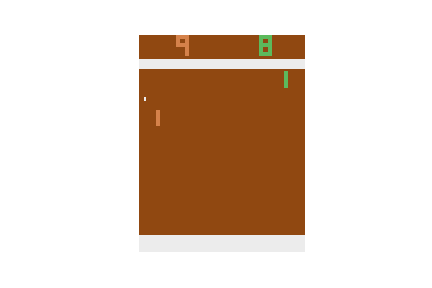
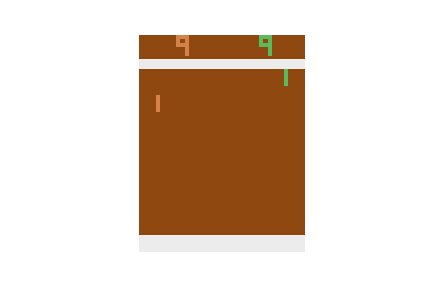
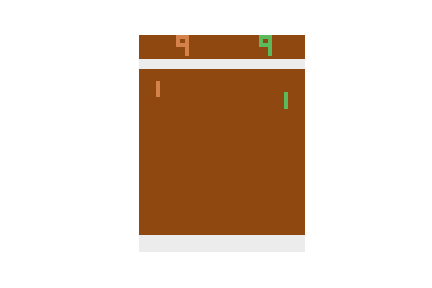
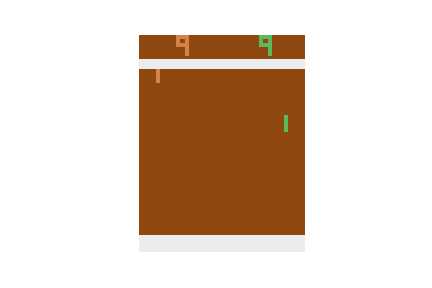
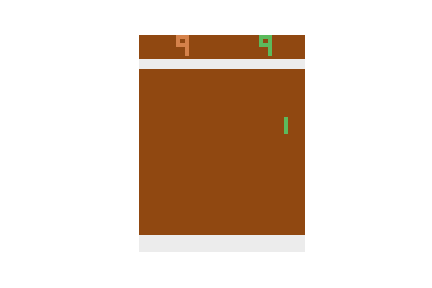
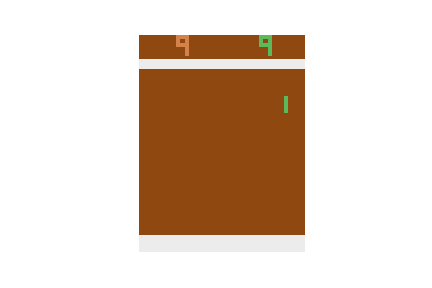
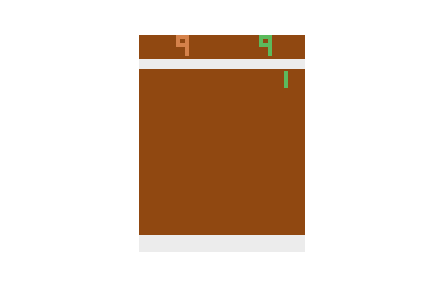
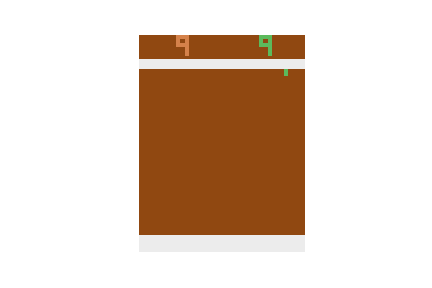
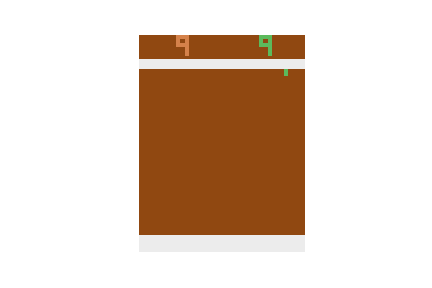
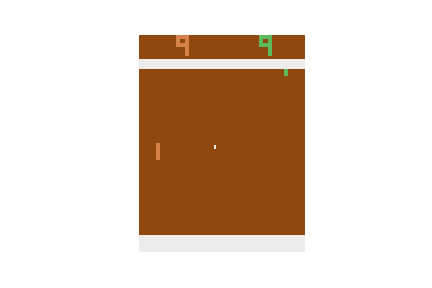
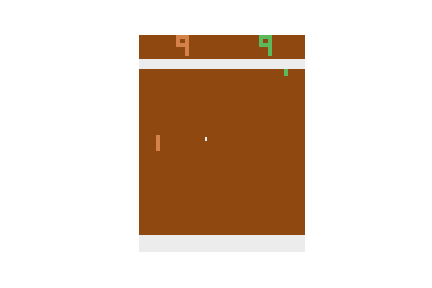
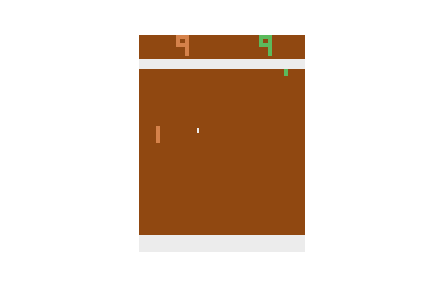
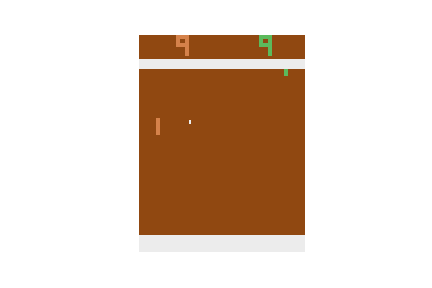
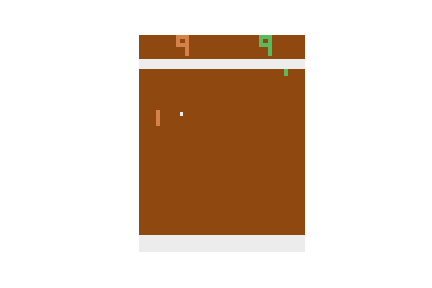
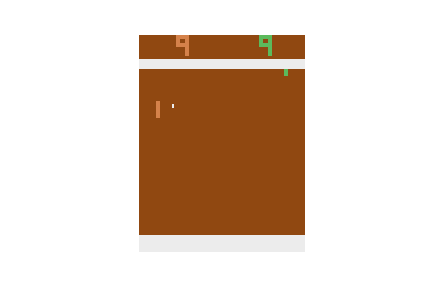
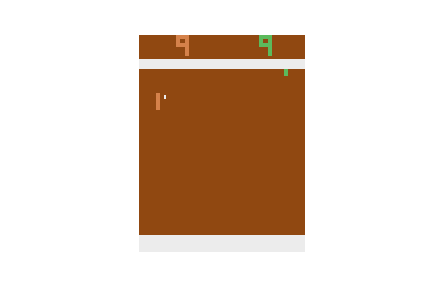
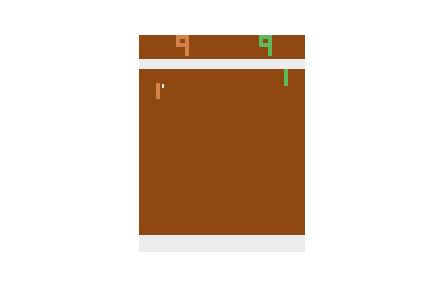
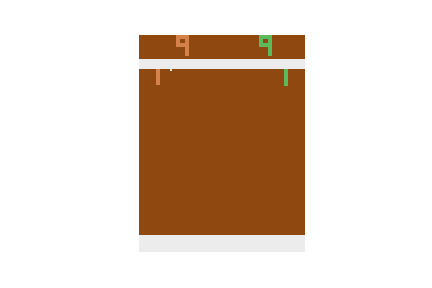
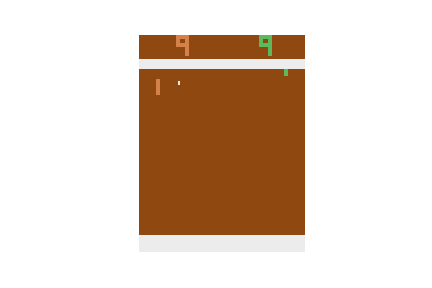
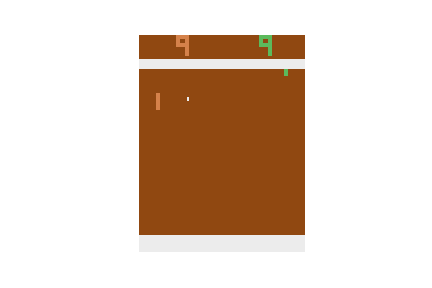
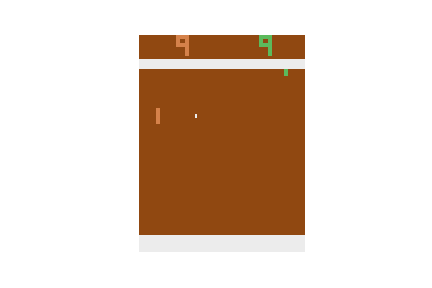
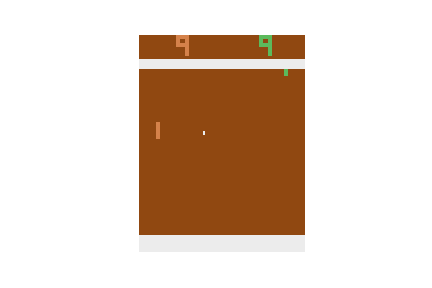
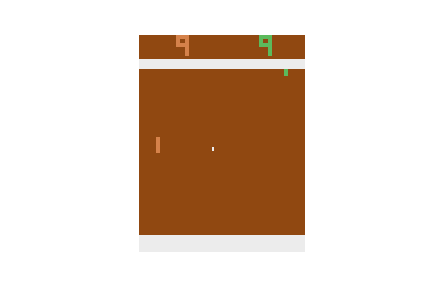
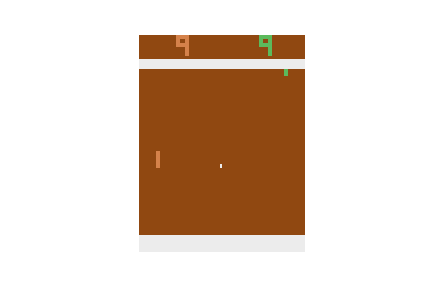
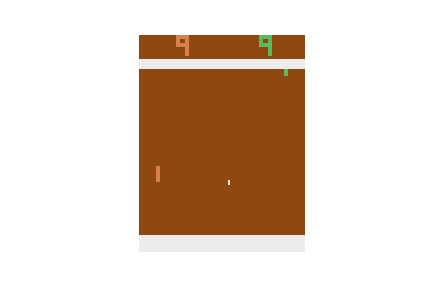
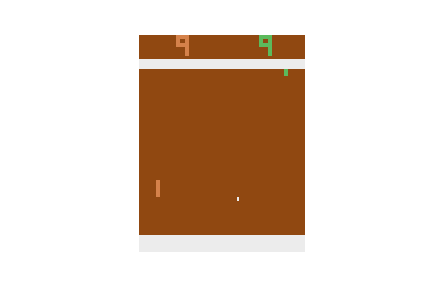
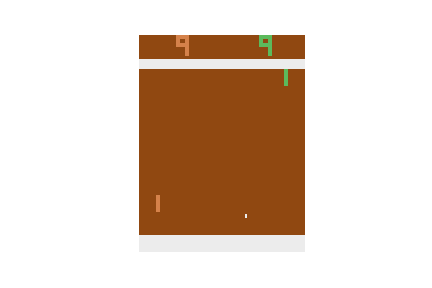
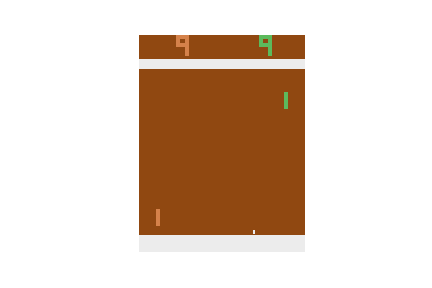
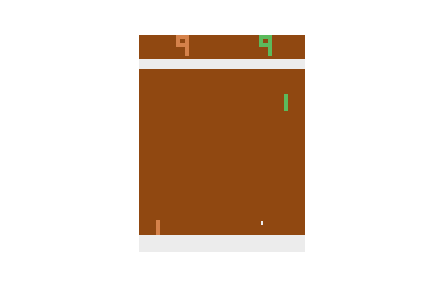
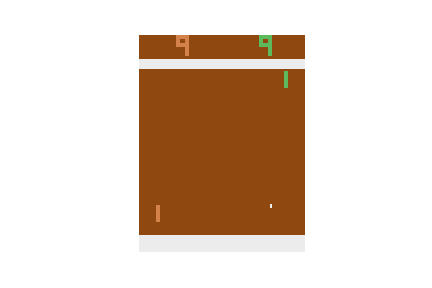
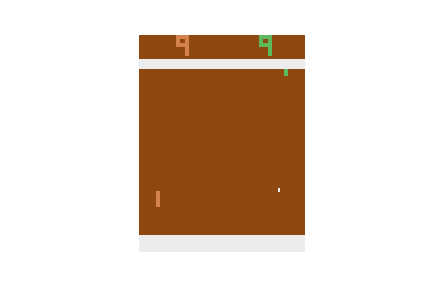
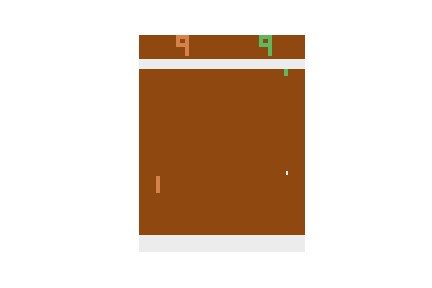
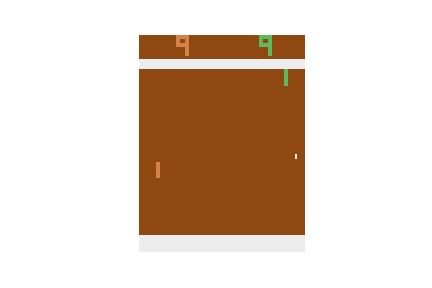
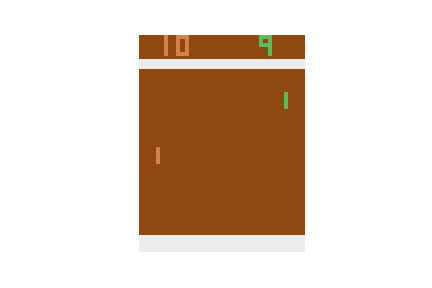
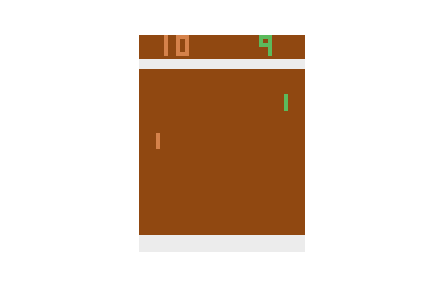
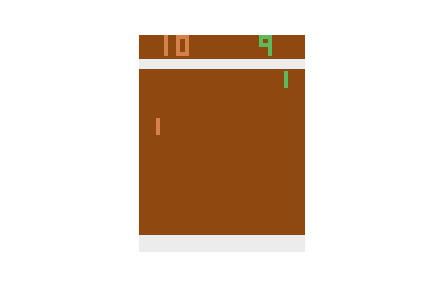
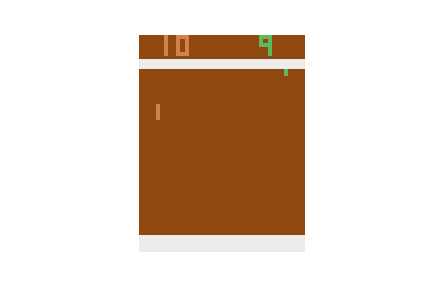
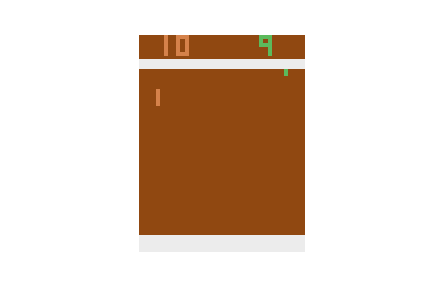
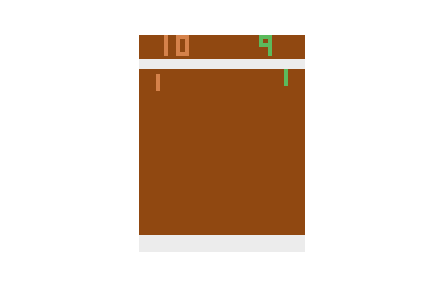
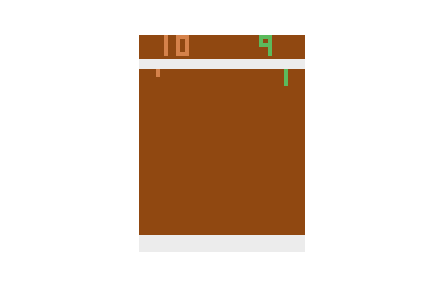
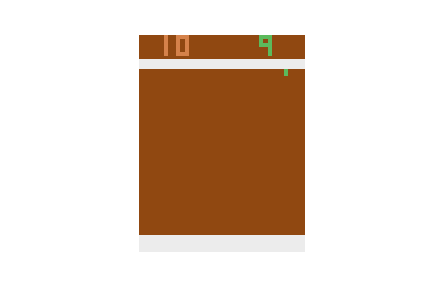
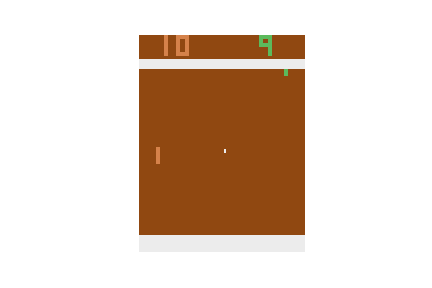
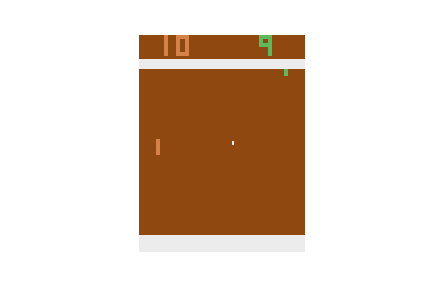
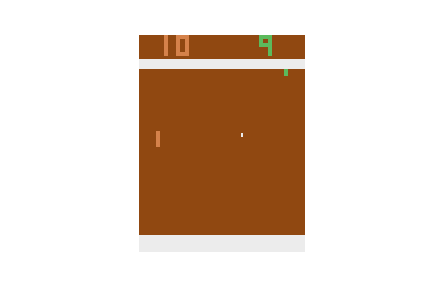
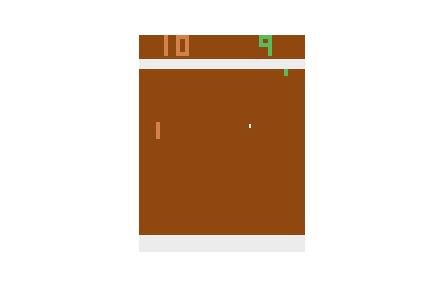
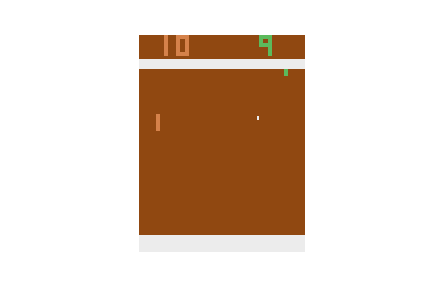
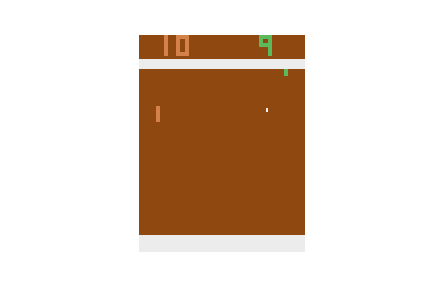
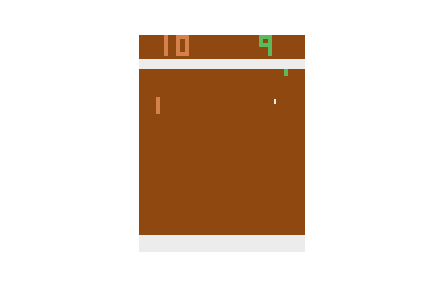
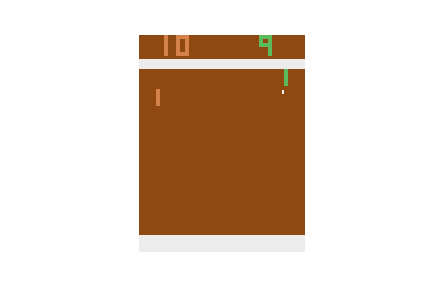
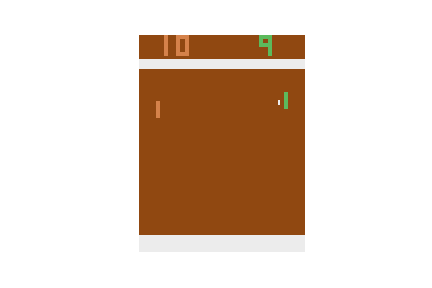
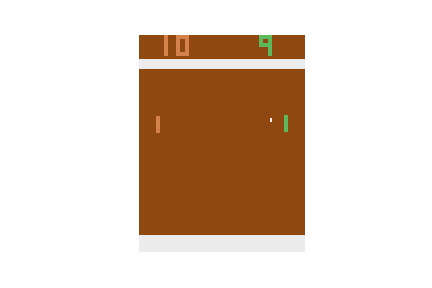
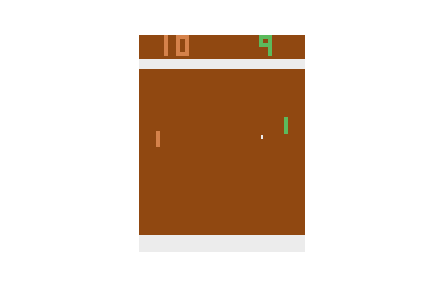
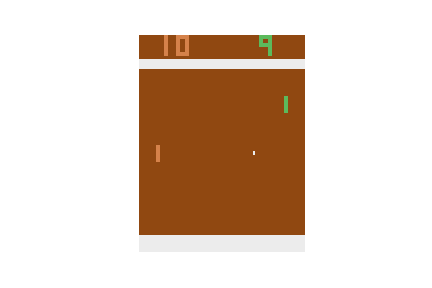
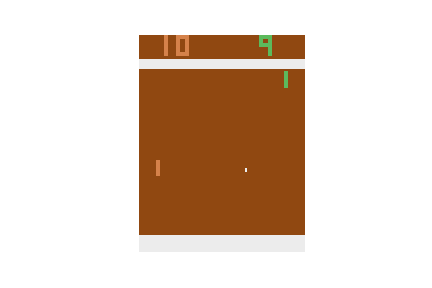
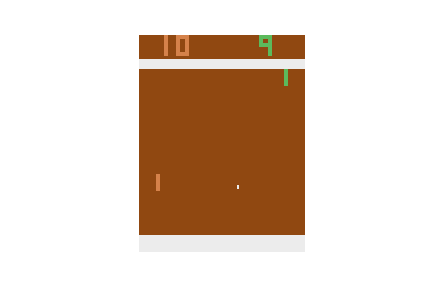
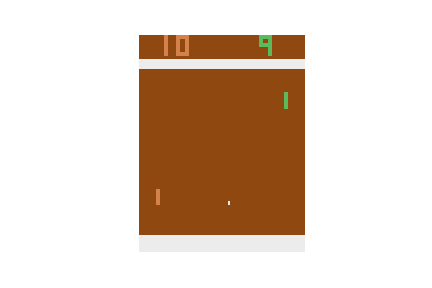
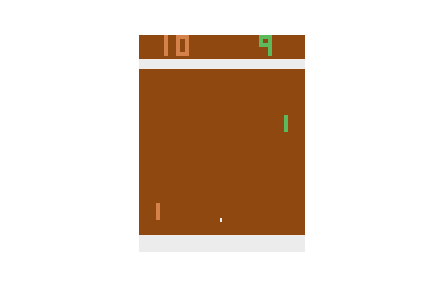
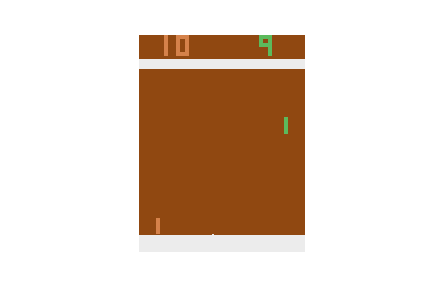
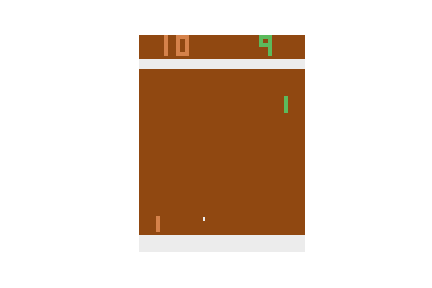
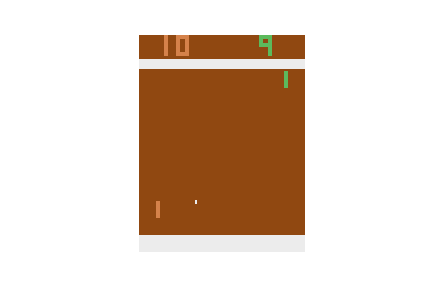
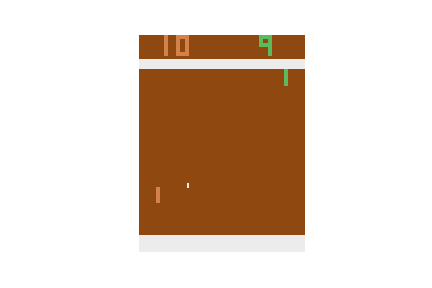
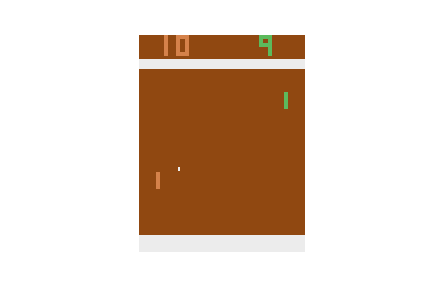
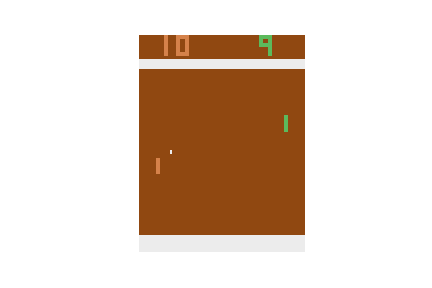
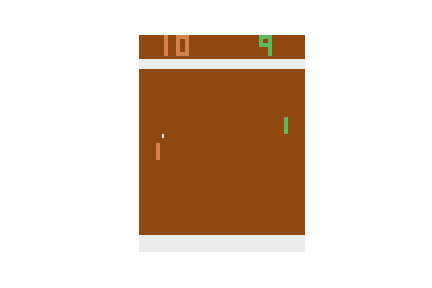
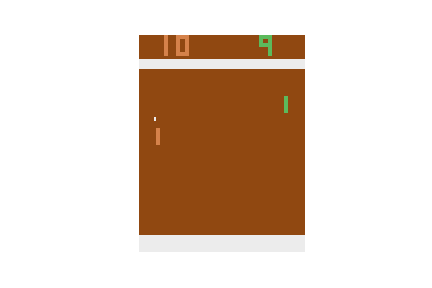
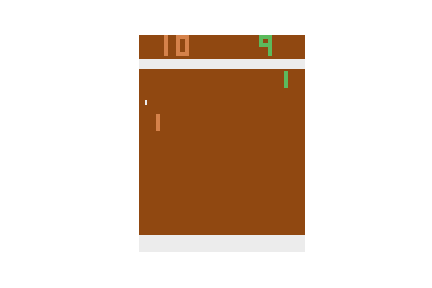
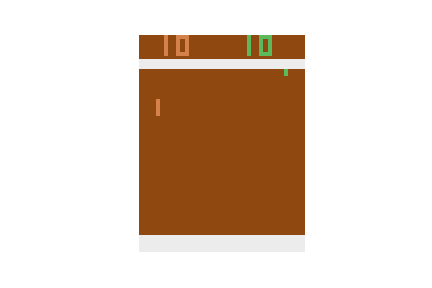
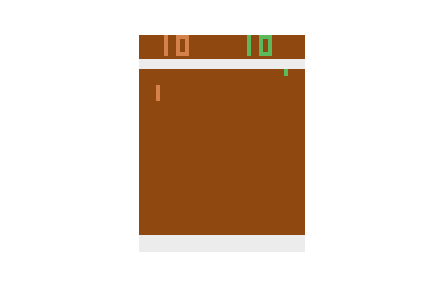
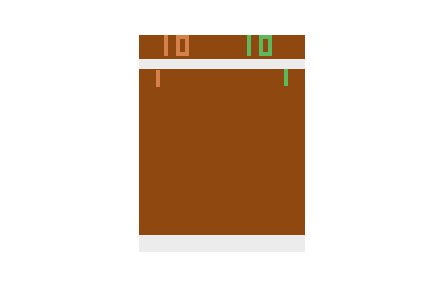
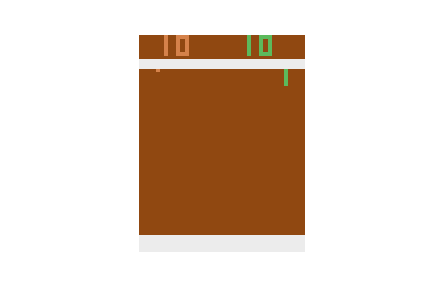
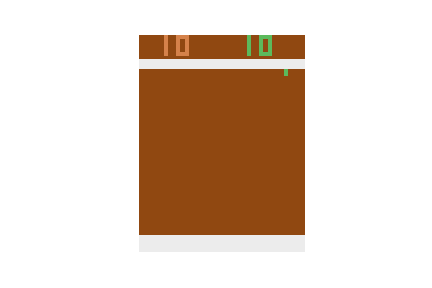
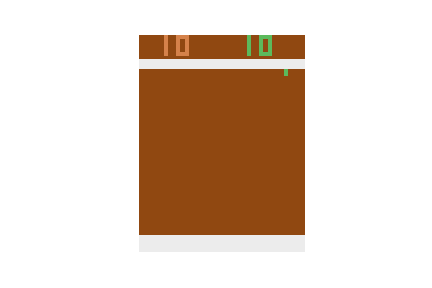
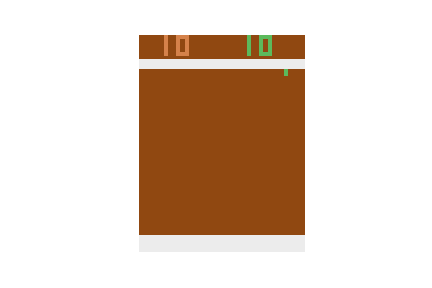
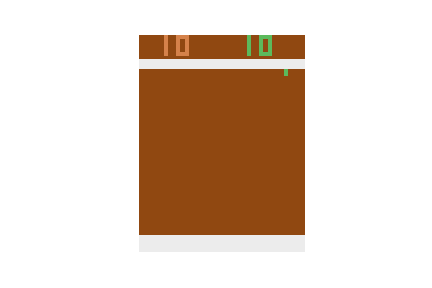
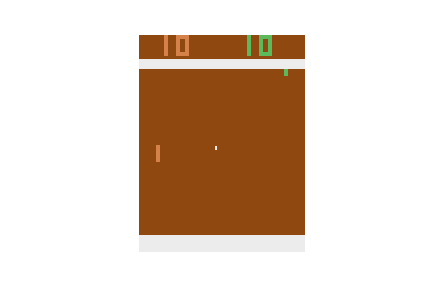
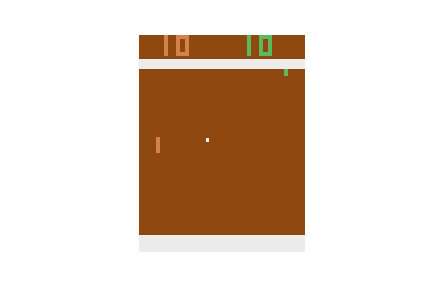
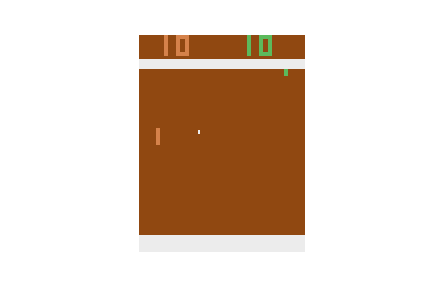
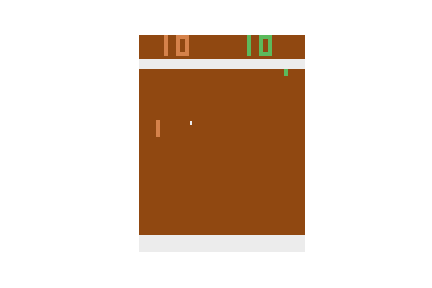
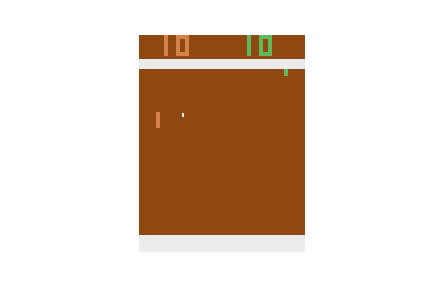
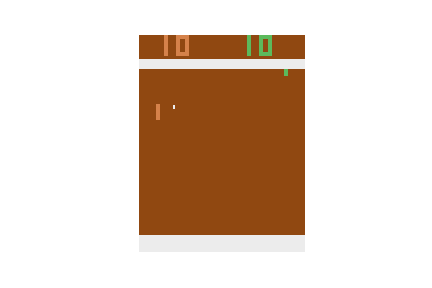
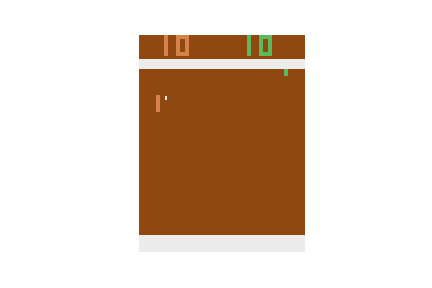
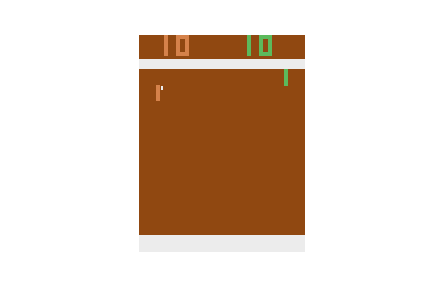
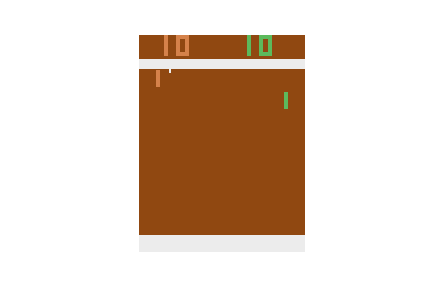
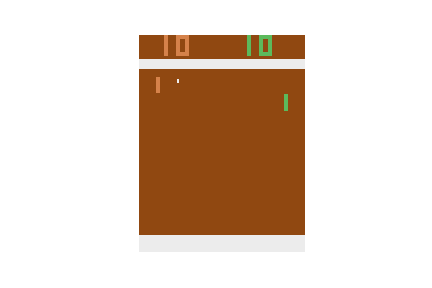
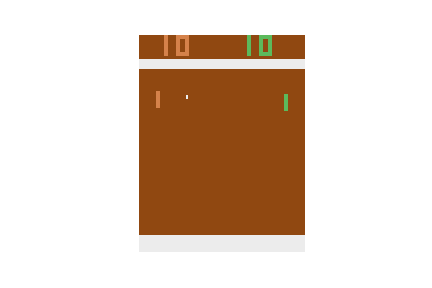
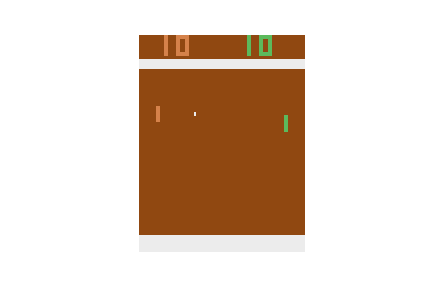
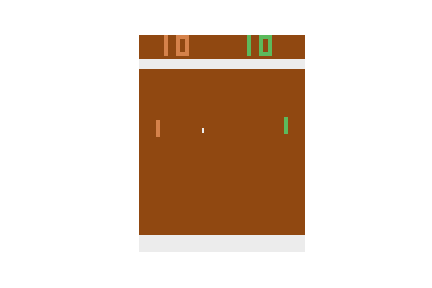
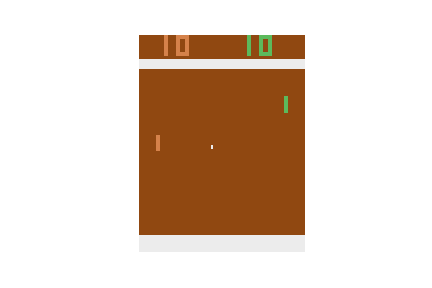
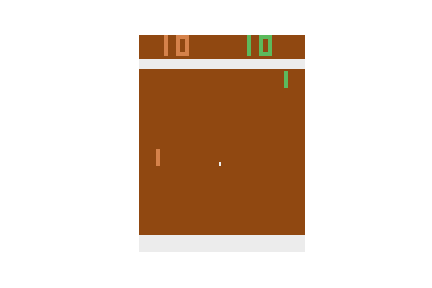
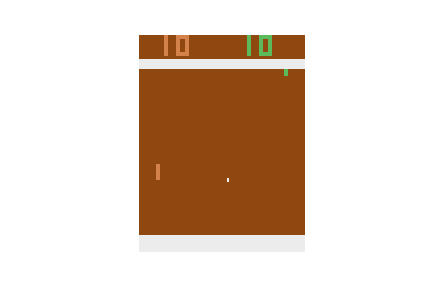
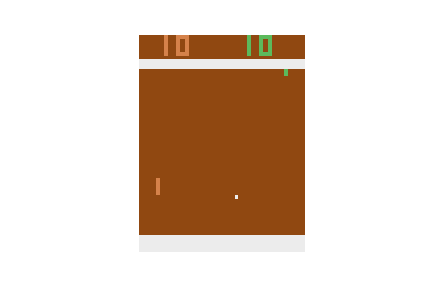
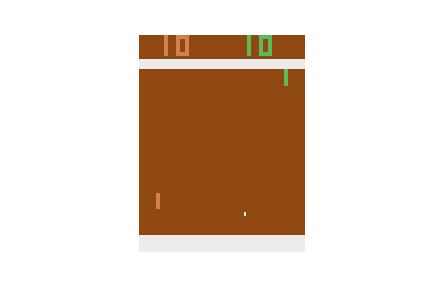
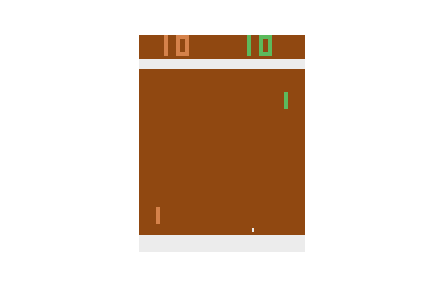
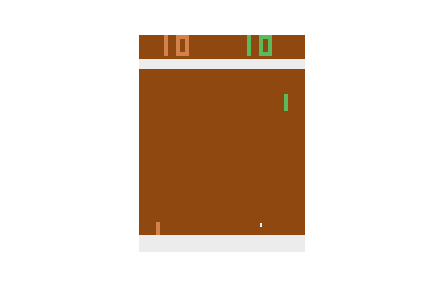
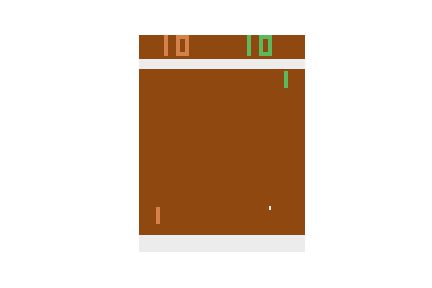
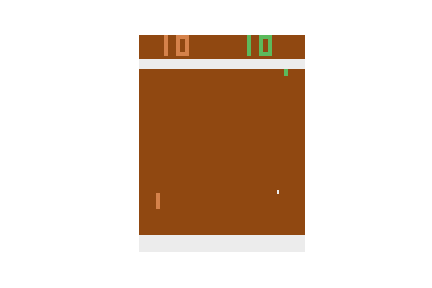
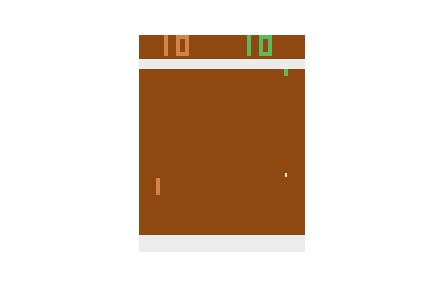
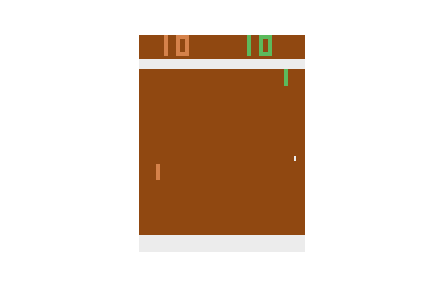
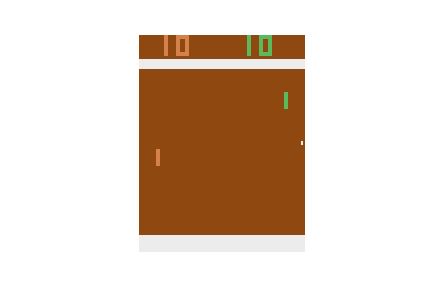
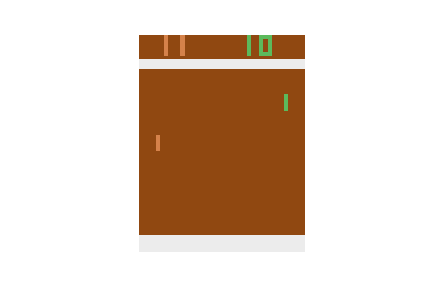
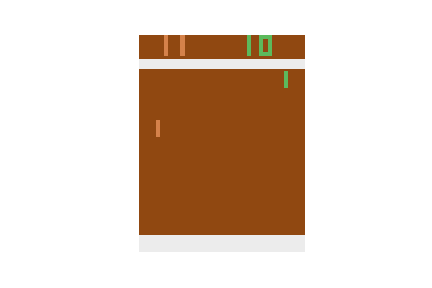
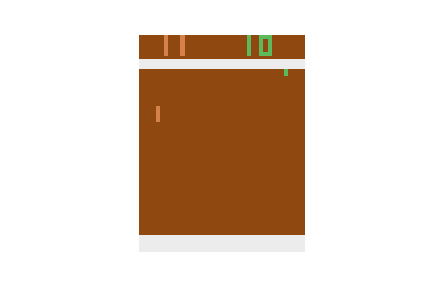
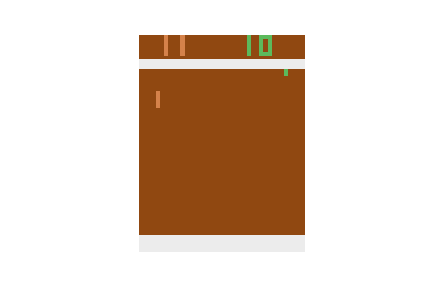
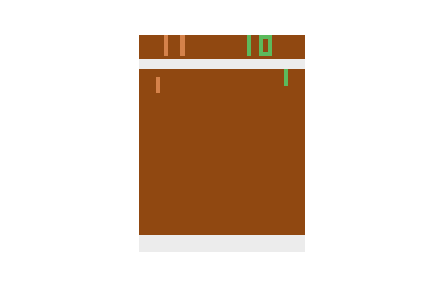
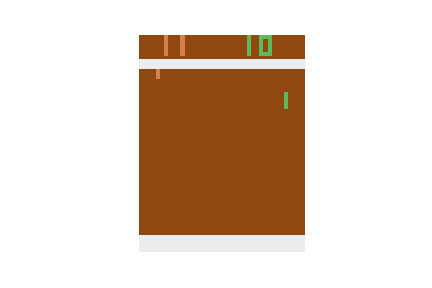
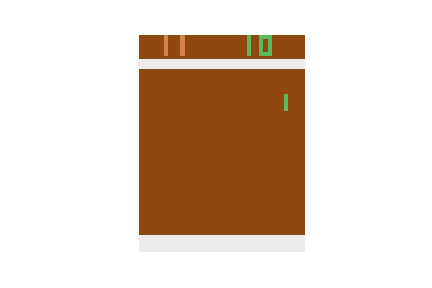
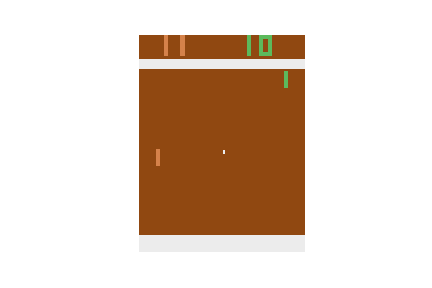
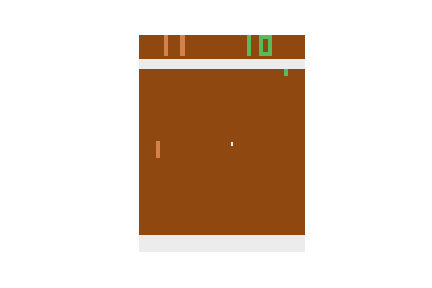
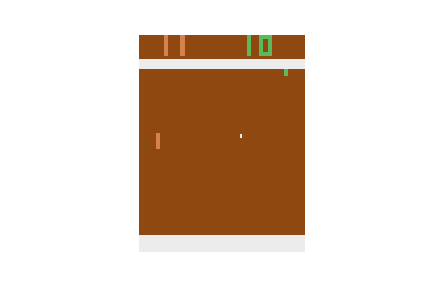
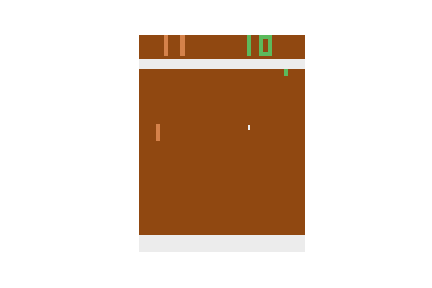
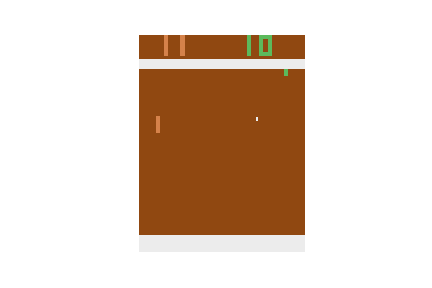
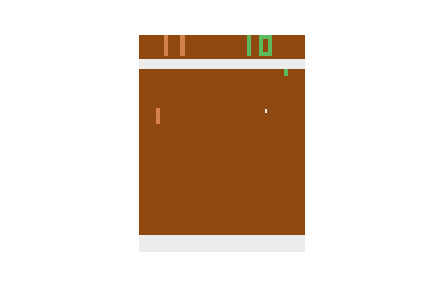
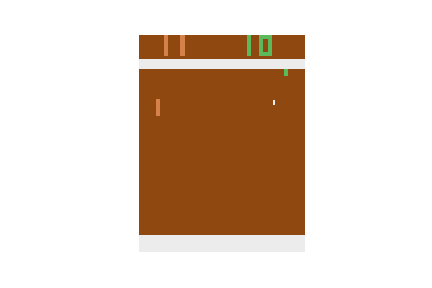
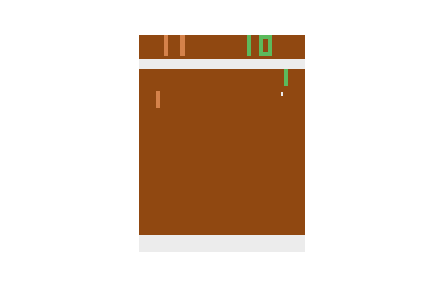
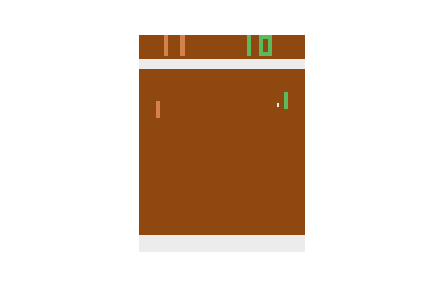
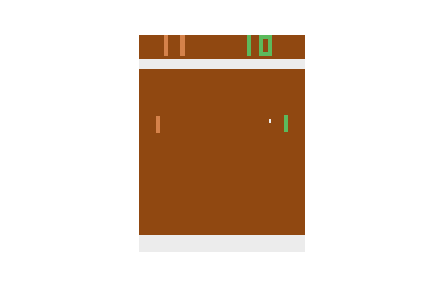
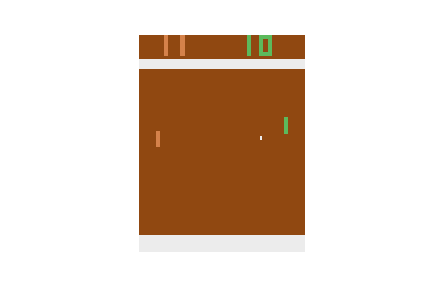
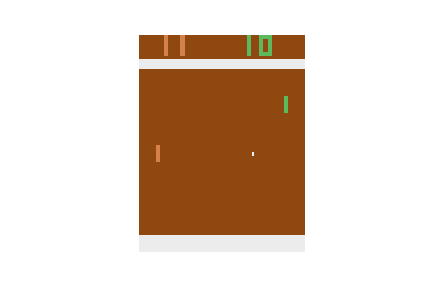
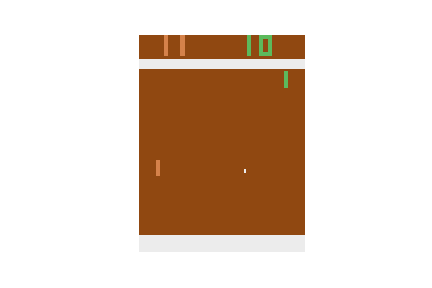
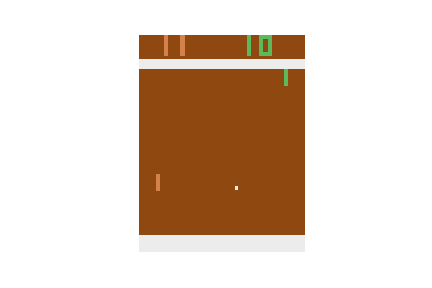
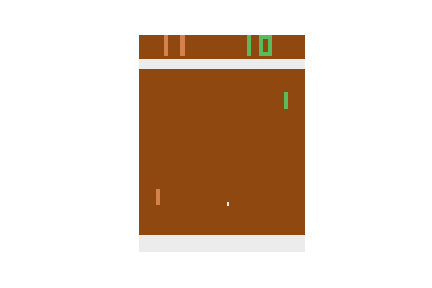
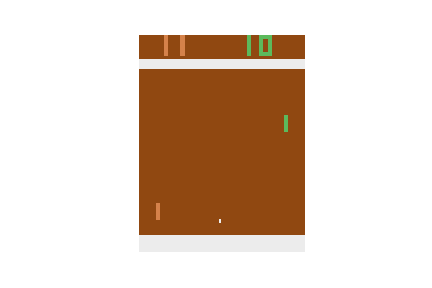
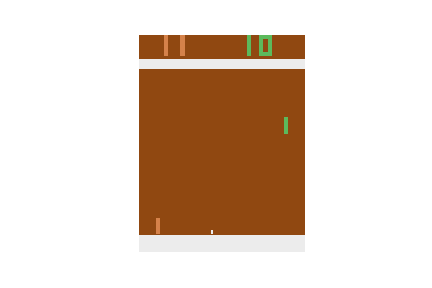
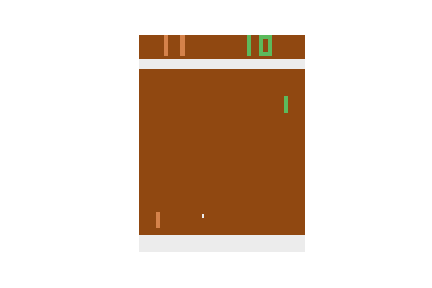
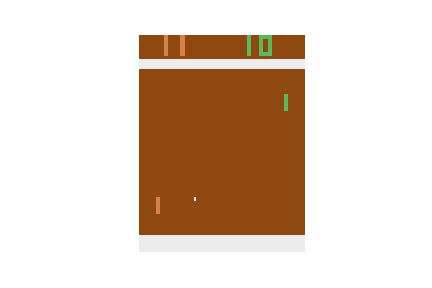
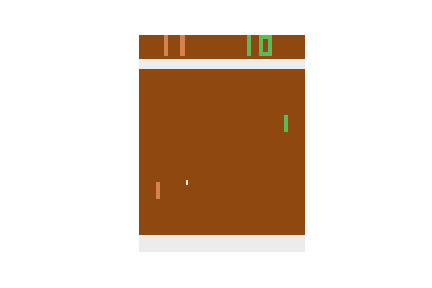
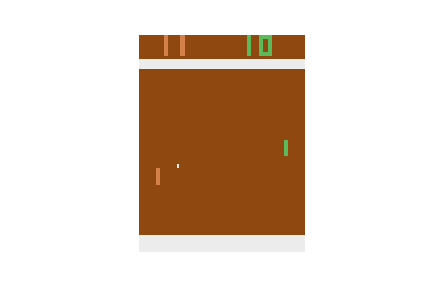
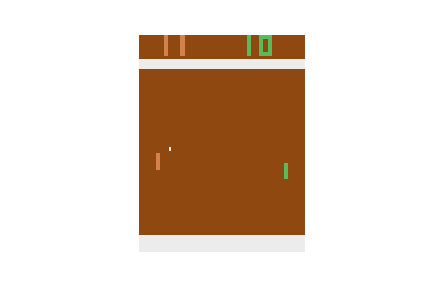
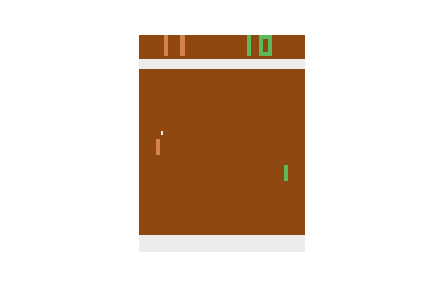
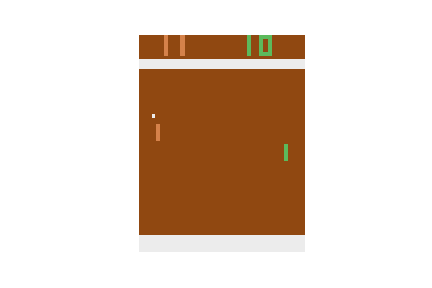
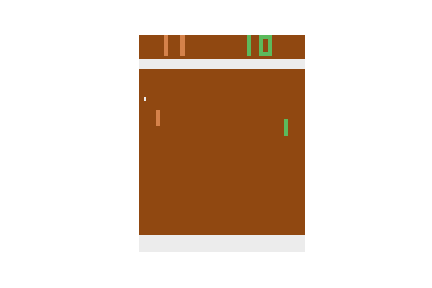
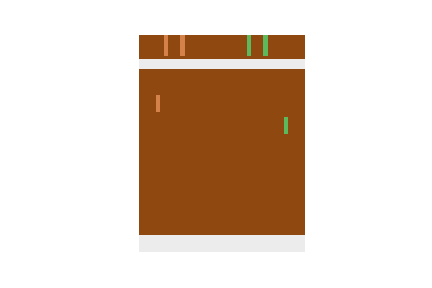
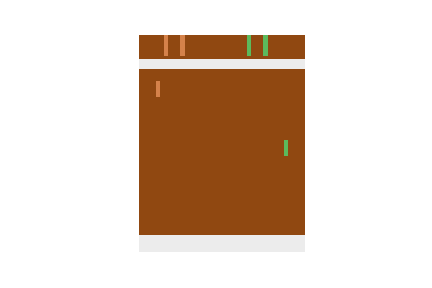
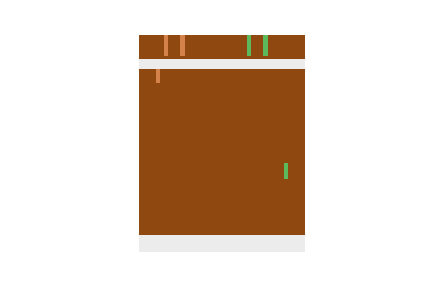
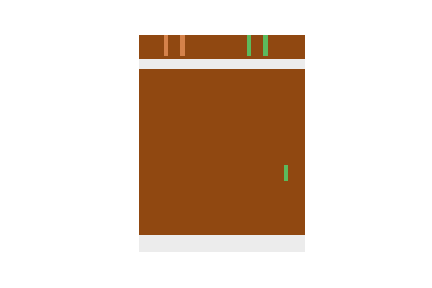
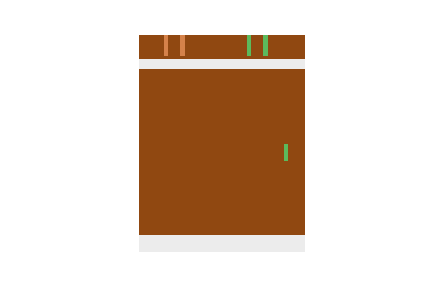
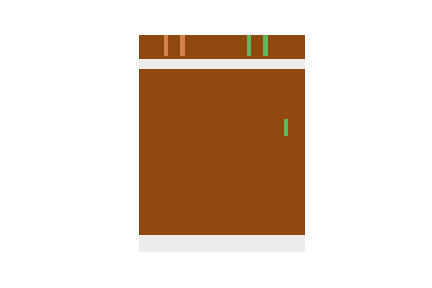
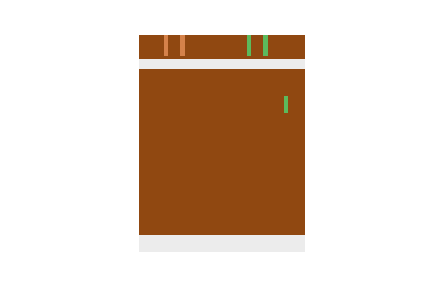
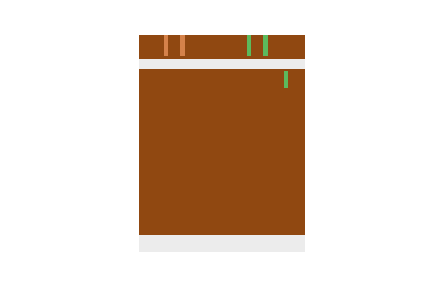
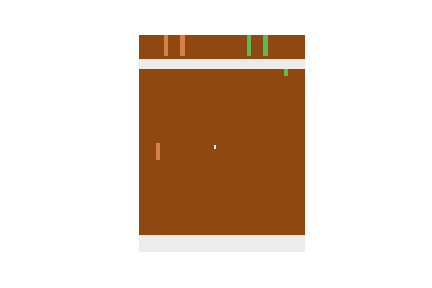
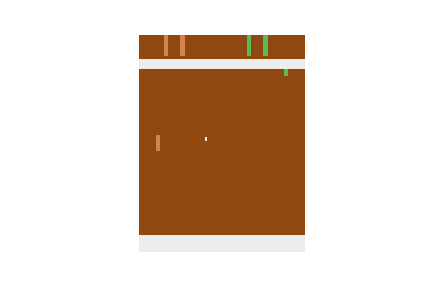
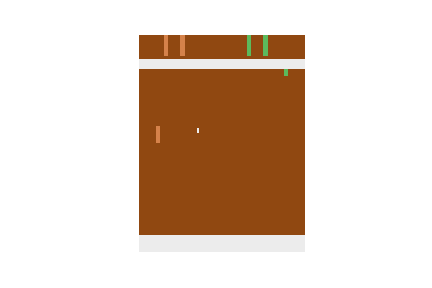
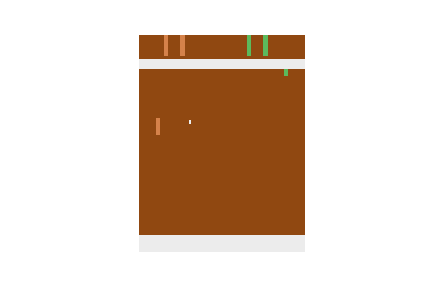
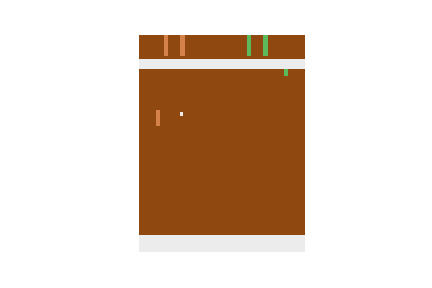
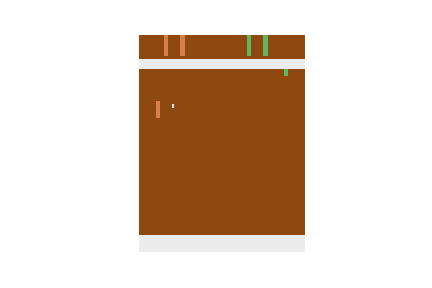
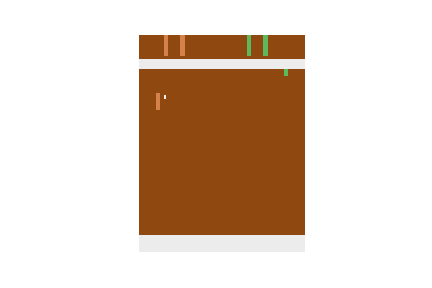
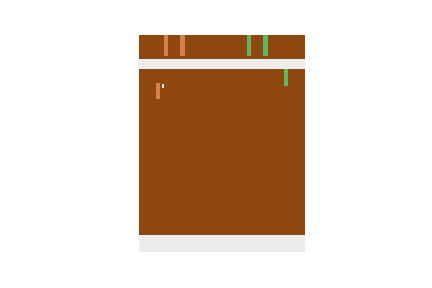
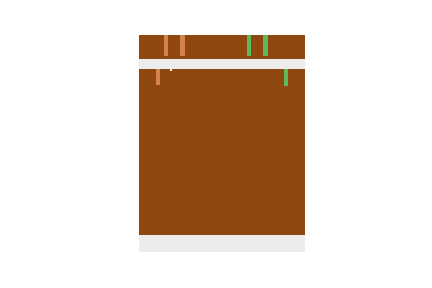
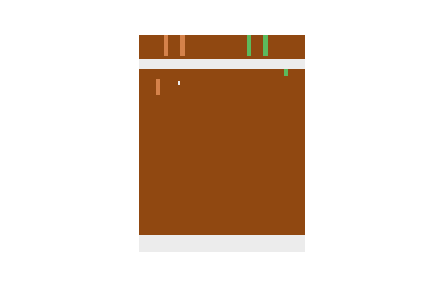
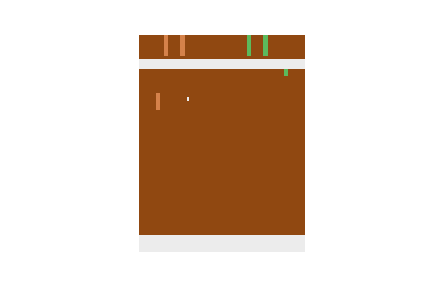
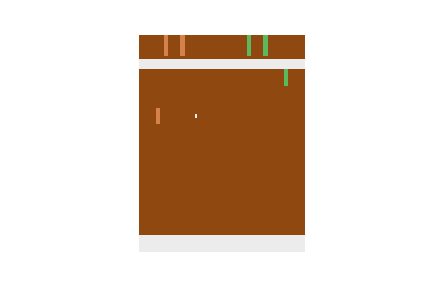
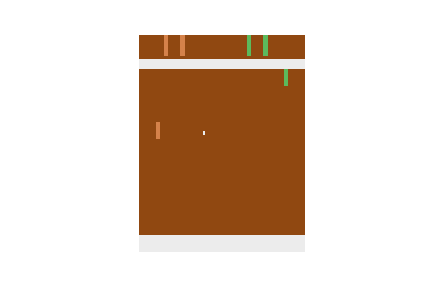
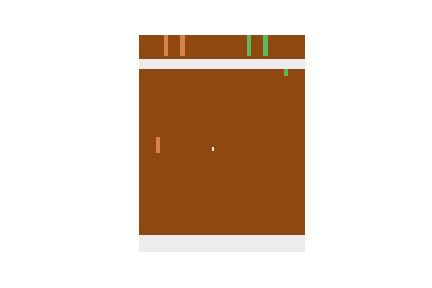
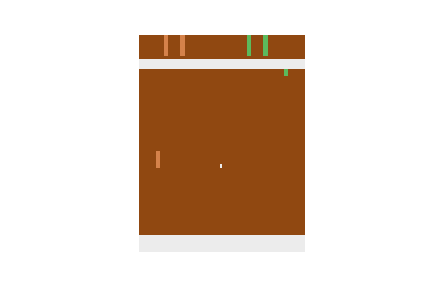
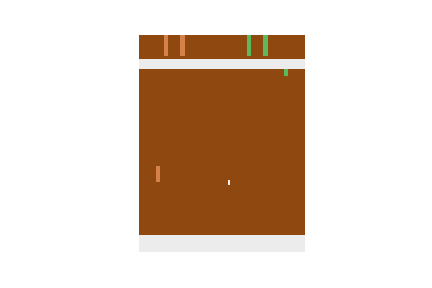
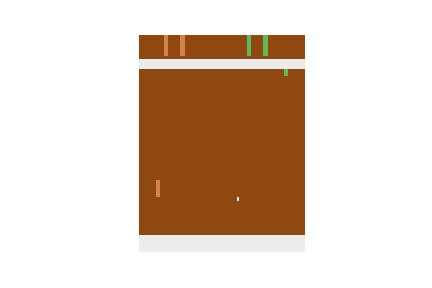
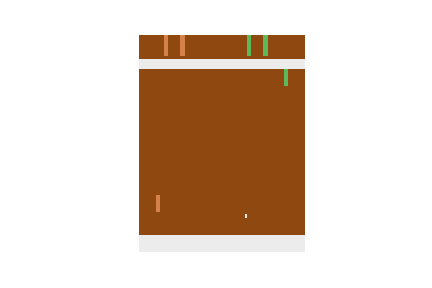
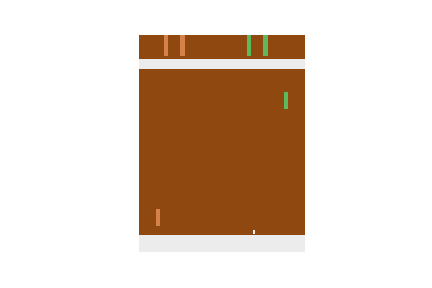
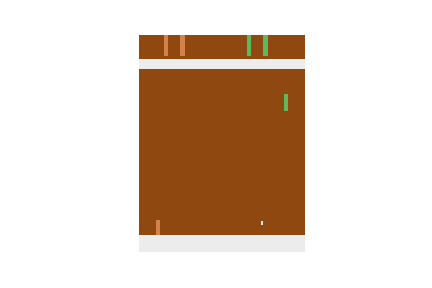
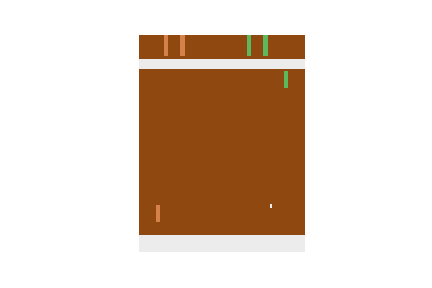
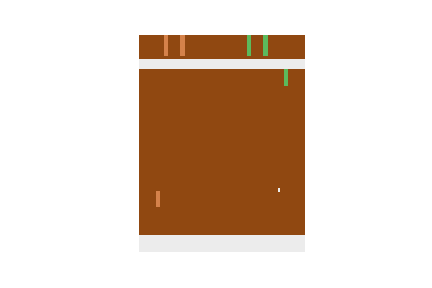
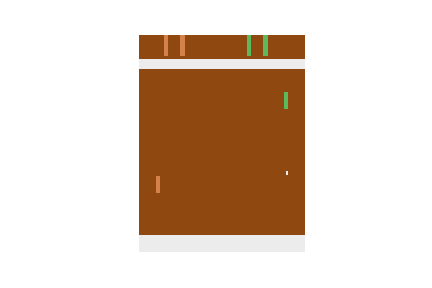
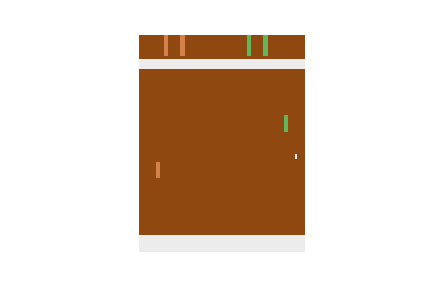
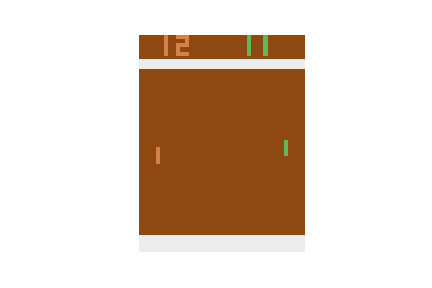
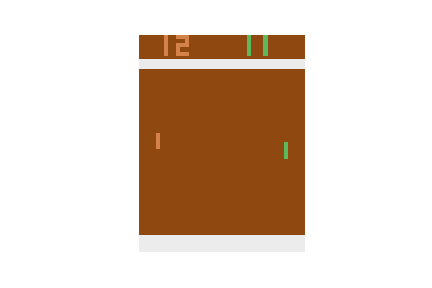
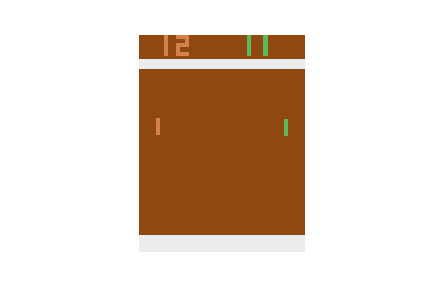
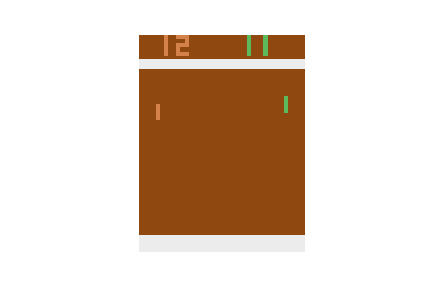
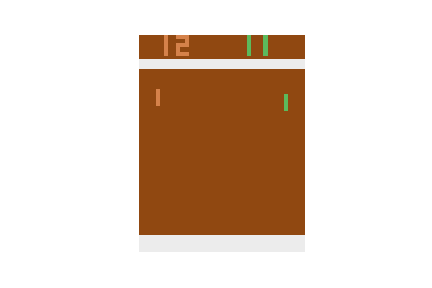
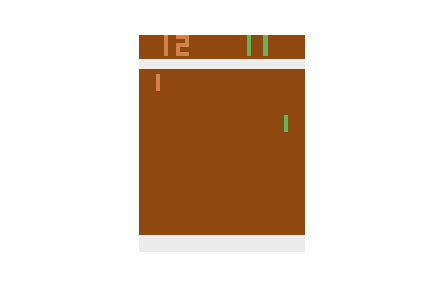
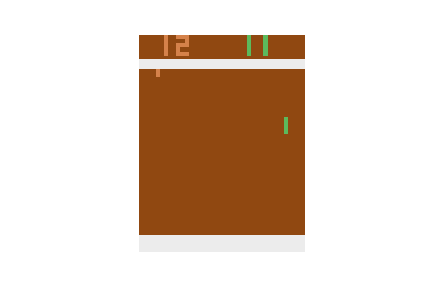
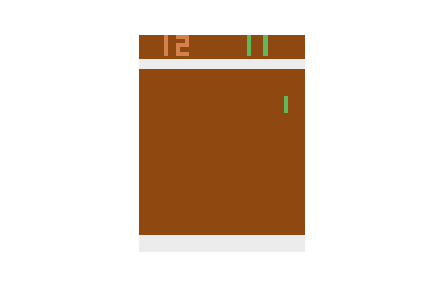
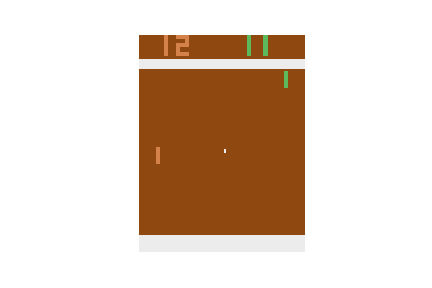
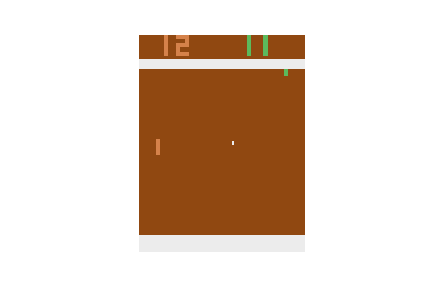
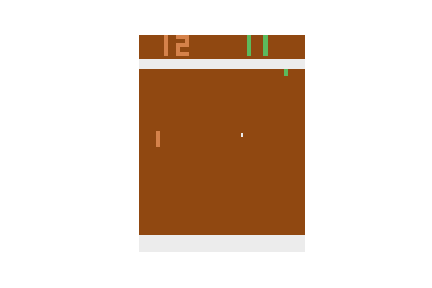
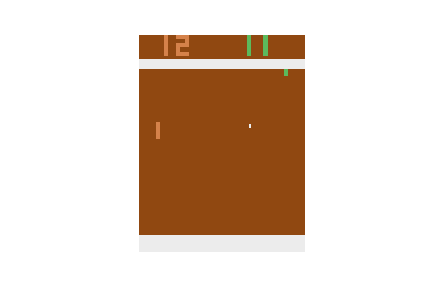
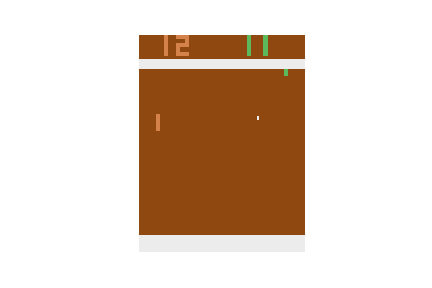
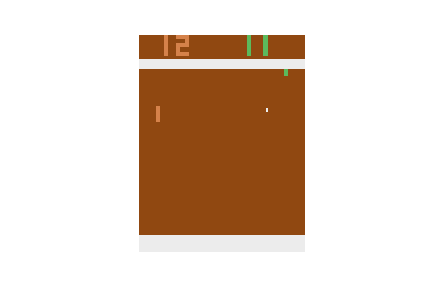
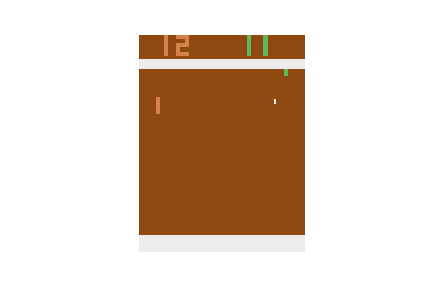
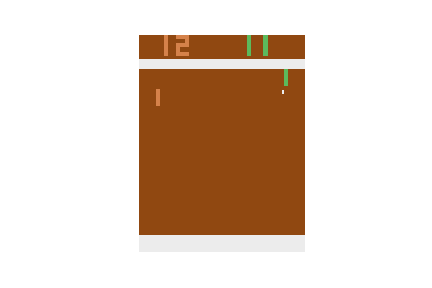
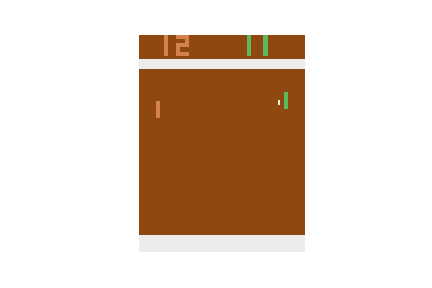
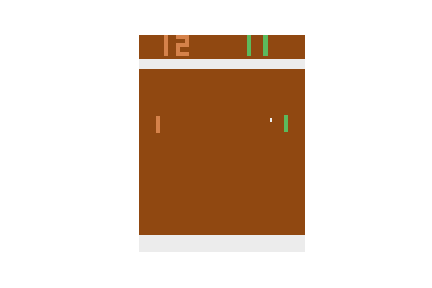
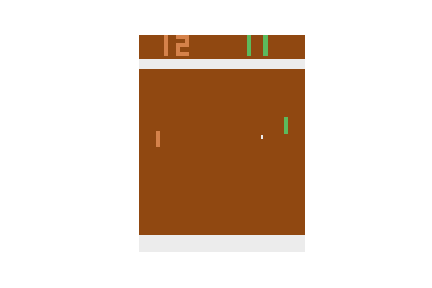
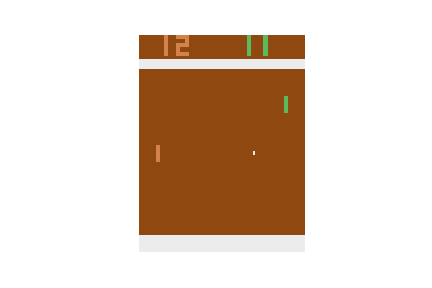
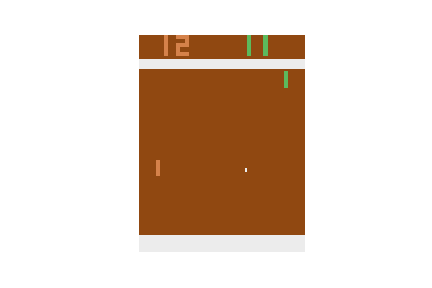
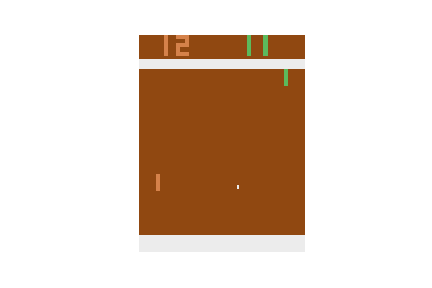
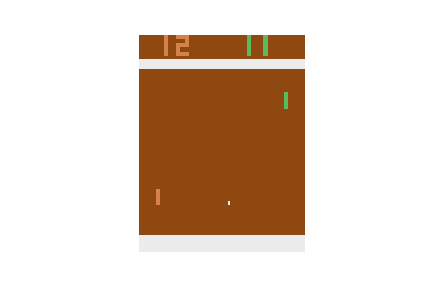
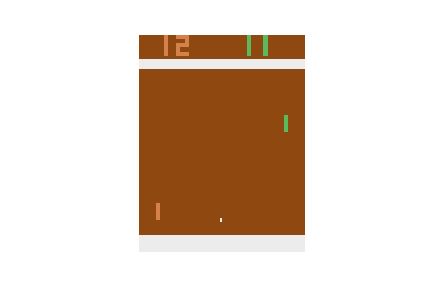
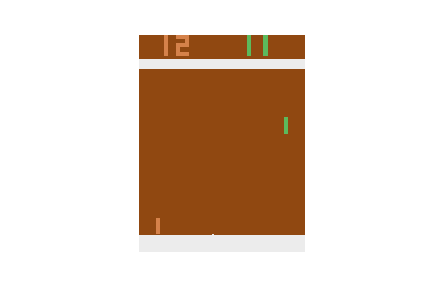
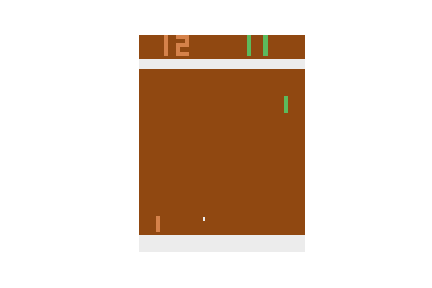
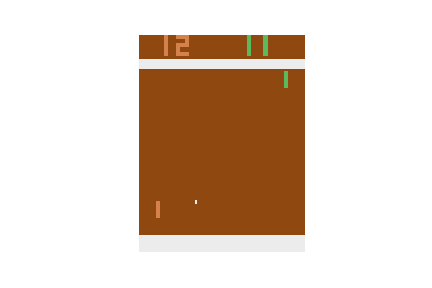
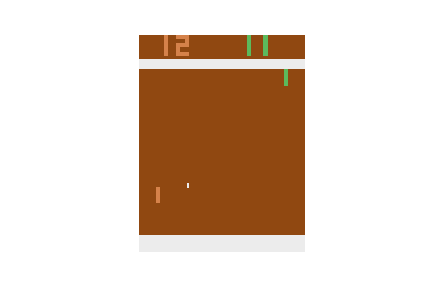
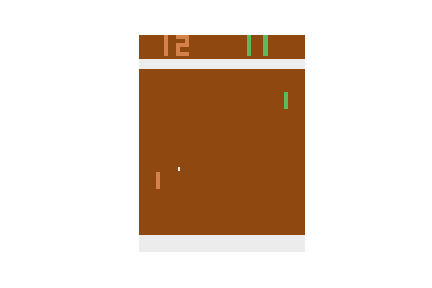
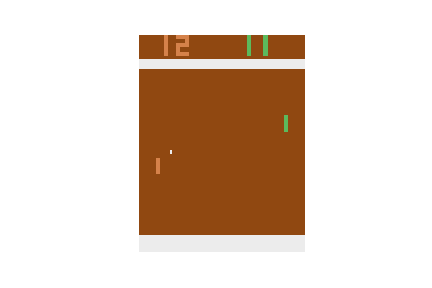
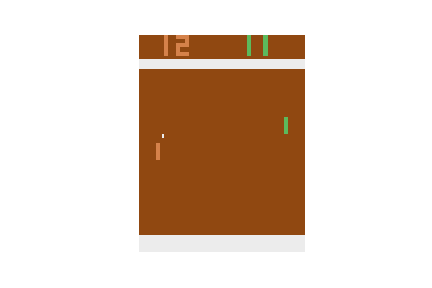
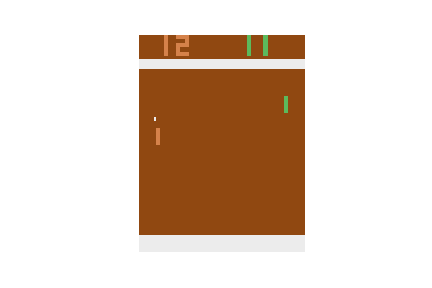
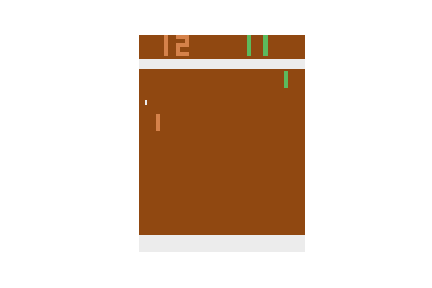
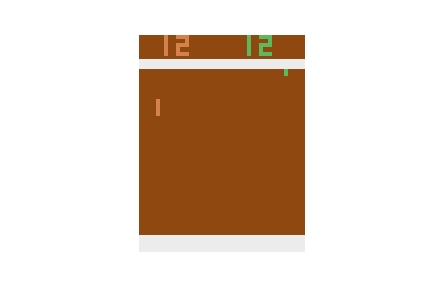
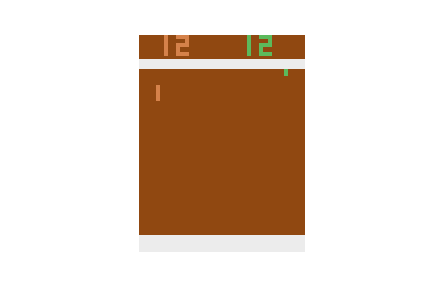
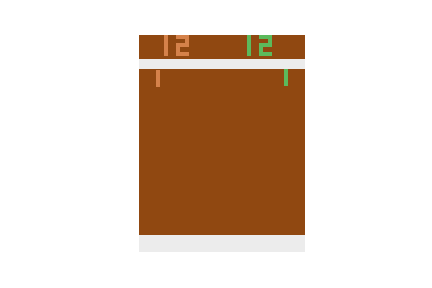
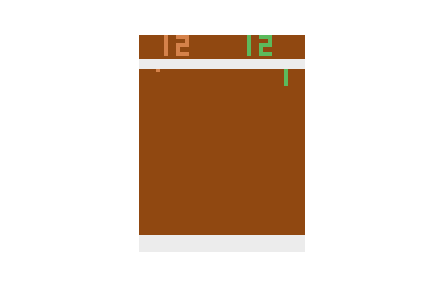
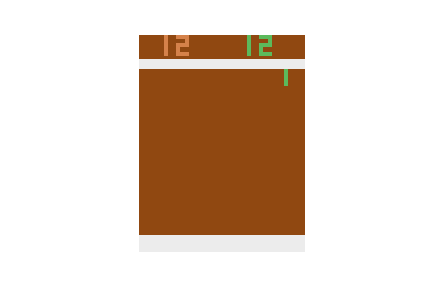
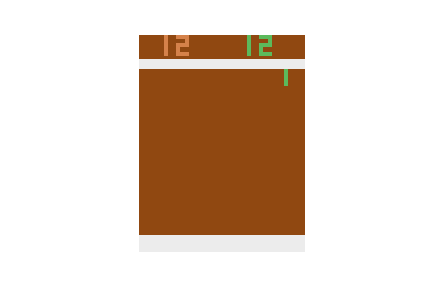
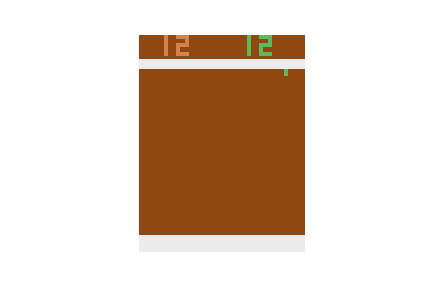
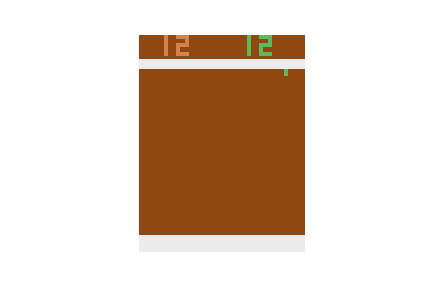
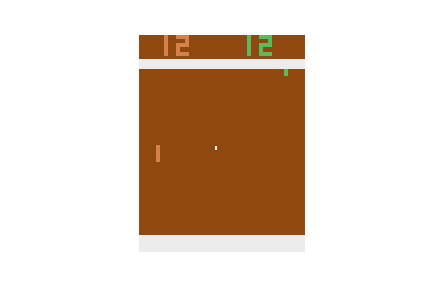
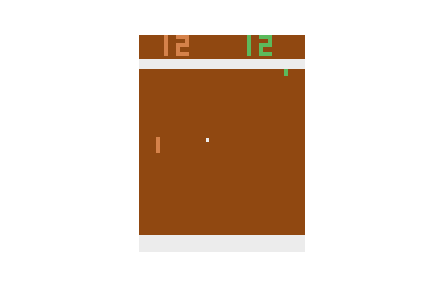
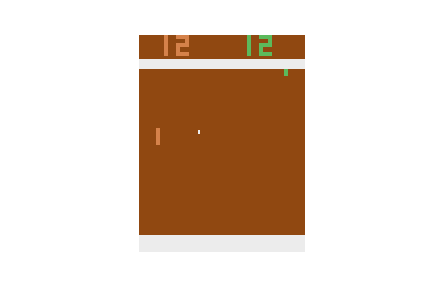
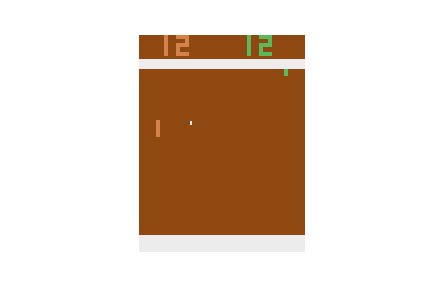
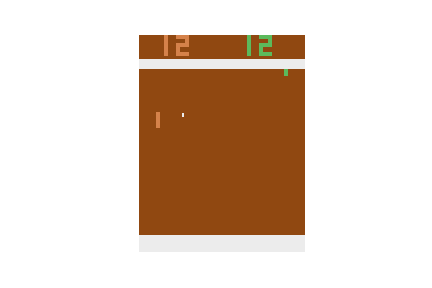
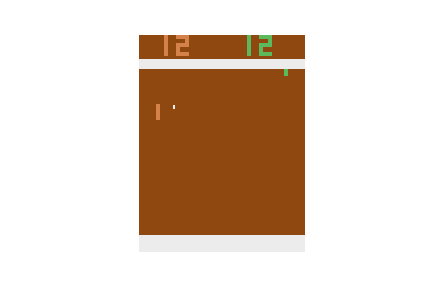
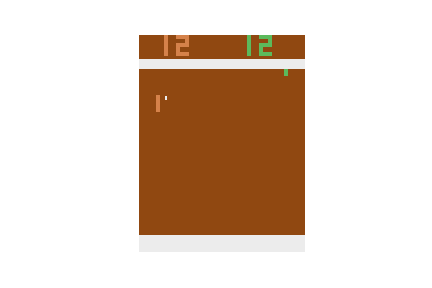
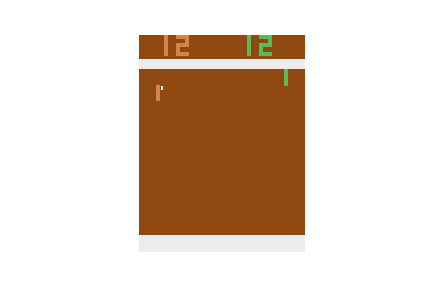
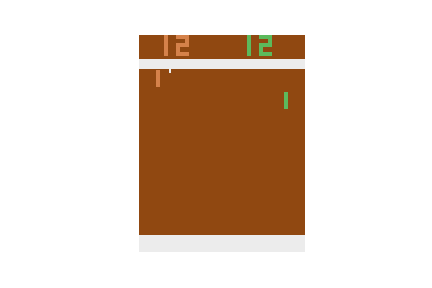
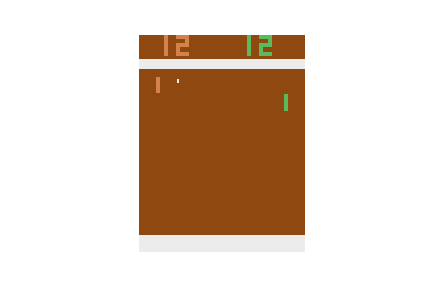
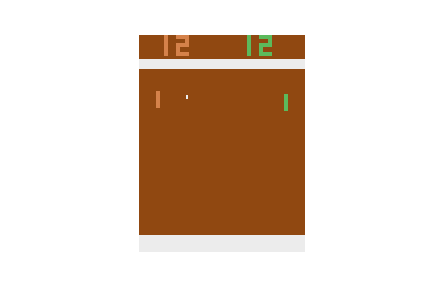
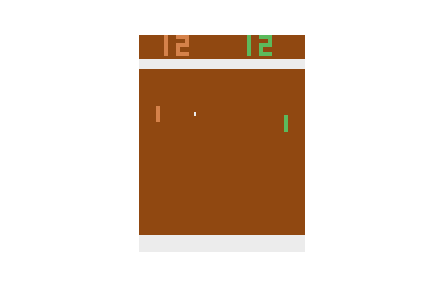
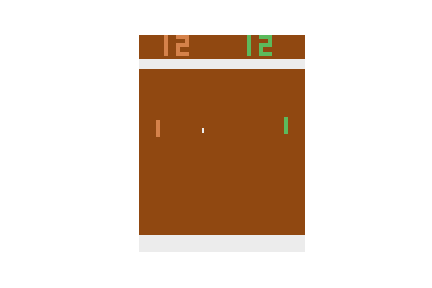
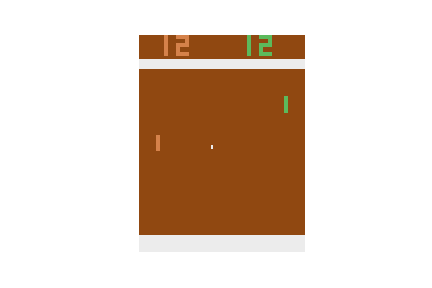
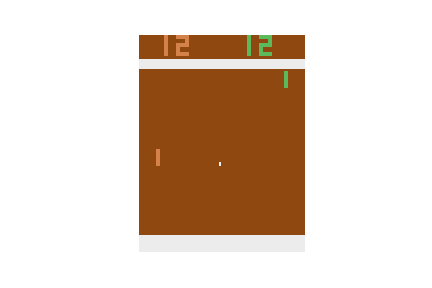
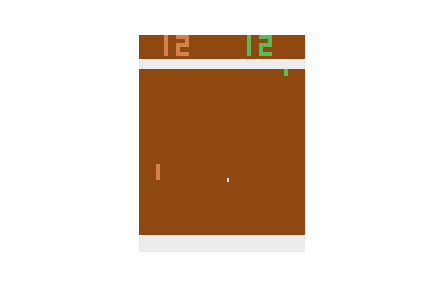
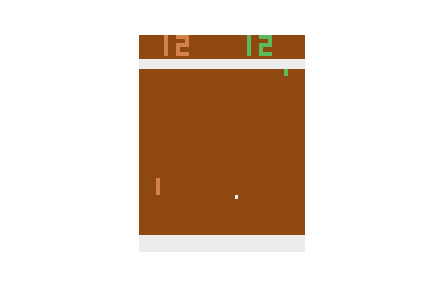
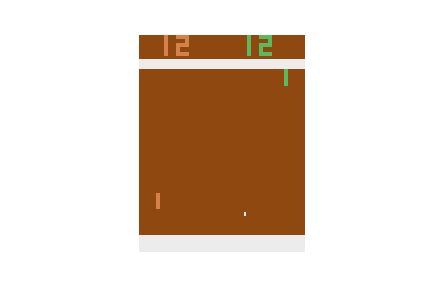
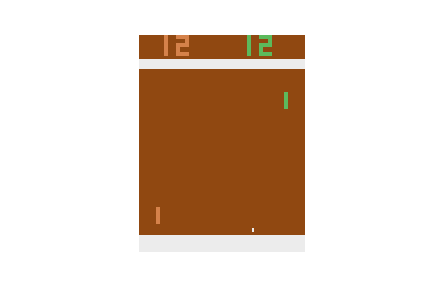
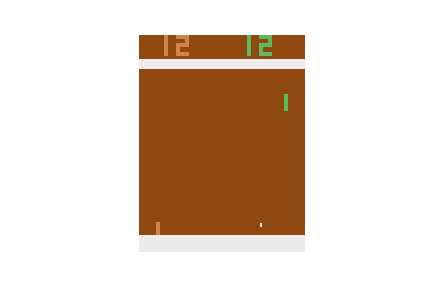
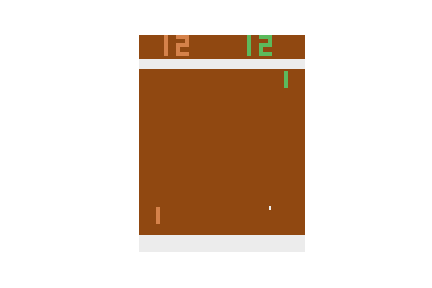
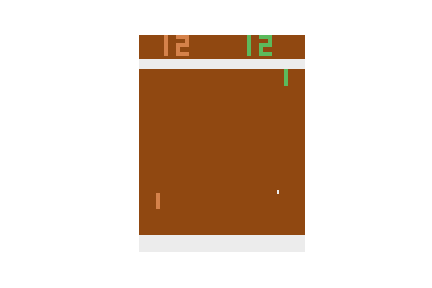
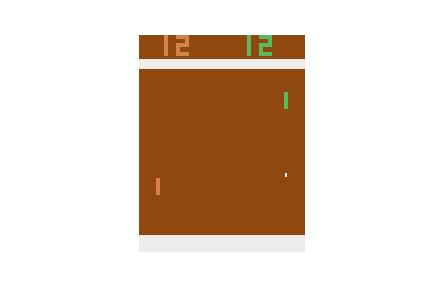
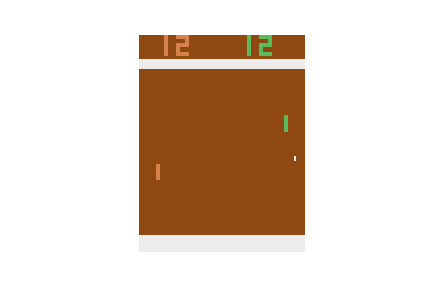
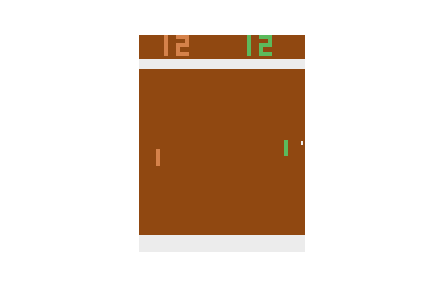
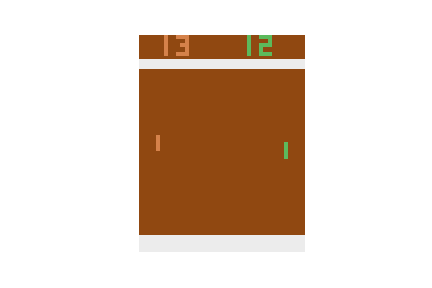
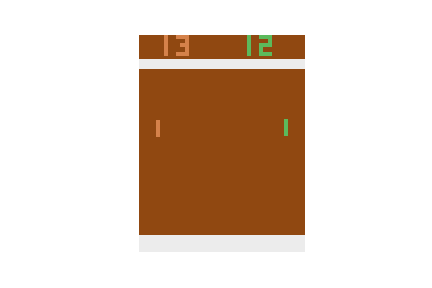
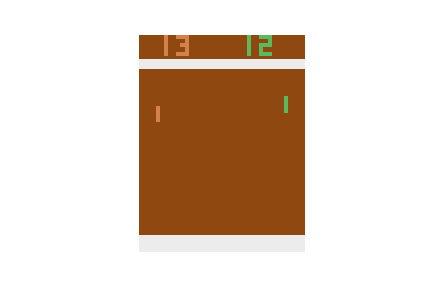
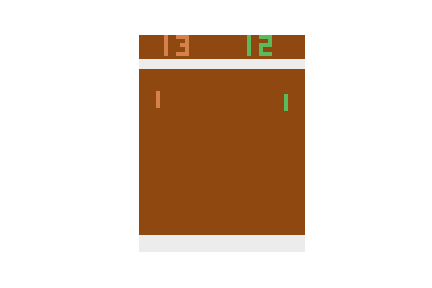
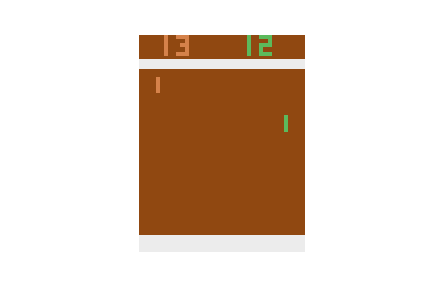
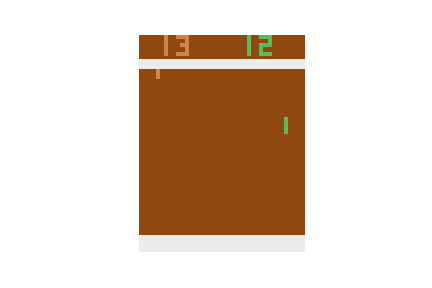
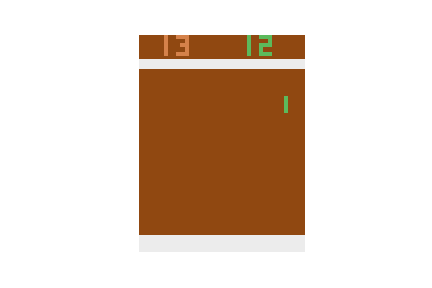
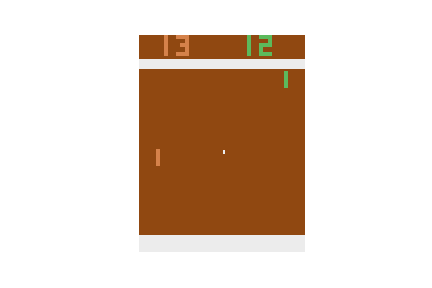
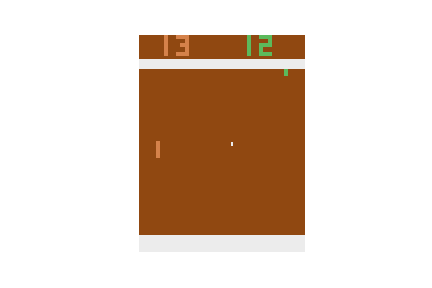
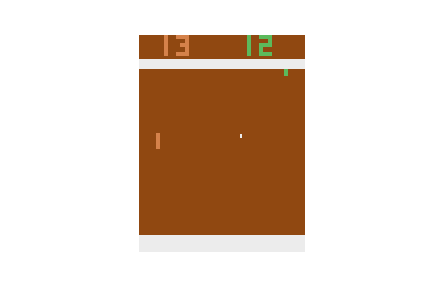
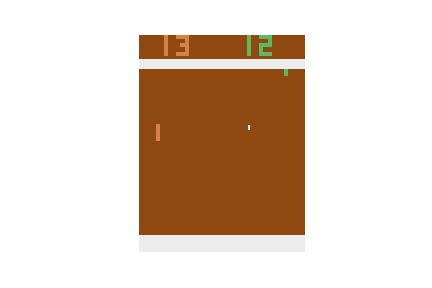
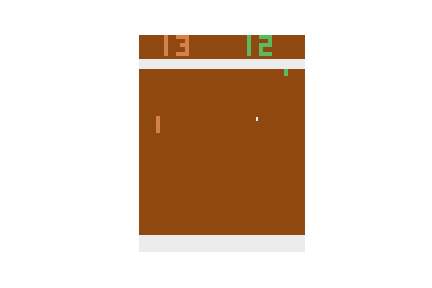
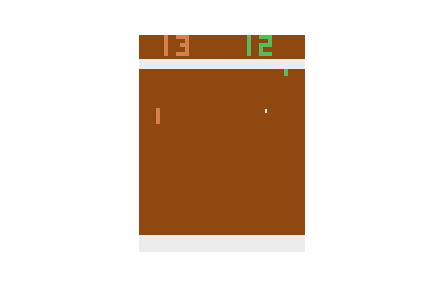
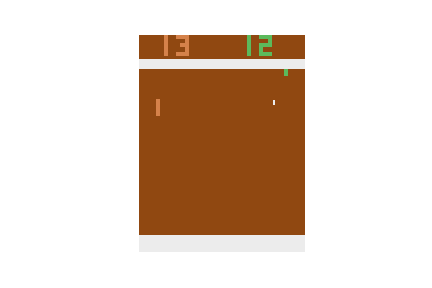
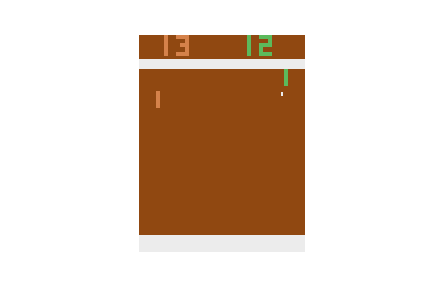
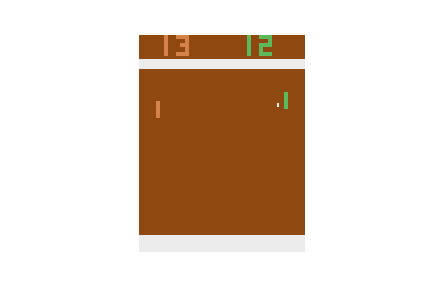
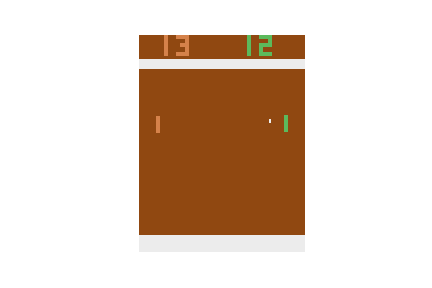
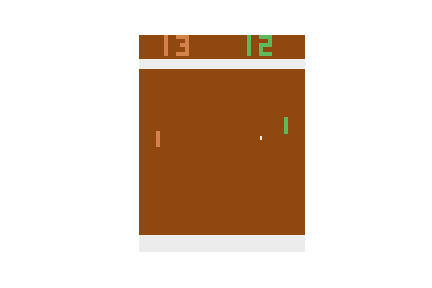
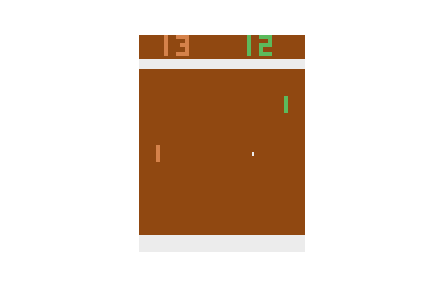
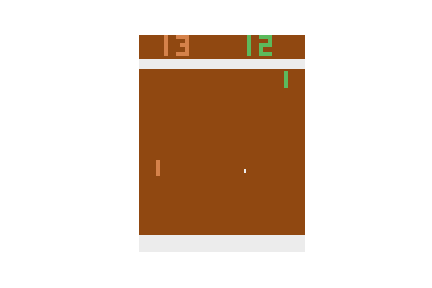
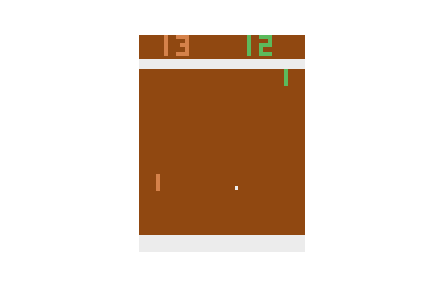
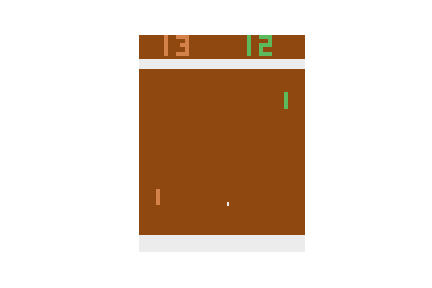
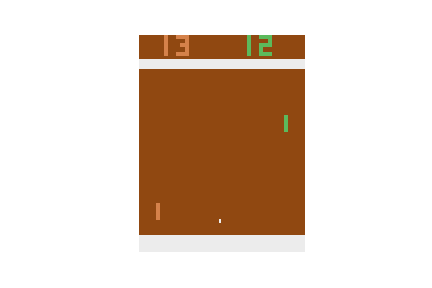
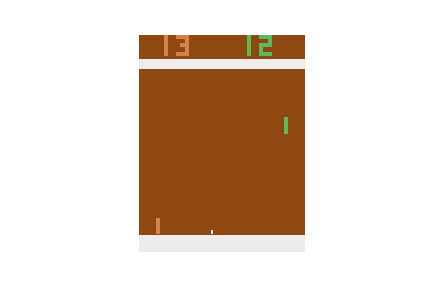
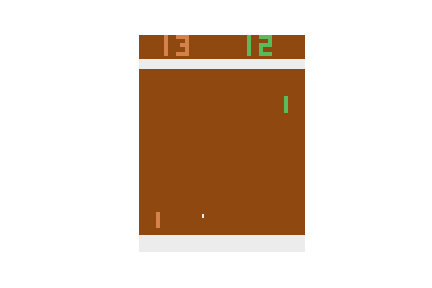
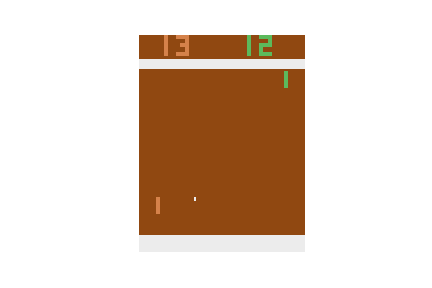
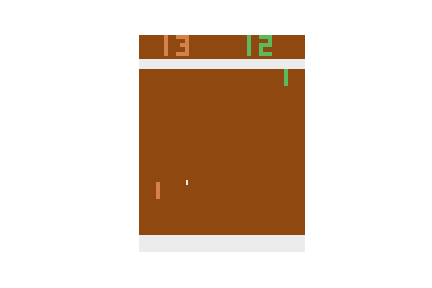
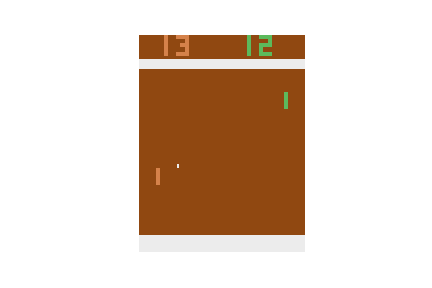
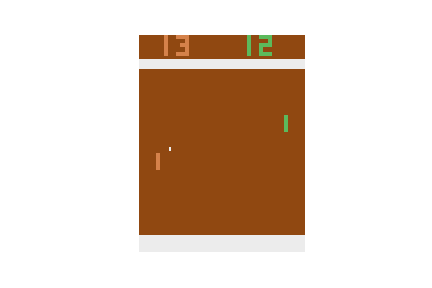
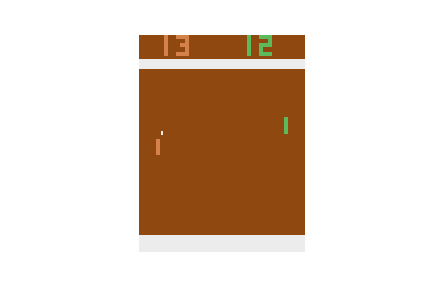
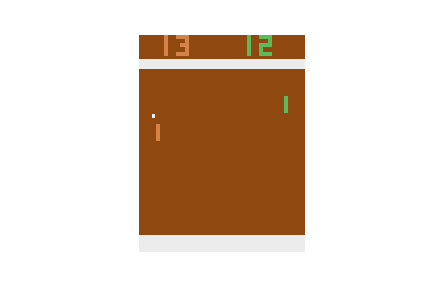
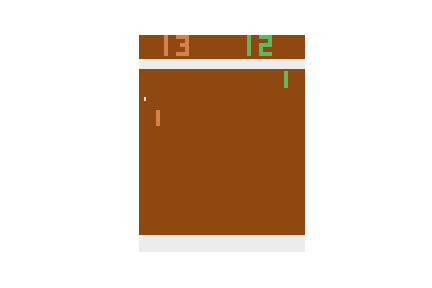
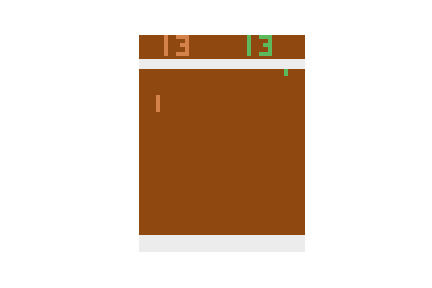
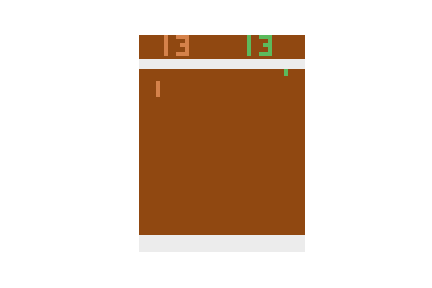
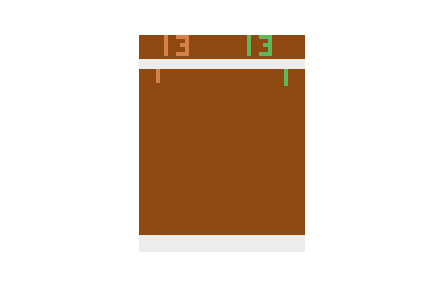
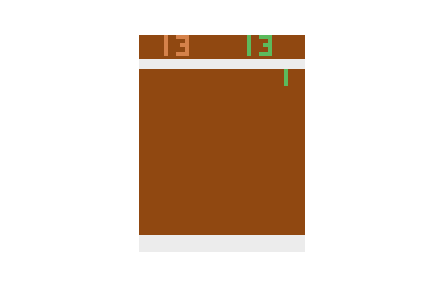
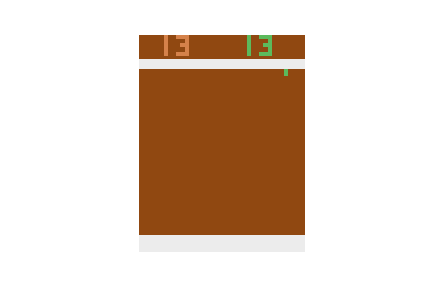
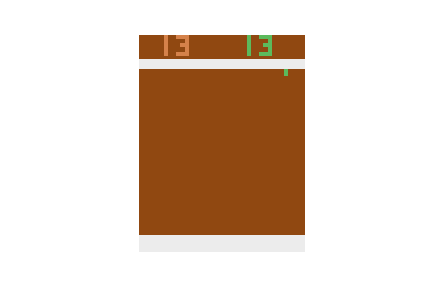
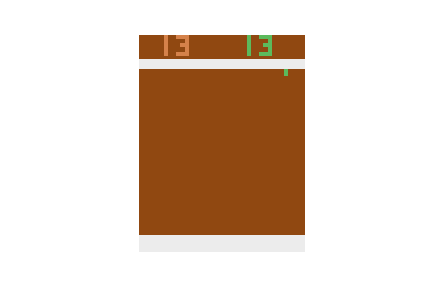
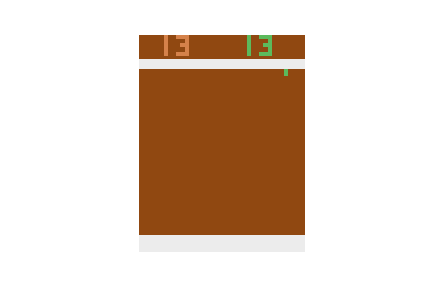
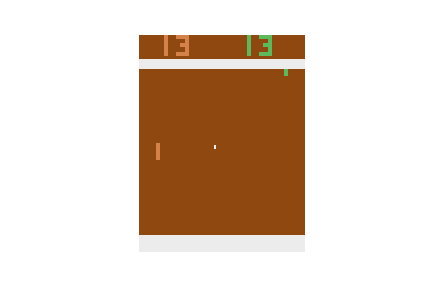
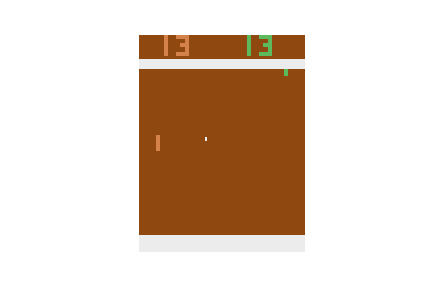
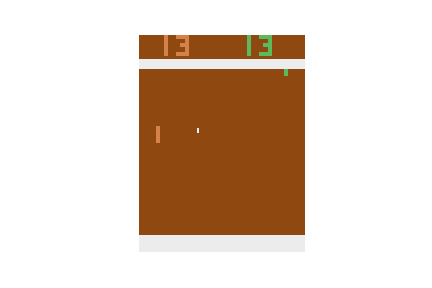
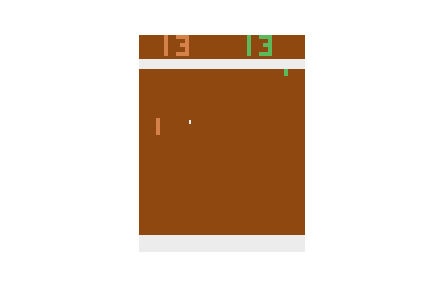
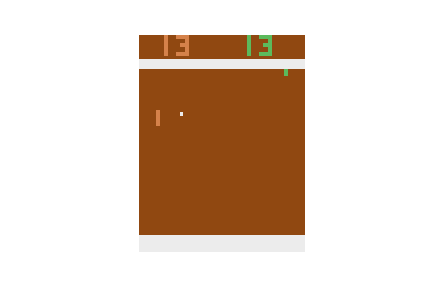
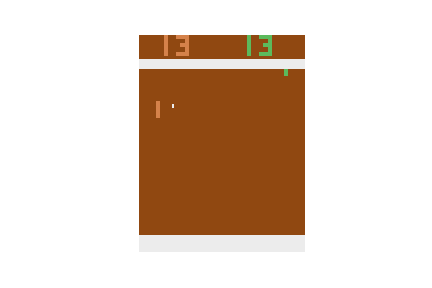
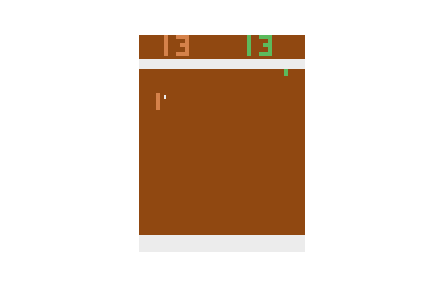
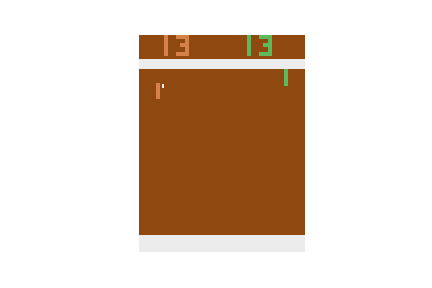
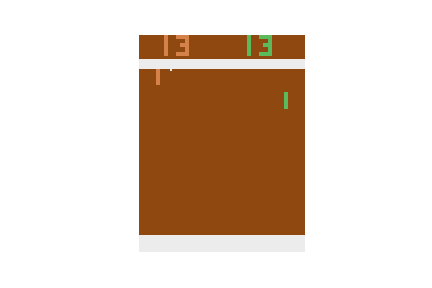
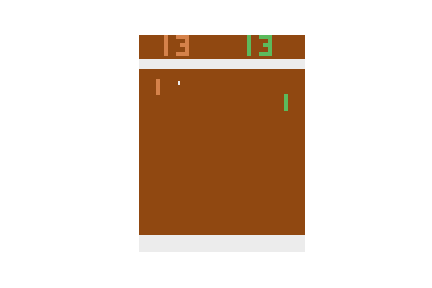
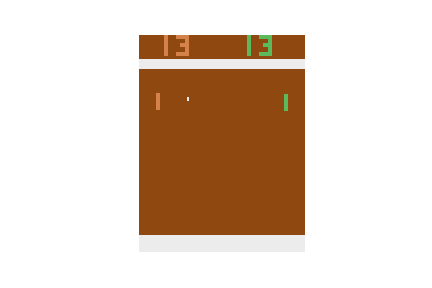
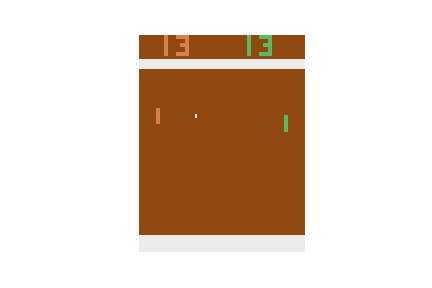
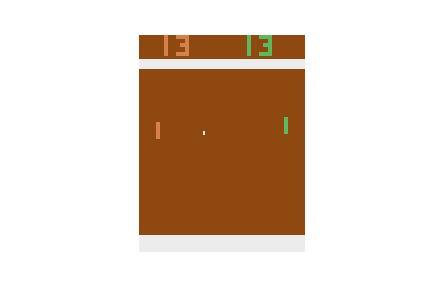
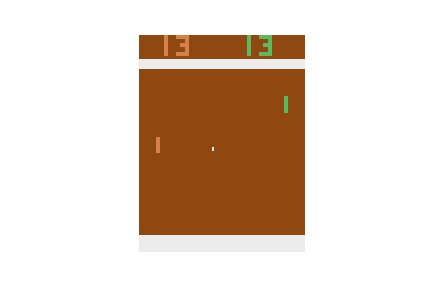
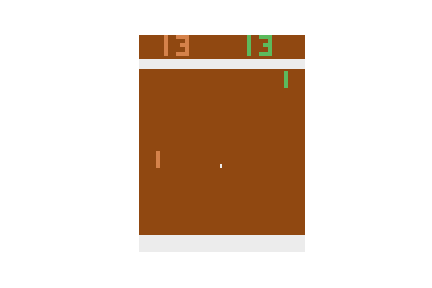
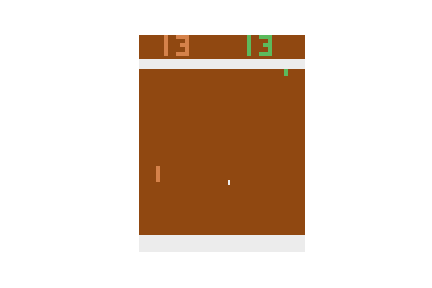
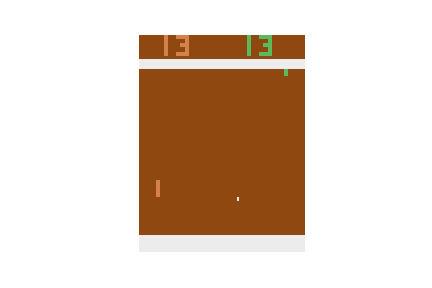
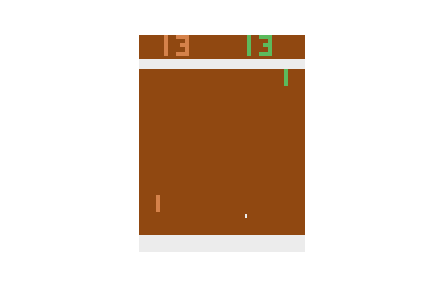
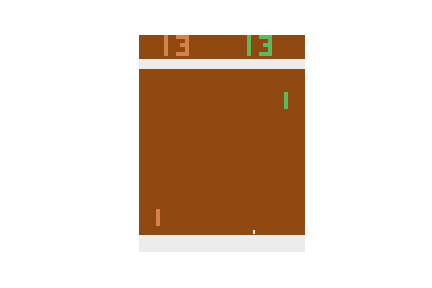
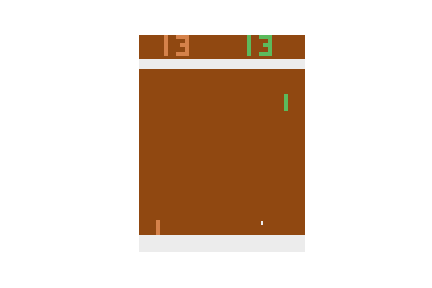
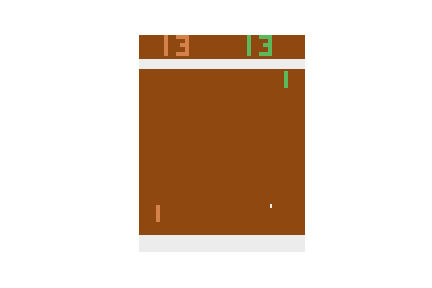
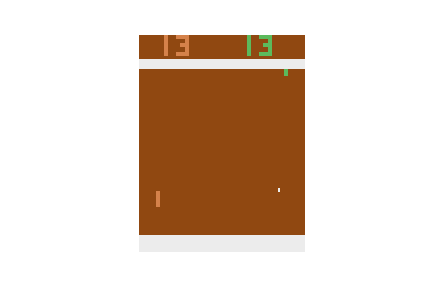
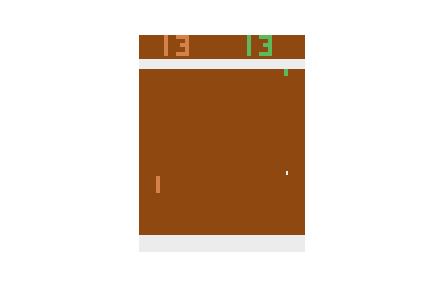
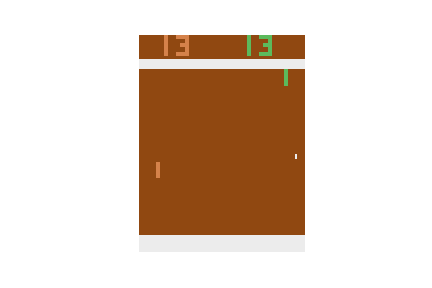
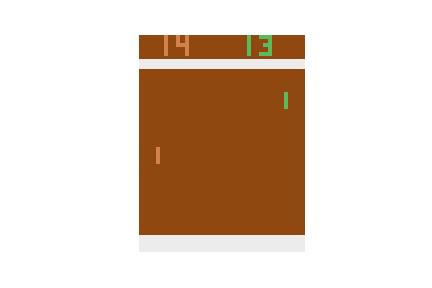
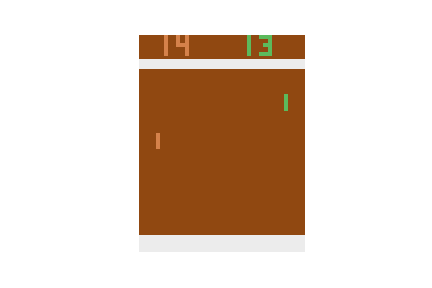
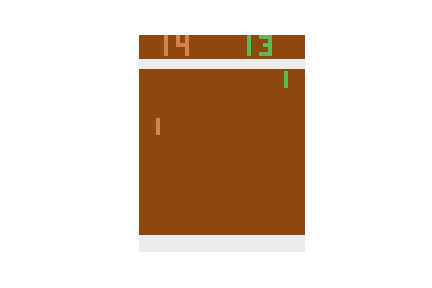
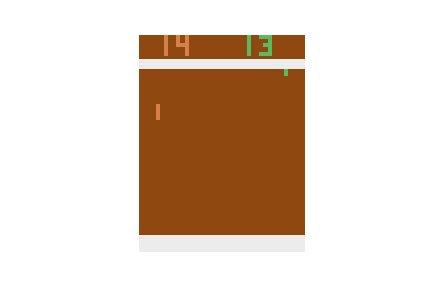
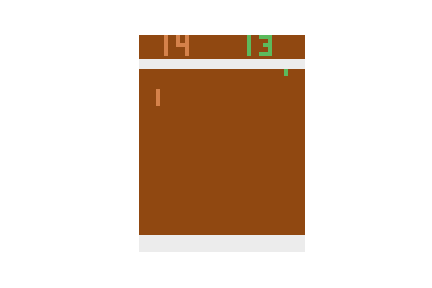
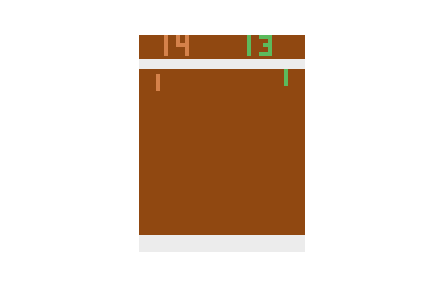
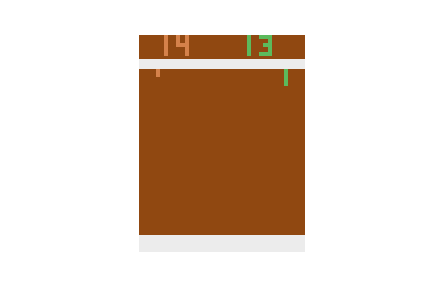
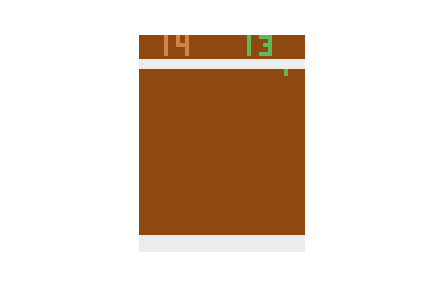
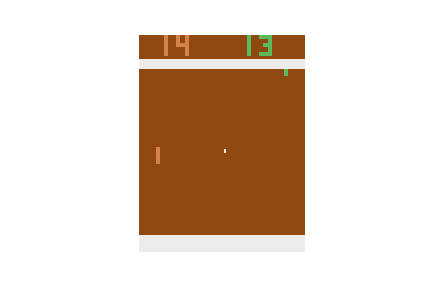
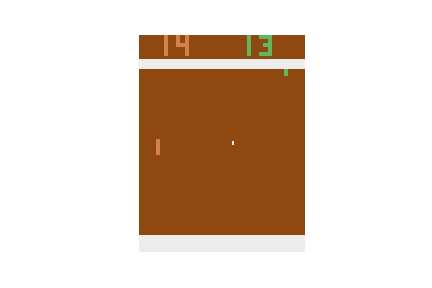
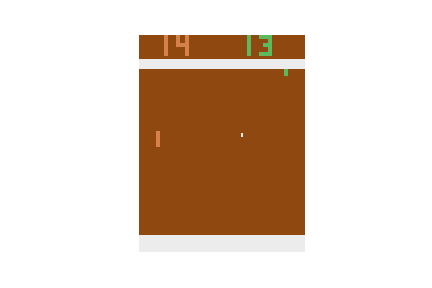
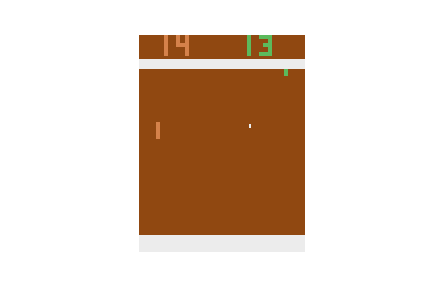
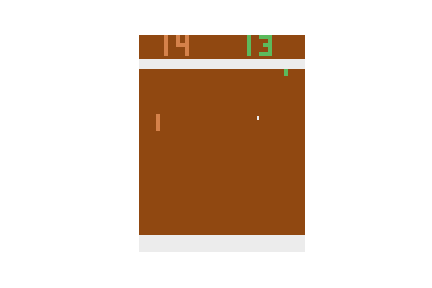
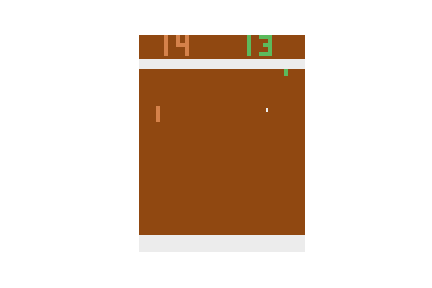
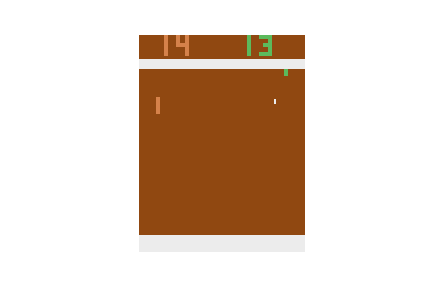
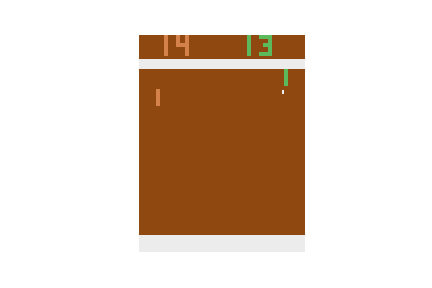
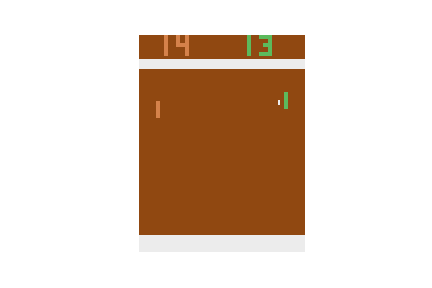
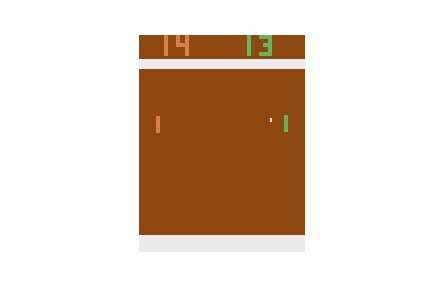
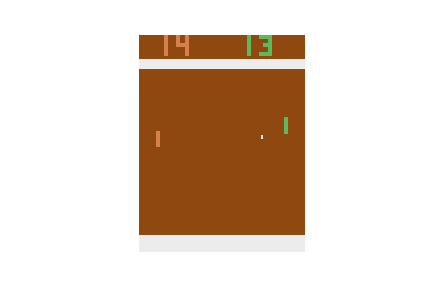
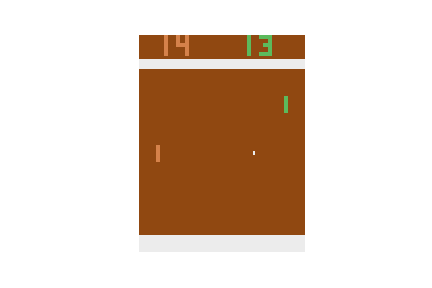
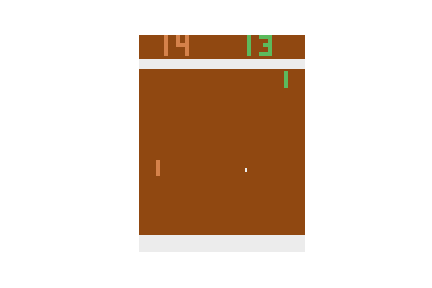
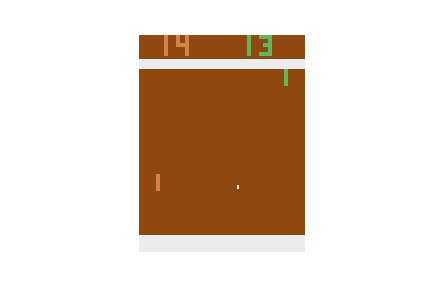
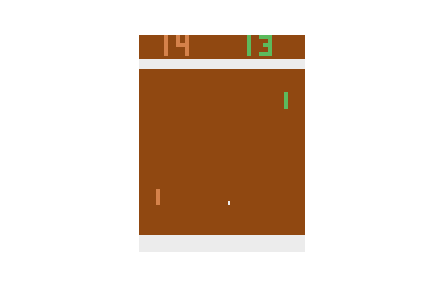
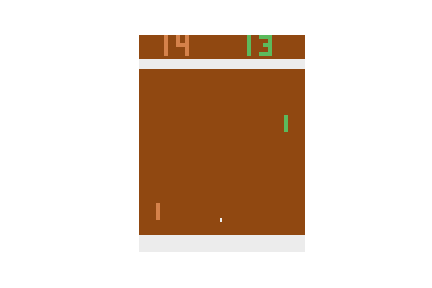
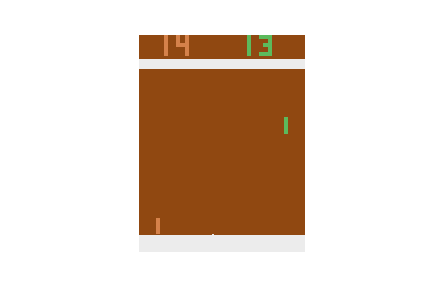
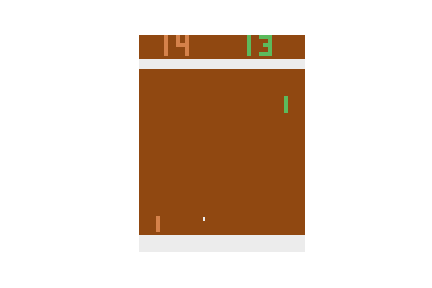
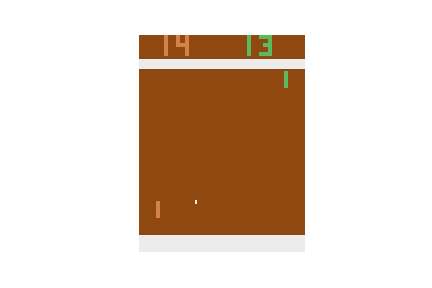
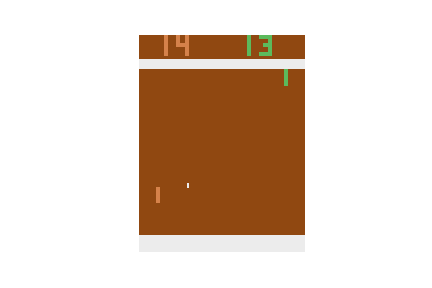
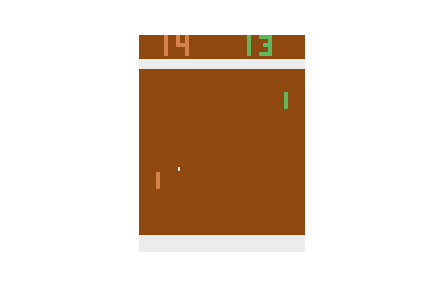
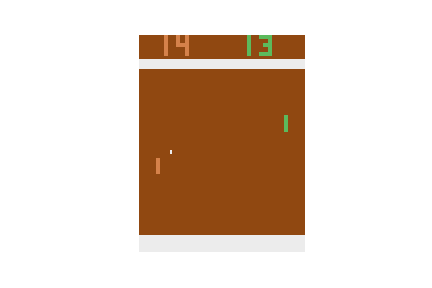
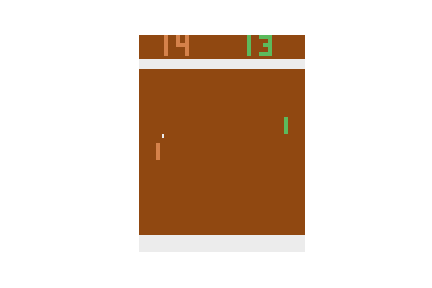
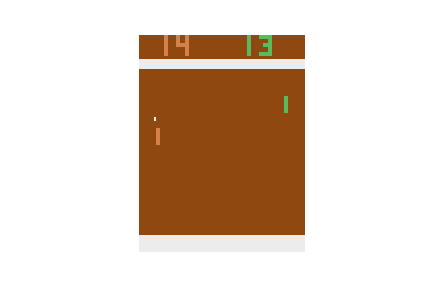
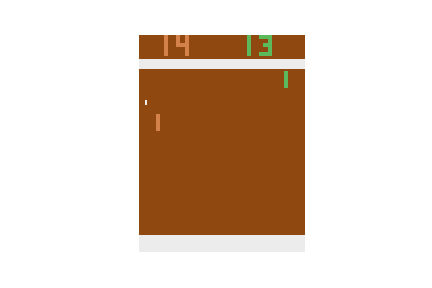
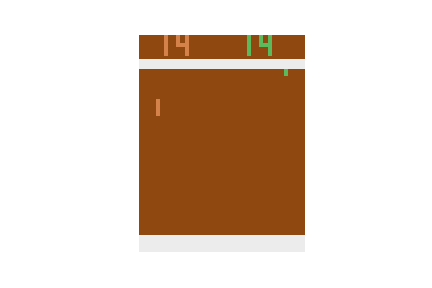
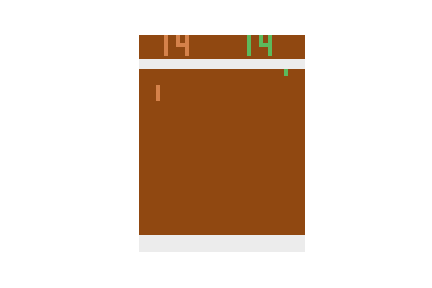
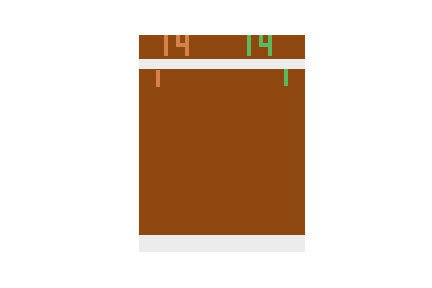
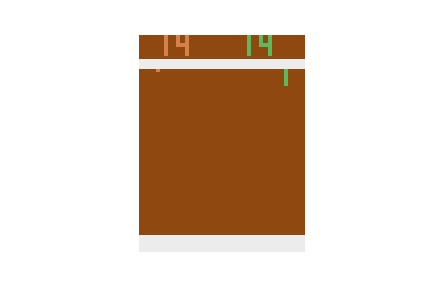
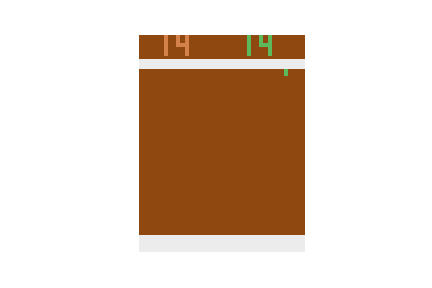
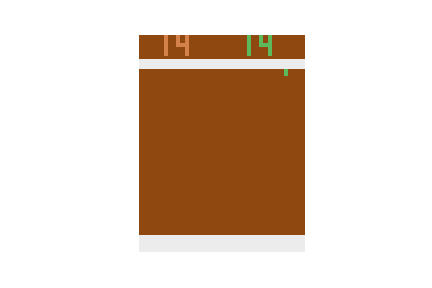
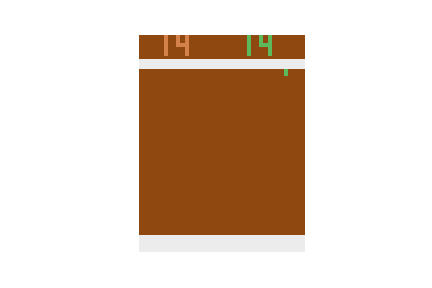
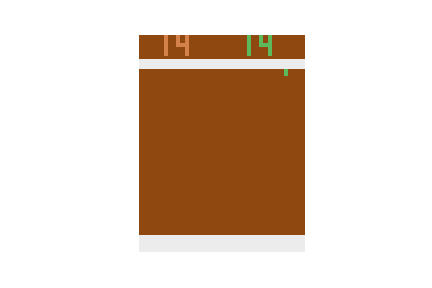
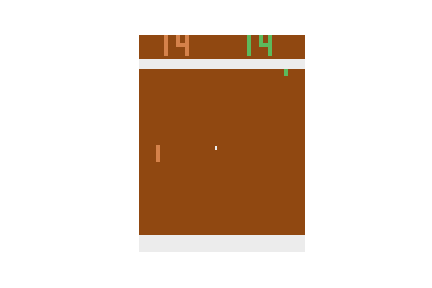
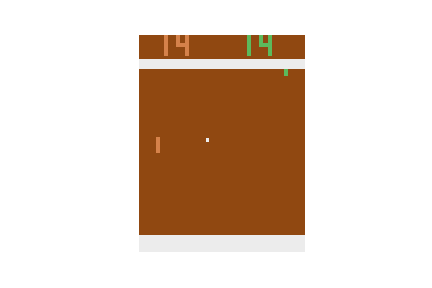
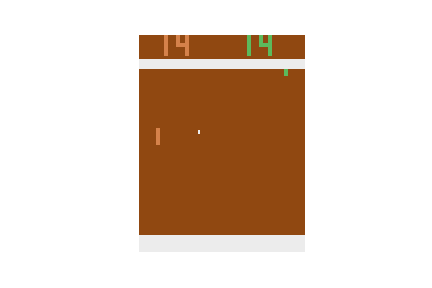
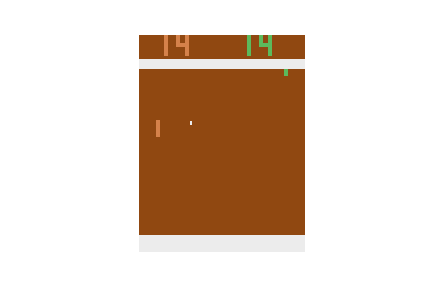
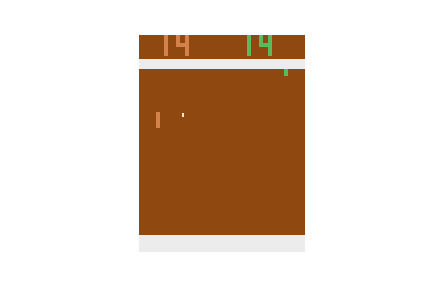
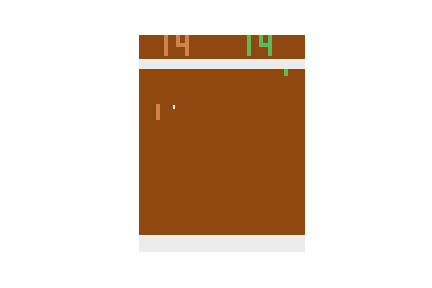
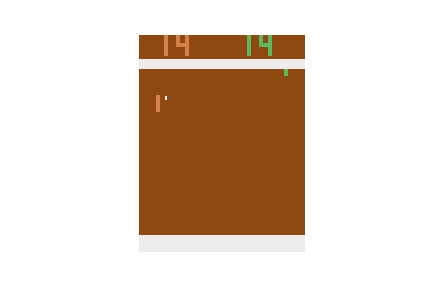
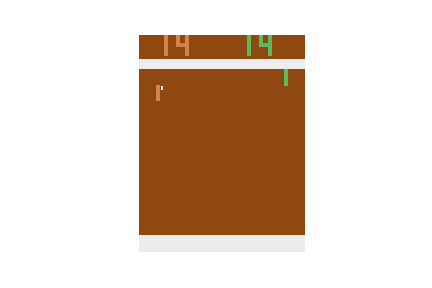
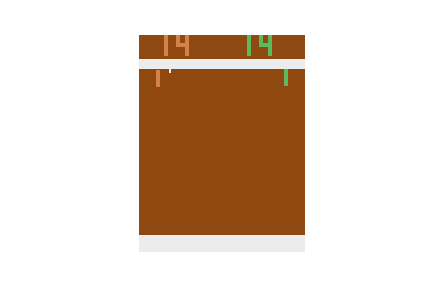
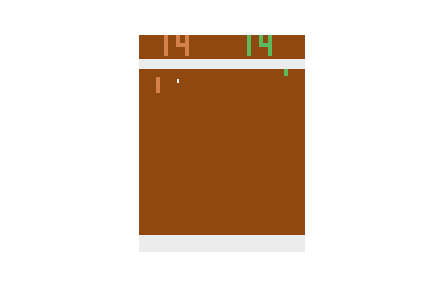
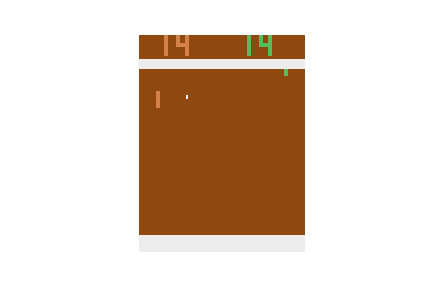
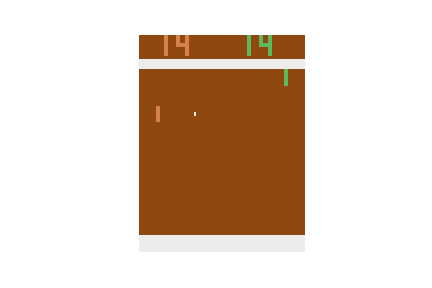
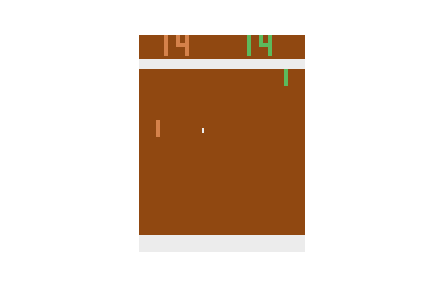
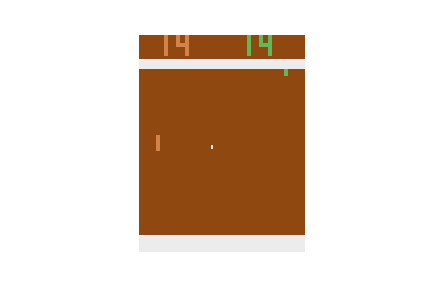
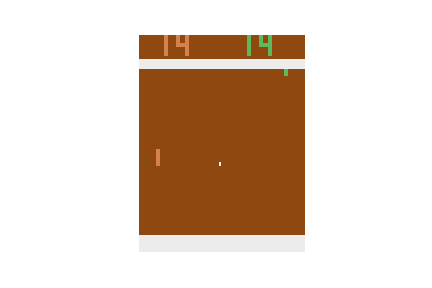
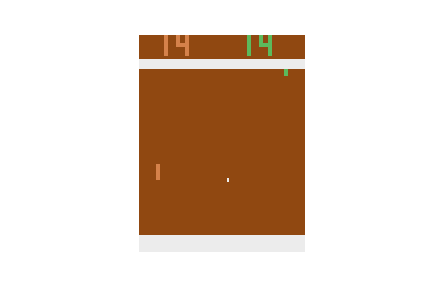
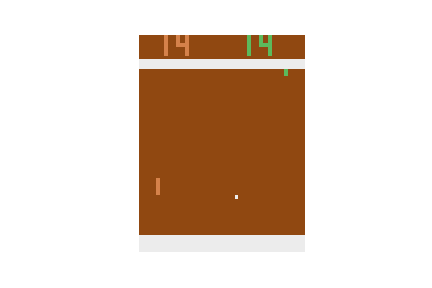
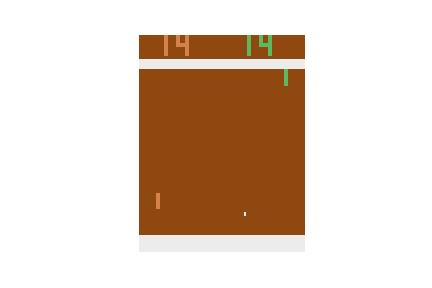
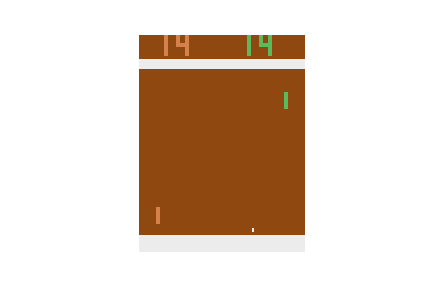
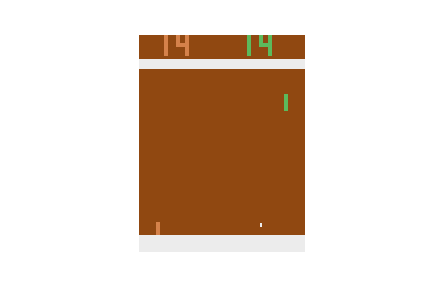
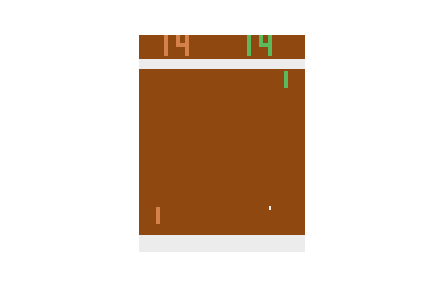
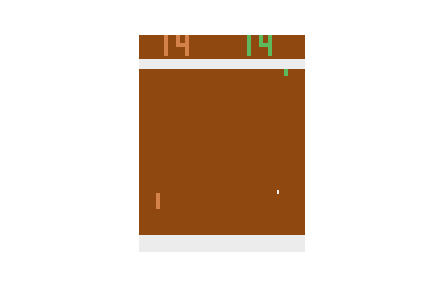
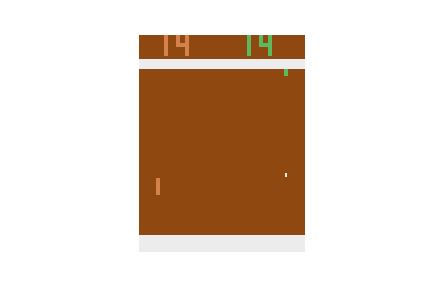
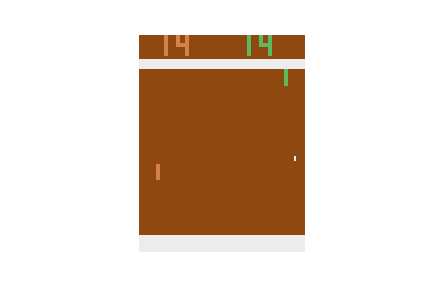
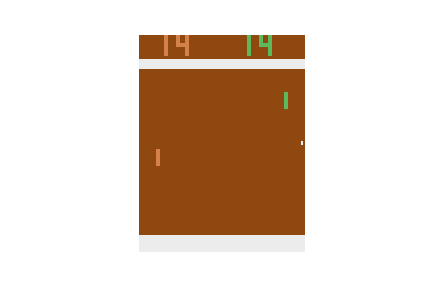
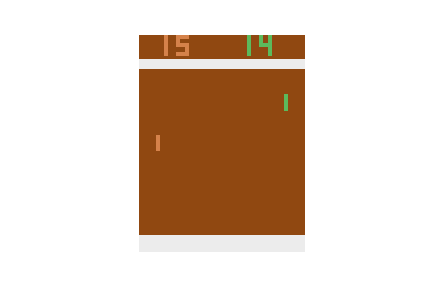
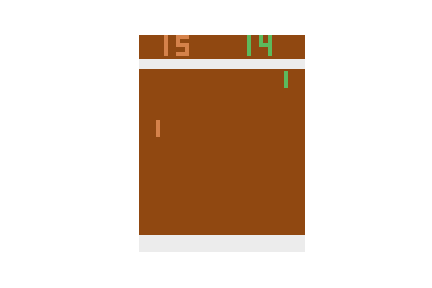
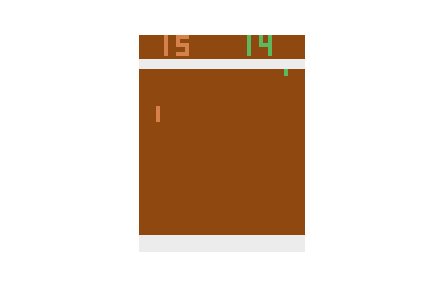
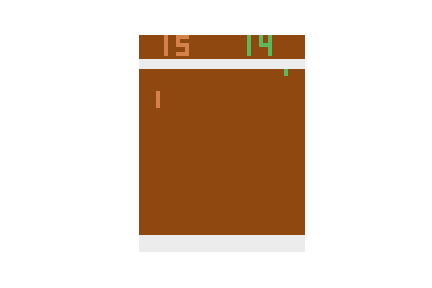
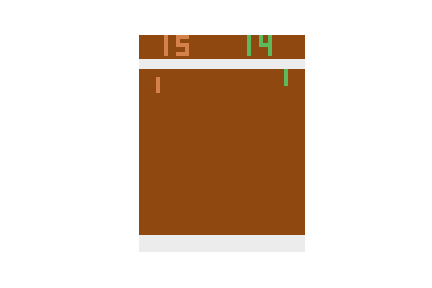
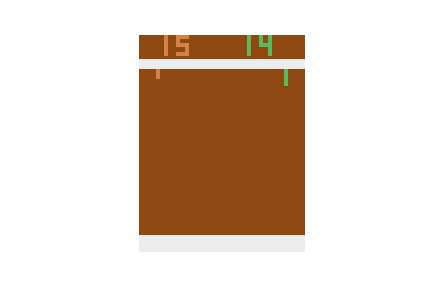
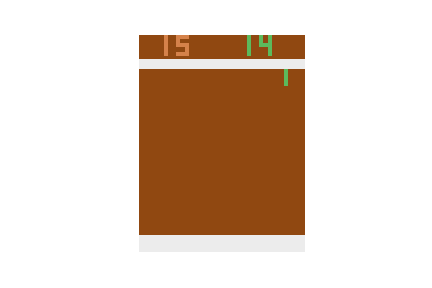
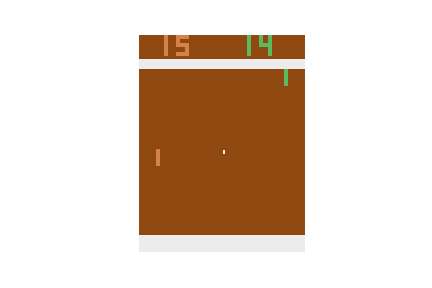
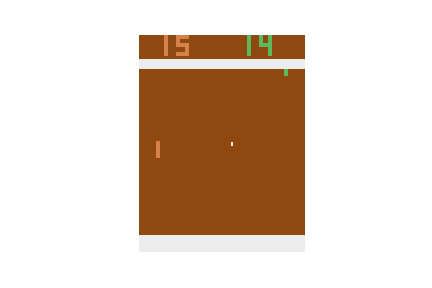
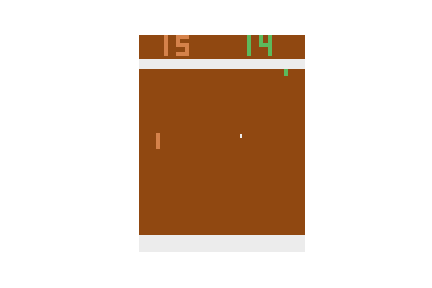
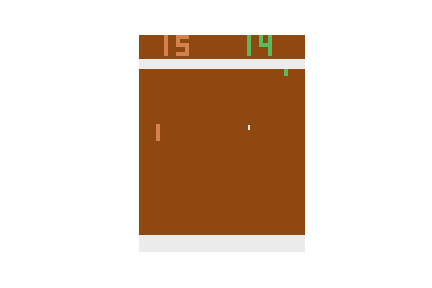
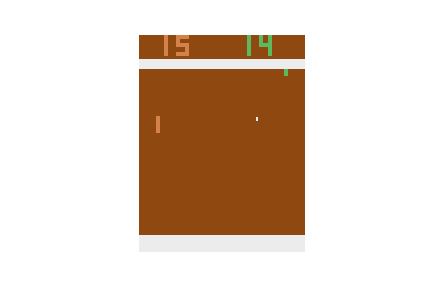
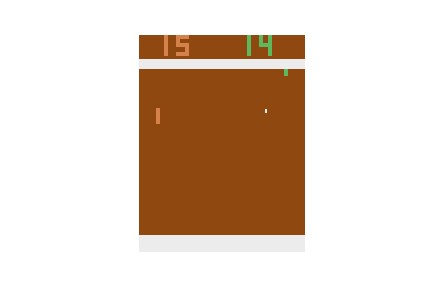
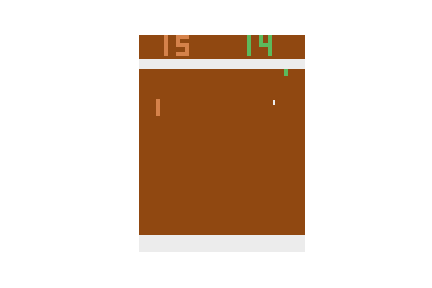
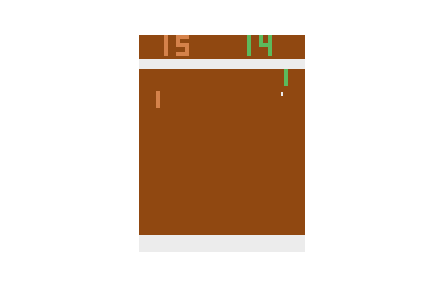
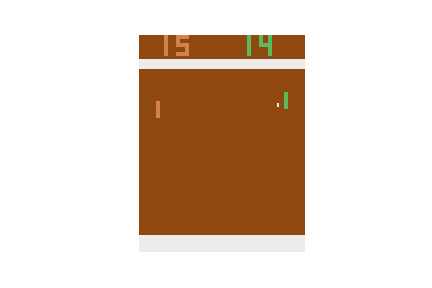
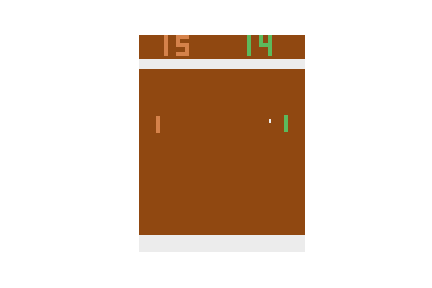
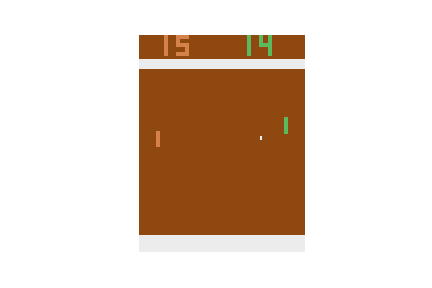
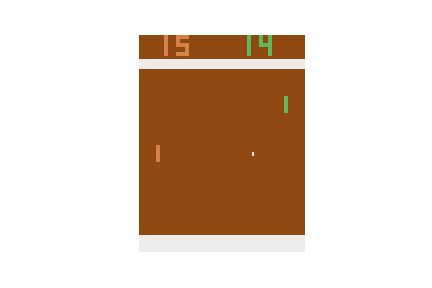
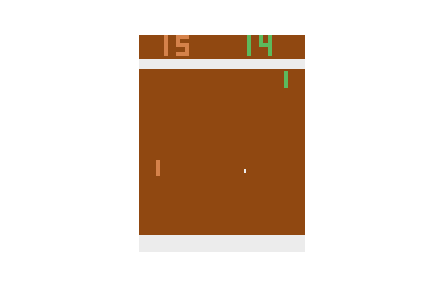
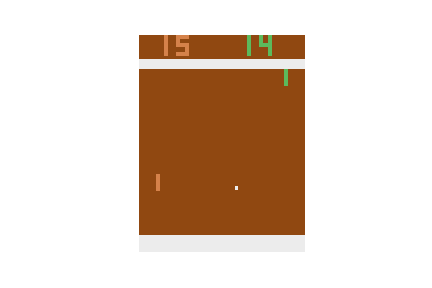
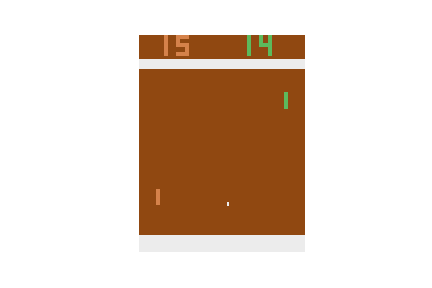
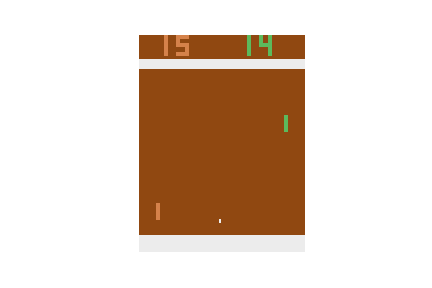
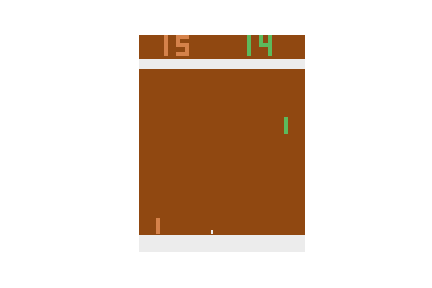
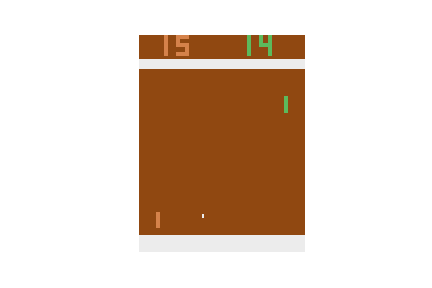
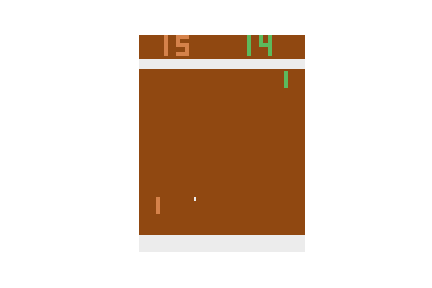
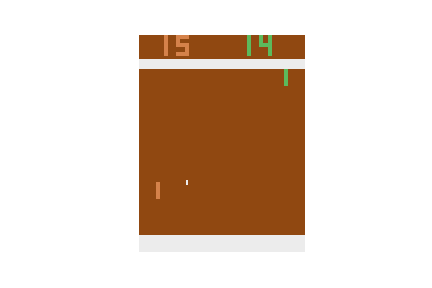
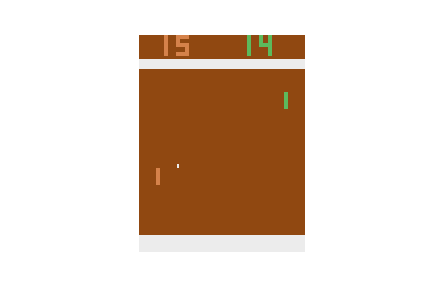
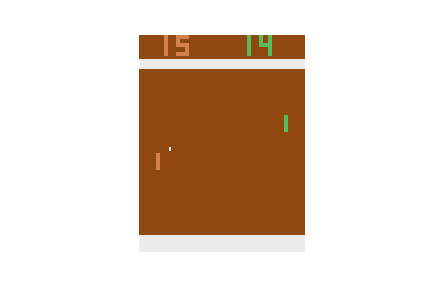
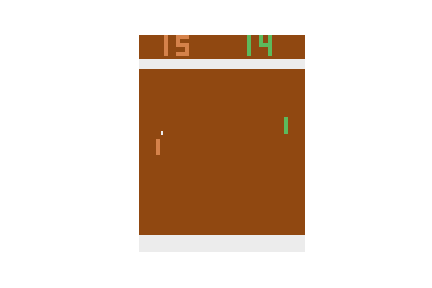
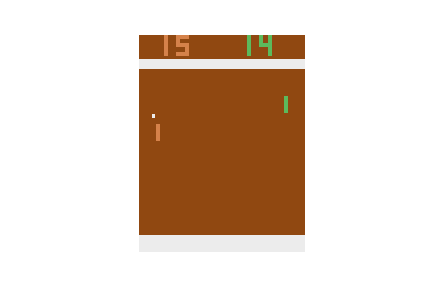
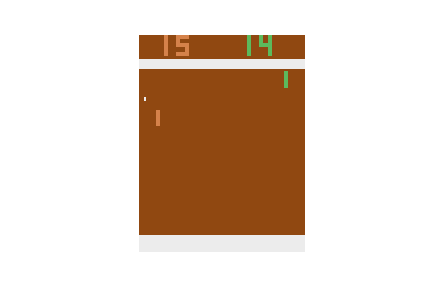
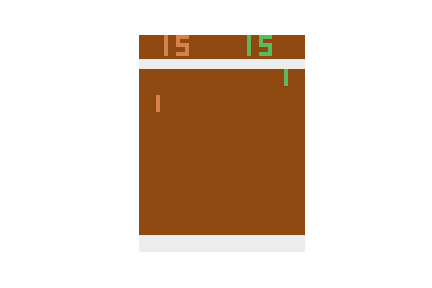
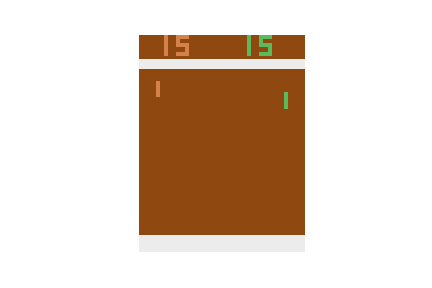
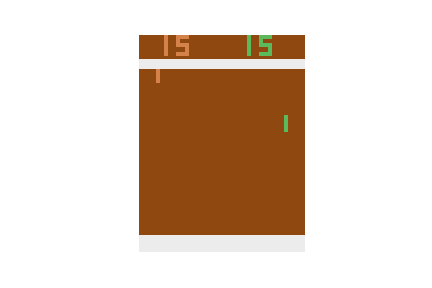
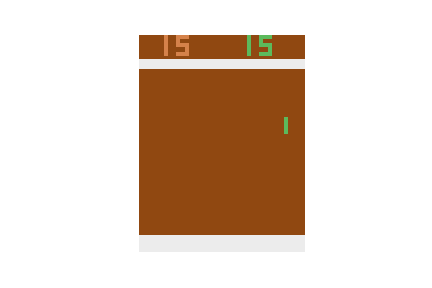
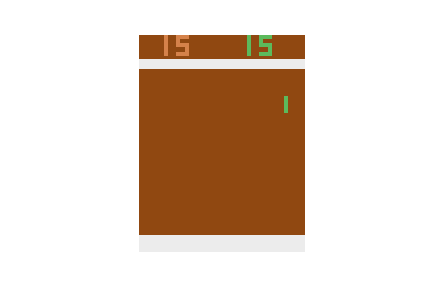
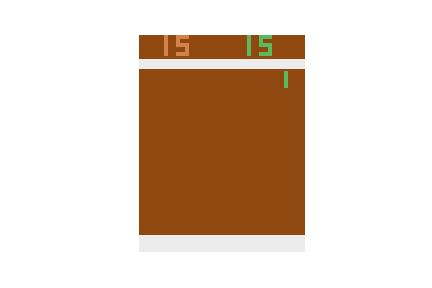
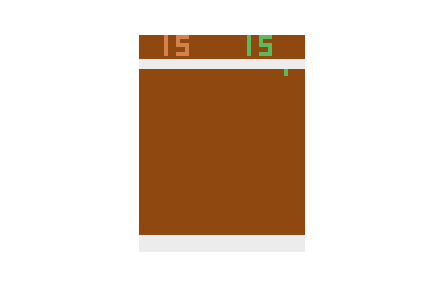
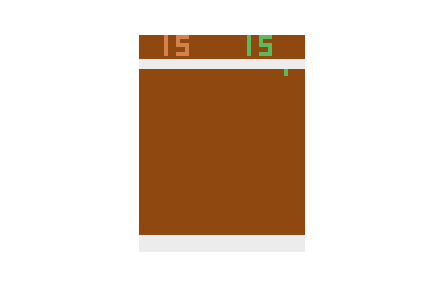
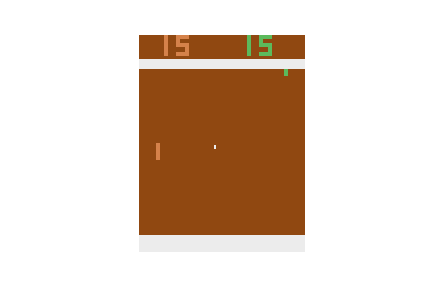
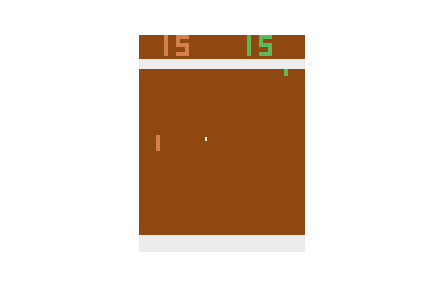
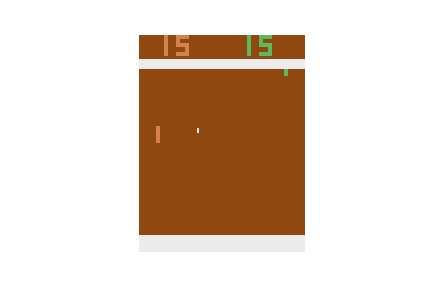
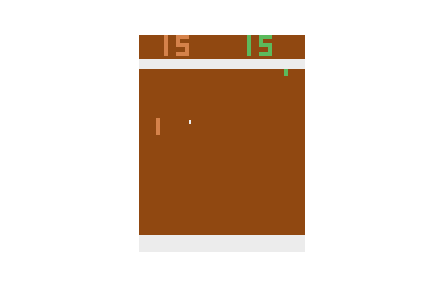
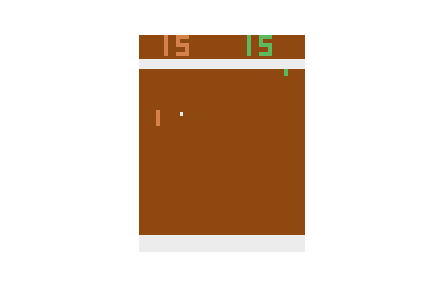
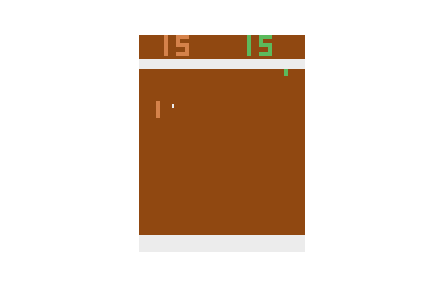
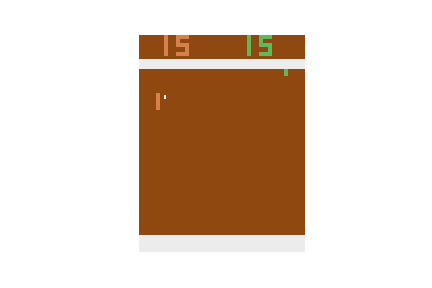
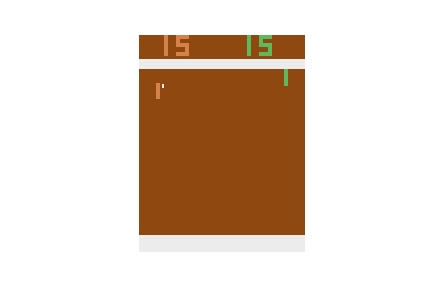
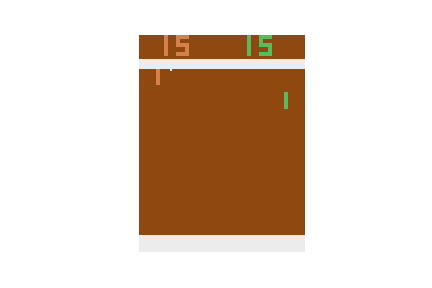
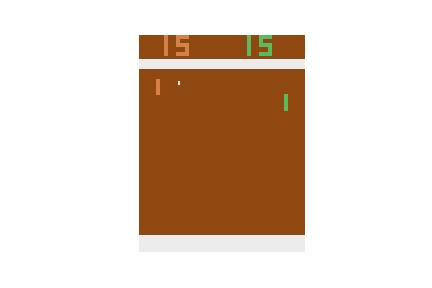
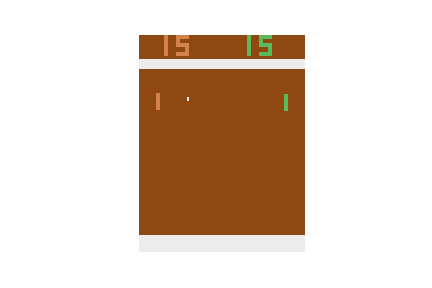
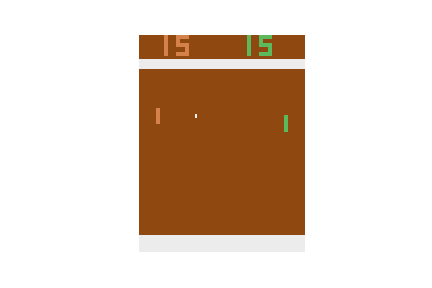
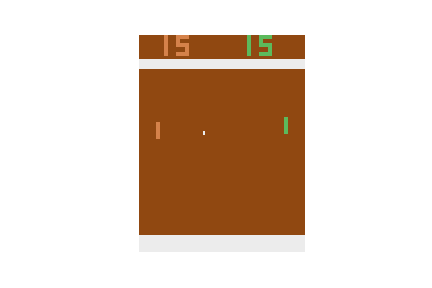
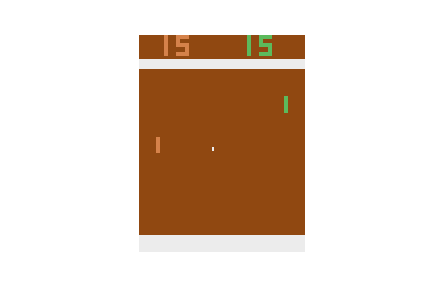
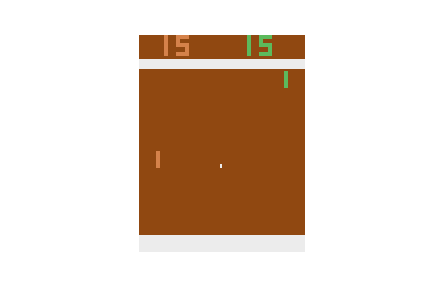
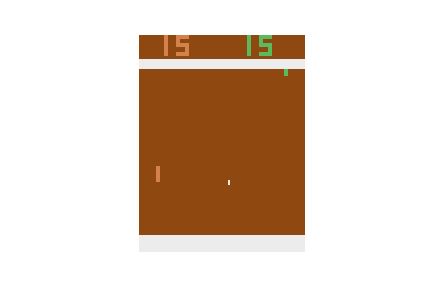
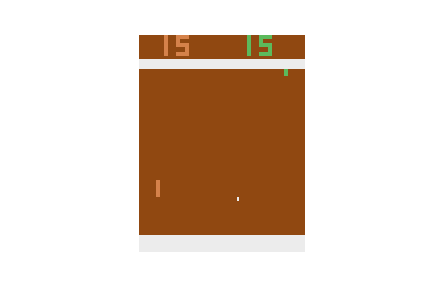
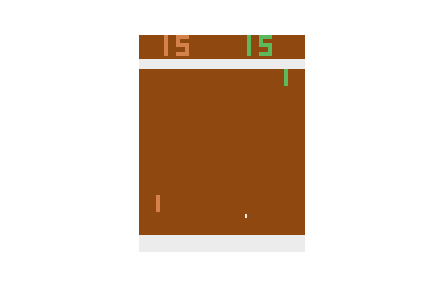
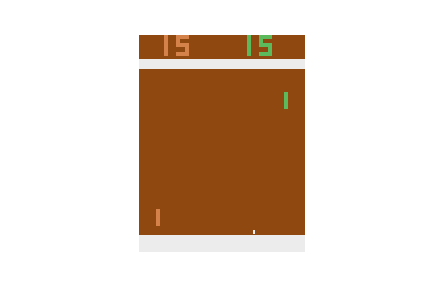
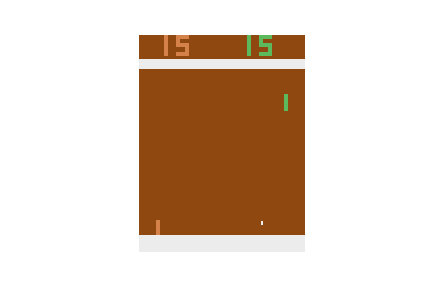
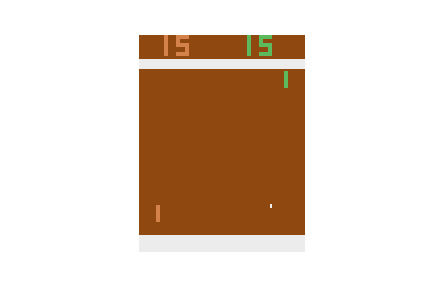
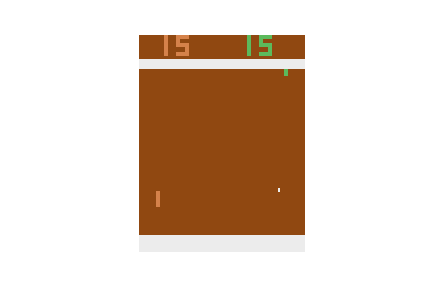
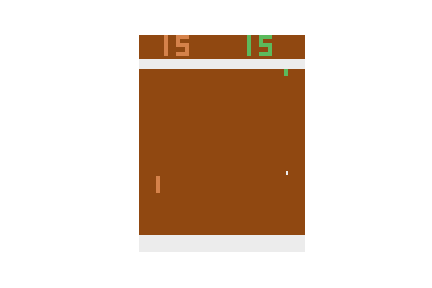
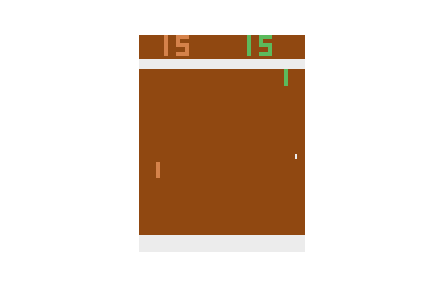
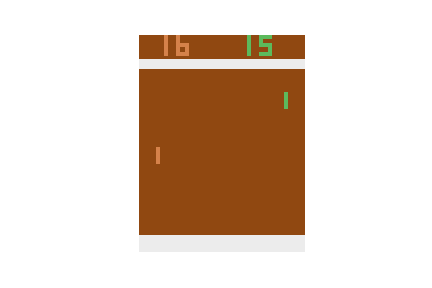
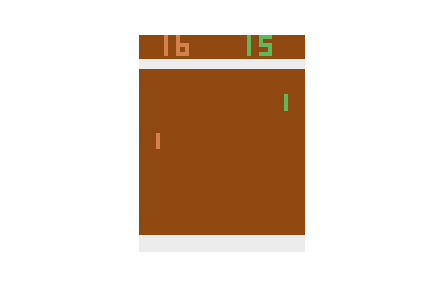
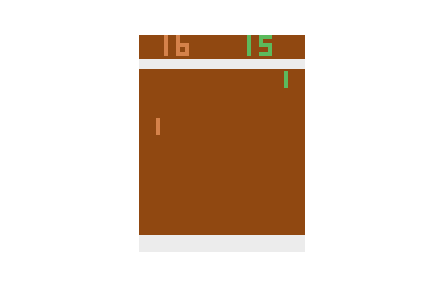
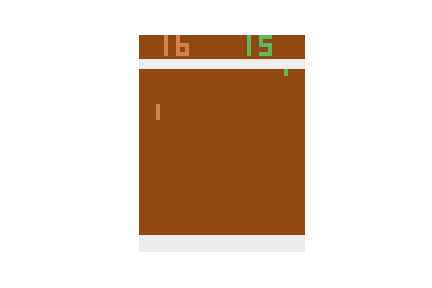
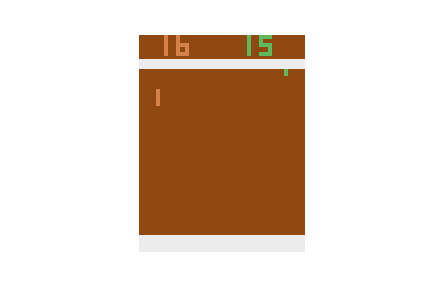
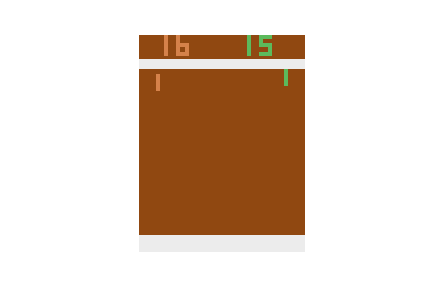
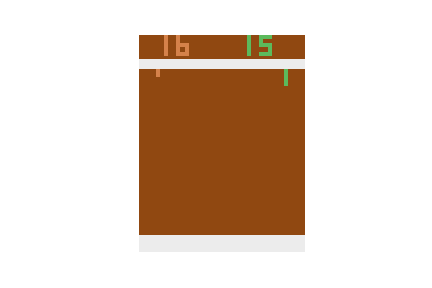
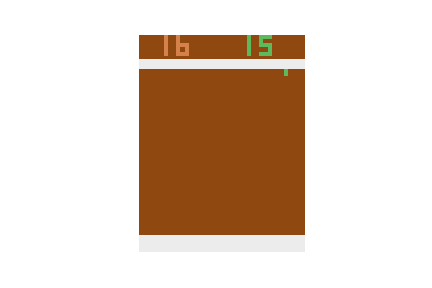
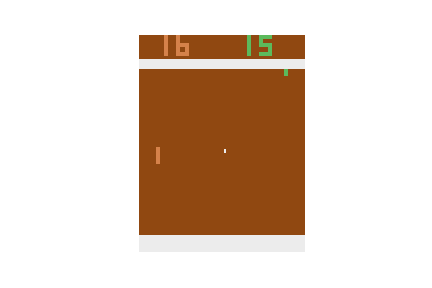
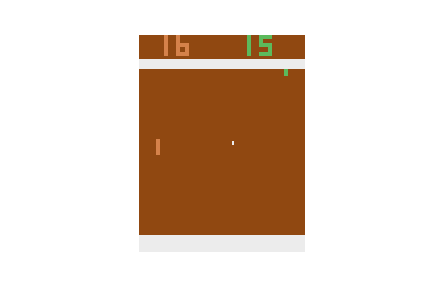
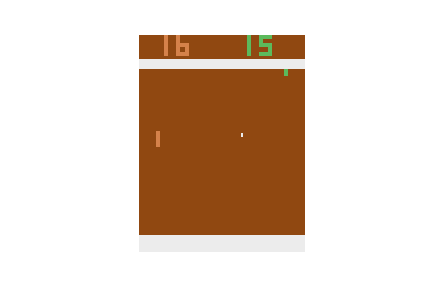
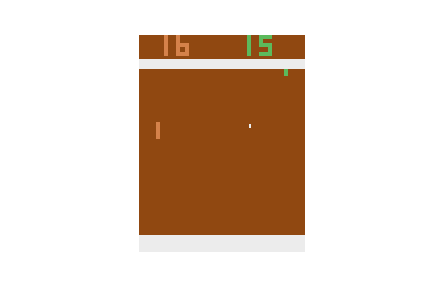
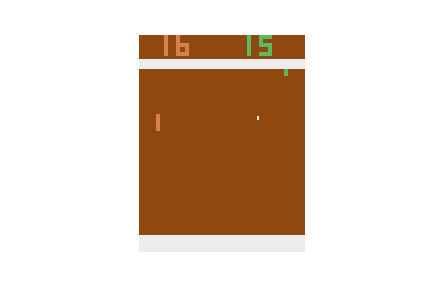
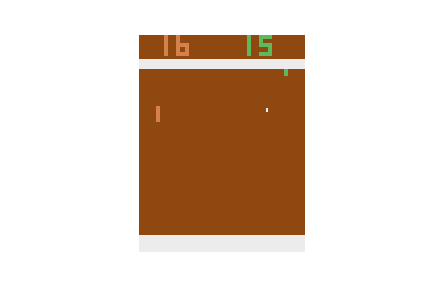
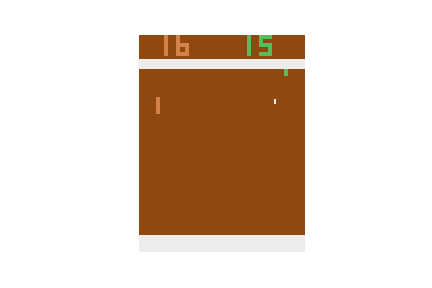
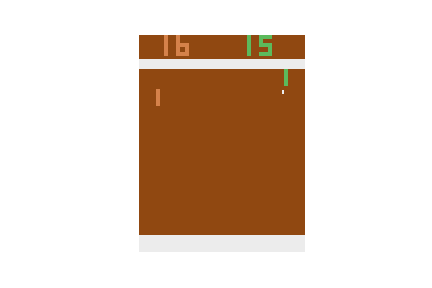
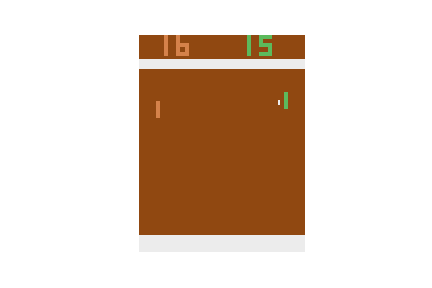
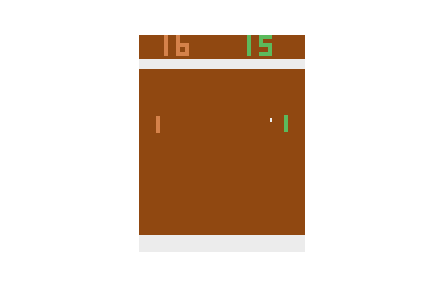
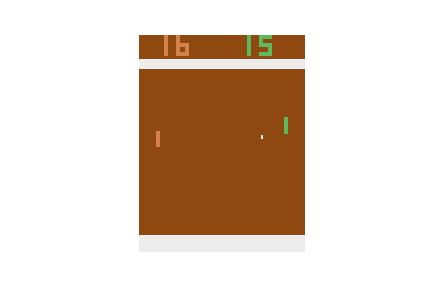
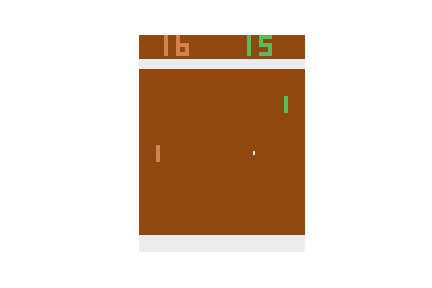
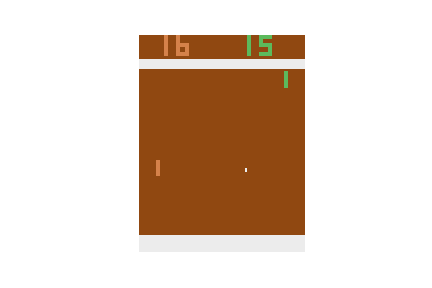
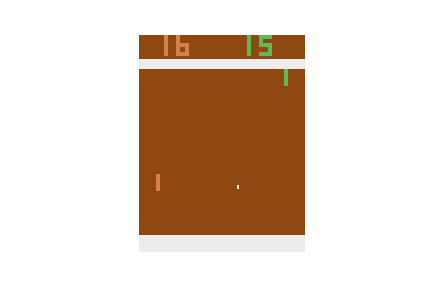
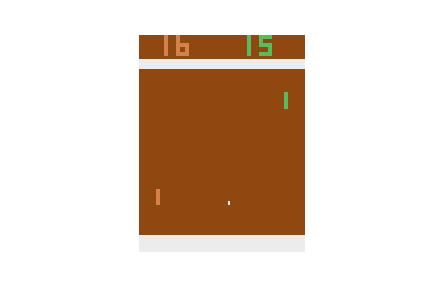
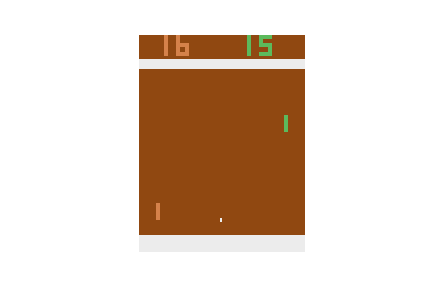
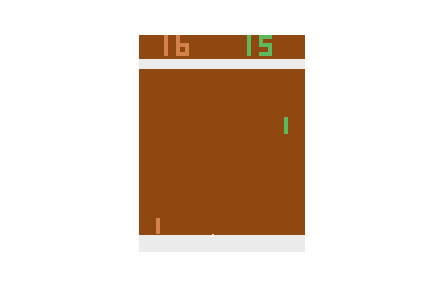
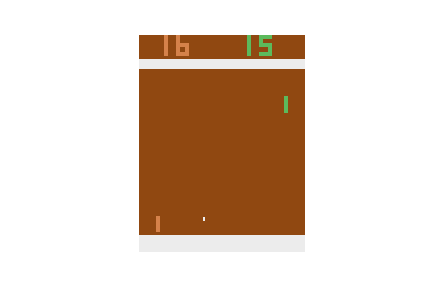
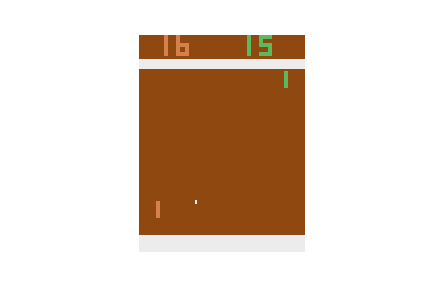
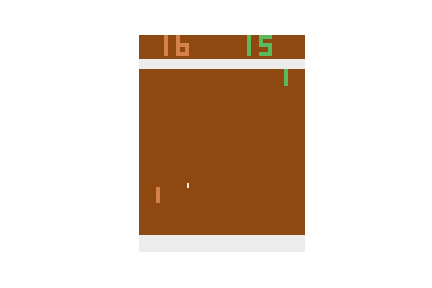
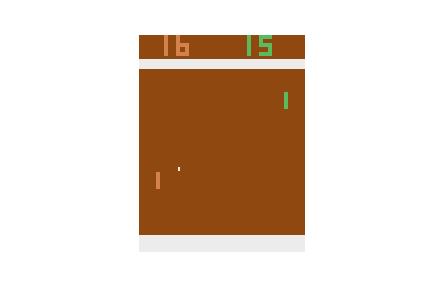
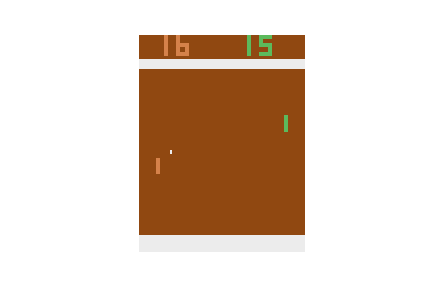
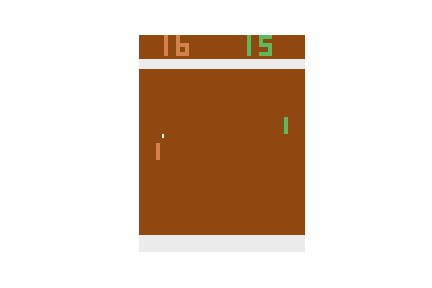
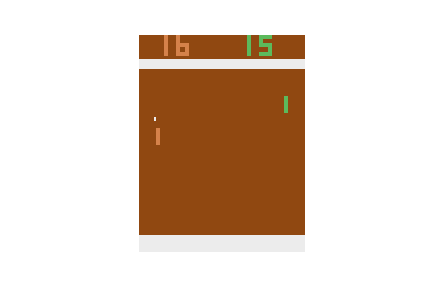
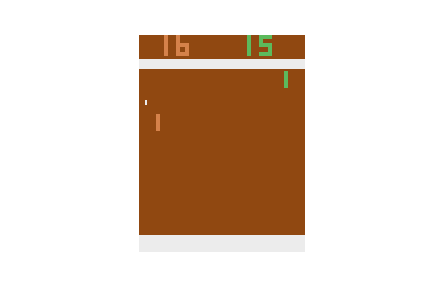
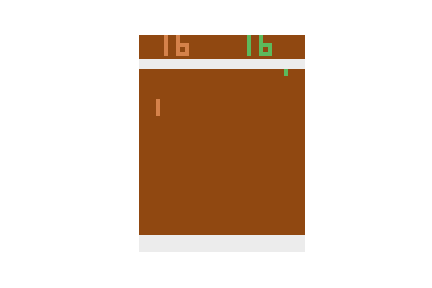
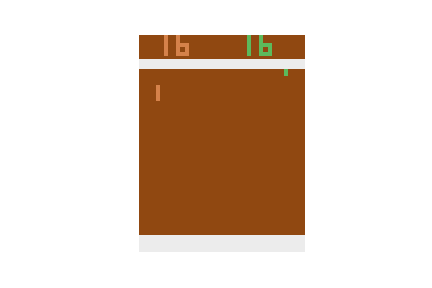
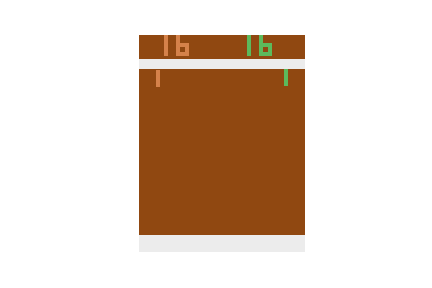
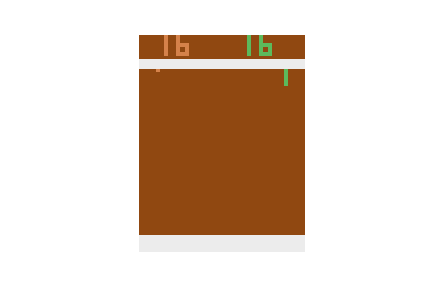
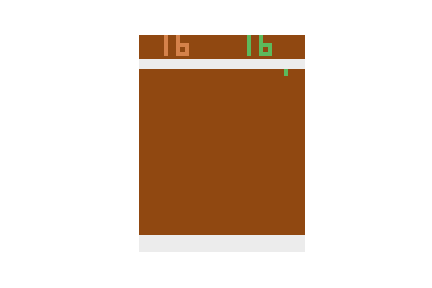
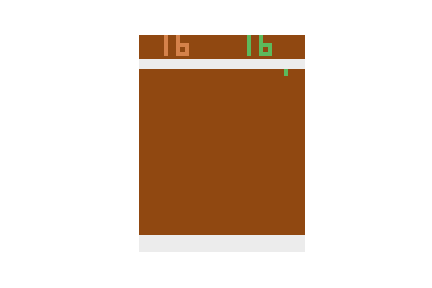
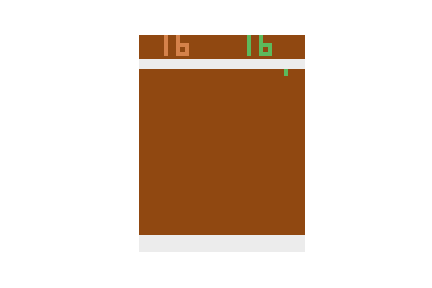
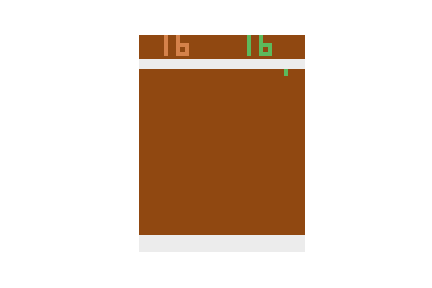
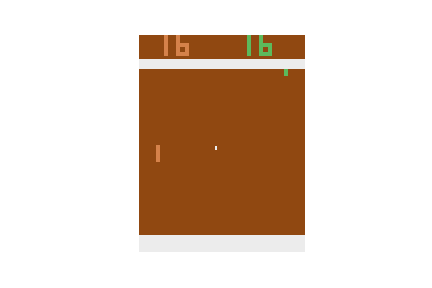
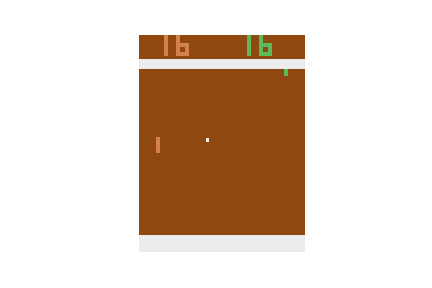
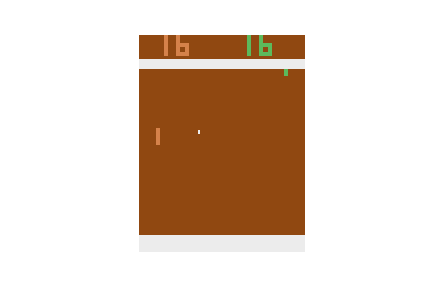
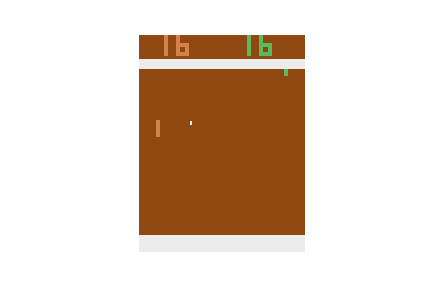
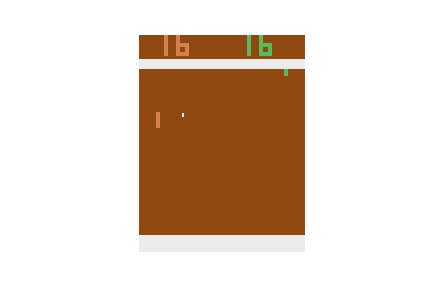
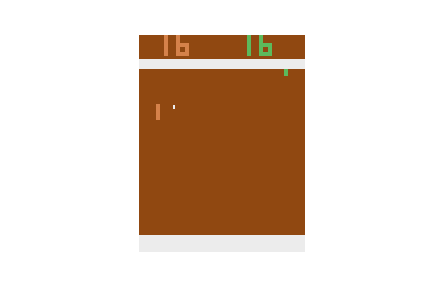
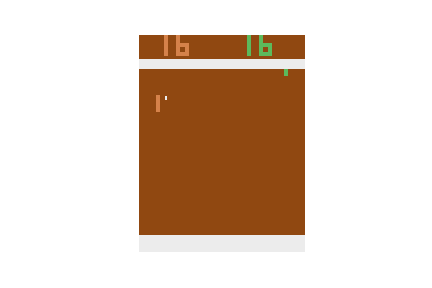
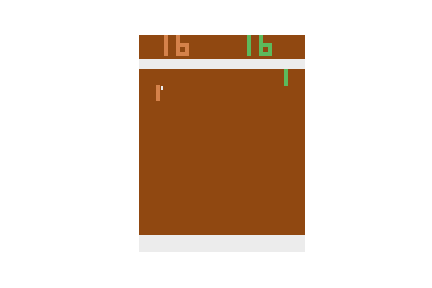
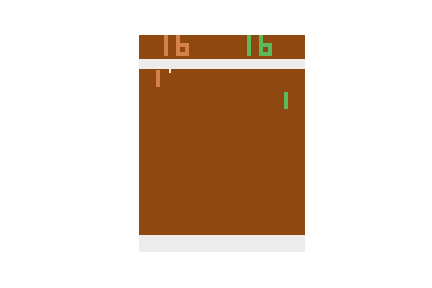
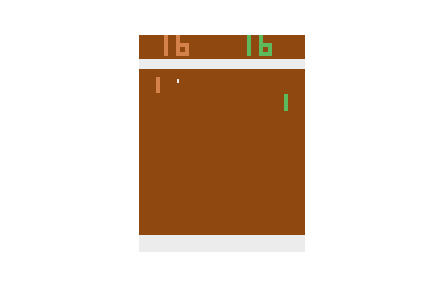
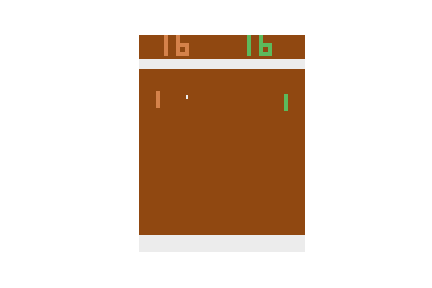
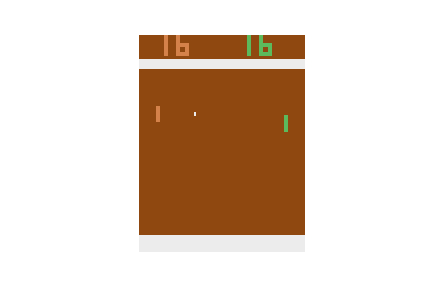
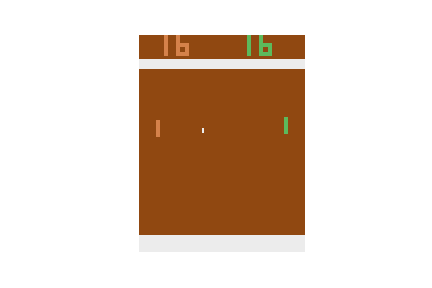
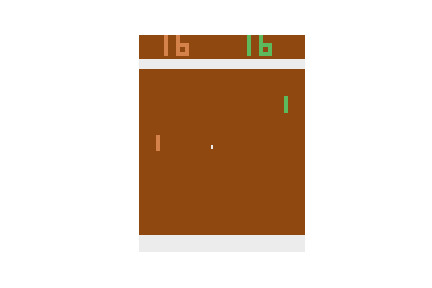
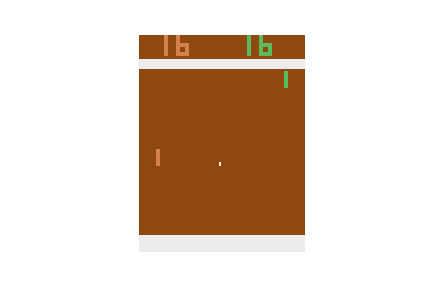
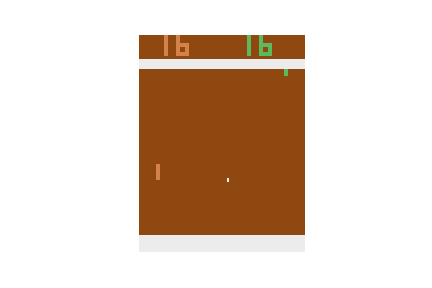
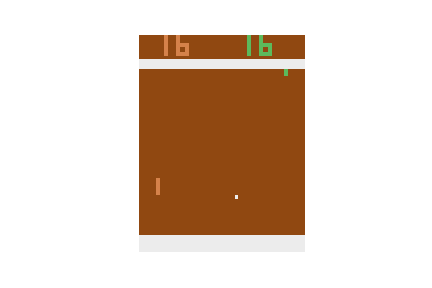
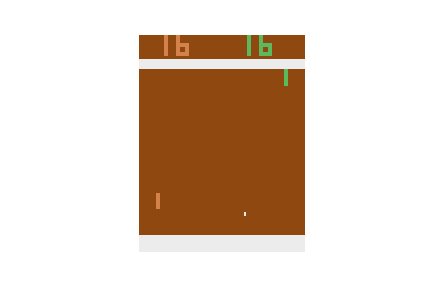
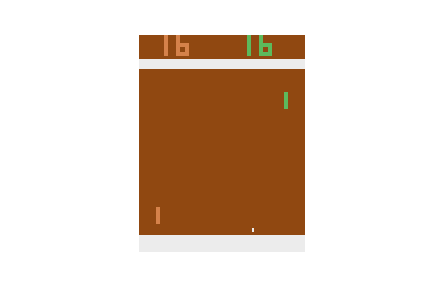
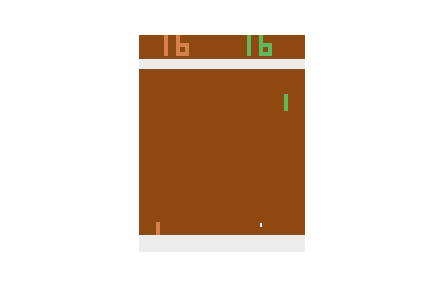
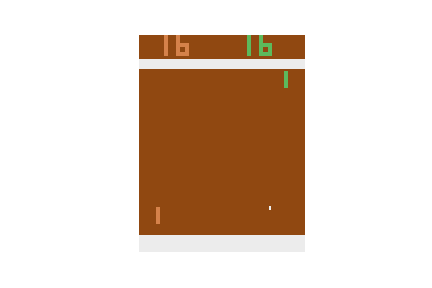
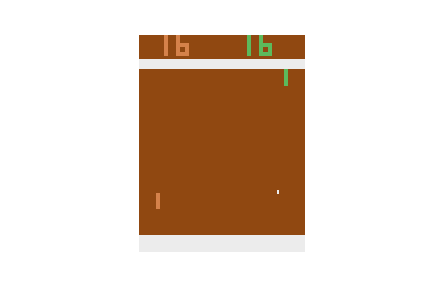
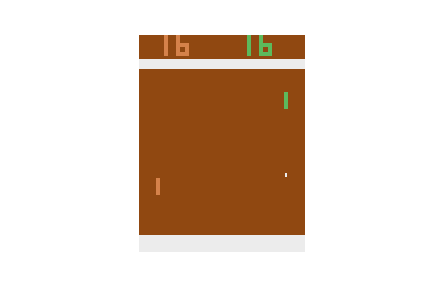
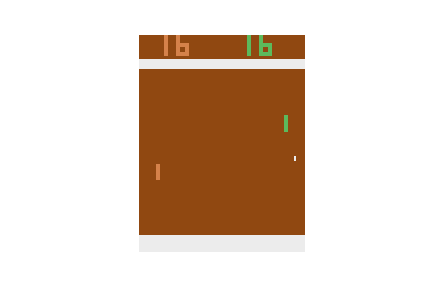
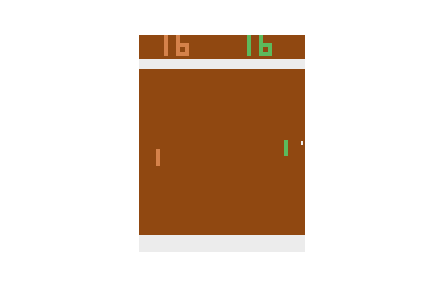
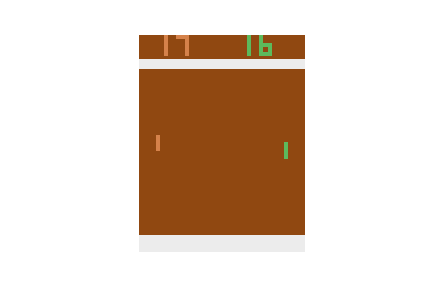
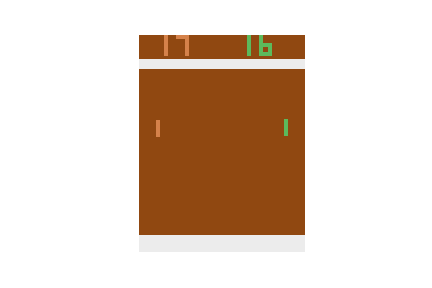
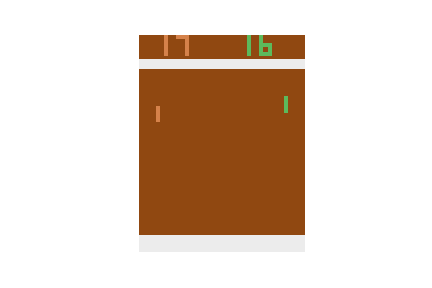
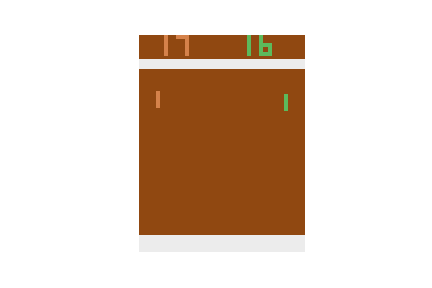
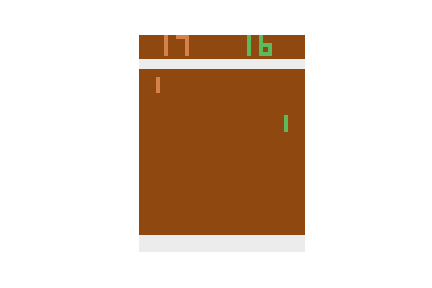
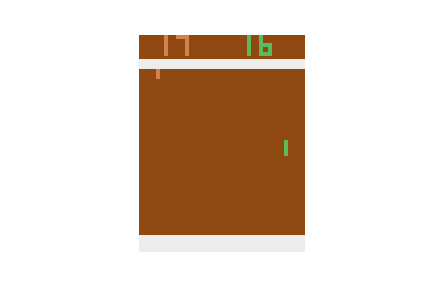
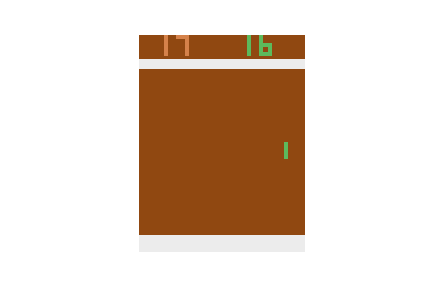
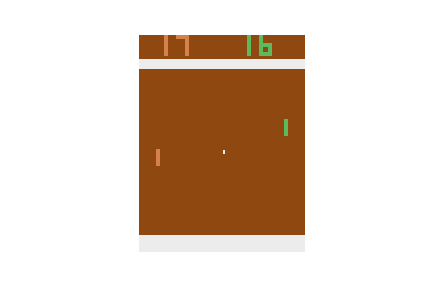
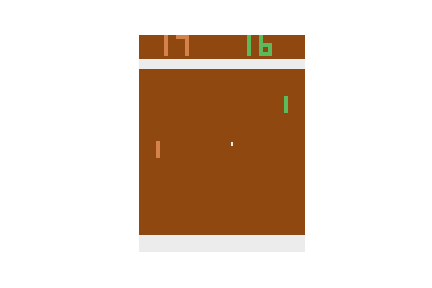
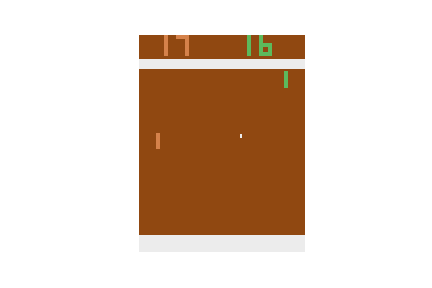
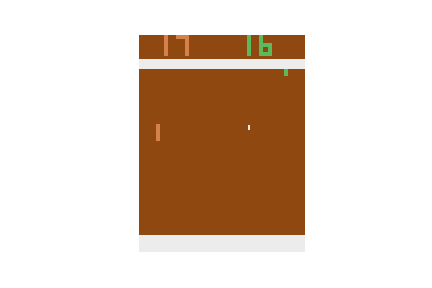
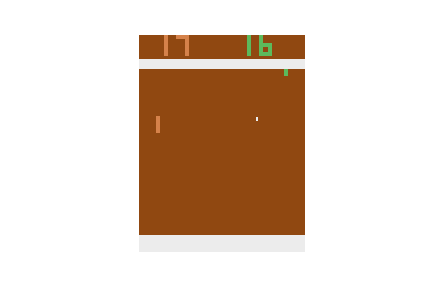
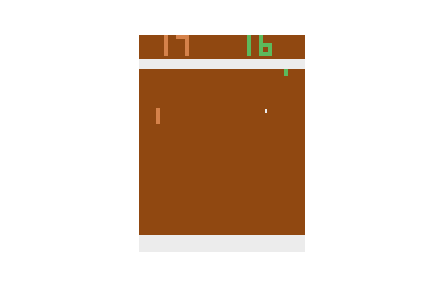
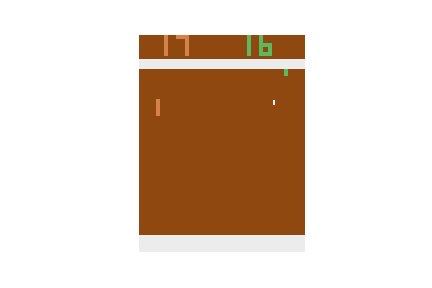
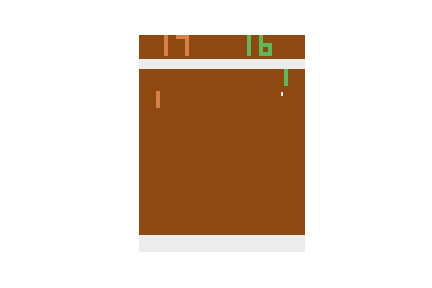
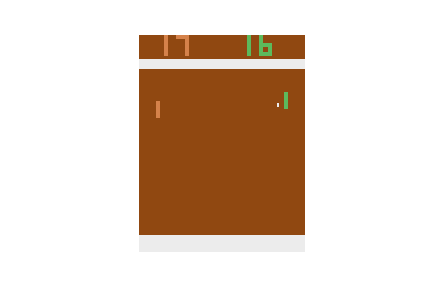
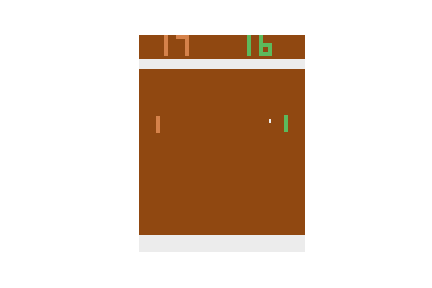
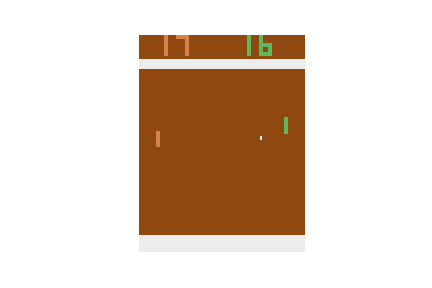
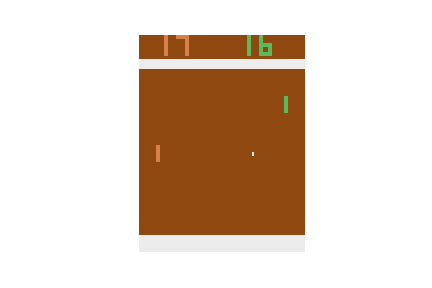
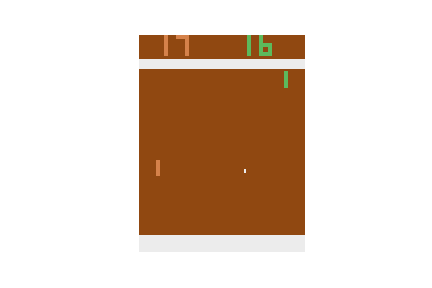
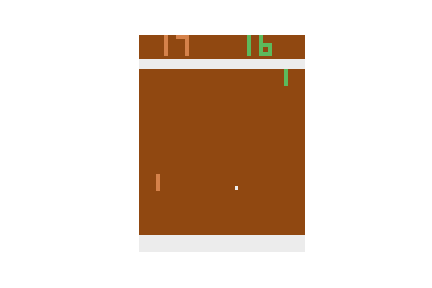
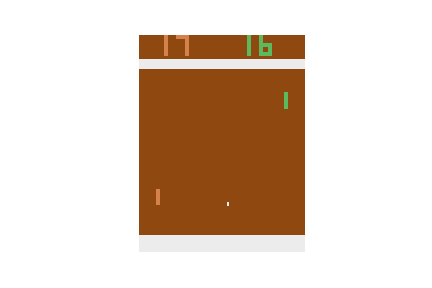
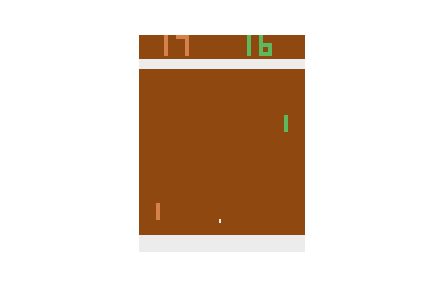
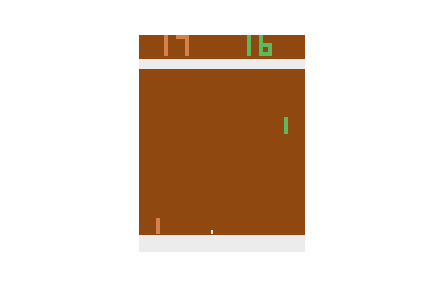
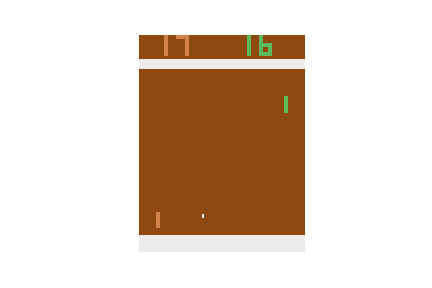
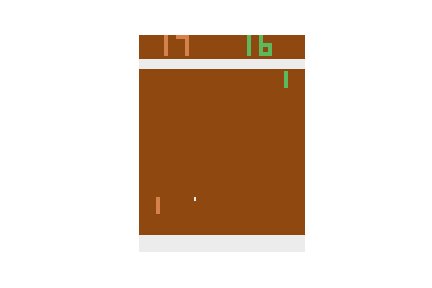
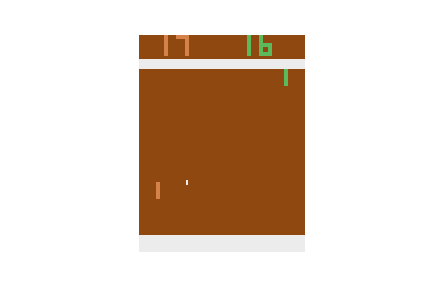
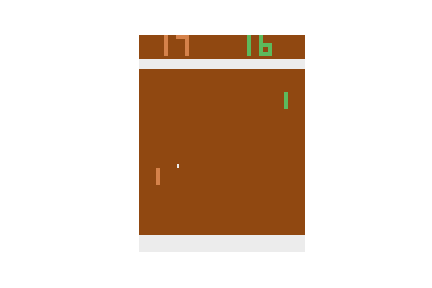
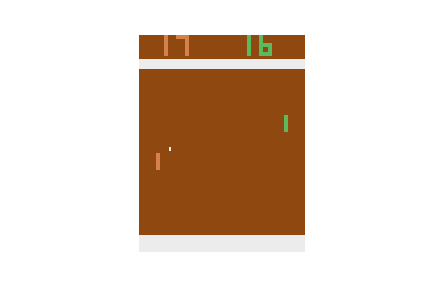
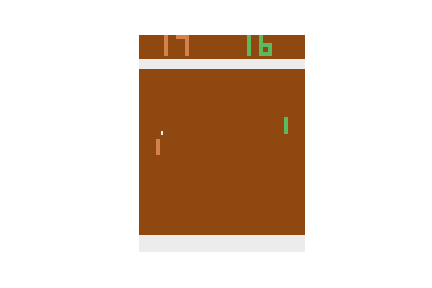
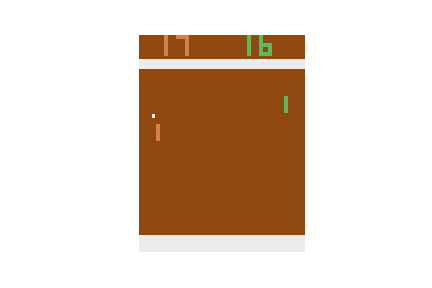
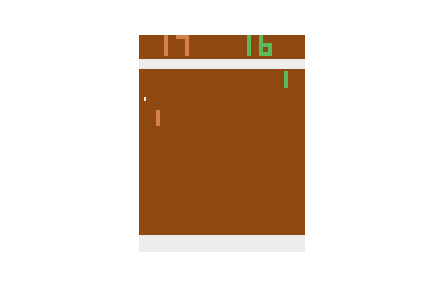
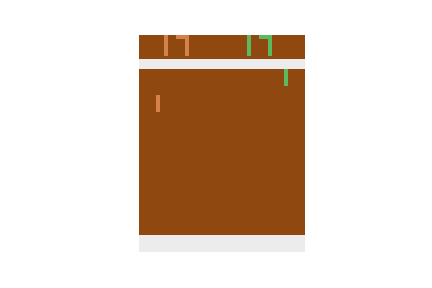
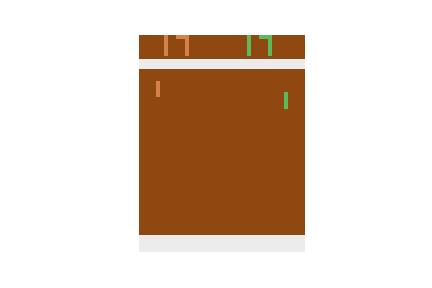
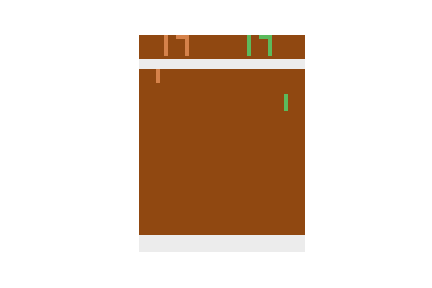
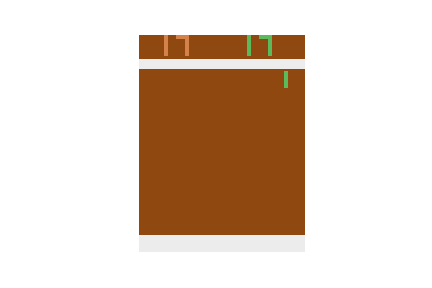
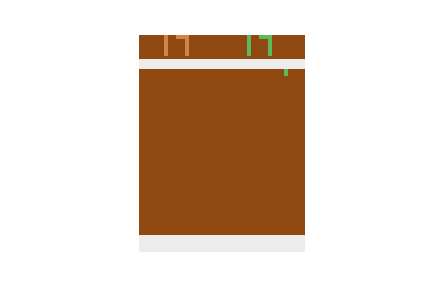
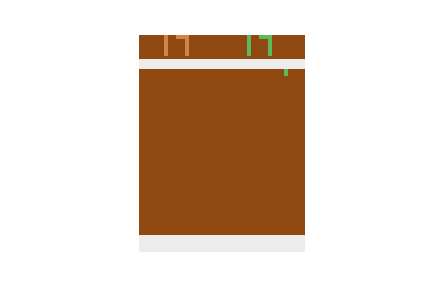
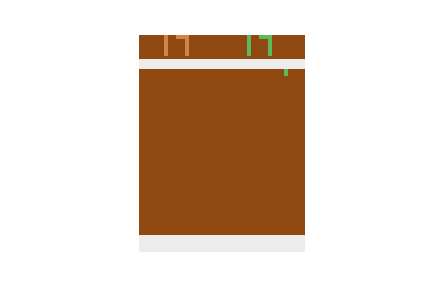
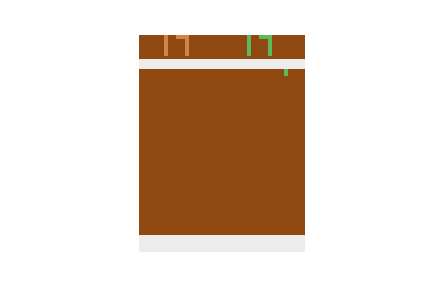
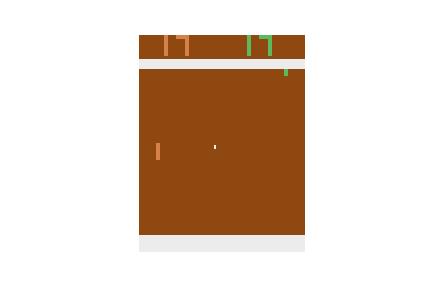
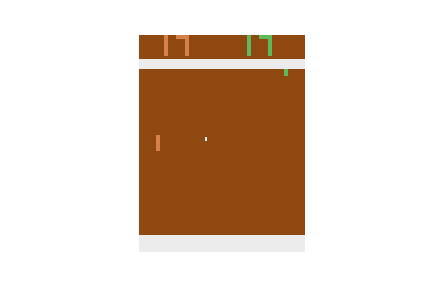
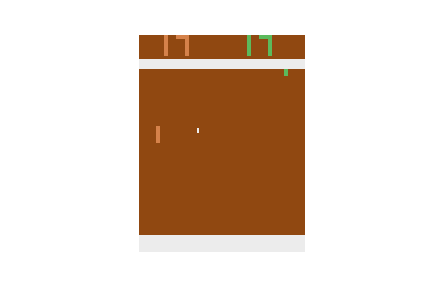
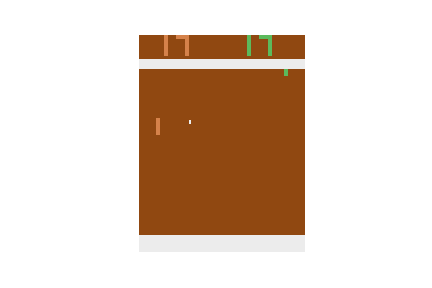
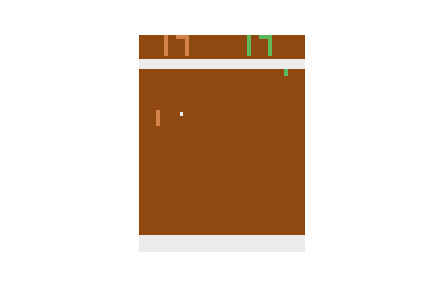
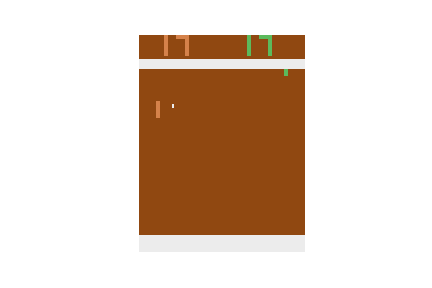
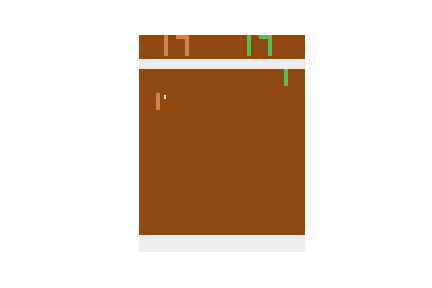
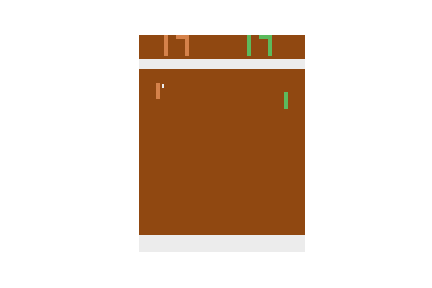
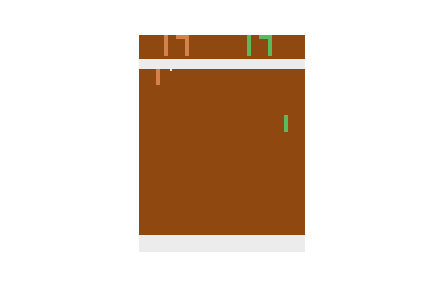
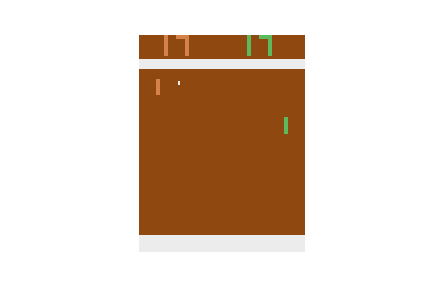
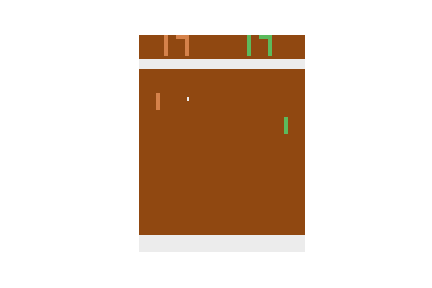
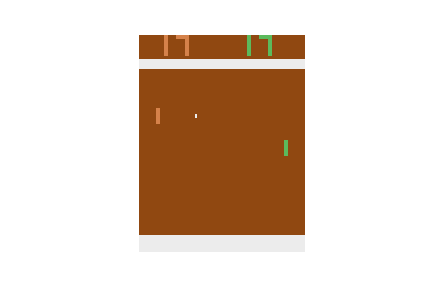
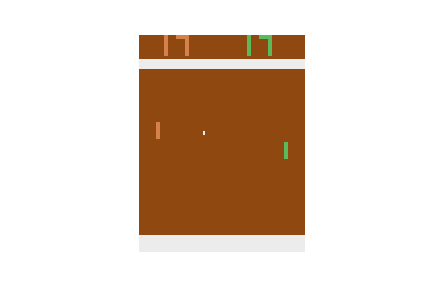
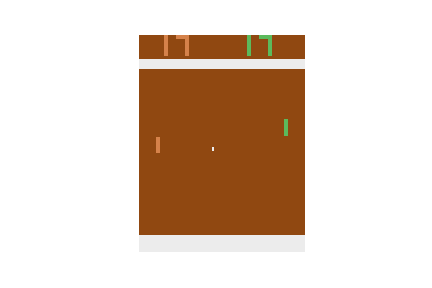
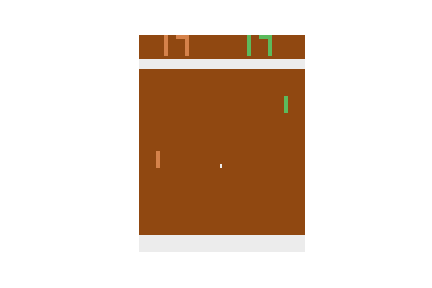
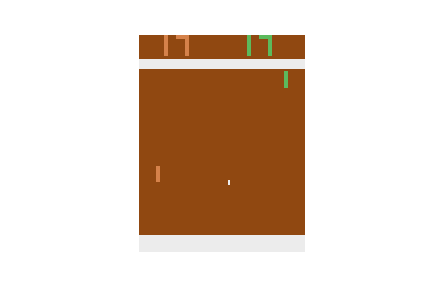
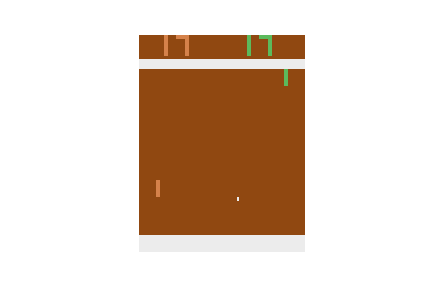
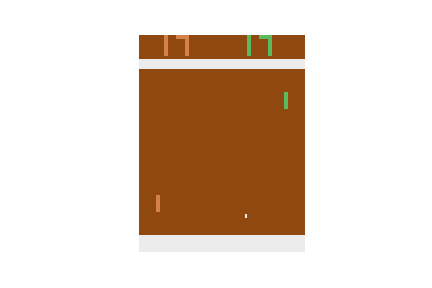
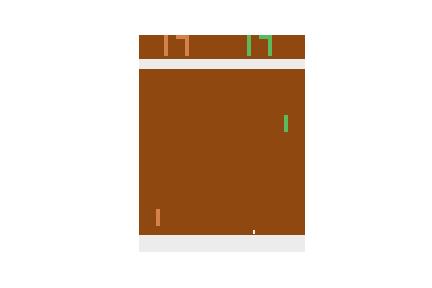
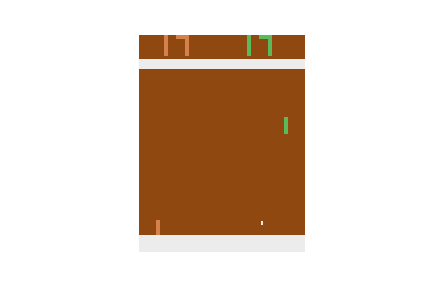
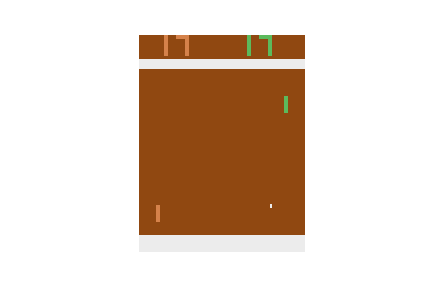
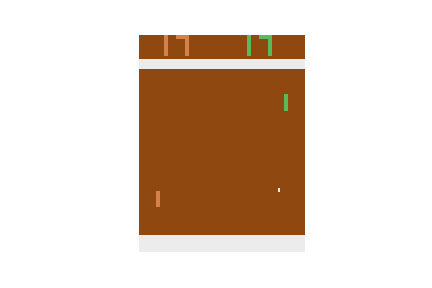
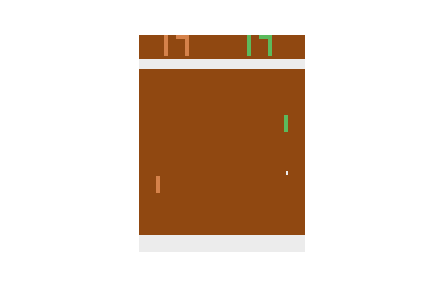
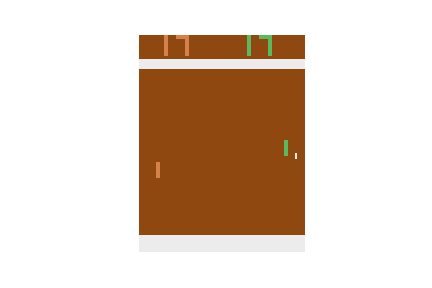
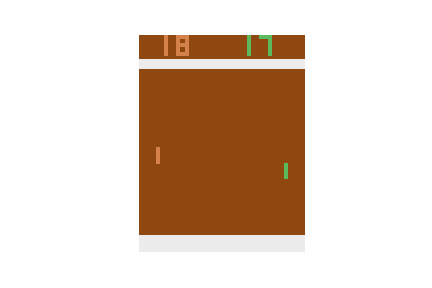
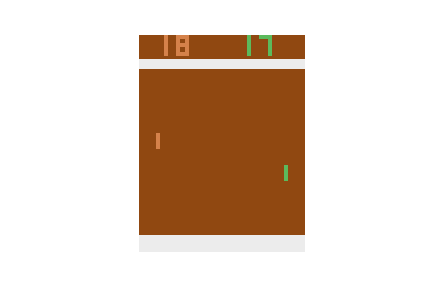
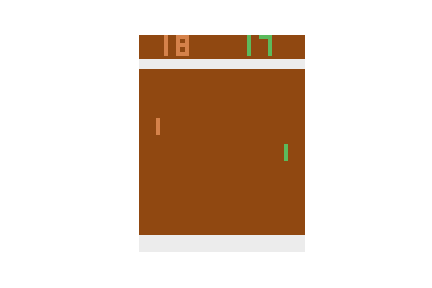
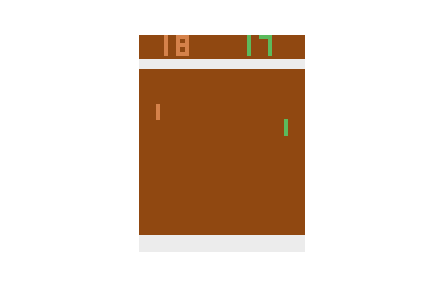
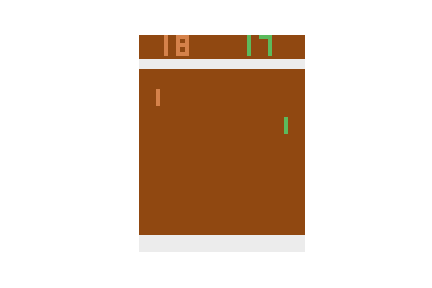
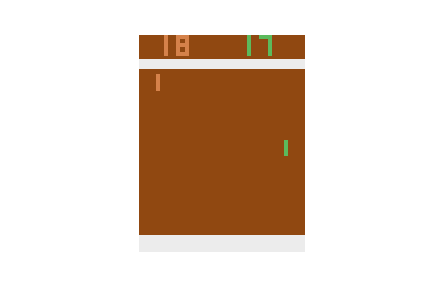
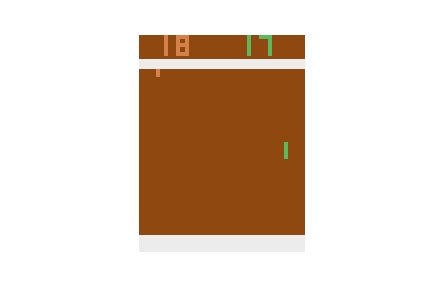
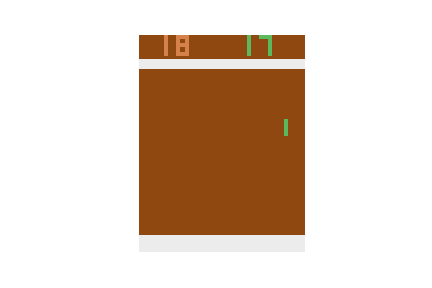
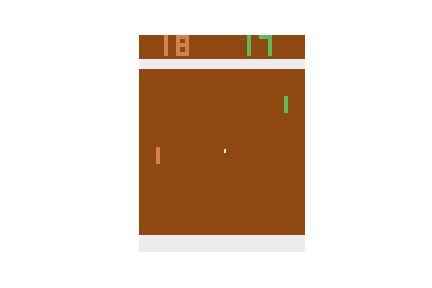
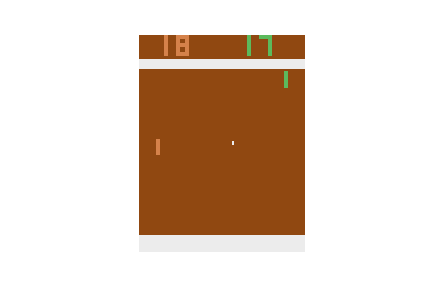
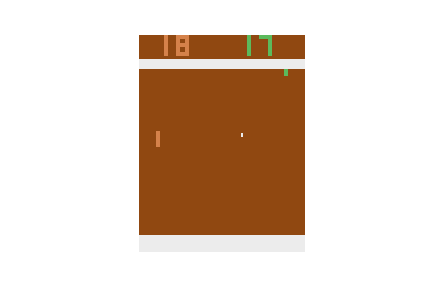
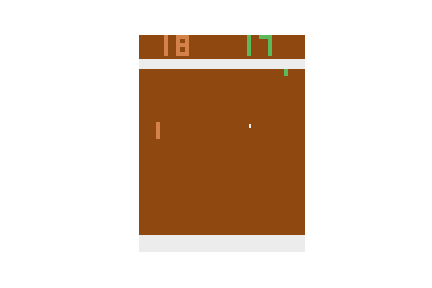
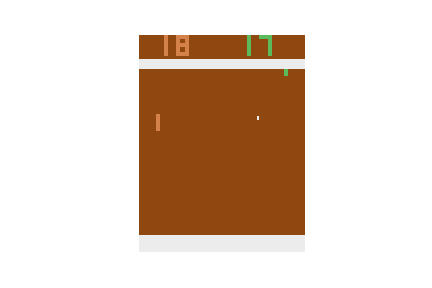
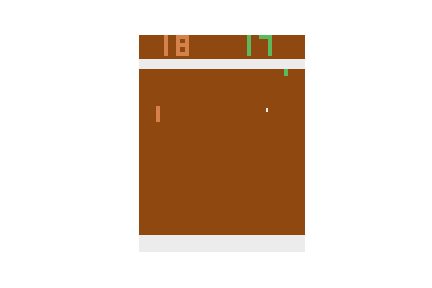
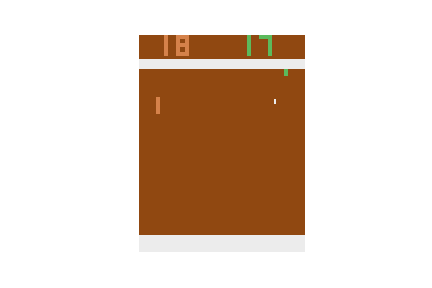
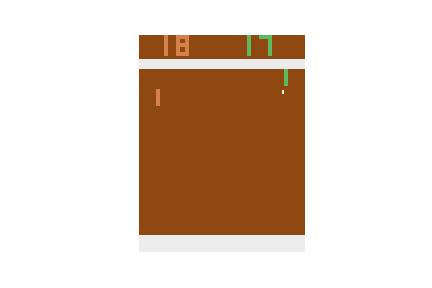
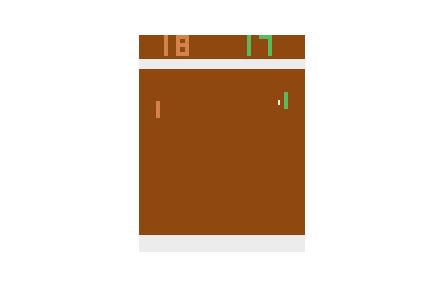
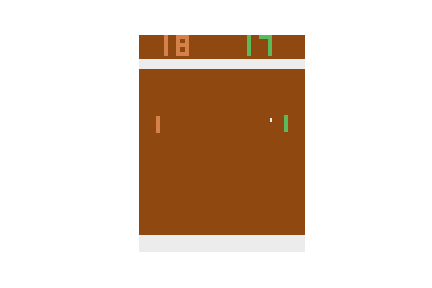
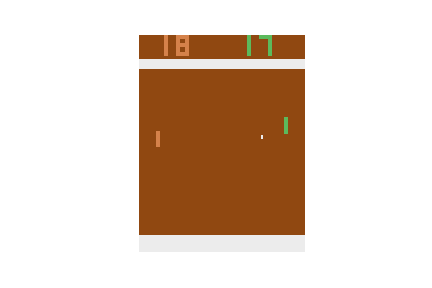
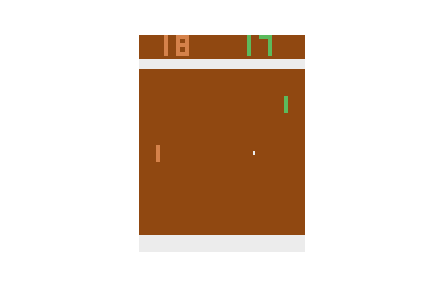
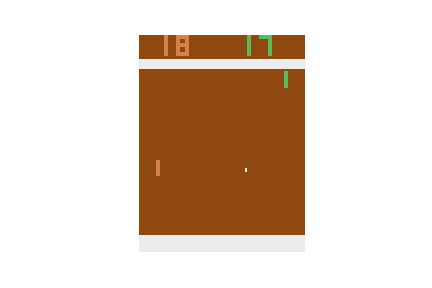
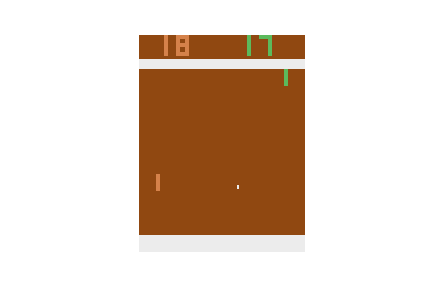
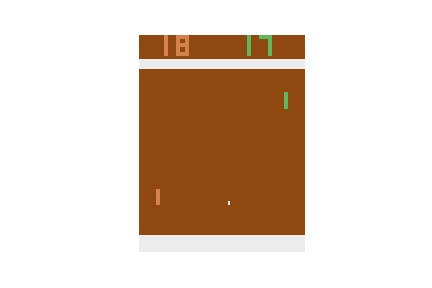
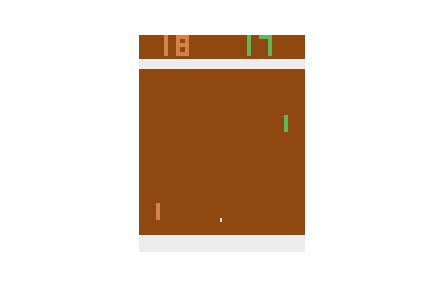
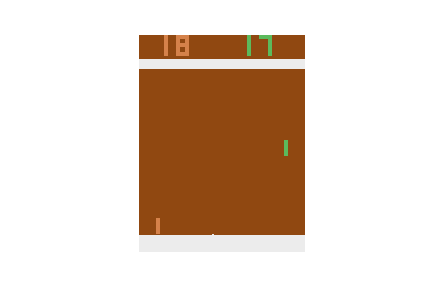
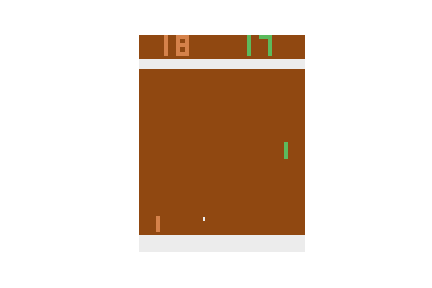
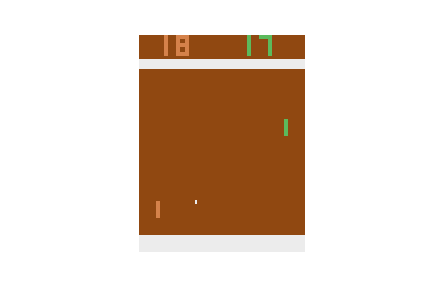
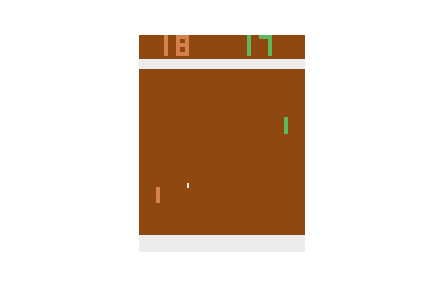
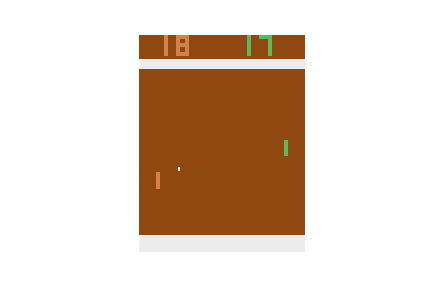
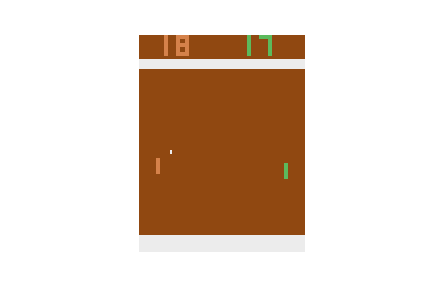
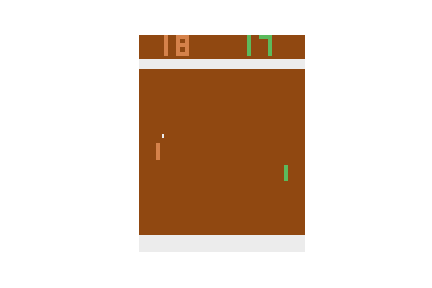
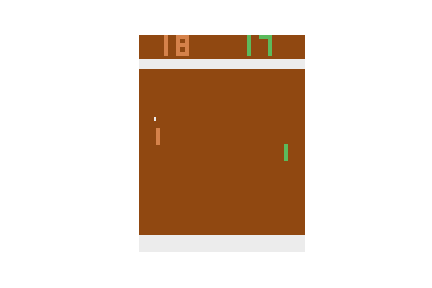
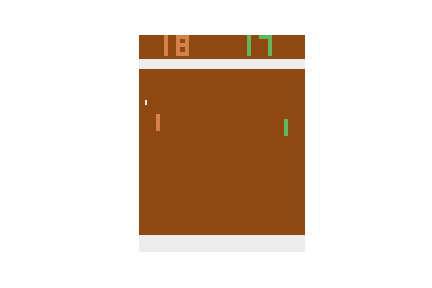
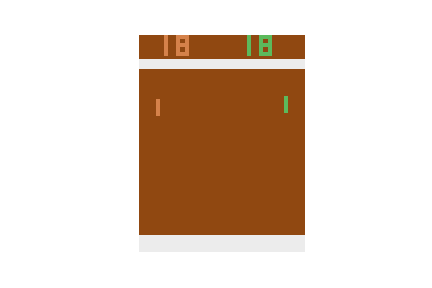
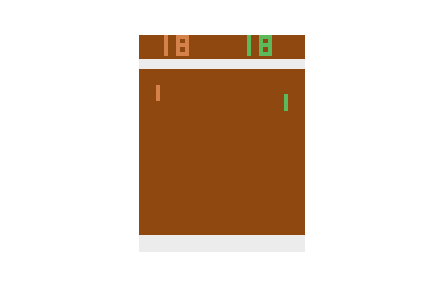
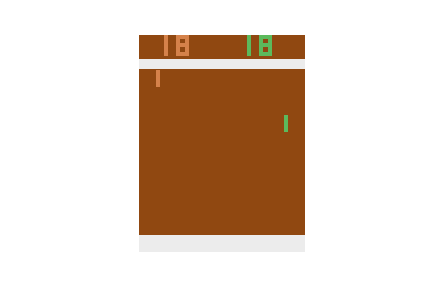
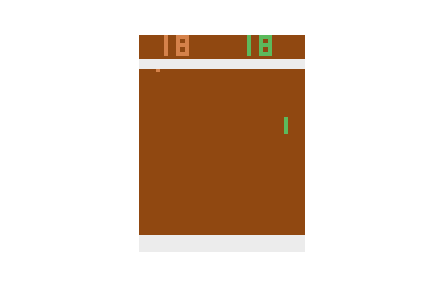
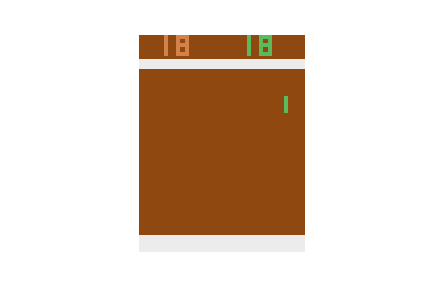
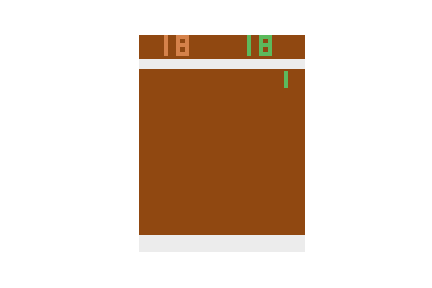
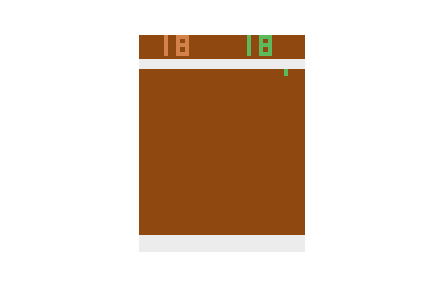
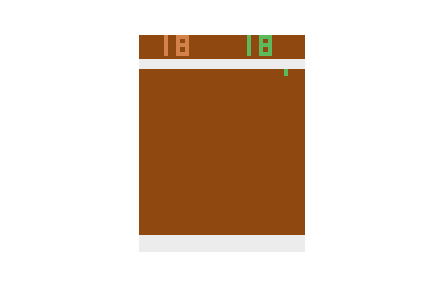
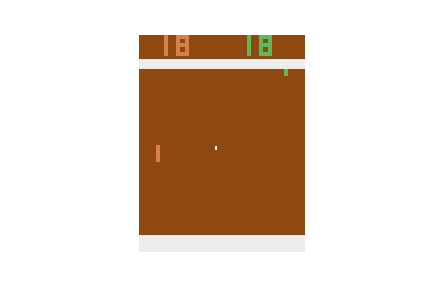
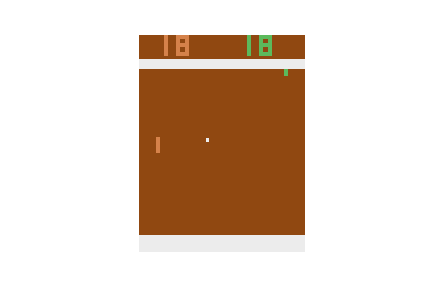
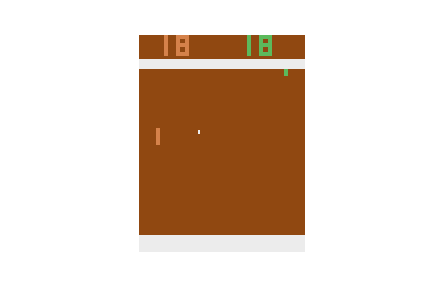
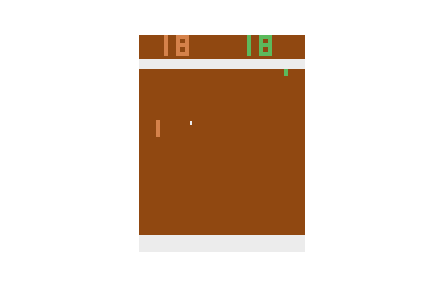
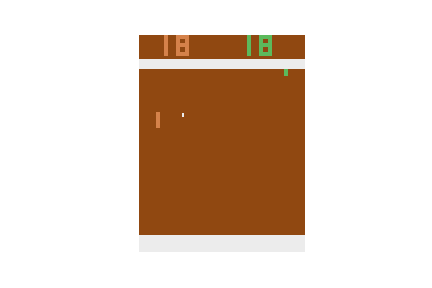
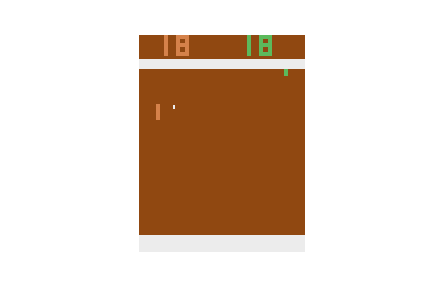
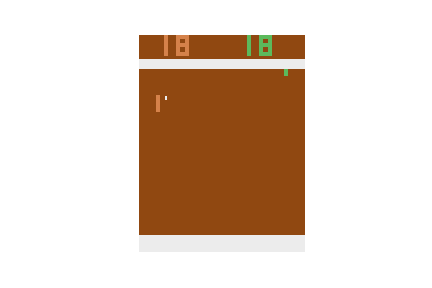
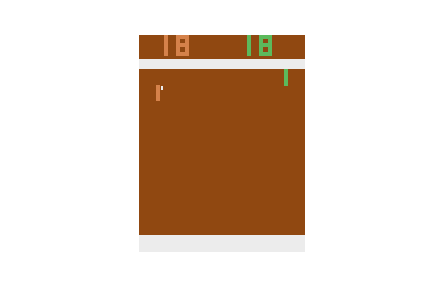
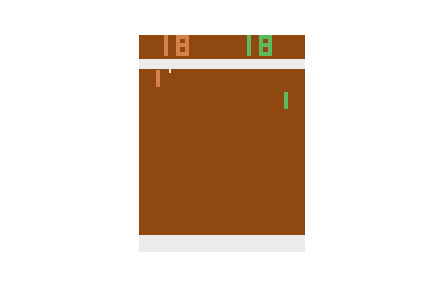
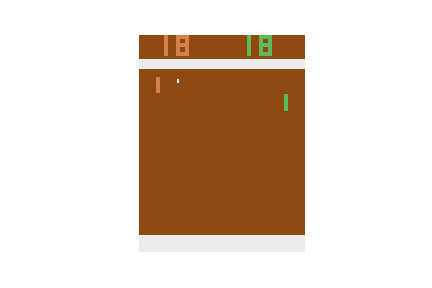
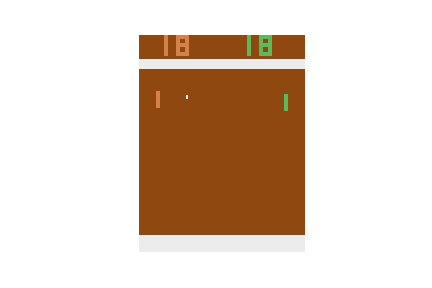
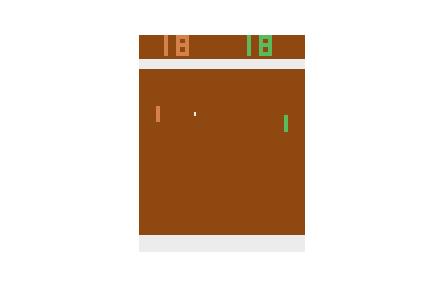
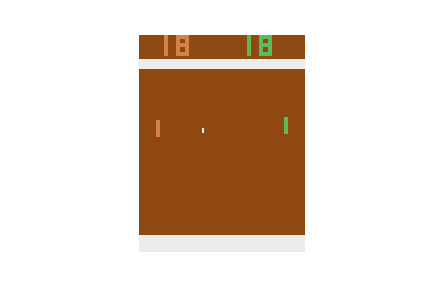
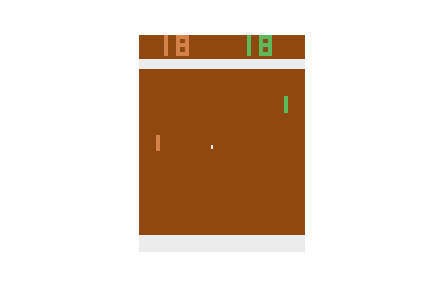
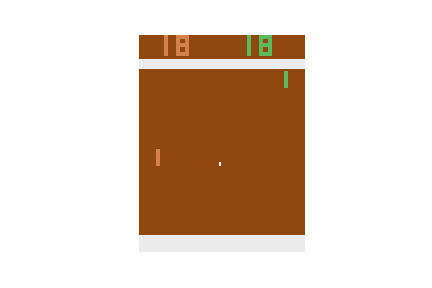
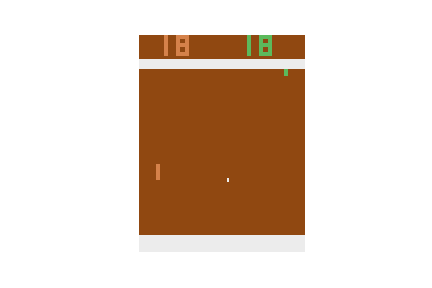
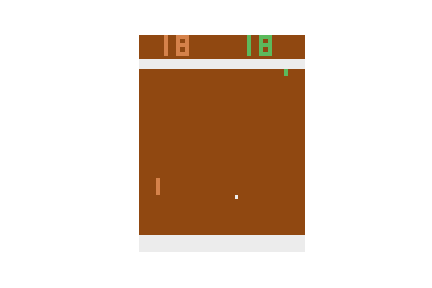
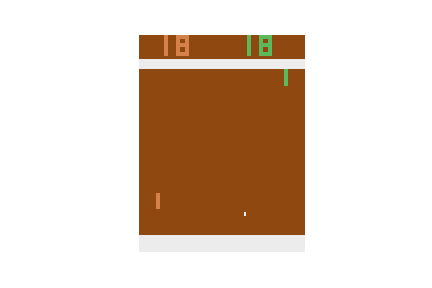
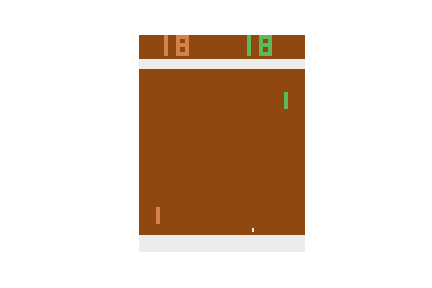
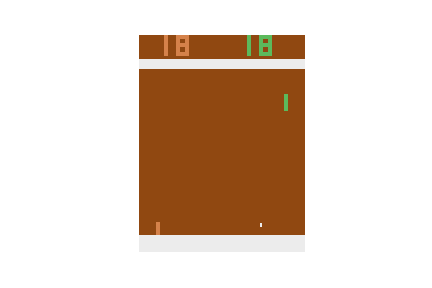
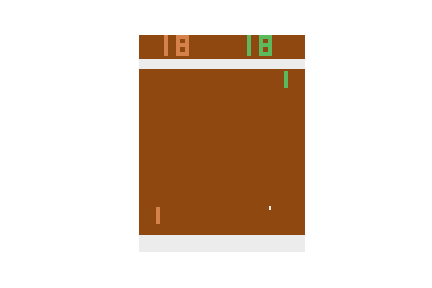
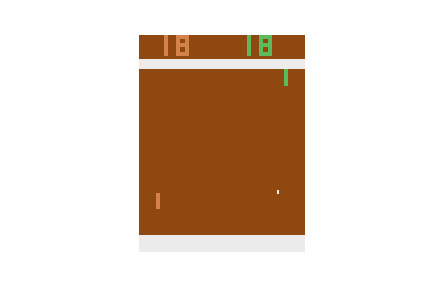
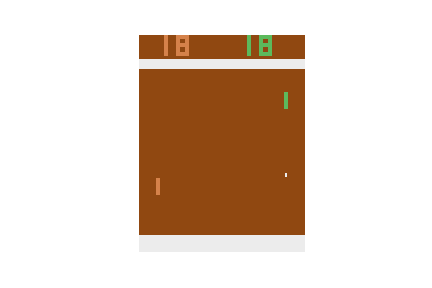
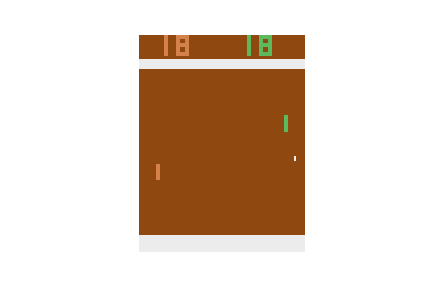
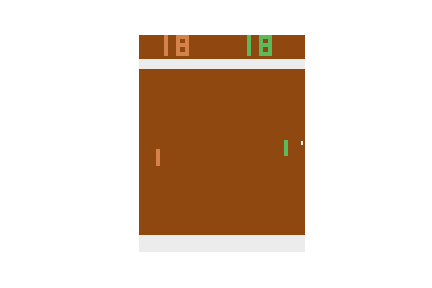
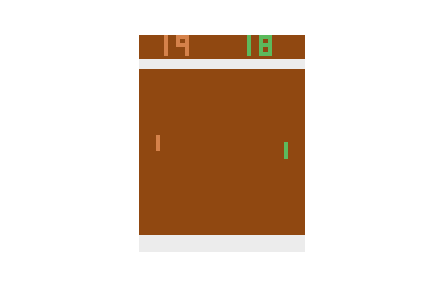
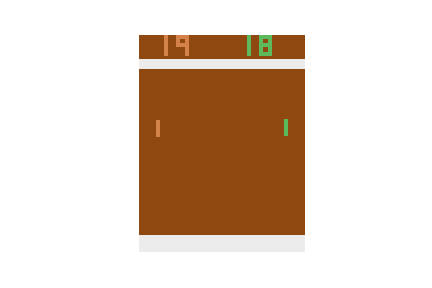
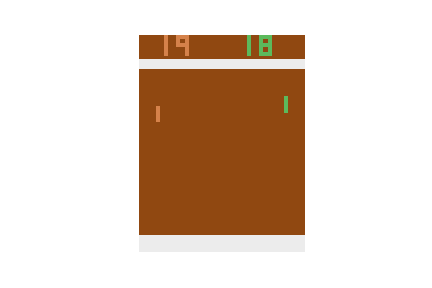
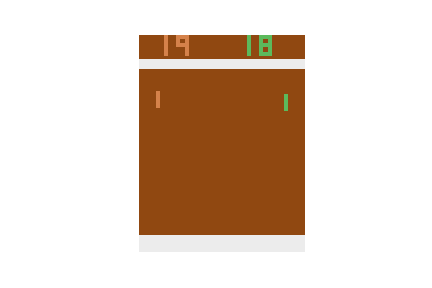
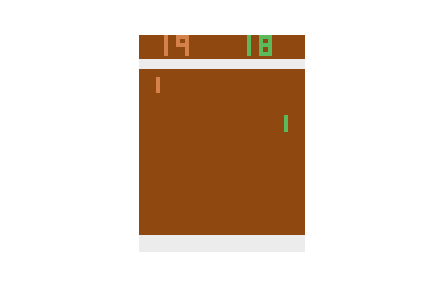
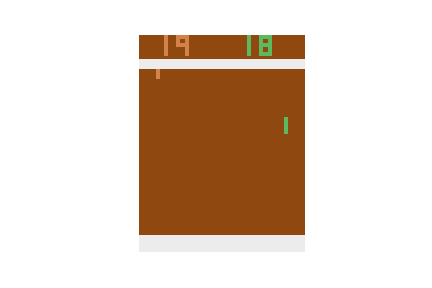
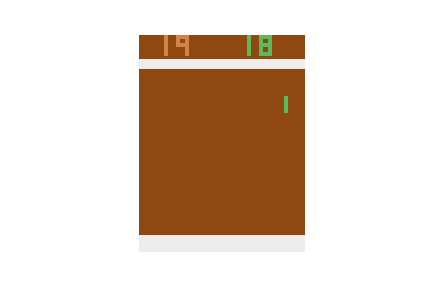
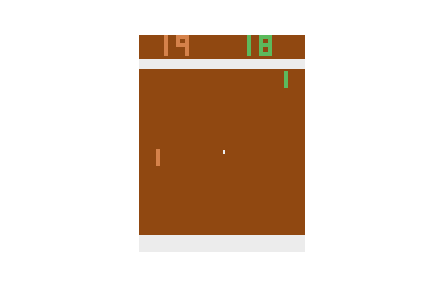
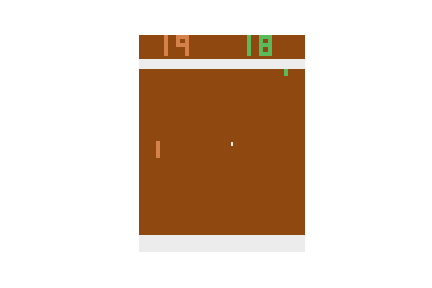
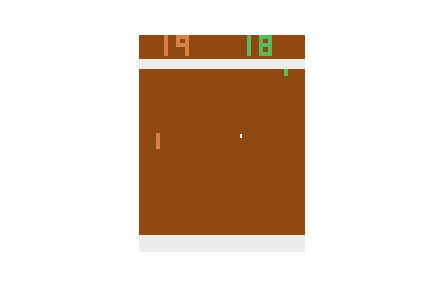
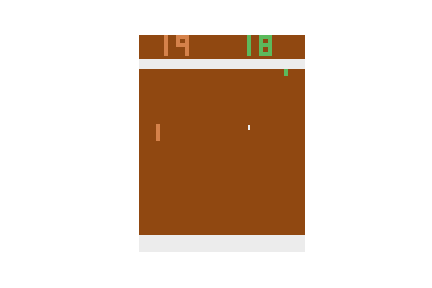
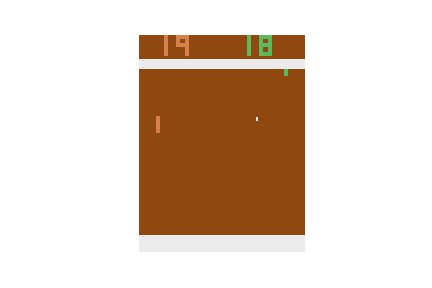
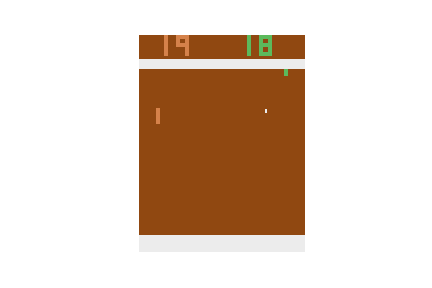
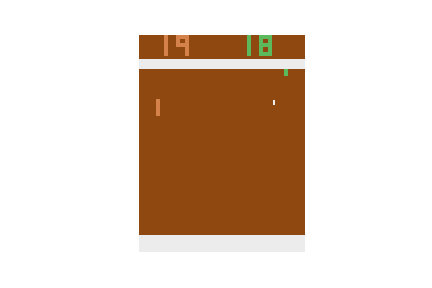
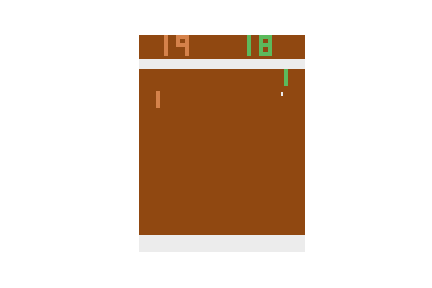
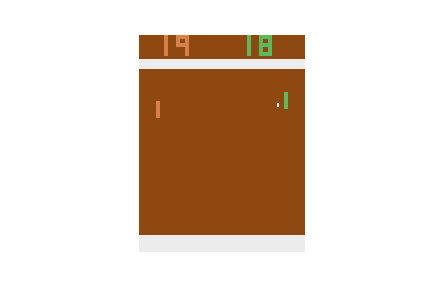
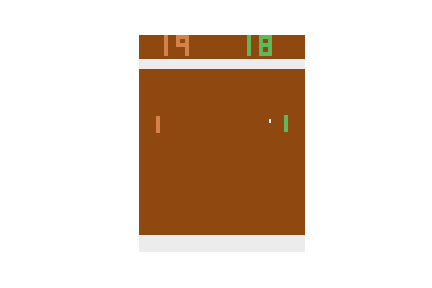
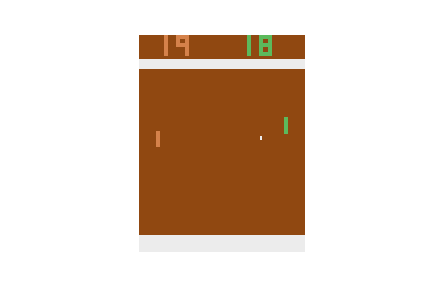
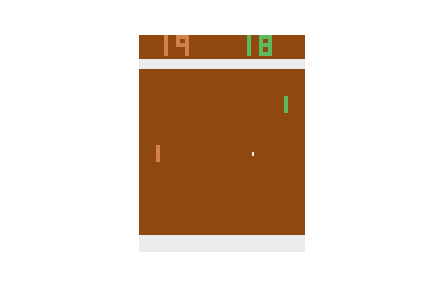
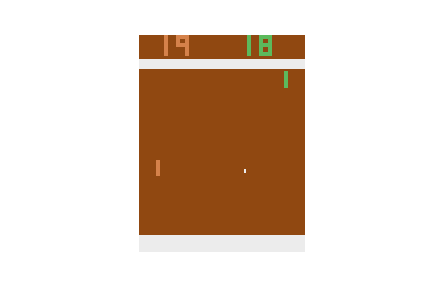
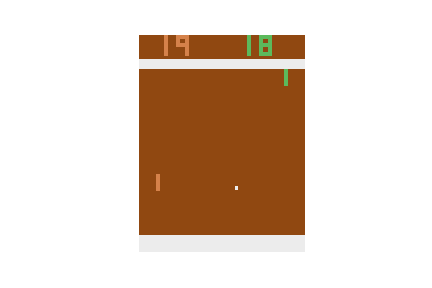
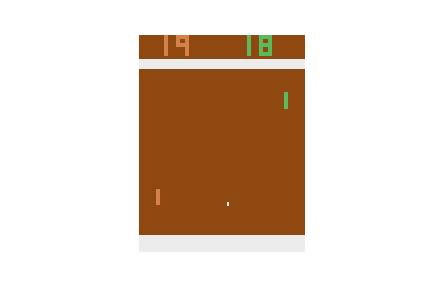
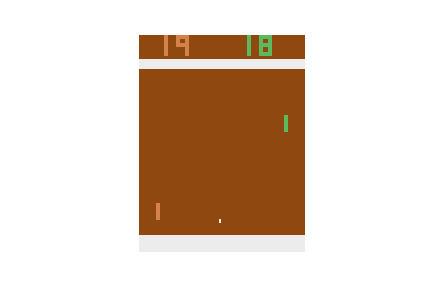
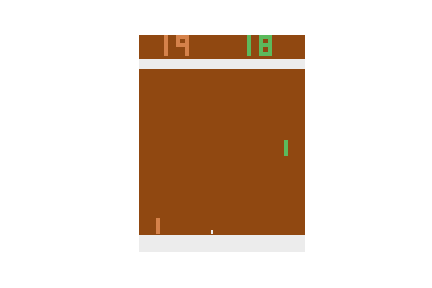
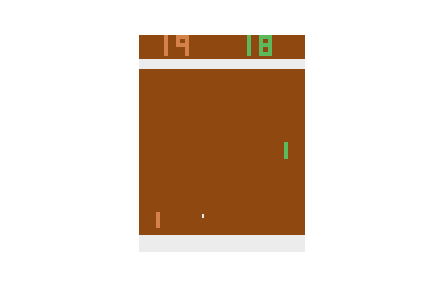
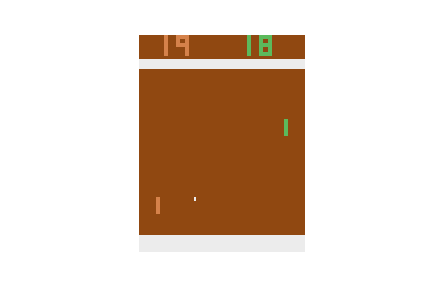
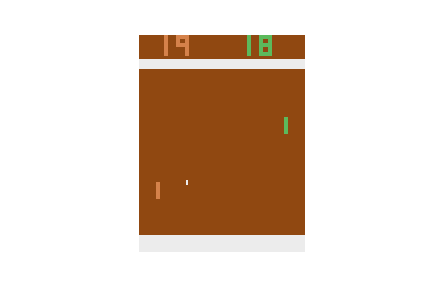
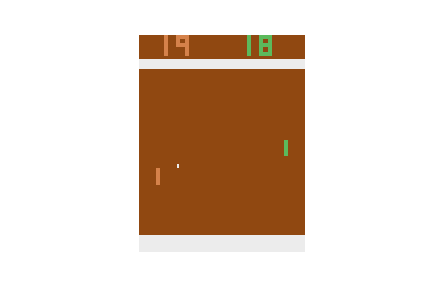
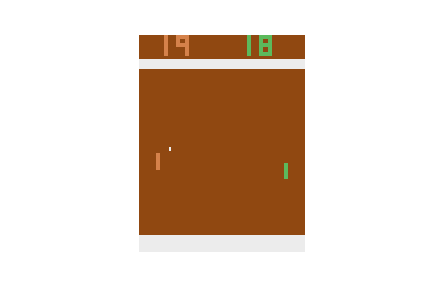
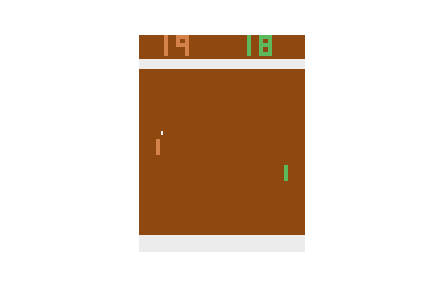
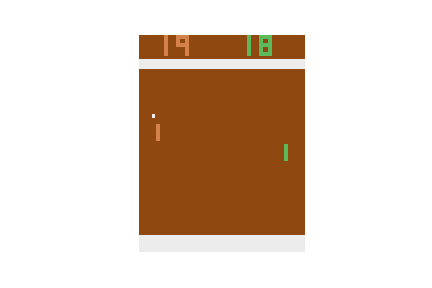
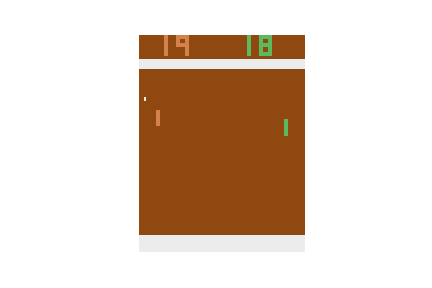
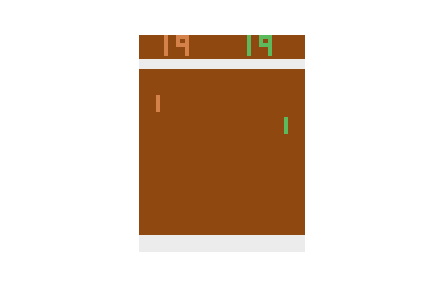
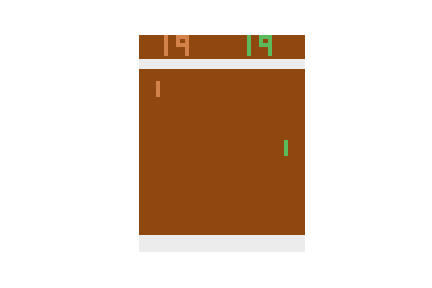
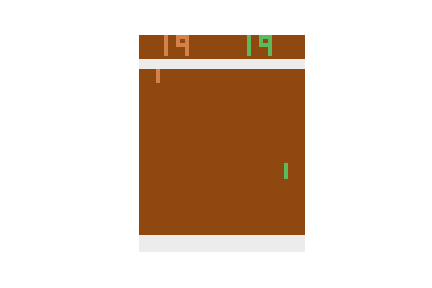
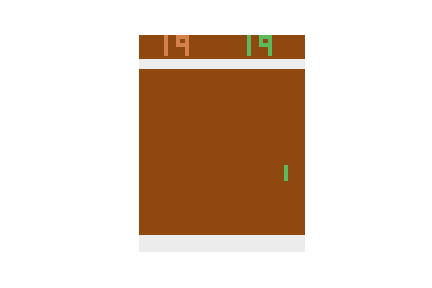
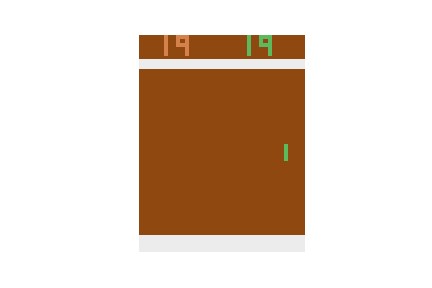
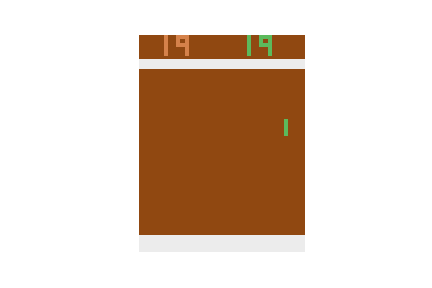
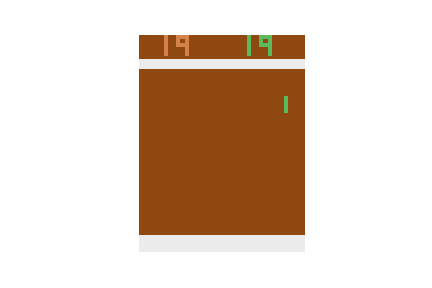
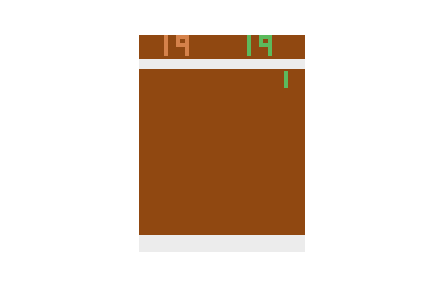
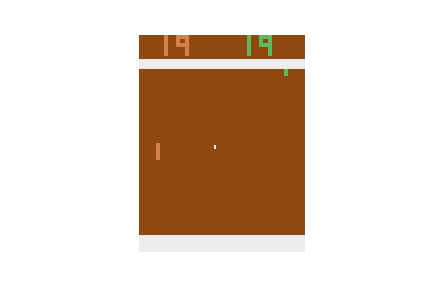
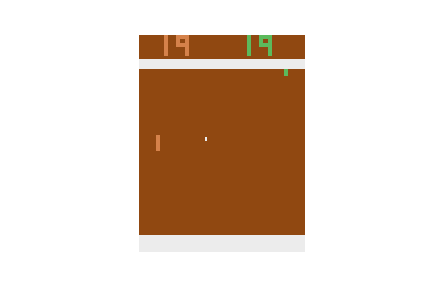
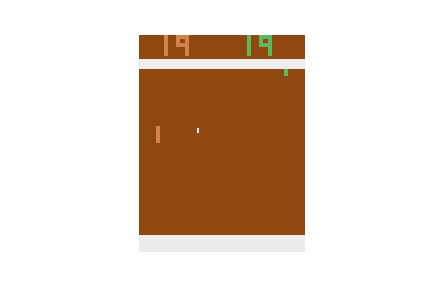
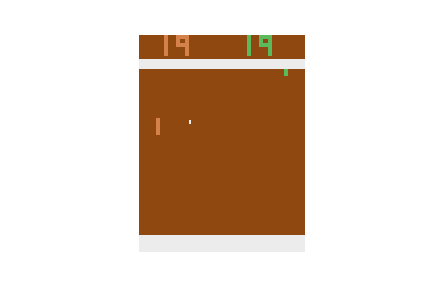
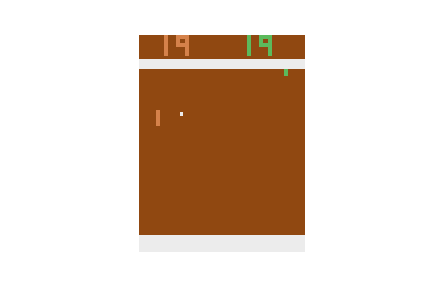
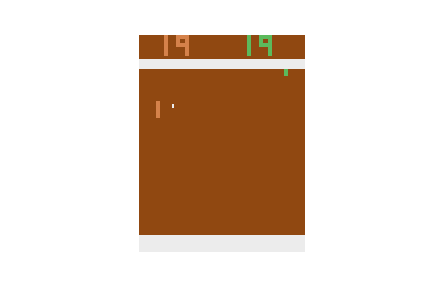
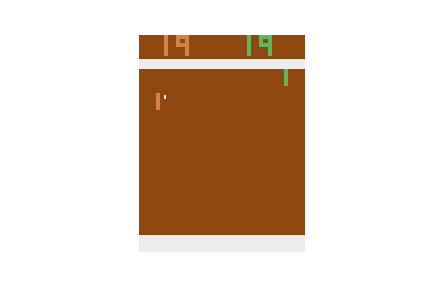
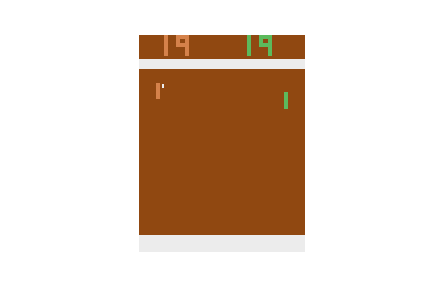
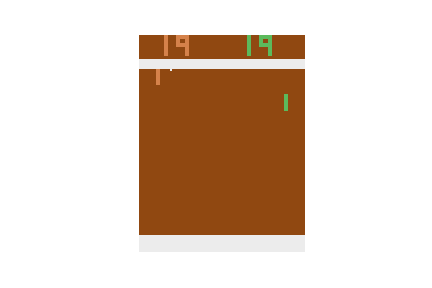
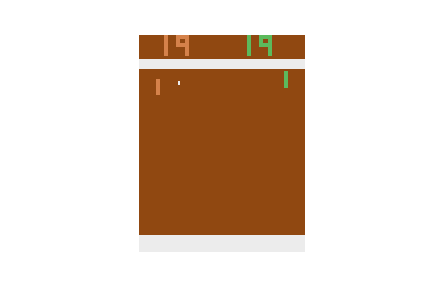
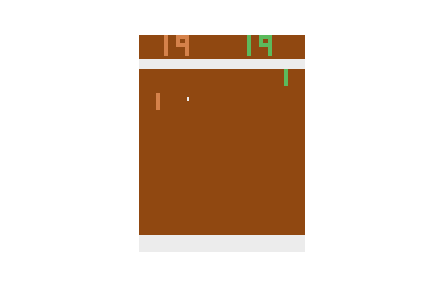
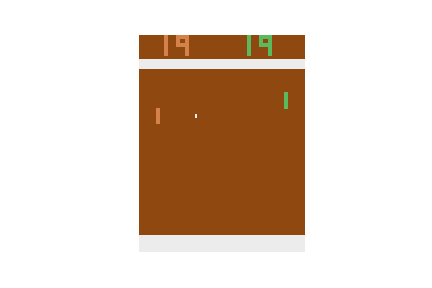
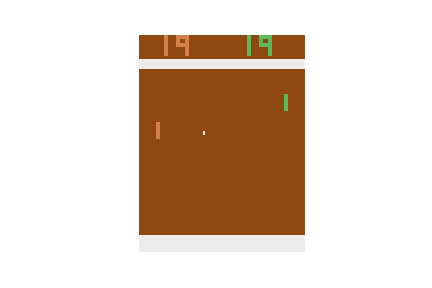
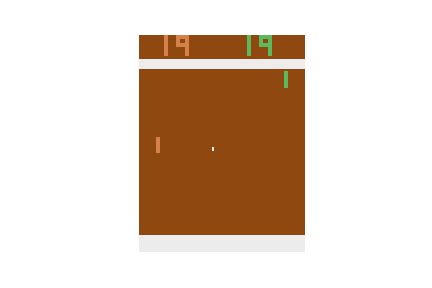
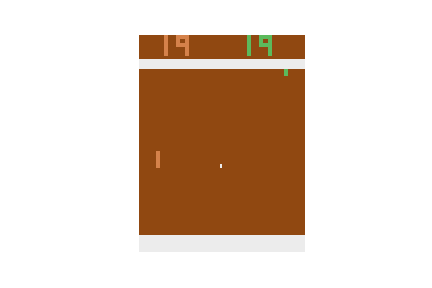
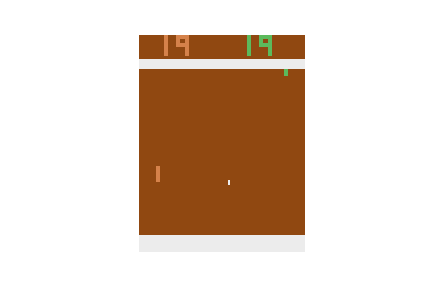
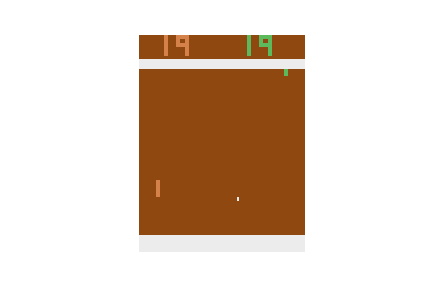
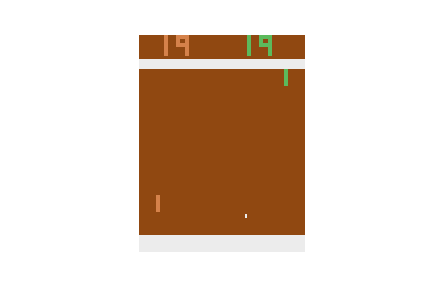
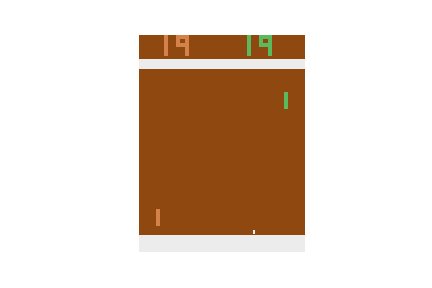
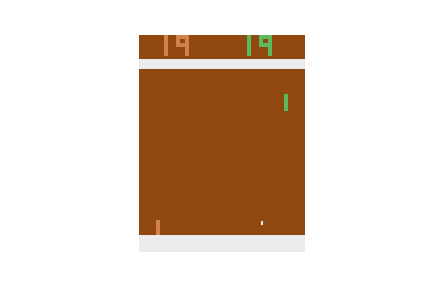
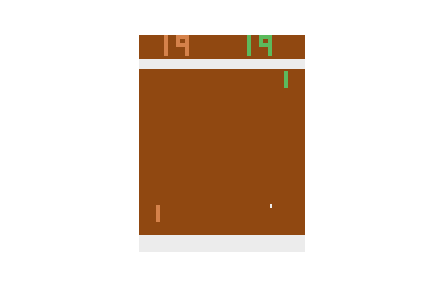
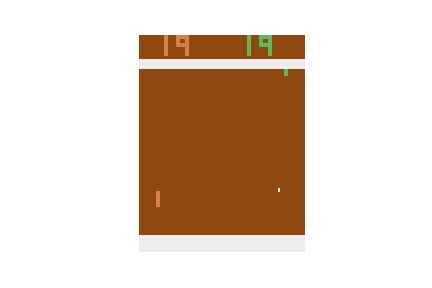
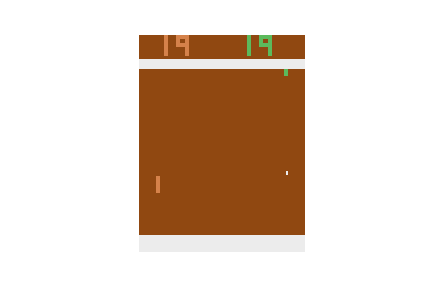
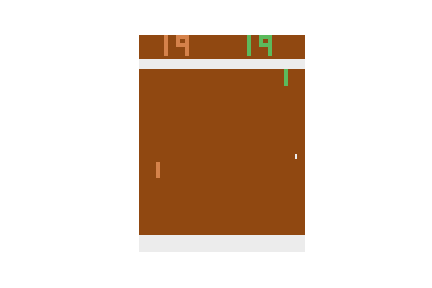
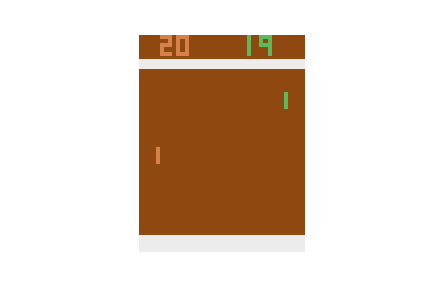
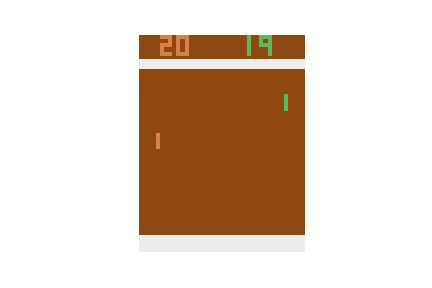
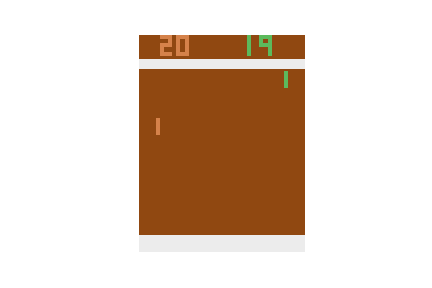
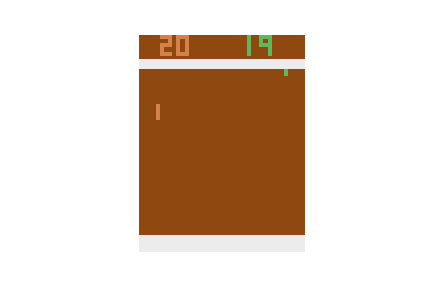
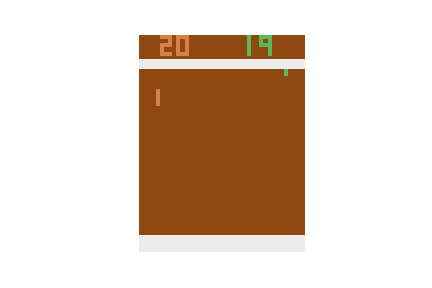
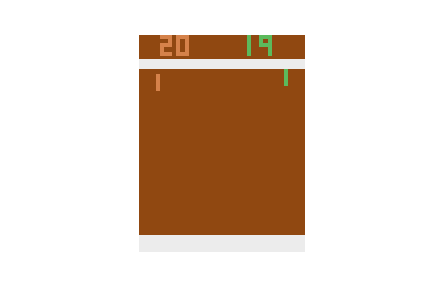
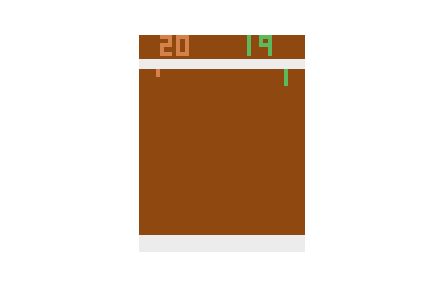
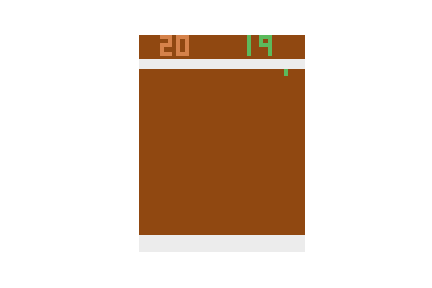
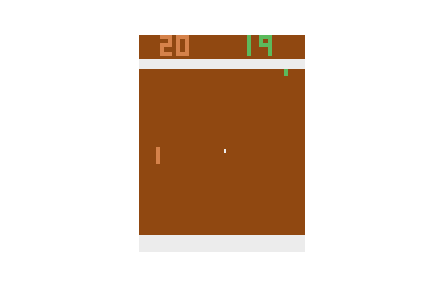
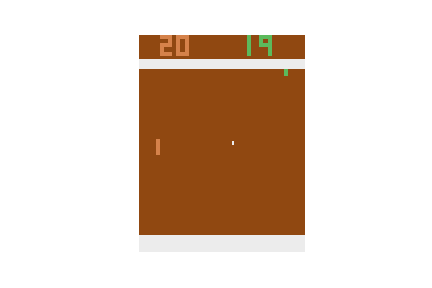
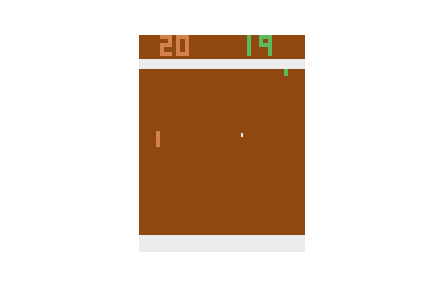
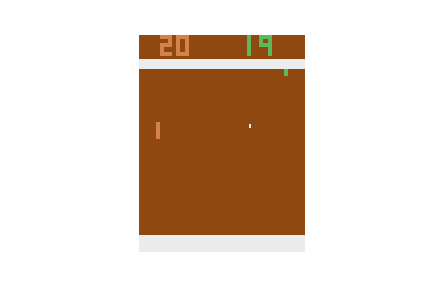
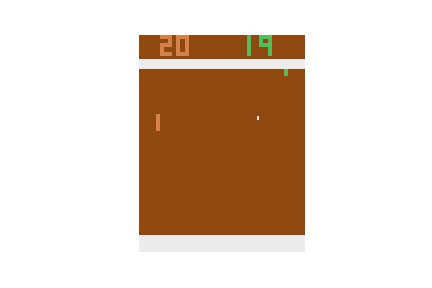
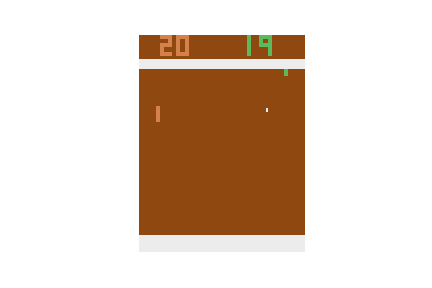
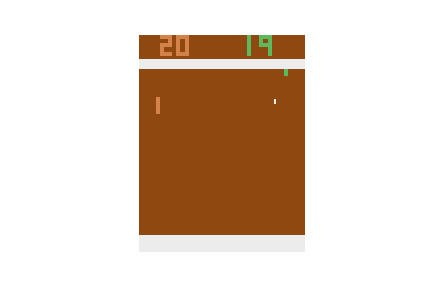
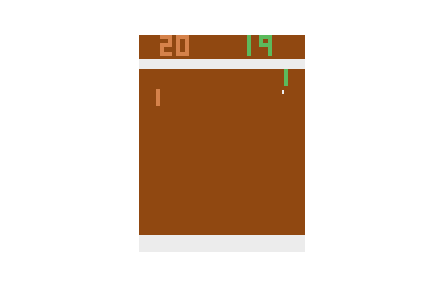
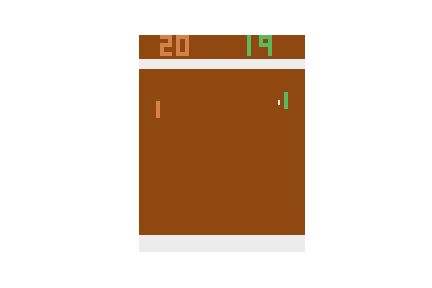
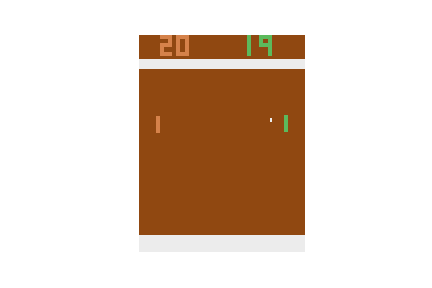
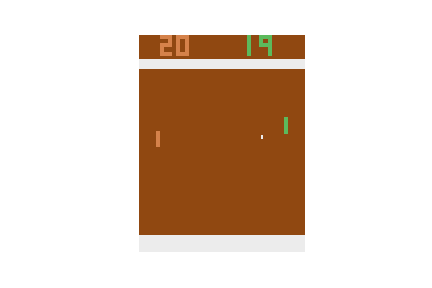
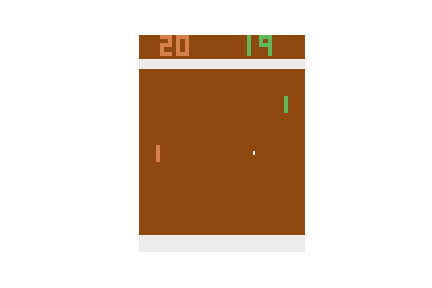
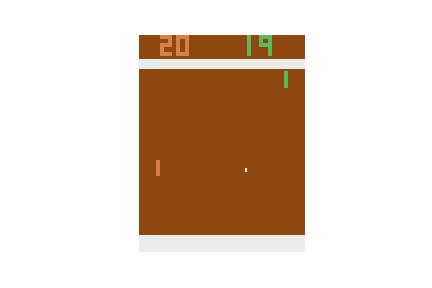
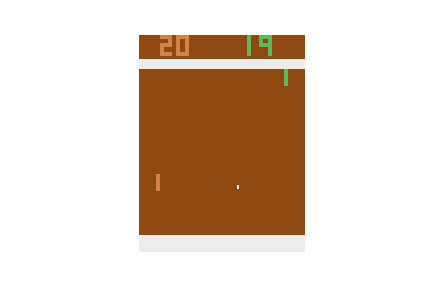
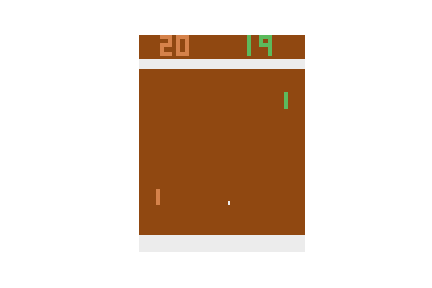
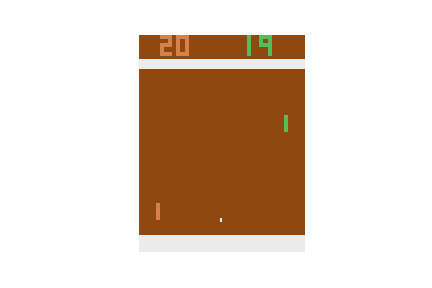
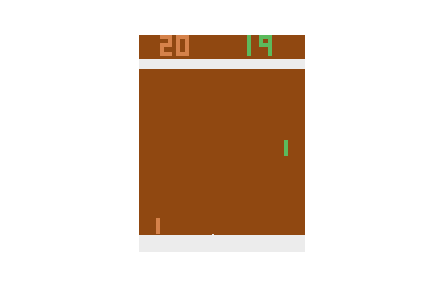
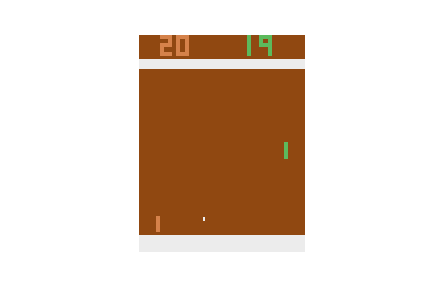
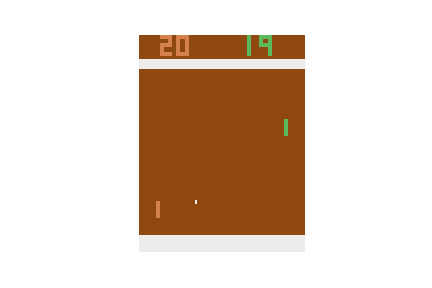
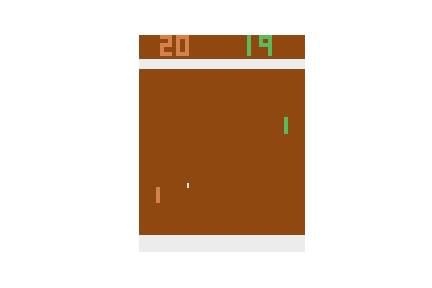
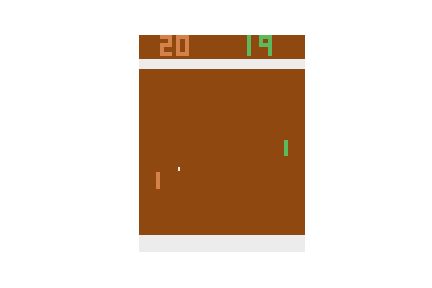
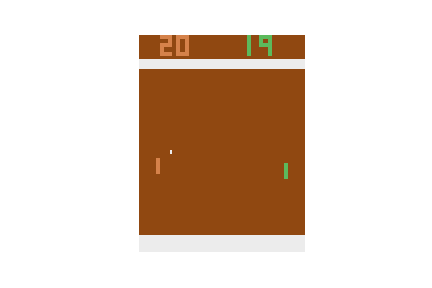
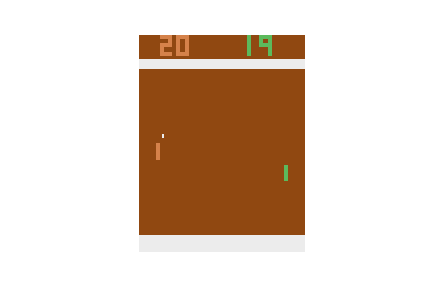
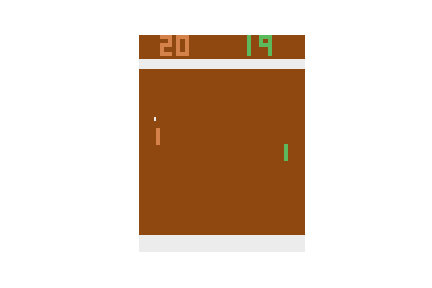
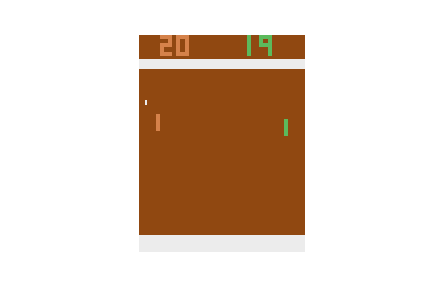
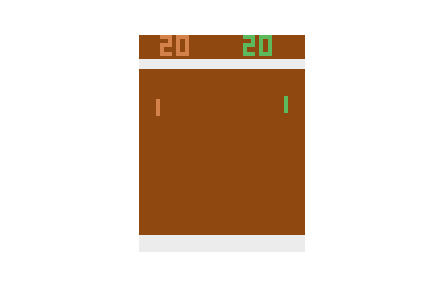
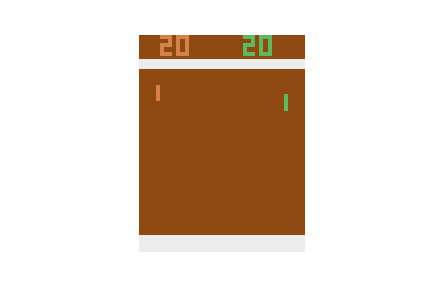
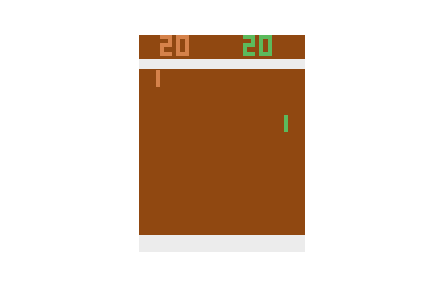
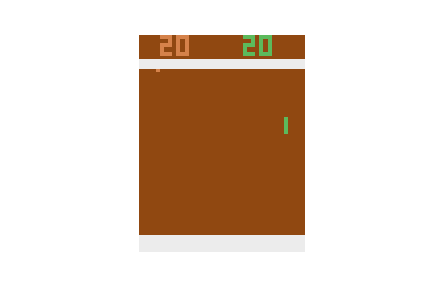
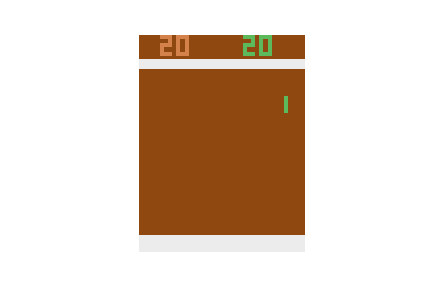
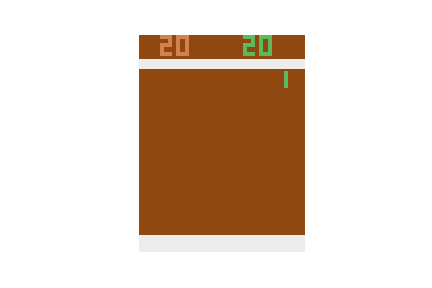
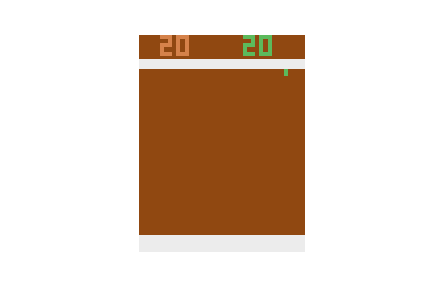
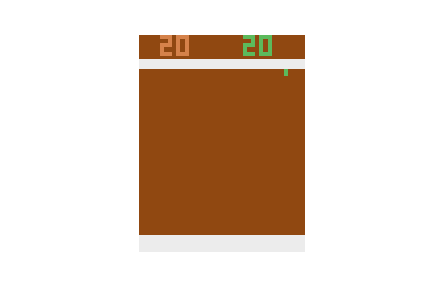
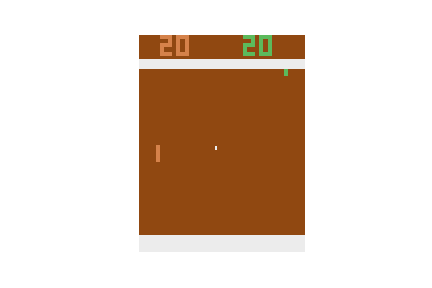
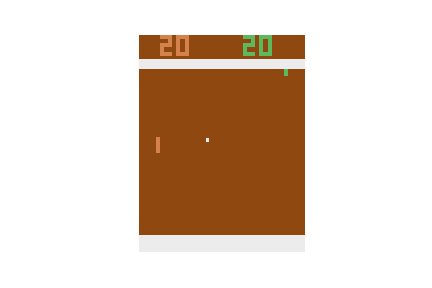
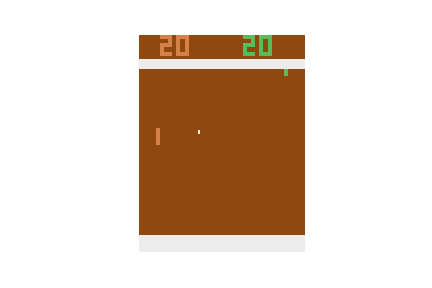
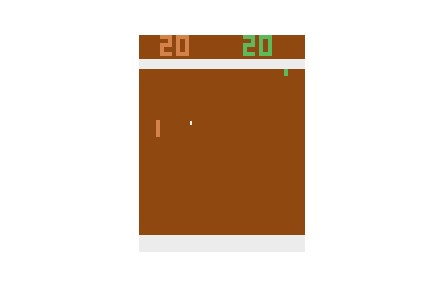
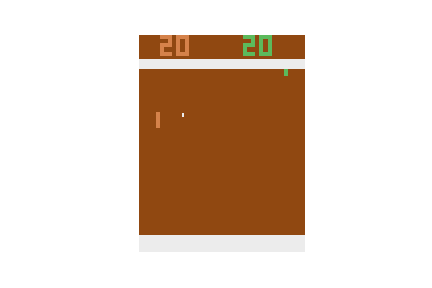
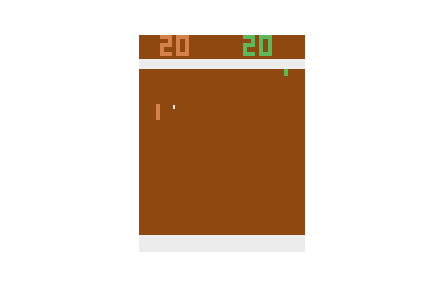
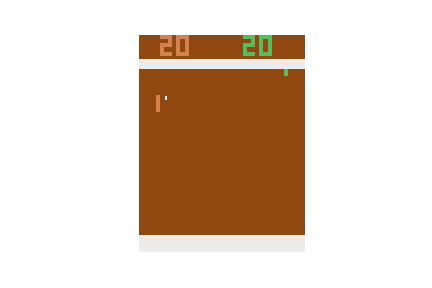
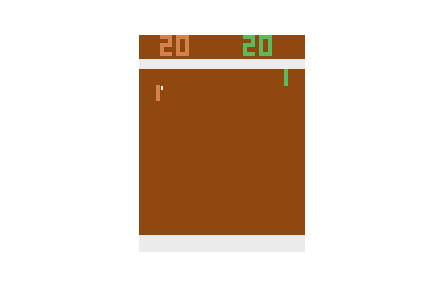
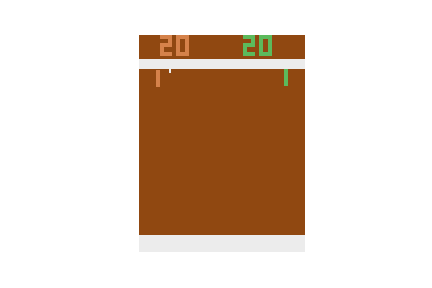
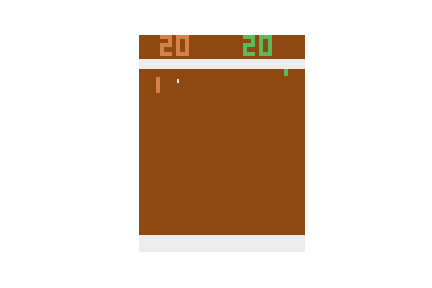
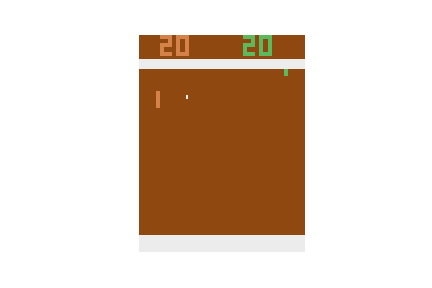
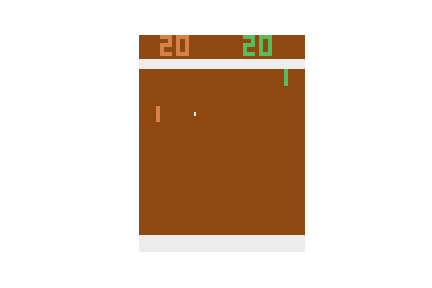
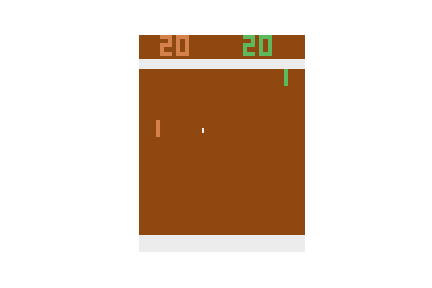
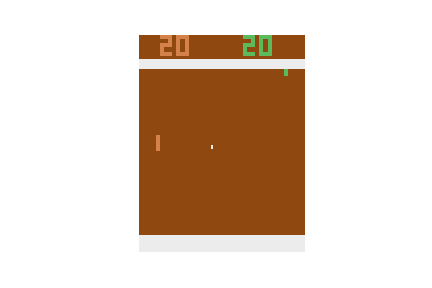
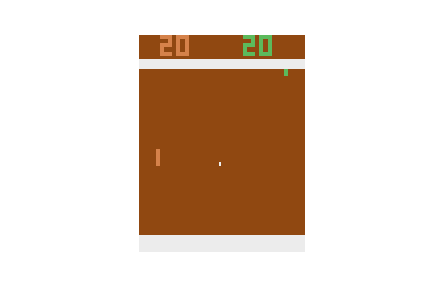
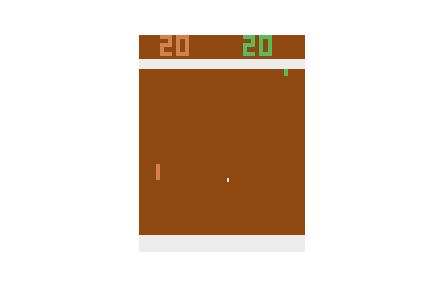
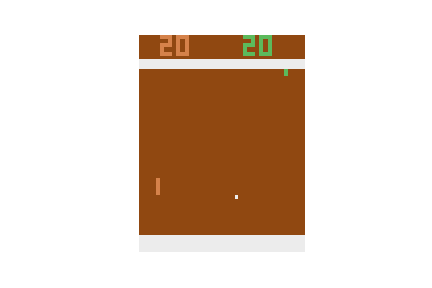
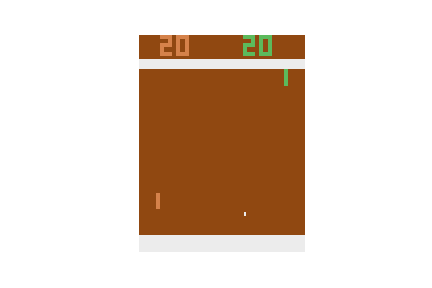
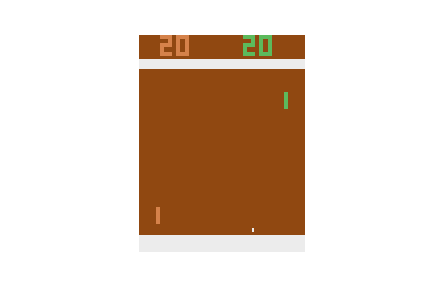
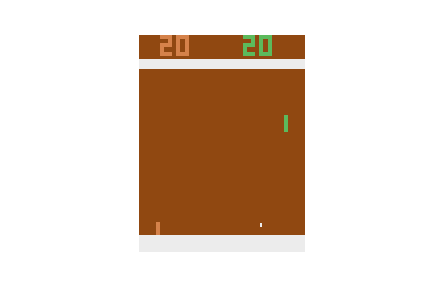
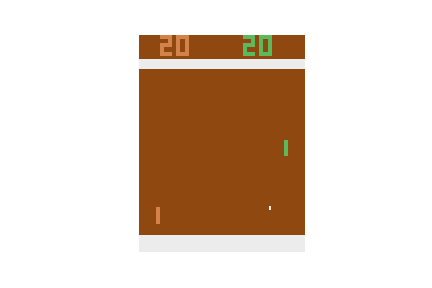
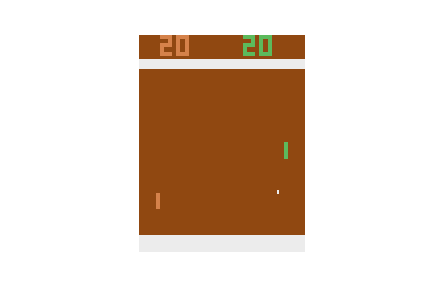
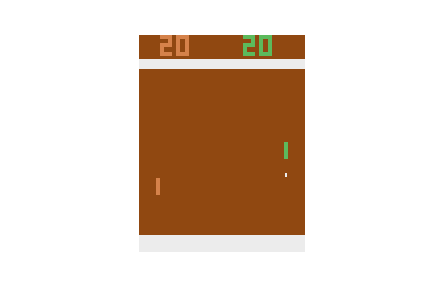
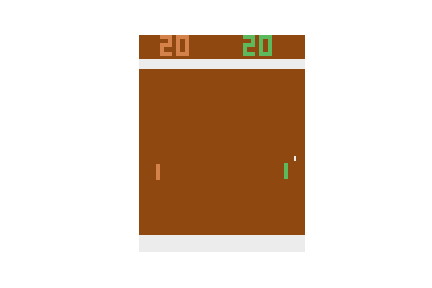
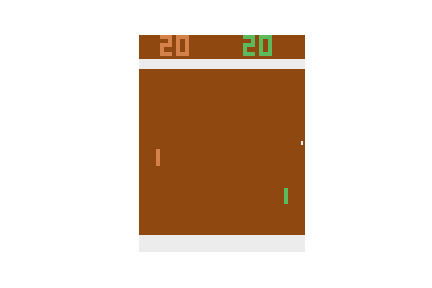

In [11]:
pong_utils.play(env, policy, time=2000)

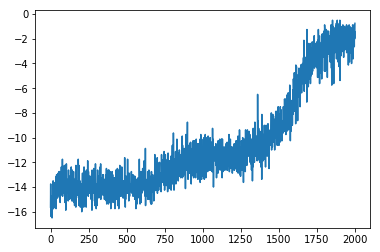

In [12]:
plt.plot(mean_rewards)